In [2]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%reload_ext autoreload

In [5]:
import torch
from FittedModels.utils.plotting_utils import plot_sampling_info, plot_divergences
from AIS_train.train_AIS import AIS_trainer
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils.plotting_utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.VincentTargets import TwoModes
from FittedModels.utils.plotting_utils import plot_samples_vs_contours
from FittedModels.utils.plotting_utils import plot_distributions

In [6]:
torch.manual_seed(1)
torch.set_default_dtype(torch.float64)
# ******************* Parameters *******************
# using the same as Vincent's code so we have a fair comparison
dim = 2
epochs = int(2e3)
n_samples_estimation = int(1e5)
batch_size = int(512)  # 20
lr = 1e-3
train_prior = False
weight_decay = 1e-2
optimizer = "AdamW"
flow_type = "RealNVP"  # "IAF"
loss_type = "DReG" # "kl"  #    #
initial_flow_scaling = 1.0
n_flow_steps = 30
annealing = True
clip_grad_norm = False
n_plots = 20
def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours(*args, **kwargs)
    plt.show()
#*******************************************************
target = TwoModes(2.0, 0.1)

torch.manual_seed(1)  # 0
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps,
                           scaling_factor=initial_flow_scaling, flow_type=flow_type)

# alpha=2

In [16]:
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=20, n_steps_transition_operator=3,
                    step_size=1.0, learnt_dist_kwargs={"lr":1e-3}, train_AIS_params=False,
                    maximise_log_prob_annealed = False)

## Check Initial Sample size, and compare against vanillas IS

In [ ]:
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
expectation_vanilla, info_dict_vanilla = \
vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
      var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

In [ ]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function)
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

## Train

  0%|          | 0/100 [00:00<?, ?it/s]

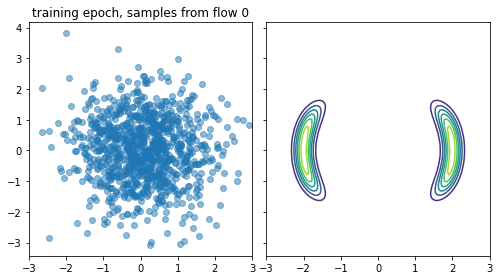

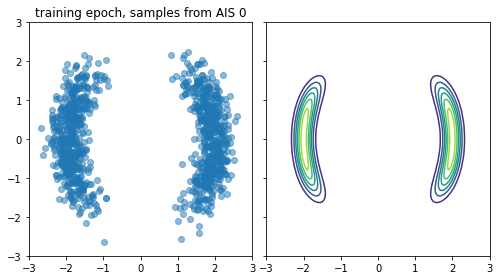

loss: -2.5702936183627276,   log_p_x_post_AIS -2.2042512350285715, ESS 0.1922093527918037:  20%|██        | 20/100 [01:33<05:51,  4.40s/it] 

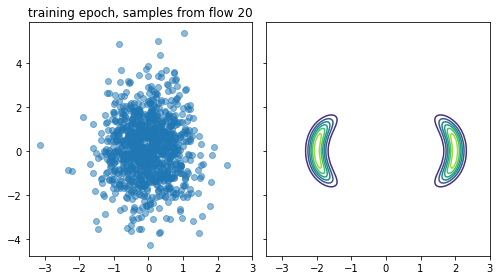

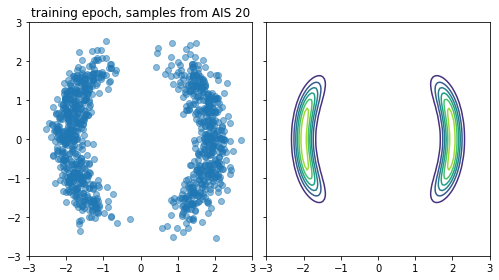

loss: -2.475590426336743,   log_p_x_post_AIS -1.801667594823992, ESS 0.24240120327951264:  40%|████      | 40/100 [03:04<04:42,  4.71s/it]  

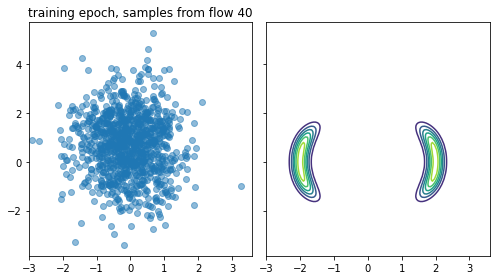

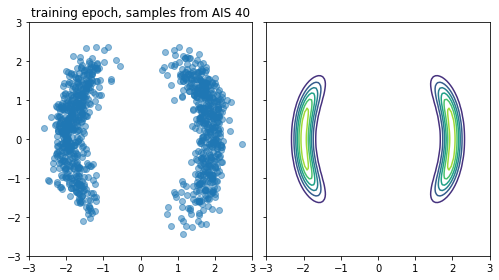

loss: -2.3801148798770244,   log_p_x_post_AIS -1.8130970977512453, ESS 0.26172348625008535:  60%|██████    | 60/100 [04:31<02:51,  4.28s/it]

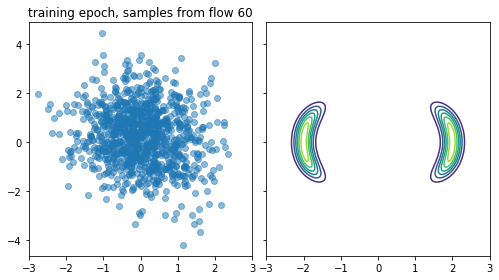

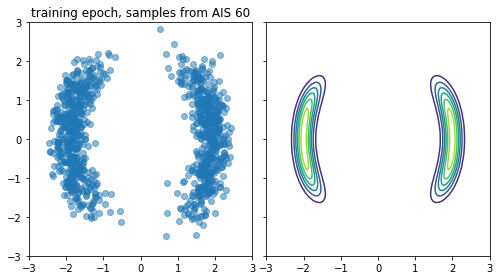

loss: -2.061954268146464,   log_p_x_post_AIS -1.748762419100879, ESS 0.35556589208421024:  80%|████████  | 80/100 [05:59<01:29,  4.48s/it]  

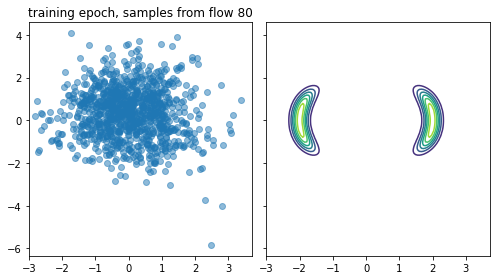

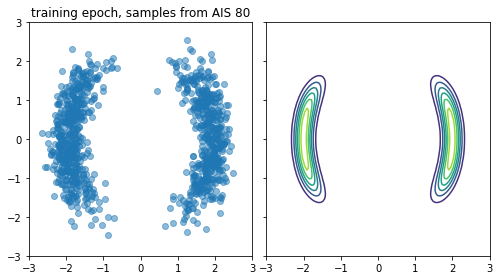

loss: -1.9188486294764338,   log_p_x_post_AIS -1.5944418002909053, ESS 0.39444264555874553: 100%|██████████| 100/100 [07:22<00:00,  4.42s/it]


In [17]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=5, plotting_func=plotter)

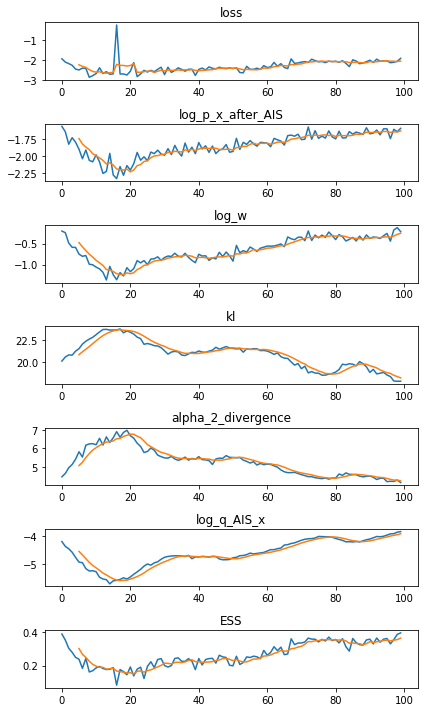

In [18]:
plot_history(history)

# Add log prob part

In [7]:
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=20, n_steps_transition_operator=3,
                    step_size=1.0, learnt_dist_kwargs={"lr":1e-3}, train_AIS_params=False,
                    maximise_log_prob_annealed = True)

  0%|          | 0/100 [00:00<?, ?it/s]

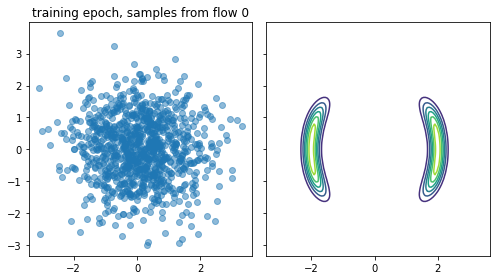

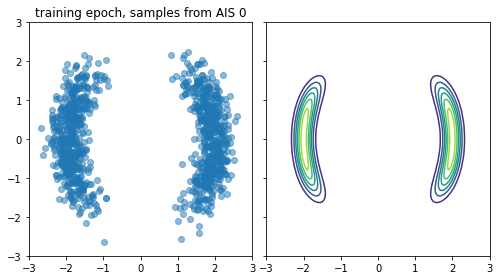

loss: 1.6166333943101314,   log_p_x_post_AIS -1.3989437822399922, ESS 0.46449257980361247:  20%|██        | 20/100 [01:28<05:34,  4.18s/it]

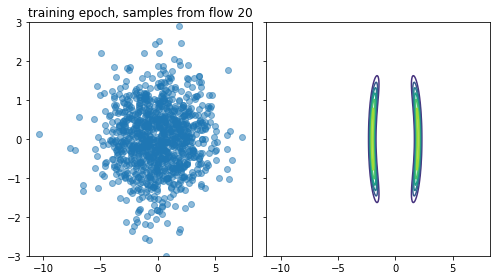

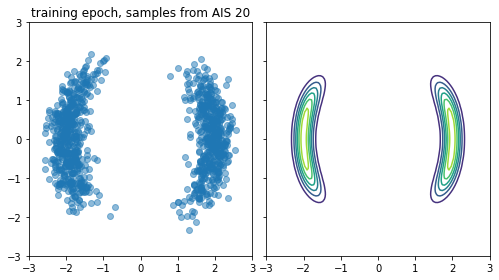

loss: 1.6478439793745092,   log_p_x_post_AIS -1.3985947865064927, ESS 0.48986658468319805:  40%|████      | 40/100 [02:52<04:11,  4.19s/it]

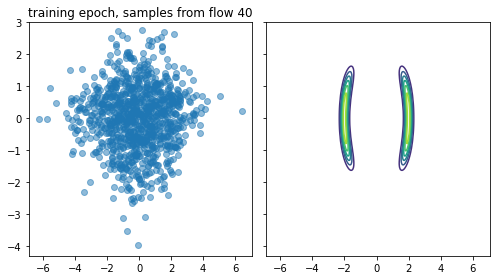

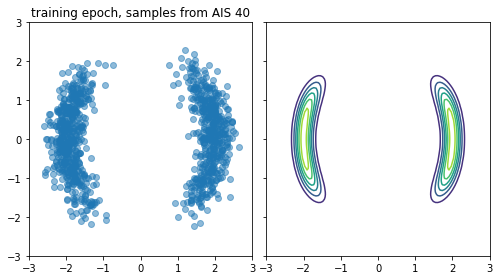

loss: 1.586892203524436,   log_p_x_post_AIS -1.3634709470367694, ESS 0.4820798441840853:  60%|██████    | 60/100 [04:17<02:57,  4.44s/it]  

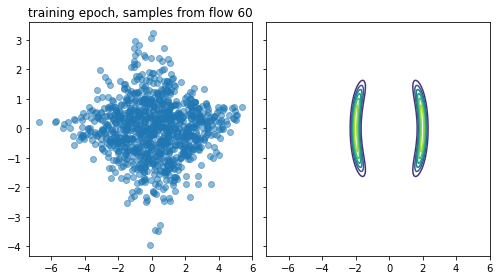

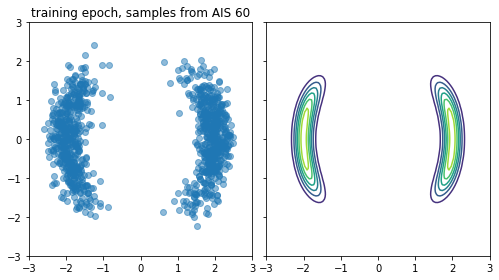

loss: 1.5793686114806817,   log_p_x_post_AIS -1.3948047003140447, ESS 0.49767769465760076:  80%|████████  | 80/100 [05:39<01:19,  3.98s/it]

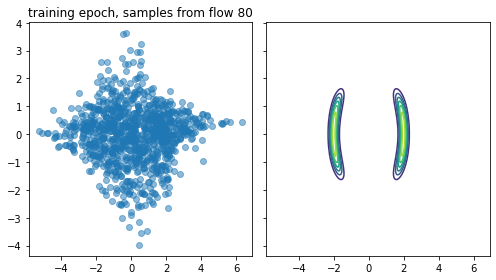

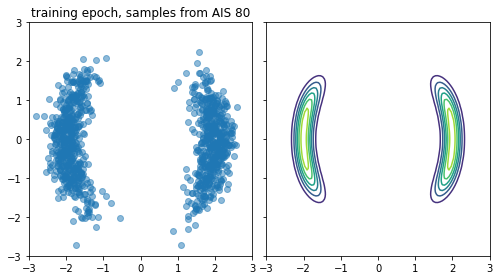

loss: 1.524304992226664,   log_p_x_post_AIS -1.3335437703724056, ESS 0.5010349506953904: 100%|██████████| 100/100 [06:56<00:00,  4.17s/it] 


In [8]:
history = tester.train(100, batch_size=1000, intermediate_plots=True, n_plots=5, plotting_func=plotter)

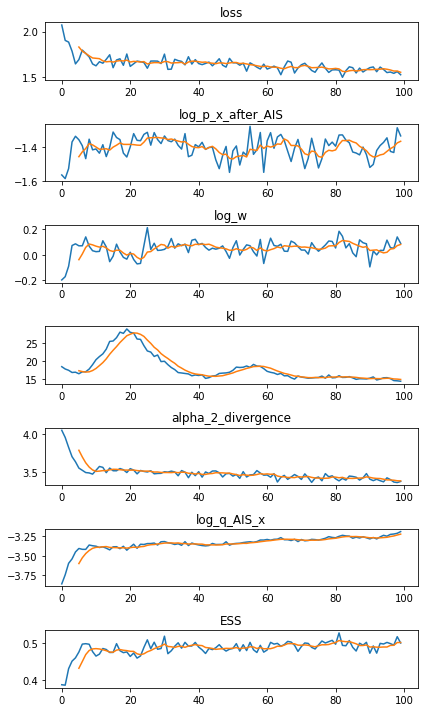

In [9]:
plot_history(history)

# What if we train just log prob

In [29]:
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=20, n_steps_transition_operator=3,
                    step_size=1.0, learnt_dist_kwargs={"lr":1e-4}, train_AIS_params=False,
                    maximise_log_prob_annealed = True)

In [30]:
tester.loss = lambda x: torch.zeros(1).to(x.device)

  0%|          | 0/1000 [00:00<?, ?it/s]

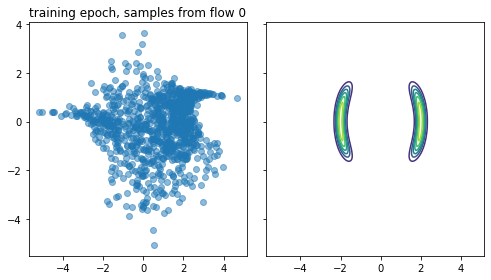

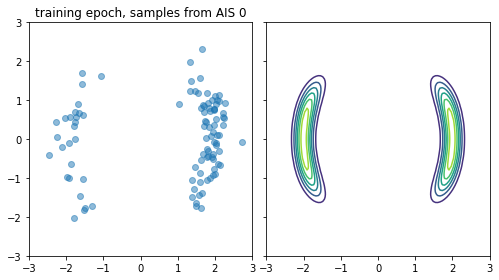

  0%|          | 2/1000 [00:04<31:42,  1.91s/it]  

The value argument must be within the support


loss: 2.7659176505966983,   log_p_x_post_AIS -1.3117907981090255, ESS 0.4295094708627028:   2%|▎         | 25/1000 [01:20<46:54,  2.89s/it]

The value argument must be within the support


loss: 2.7659176505966983,   log_p_x_post_AIS -1.3117907981090255, ESS 0.4295094708627028:   3%|▎         | 27/1000 [01:24<36:50,  2.27s/it]

The value argument must be within the support


loss: 2.7702377233134357,   log_p_x_post_AIS -1.3220454301245423, ESS 0.4276175945898049:   4%|▍         | 39/1000 [02:02<39:17,  2.45s/it]

The value argument must be within the support


loss: 2.69817087393029,   log_p_x_post_AIS -1.2583756457949633, ESS 0.44170064459021746:   7%|▋         | 73/1000 [03:54<39:52,  2.58s/it]  

The value argument must be within the support


loss: 2.74997105694627,   log_p_x_post_AIS -1.364634059056546, ESS 0.4612872341431043:   9%|▉         | 88/1000 [04:41<36:59,  2.43s/it]  

The value argument must be within the support


loss: 2.723339029998626,   log_p_x_post_AIS -1.2785134048548583, ESS 0.4519796584463349:   9%|▉         | 92/1000 [04:53<42:04,  2.78s/it]

The value argument must be within the support


loss: 2.730540788890941,   log_p_x_post_AIS -1.2744170522785772, ESS 0.40007133099120235:  11%|█         | 106/1000 [05:38<38:09,  2.56s/it]

The value argument must be within the support


loss: 2.726887031095031,   log_p_x_post_AIS -1.342871017871348, ESS 0.45688684080732606:  11%|█▏        | 113/1000 [05:56<26:05,  1.76s/it] 

The value argument must be within the support
The value argument must be within the support


loss: 2.726887031095031,   log_p_x_post_AIS -1.342871017871348, ESS 0.45688684080732606:  12%|█▏        | 120/1000 [06:16<33:57,  2.32s/it]

The value argument must be within the support


loss: 2.726887031095031,   log_p_x_post_AIS -1.342871017871348, ESS 0.45688684080732606:  12%|█▏        | 121/1000 [06:17<25:50,  1.76s/it]

The value argument must be within the support


loss: 2.726887031095031,   log_p_x_post_AIS -1.342871017871348, ESS 0.45688684080732606:  12%|█▏        | 123/1000 [06:21<28:14,  1.93s/it]

The value argument must be within the support


loss: 2.697776101750814,   log_p_x_post_AIS -1.347161903377571, ESS 0.41714133443229:  13%|█▎        | 133/1000 [06:54<37:59,  2.63s/it]   

The value argument must be within the support


loss: 2.637498895601383,   log_p_x_post_AIS -1.2808767976586304, ESS 0.4264740325951969:  14%|█▍        | 142/1000 [07:22<35:48,  2.50s/it]

The value argument must be within the support


loss: 2.637498895601383,   log_p_x_post_AIS -1.2808767976586304, ESS 0.4264740325951969:  14%|█▍        | 144/1000 [07:25<28:30,  2.00s/it]

The value argument must be within the support


loss: 2.637498895601383,   log_p_x_post_AIS -1.2808767976586304, ESS 0.4264740325951969:  15%|█▍        | 147/1000 [07:32<28:46,  2.02s/it]

The value argument must be within the support


loss: 2.637498895601383,   log_p_x_post_AIS -1.2808767976586304, ESS 0.4264740325951969:  15%|█▌        | 150/1000 [07:40<30:34,  2.16s/it]

The value argument must be within the support


loss: 2.637498895601383,   log_p_x_post_AIS -1.2808767976586304, ESS 0.4264740325951969:  15%|█▌        | 151/1000 [07:41<25:38,  1.81s/it]

The value argument must be within the support


loss: 2.637498895601383,   log_p_x_post_AIS -1.2808767976586304, ESS 0.4264740325951969:  16%|█▌        | 161/1000 [08:12<33:57,  2.43s/it]

The value argument must be within the support


loss: 2.637498895601383,   log_p_x_post_AIS -1.2808767976586304, ESS 0.4264740325951969:  16%|█▋        | 163/1000 [08:17<36:45,  2.64s/it]

The value argument must be within the support


loss: 2.637498895601383,   log_p_x_post_AIS -1.2808767976586304, ESS 0.4264740325951969:  17%|█▋        | 168/1000 [08:31<32:22,  2.33s/it]

The value argument must be within the support


loss: 2.6896032117674467,   log_p_x_post_AIS -1.3068606542390406, ESS 0.41920324349794014:  17%|█▋        | 172/1000 [08:42<31:24,  2.28s/it]

The value argument must be within the support


loss: 2.6896032117674467,   log_p_x_post_AIS -1.3068606542390406, ESS 0.41920324349794014:  17%|█▋        | 173/1000 [08:43<25:13,  1.83s/it]

The value argument must be within the support


loss: 2.6896032117674467,   log_p_x_post_AIS -1.3068606542390406, ESS 0.41920324349794014:  18%|█▊        | 178/1000 [08:57<34:29,  2.52s/it]

The value argument must be within the support


loss: 2.6896032117674467,   log_p_x_post_AIS -1.3068606542390406, ESS 0.41920324349794014:  18%|█▊        | 180/1000 [09:02<33:31,  2.45s/it]

The value argument must be within the support


loss: 2.6686149628368367,   log_p_x_post_AIS -1.2489427908825117, ESS 0.41140019750831314:  18%|█▊        | 182/1000 [09:07<33:08,  2.43s/it]

The value argument must be within the support


loss: 2.6686149628368367,   log_p_x_post_AIS -1.2489427908825117, ESS 0.41140019750831314:  18%|█▊        | 185/1000 [09:17<40:24,  2.98s/it]

The value argument must be within the support


loss: 2.5892194849997323,   log_p_x_post_AIS -1.3419399044265898, ESS 0.37740663394928237:  19%|█▉        | 191/1000 [09:34<41:43,  3.09s/it]

The value argument must be within the support


loss: 2.5892194849997323,   log_p_x_post_AIS -1.3419399044265898, ESS 0.37740663394928237:  20%|█▉        | 195/1000 [09:41<28:24,  2.12s/it]

The value argument must be within the support


loss: 2.5892194849997323,   log_p_x_post_AIS -1.3419399044265898, ESS 0.37740663394928237:  20%|█▉        | 198/1000 [09:48<27:23,  2.05s/it]

The value argument must be within the support


loss: 2.615427721471014,   log_p_x_post_AIS -1.2995288441859913, ESS 0.40260317598846:  20%|██        | 200/1000 [09:58<35:38,  2.67s/it]    

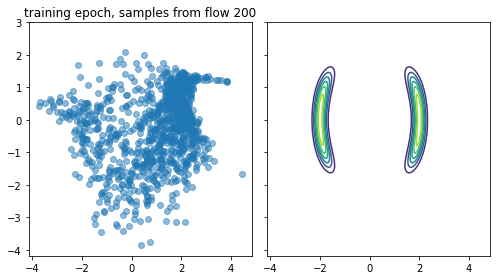

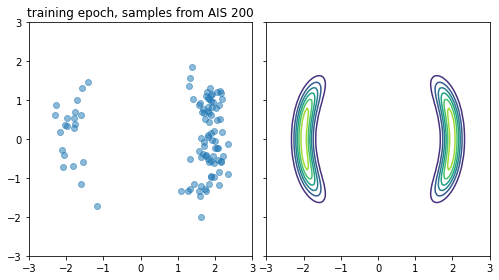

loss: 2.615427721471014,   log_p_x_post_AIS -1.2995288441859913, ESS 0.40260317598846:  20%|██        | 205/1000 [10:11<38:10,  2.88s/it]

The value argument must be within the support


loss: 2.615427721471014,   log_p_x_post_AIS -1.2995288441859913, ESS 0.40260317598846:  21%|██        | 211/1000 [10:28<32:20,  2.46s/it]

The value argument must be within the support


loss: 2.615427721471014,   log_p_x_post_AIS -1.2995288441859913, ESS 0.40260317598846:  22%|██▏       | 216/1000 [10:41<28:41,  2.20s/it]

The value argument must be within the support


loss: 2.603028251115374,   log_p_x_post_AIS -1.3996087901906453, ESS 0.39408146097143426:  22%|██▏       | 222/1000 [10:57<28:43,  2.22s/it]

The value argument must be within the support


loss: 2.603028251115374,   log_p_x_post_AIS -1.3996087901906453, ESS 0.39408146097143426:  23%|██▎       | 230/1000 [11:21<32:51,  2.56s/it]

The value argument must be within the support


loss: 2.5518801039954093,   log_p_x_post_AIS -1.2581947119802366, ESS 0.415256248674346:  23%|██▎       | 232/1000 [11:26<30:38,  2.39s/it] 

The value argument must be within the support


loss: 2.5518801039954093,   log_p_x_post_AIS -1.2581947119802366, ESS 0.415256248674346:  23%|██▎       | 233/1000 [11:27<24:04,  1.88s/it]

The value argument must be within the support


loss: 2.5518801039954093,   log_p_x_post_AIS -1.2581947119802366, ESS 0.415256248674346:  23%|██▎       | 234/1000 [11:27<18:05,  1.42s/it]

The value argument must be within the support


loss: 2.5518801039954093,   log_p_x_post_AIS -1.2581947119802366, ESS 0.415256248674346:  24%|██▎       | 236/1000 [11:29<12:21,  1.03it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.5518801039954093,   log_p_x_post_AIS -1.2581947119802366, ESS 0.415256248674346:  24%|██▎       | 237/1000 [11:29<10:21,  1.23it/s]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  24%|██▍       | 242/1000 [11:42<24:45,  1.96s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  25%|██▍       | 247/1000 [11:55<32:23,  2.58s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  25%|██▍       | 248/1000 [11:56<25:30,  2.03s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  25%|██▍       | 249/1000 [11:57<21:12,  1.69s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  25%|██▌       | 250/1000 [11:57<18:06,  1.45s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  25%|██▌       | 251/1000 [11:59<18:47,  1.51s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  25%|██▌       | 252/1000 [11:59<14:33,  1.17s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  26%|██▌       | 255/1000 [12:08<27:27,  2.21s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  26%|██▌       | 256/1000 [12:11<28:17,  2.28s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  26%|██▌       | 257/1000 [12:11<22:08,  1.79s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  26%|██▌       | 258/1000 [12:13<23:36,  1.91s/it]

The value argument must be within the support


loss: 2.551969500436692,   log_p_x_post_AIS -1.2457925839955484, ESS 0.38662248169907476:  26%|██▌       | 260/1000 [12:18<26:22,  2.14s/it]

The value argument must be within the support


loss: 2.5846249969955903,   log_p_x_post_AIS -1.3562941097277919, ESS 0.3585120876083773:  26%|██▋       | 263/1000 [12:28<33:23,  2.72s/it]

The value argument must be within the support


loss: 2.5846249969955903,   log_p_x_post_AIS -1.3562941097277919, ESS 0.3585120876083773:  26%|██▋       | 264/1000 [12:28<26:22,  2.15s/it]

The value argument must be within the support


loss: 2.5846249969955903,   log_p_x_post_AIS -1.3562941097277919, ESS 0.3585120876083773:  27%|██▋       | 269/1000 [12:42<26:56,  2.21s/it]

The value argument must be within the support


loss: 2.5846249969955903,   log_p_x_post_AIS -1.3562941097277919, ESS 0.3585120876083773:  27%|██▋       | 271/1000 [12:46<25:13,  2.08s/it]

The value argument must be within the support


loss: 2.5846249969955903,   log_p_x_post_AIS -1.3562941097277919, ESS 0.3585120876083773:  27%|██▋       | 274/1000 [12:54<29:07,  2.41s/it]

The value argument must be within the support


loss: 2.5846249969955903,   log_p_x_post_AIS -1.3562941097277919, ESS 0.3585120876083773:  28%|██▊       | 275/1000 [12:55<21:19,  1.76s/it]

The value argument must be within the support


loss: 2.5846249969955903,   log_p_x_post_AIS -1.3562941097277919, ESS 0.3585120876083773:  28%|██▊       | 276/1000 [12:56<18:00,  1.49s/it]

The value argument must be within the support


loss: 2.5846249969955903,   log_p_x_post_AIS -1.3562941097277919, ESS 0.3585120876083773:  28%|██▊       | 277/1000 [12:57<18:18,  1.52s/it]

The value argument must be within the support


loss: 2.5846249969955903,   log_p_x_post_AIS -1.3562941097277919, ESS 0.3585120876083773:  28%|██▊       | 280/1000 [13:05<24:12,  2.02s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  28%|██▊       | 283/1000 [13:11<22:56,  1.92s/it] 

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  28%|██▊       | 284/1000 [13:12<17:46,  1.49s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  28%|██▊       | 285/1000 [13:14<21:07,  1.77s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  29%|██▊       | 286/1000 [13:17<25:12,  2.12s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  29%|██▊       | 287/1000 [13:18<21:04,  1.77s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  29%|██▉       | 288/1000 [13:21<23:15,  1.96s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  29%|██▉       | 289/1000 [13:21<17:49,  1.50s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  29%|██▉       | 291/1000 [13:26<23:32,  1.99s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  29%|██▉       | 293/1000 [13:28<16:58,  1.44s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  29%|██▉       | 294/1000 [13:29<12:30,  1.06s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  30%|██▉       | 296/1000 [13:34<22:26,  1.91s/it]

The value argument must be within the support


loss: 2.566115195645388,   log_p_x_post_AIS -1.3499118515499817, ESS 0.3835998458603433:  30%|███       | 300/1000 [13:41<17:05,  1.46s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  30%|███       | 303/1000 [13:48<21:14,  1.83s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  30%|███       | 304/1000 [13:50<19:34,  1.69s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  31%|███       | 306/1000 [13:53<18:02,  1.56s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  31%|███       | 307/1000 [13:56<22:40,  1.96s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  31%|███       | 308/1000 [13:57<19:24,  1.68s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  31%|███       | 309/1000 [13:59<21:57,  1.91s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  31%|███       | 311/1000 [14:05<25:45,  2.24s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  31%|███       | 312/1000 [14:06<20:46,  1.81s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  31%|███▏      | 313/1000 [14:06<17:34,  1.54s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  32%|███▏      | 317/1000 [14:19<32:21,  2.84s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  32%|███▏      | 319/1000 [14:20<18:47,  1.66s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  32%|███▏      | 321/1000 [14:24<18:44,  1.66s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  32%|███▏      | 322/1000 [14:24<14:57,  1.32s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  32%|███▏      | 324/1000 [14:29<18:39,  1.66s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  33%|███▎      | 327/1000 [14:36<23:18,  2.08s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  33%|███▎      | 328/1000 [14:39<26:24,  2.36s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  33%|███▎      | 329/1000 [14:41<24:30,  2.19s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  33%|███▎      | 330/1000 [14:42<19:32,  1.75s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  33%|███▎      | 331/1000 [14:42<15:46,  1.41s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  33%|███▎      | 332/1000 [14:44<15:43,  1.41s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  33%|███▎      | 333/1000 [14:45<13:38,  1.23s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  33%|███▎      | 334/1000 [14:46<12:50,  1.16s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  34%|███▎      | 335/1000 [14:46<10:38,  1.04it/s]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  34%|███▎      | 336/1000 [14:49<15:50,  1.43s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  34%|███▍      | 338/1000 [14:49<09:34,  1.15it/s]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  34%|███▍      | 339/1000 [14:51<13:23,  1.22s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  34%|███▍      | 340/1000 [14:52<10:54,  1.01it/s]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  34%|███▍      | 341/1000 [14:53<10:25,  1.05it/s]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  34%|███▍      | 343/1000 [14:57<15:25,  1.41s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  34%|███▍      | 344/1000 [15:00<19:40,  1.80s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  35%|███▍      | 346/1000 [15:03<18:13,  1.67s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  35%|███▍      | 348/1000 [15:08<20:05,  1.85s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  35%|███▍      | 349/1000 [15:09<17:42,  1.63s/it]

The value argument must be within the support


loss: 2.5622663112294264,   log_p_x_post_AIS -1.3932781925825217, ESS 0.40516455940569013:  35%|███▌      | 350/1000 [15:11<20:39,  1.91s/it]

The value argument must be within the support


loss: 2.467112888068146,   log_p_x_post_AIS -1.2412695428800367, ESS 0.42636001844930604:  35%|███▌      | 354/1000 [15:21<22:24,  2.08s/it] 

The value argument must be within the support


loss: 2.467112888068146,   log_p_x_post_AIS -1.2412695428800367, ESS 0.42636001844930604:  36%|███▌      | 355/1000 [15:23<19:31,  1.82s/it]

The value argument must be within the support


loss: 2.467112888068146,   log_p_x_post_AIS -1.2412695428800367, ESS 0.42636001844930604:  36%|███▌      | 356/1000 [15:24<19:07,  1.78s/it]

The value argument must be within the support


loss: 2.467112888068146,   log_p_x_post_AIS -1.2412695428800367, ESS 0.42636001844930604:  36%|███▌      | 357/1000 [15:25<16:40,  1.56s/it]

The value argument must be within the support


loss: 2.467112888068146,   log_p_x_post_AIS -1.2412695428800367, ESS 0.42636001844930604:  36%|███▌      | 358/1000 [15:26<14:57,  1.40s/it]

The value argument must be within the support


loss: 2.4631868785678788,   log_p_x_post_AIS -1.2695118633561855, ESS 0.36379286774222475:  36%|███▋      | 363/1000 [15:42<28:26,  2.68s/it]

The value argument must be within the support


loss: 2.4631868785678788,   log_p_x_post_AIS -1.2695118633561855, ESS 0.36379286774222475:  36%|███▋      | 364/1000 [15:42<21:35,  2.04s/it]

The value argument must be within the support


loss: 2.4631868785678788,   log_p_x_post_AIS -1.2695118633561855, ESS 0.36379286774222475:  36%|███▋      | 365/1000 [15:43<15:56,  1.51s/it]

The value argument must be within the support


loss: 2.4631868785678788,   log_p_x_post_AIS -1.2695118633561855, ESS 0.36379286774222475:  37%|███▋      | 366/1000 [15:46<20:58,  1.99s/it]

The value argument must be within the support


loss: 2.4631868785678788,   log_p_x_post_AIS -1.2695118633561855, ESS 0.36379286774222475:  37%|███▋      | 367/1000 [15:47<17:39,  1.67s/it]

The value argument must be within the support


loss: 2.4631868785678788,   log_p_x_post_AIS -1.2695118633561855, ESS 0.36379286774222475:  37%|███▋      | 368/1000 [15:47<13:51,  1.32s/it]

The value argument must be within the support


loss: 2.4631868785678788,   log_p_x_post_AIS -1.2695118633561855, ESS 0.36379286774222475:  37%|███▋      | 369/1000 [15:50<17:49,  1.69s/it]

The value argument must be within the support


loss: 2.4631868785678788,   log_p_x_post_AIS -1.2695118633561855, ESS 0.36379286774222475:  37%|███▋      | 370/1000 [15:51<15:28,  1.47s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  37%|███▋      | 372/1000 [15:55<16:46,  1.60s/it] 

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  37%|███▋      | 373/1000 [15:55<12:50,  1.23s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  37%|███▋      | 374/1000 [15:56<13:17,  1.27s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 376/1000 [16:00<15:00,  1.44s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 377/1000 [16:00<11:20,  1.09s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 378/1000 [16:01<11:11,  1.08s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 379/1000 [16:02<09:14,  1.12it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 380/1000 [16:02<07:17,  1.42it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 381/1000 [16:05<14:24,  1.40s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 382/1000 [16:07<14:44,  1.43s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 383/1000 [16:10<19:10,  1.87s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 384/1000 [16:10<14:16,  1.39s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  38%|███▊      | 385/1000 [16:10<10:49,  1.06s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  39%|███▊      | 386/1000 [16:11<11:45,  1.15s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  39%|███▊      | 387/1000 [16:13<12:19,  1.21s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  39%|███▉      | 388/1000 [16:13<09:41,  1.05it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  39%|███▉      | 389/1000 [16:14<10:31,  1.03s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  39%|███▉      | 392/1000 [16:15<05:45,  1.76it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  39%|███▉      | 394/1000 [16:16<04:57,  2.04it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  40%|███▉      | 396/1000 [16:20<09:29,  1.06it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  40%|███▉      | 397/1000 [16:20<08:24,  1.19it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  40%|███▉      | 398/1000 [16:22<10:13,  1.02s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  40%|████      | 400/1000 [16:26<13:05,  1.31s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  40%|████      | 403/1000 [16:29<10:15,  1.03s/it]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  40%|████      | 404/1000 [16:32<15:28,  1.56s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  41%|████      | 406/1000 [16:34<12:48,  1.29s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  41%|████      | 407/1000 [16:35<12:39,  1.28s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  41%|████      | 408/1000 [16:35<10:12,  1.03s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  41%|████      | 409/1000 [16:38<14:57,  1.52s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  41%|████      | 411/1000 [16:44<22:06,  2.25s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  41%|████      | 412/1000 [16:45<16:31,  1.69s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  41%|████▏     | 413/1000 [16:45<13:58,  1.43s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  41%|████▏     | 414/1000 [16:46<10:50,  1.11s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  42%|████▏     | 416/1000 [16:50<14:45,  1.52s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  42%|████▏     | 419/1000 [16:56<16:08,  1.67s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  42%|████▏     | 420/1000 [16:57<13:47,  1.43s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  42%|████▏     | 421/1000 [16:58<11:02,  1.14s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  42%|████▏     | 422/1000 [16:59<09:56,  1.03s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  42%|████▏     | 423/1000 [16:59<09:25,  1.02it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  42%|████▎     | 425/1000 [17:05<17:30,  1.83s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  43%|████▎     | 426/1000 [17:07<19:09,  2.00s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  43%|████▎     | 427/1000 [17:09<16:50,  1.76s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  43%|████▎     | 429/1000 [17:12<15:37,  1.64s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  43%|████▎     | 431/1000 [17:16<16:40,  1.76s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  43%|████▎     | 432/1000 [17:17<14:56,  1.58s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  44%|████▎     | 435/1000 [17:22<14:16,  1.52s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  44%|████▎     | 437/1000 [17:25<14:20,  1.53s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  44%|████▍     | 440/1000 [17:32<15:50,  1.70s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  44%|████▍     | 441/1000 [17:33<15:21,  1.65s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  44%|████▍     | 442/1000 [17:34<11:59,  1.29s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  44%|████▍     | 443/1000 [17:35<11:39,  1.26s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  44%|████▍     | 444/1000 [17:35<10:01,  1.08s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  45%|████▍     | 446/1000 [17:40<13:45,  1.49s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  45%|████▍     | 449/1000 [17:43<10:25,  1.13s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  45%|████▌     | 450/1000 [17:44<07:39,  1.20it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  45%|████▌     | 452/1000 [17:44<04:49,  1.89it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  45%|████▌     | 454/1000 [17:49<14:13,  1.56s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  46%|████▌     | 455/1000 [17:50<10:47,  1.19s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  46%|████▌     | 456/1000 [17:51<09:56,  1.10s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  46%|████▌     | 458/1000 [17:53<09:38,  1.07s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  46%|████▌     | 459/1000 [17:53<07:35,  1.19it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  46%|████▌     | 460/1000 [17:54<06:03,  1.48it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  46%|████▌     | 461/1000 [17:54<06:25,  1.40it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  46%|████▌     | 462/1000 [17:55<05:26,  1.65it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  46%|████▋     | 464/1000 [17:56<04:35,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  46%|████▋     | 465/1000 [17:57<07:46,  1.15it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  47%|████▋     | 466/1000 [17:59<08:34,  1.04it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  47%|████▋     | 467/1000 [17:59<07:18,  1.22it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  47%|████▋     | 468/1000 [18:00<06:24,  1.39it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  47%|████▋     | 469/1000 [18:01<07:13,  1.22it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  47%|████▋     | 470/1000 [18:03<11:27,  1.30s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  47%|████▋     | 471/1000 [18:04<11:42,  1.33s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  47%|████▋     | 472/1000 [18:05<09:27,  1.07s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  47%|████▋     | 473/1000 [18:07<11:54,  1.36s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  48%|████▊     | 475/1000 [18:07<06:52,  1.27it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  48%|████▊     | 476/1000 [18:08<05:45,  1.52it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  48%|████▊     | 477/1000 [18:08<05:44,  1.52it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  48%|████▊     | 479/1000 [18:09<04:23,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  48%|████▊     | 480/1000 [18:10<04:11,  2.07it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  48%|████▊     | 481/1000 [18:12<08:36,  1.01it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  48%|████▊     | 482/1000 [18:13<09:09,  1.06s/it]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  48%|████▊     | 484/1000 [18:14<06:14,  1.38it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  48%|████▊     | 485/1000 [18:15<07:05,  1.21it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  49%|████▊     | 486/1000 [18:16<08:18,  1.03it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  49%|████▊     | 487/1000 [18:17<06:57,  1.23it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  49%|████▉     | 489/1000 [18:18<05:19,  1.60it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  49%|████▉     | 490/1000 [18:18<04:10,  2.04it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  49%|████▉     | 491/1000 [18:19<04:33,  1.86it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  49%|████▉     | 492/1000 [18:19<03:59,  2.12it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  49%|████▉     | 493/1000 [18:20<05:44,  1.47it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|████▉     | 495/1000 [18:21<04:34,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|████▉     | 496/1000 [18:23<07:12,  1.17it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|████▉     | 497/1000 [18:24<07:50,  1.07it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|████▉     | 498/1000 [18:24<06:18,  1.32it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|████▉     | 499/1000 [18:24<05:18,  1.57it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|█████     | 500/1000 [18:25<05:02,  1.65it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|█████     | 501/1000 [18:26<05:58,  1.39it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|█████     | 502/1000 [18:27<06:18,  1.32it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|█████     | 504/1000 [18:28<04:24,  1.88it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  50%|█████     | 505/1000 [18:28<05:16,  1.57it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  51%|█████     | 506/1000 [18:29<06:16,  1.31it/s]

The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  51%|█████     | 507/1000 [18:30<05:29,  1.50it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4652269175276706,   log_p_x_post_AIS -1.2394593222510297, ESS 0.3585694753949698:  51%|█████     | 510/1000 [18:33<06:03,  1.35it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  51%|█████     | 512/1000 [18:37<11:38,  1.43s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  51%|█████▏    | 514/1000 [18:41<12:24,  1.53s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  52%|█████▏    | 515/1000 [18:42<09:55,  1.23s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  52%|█████▏    | 516/1000 [18:42<07:49,  1.03it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  52%|█████▏    | 517/1000 [18:43<08:49,  1.10s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  52%|█████▏    | 518/1000 [18:45<09:52,  1.23s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  52%|█████▏    | 519/1000 [18:47<12:42,  1.59s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  52%|█████▏    | 520/1000 [18:49<13:42,  1.71s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  52%|█████▏    | 521/1000 [18:50<10:19,  1.29s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  52%|█████▏    | 522/1000 [18:51<10:57,  1.38s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  52%|█████▏    | 524/1000 [18:52<07:23,  1.07it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  53%|█████▎    | 526/1000 [18:53<04:27,  1.77it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  53%|█████▎    | 527/1000 [18:53<03:33,  2.22it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  53%|█████▎    | 528/1000 [18:54<05:41,  1.38it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  53%|█████▎    | 529/1000 [18:55<05:02,  1.56it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  53%|█████▎    | 530/1000 [18:57<09:09,  1.17s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  53%|█████▎    | 532/1000 [18:58<05:30,  1.42it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  53%|█████▎    | 533/1000 [18:59<07:21,  1.06it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  53%|█████▎    | 534/1000 [19:00<06:12,  1.25it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  54%|█████▎    | 536/1000 [19:02<06:27,  1.20it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  54%|█████▎    | 537/1000 [19:02<05:53,  1.31it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  54%|█████▍    | 538/1000 [19:03<05:35,  1.38it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  54%|█████▍    | 539/1000 [19:05<08:26,  1.10s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  54%|█████▍    | 540/1000 [19:05<07:34,  1.01it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  54%|█████▍    | 541/1000 [19:07<08:26,  1.10s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  54%|█████▍    | 543/1000 [19:09<06:57,  1.10it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  54%|█████▍    | 544/1000 [19:09<05:30,  1.38it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  55%|█████▍    | 545/1000 [19:10<05:29,  1.38it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  55%|█████▍    | 546/1000 [19:12<09:19,  1.23s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  55%|█████▍    | 548/1000 [19:13<06:07,  1.23it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  55%|█████▍    | 549/1000 [19:14<06:15,  1.20it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  55%|█████▌    | 550/1000 [19:14<05:01,  1.49it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  55%|█████▌    | 552/1000 [19:15<03:12,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  55%|█████▌    | 553/1000 [19:16<04:35,  1.63it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  55%|█████▌    | 554/1000 [19:16<04:23,  1.69it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  56%|█████▌    | 557/1000 [19:20<06:37,  1.12it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  56%|█████▌    | 558/1000 [19:21<05:02,  1.46it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  56%|█████▌    | 559/1000 [19:22<06:02,  1.22it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  56%|█████▌    | 560/1000 [19:23<06:03,  1.21it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  56%|█████▌    | 561/1000 [19:23<04:49,  1.52it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  56%|█████▌    | 562/1000 [19:24<06:16,  1.16it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  56%|█████▋    | 564/1000 [19:24<03:49,  1.90it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  57%|█████▋    | 566/1000 [19:25<03:17,  2.20it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  57%|█████▋    | 567/1000 [19:26<03:40,  1.96it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  57%|█████▋    | 569/1000 [19:27<03:26,  2.09it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  57%|█████▋    | 570/1000 [19:30<07:21,  1.03s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  57%|█████▋    | 571/1000 [19:31<07:18,  1.02s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  57%|█████▋    | 572/1000 [19:32<08:38,  1.21s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  57%|█████▋    | 574/1000 [19:34<06:54,  1.03it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  57%|█████▊    | 575/1000 [19:35<07:15,  1.02s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  58%|█████▊    | 578/1000 [19:39<06:50,  1.03it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  58%|█████▊    | 581/1000 [19:40<04:01,  1.74it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  58%|█████▊    | 582/1000 [19:41<04:31,  1.54it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  58%|█████▊    | 583/1000 [19:42<05:08,  1.35it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  58%|█████▊    | 584/1000 [19:42<04:39,  1.49it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  58%|█████▊    | 585/1000 [19:44<06:01,  1.15it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  59%|█████▊    | 587/1000 [19:46<06:35,  1.04it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  59%|█████▉    | 589/1000 [19:47<04:44,  1.44it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  59%|█████▉    | 590/1000 [19:47<04:40,  1.46it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  59%|█████▉    | 591/1000 [19:49<06:07,  1.11it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  59%|█████▉    | 592/1000 [19:50<05:56,  1.14it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  59%|█████▉    | 593/1000 [19:51<07:08,  1.05s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  60%|█████▉    | 595/1000 [19:52<04:50,  1.40it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  60%|█████▉    | 596/1000 [19:52<04:11,  1.61it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  60%|█████▉    | 597/1000 [19:52<03:40,  1.83it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  60%|█████▉    | 598/1000 [19:53<03:47,  1.77it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  60%|██████    | 600/1000 [19:54<04:14,  1.57it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  60%|██████    | 601/1000 [19:55<04:10,  1.59it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  60%|██████    | 602/1000 [19:56<04:07,  1.61it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  60%|██████    | 605/1000 [19:59<05:10,  1.27it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  61%|██████    | 606/1000 [19:59<03:56,  1.66it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  61%|██████    | 607/1000 [20:00<03:58,  1.65it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  61%|██████    | 608/1000 [20:00<03:24,  1.92it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  61%|██████    | 609/1000 [20:02<05:01,  1.30it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  61%|██████    | 610/1000 [20:02<04:32,  1.43it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  61%|██████    | 611/1000 [20:03<05:06,  1.27it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  61%|██████▏   | 613/1000 [20:05<04:25,  1.46it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▏   | 615/1000 [20:05<03:16,  1.96it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▏   | 616/1000 [20:07<04:52,  1.31it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▏   | 617/1000 [20:09<06:44,  1.06s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▏   | 618/1000 [20:09<05:58,  1.07it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▏   | 619/1000 [20:11<07:50,  1.23s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▏   | 620/1000 [20:13<08:37,  1.36s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▏   | 621/1000 [20:14<08:00,  1.27s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▏   | 622/1000 [20:14<06:12,  1.01it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▏   | 623/1000 [20:15<05:14,  1.20it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  62%|██████▎   | 625/1000 [20:15<03:18,  1.89it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  63%|██████▎   | 626/1000 [20:16<04:05,  1.53it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  63%|██████▎   | 627/1000 [20:17<04:48,  1.29it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  63%|██████▎   | 628/1000 [20:18<04:31,  1.37it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  63%|██████▎   | 629/1000 [20:21<08:51,  1.43s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  63%|██████▎   | 631/1000 [20:22<05:11,  1.18it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  63%|██████▎   | 632/1000 [20:22<04:06,  1.49it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  63%|██████▎   | 633/1000 [20:23<05:08,  1.19it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  63%|██████▎   | 634/1000 [20:24<05:23,  1.13it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  64%|██████▎   | 635/1000 [20:25<05:35,  1.09it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  64%|██████▎   | 636/1000 [20:26<04:46,  1.27it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  64%|██████▍   | 638/1000 [20:27<04:29,  1.34it/s]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  64%|██████▍   | 639/1000 [20:29<06:19,  1.05s/it]

The value argument must be within the support


loss: 2.4075662024442996,   log_p_x_post_AIS -1.2023703539942967, ESS 0.40136742925539926:  64%|██████▍   | 640/1000 [20:30<07:03,  1.18s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  64%|██████▍   | 642/1000 [20:34<08:34,  1.44s/it]   

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  64%|██████▍   | 643/1000 [20:35<06:43,  1.13s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  64%|██████▍   | 645/1000 [20:40<10:24,  1.76s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  65%|██████▍   | 646/1000 [20:40<08:08,  1.38s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  65%|██████▍   | 648/1000 [20:42<06:15,  1.07s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  65%|██████▌   | 651/1000 [20:46<05:45,  1.01it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  65%|██████▌   | 652/1000 [20:46<04:58,  1.17it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  65%|██████▌   | 653/1000 [20:48<06:13,  1.08s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  65%|██████▌   | 654/1000 [20:50<08:26,  1.46s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▌   | 655/1000 [20:51<06:39,  1.16s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▌   | 656/1000 [20:52<06:39,  1.16s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▌   | 658/1000 [20:53<04:46,  1.19it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▌   | 659/1000 [20:53<03:35,  1.58it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▌   | 660/1000 [20:53<03:02,  1.86it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▌   | 661/1000 [20:55<05:13,  1.08it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▌   | 662/1000 [20:56<04:23,  1.28it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▋   | 663/1000 [20:58<07:20,  1.31s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▋   | 664/1000 [21:00<07:44,  1.38s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  66%|██████▋   | 665/1000 [21:00<06:16,  1.12s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  67%|██████▋   | 667/1000 [21:01<04:04,  1.36it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  67%|██████▋   | 668/1000 [21:01<03:04,  1.80it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  67%|██████▋   | 670/1000 [21:03<03:32,  1.55it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  67%|██████▋   | 671/1000 [21:04<04:08,  1.32it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  67%|██████▋   | 672/1000 [21:05<05:07,  1.07it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  67%|██████▋   | 673/1000 [21:06<04:33,  1.20it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  67%|██████▋   | 674/1000 [21:07<04:55,  1.10it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  68%|██████▊   | 676/1000 [21:08<03:38,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  68%|██████▊   | 677/1000 [21:10<05:54,  1.10s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  68%|██████▊   | 678/1000 [21:12<07:44,  1.44s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  68%|██████▊   | 679/1000 [21:13<05:55,  1.11s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  68%|██████▊   | 680/1000 [21:16<08:55,  1.67s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  68%|██████▊   | 682/1000 [21:16<04:58,  1.07it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  68%|██████▊   | 683/1000 [21:17<04:43,  1.12it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  68%|██████▊   | 684/1000 [21:18<04:42,  1.12it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  69%|██████▊   | 686/1000 [21:19<04:00,  1.31it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  69%|██████▊   | 687/1000 [21:20<04:05,  1.27it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  69%|██████▉   | 688/1000 [21:20<03:40,  1.41it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  69%|██████▉   | 691/1000 [21:21<02:18,  2.23it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  69%|██████▉   | 693/1000 [21:26<05:52,  1.15s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|██████▉   | 695/1000 [21:27<04:23,  1.16it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|██████▉   | 696/1000 [21:29<06:18,  1.25s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|██████▉   | 697/1000 [21:30<06:12,  1.23s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|██████▉   | 698/1000 [21:30<04:54,  1.03it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|██████▉   | 699/1000 [21:31<04:41,  1.07it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|███████   | 700/1000 [21:33<06:01,  1.20s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|███████   | 701/1000 [21:34<06:21,  1.28s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|███████   | 703/1000 [21:37<05:52,  1.19s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|███████   | 704/1000 [21:40<07:58,  1.62s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  70%|███████   | 705/1000 [21:41<07:27,  1.52s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  71%|███████   | 706/1000 [21:42<06:39,  1.36s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  71%|███████   | 707/1000 [21:42<04:57,  1.01s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  71%|███████   | 708/1000 [21:44<05:42,  1.17s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  71%|███████   | 709/1000 [21:45<05:31,  1.14s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  71%|███████   | 710/1000 [21:47<06:51,  1.42s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  71%|███████   | 711/1000 [21:49<08:10,  1.70s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  71%|███████   | 712/1000 [21:50<06:47,  1.41s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  71%|███████▏  | 713/1000 [21:51<06:28,  1.35s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  71%|███████▏  | 714/1000 [21:53<07:30,  1.58s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  72%|███████▏  | 715/1000 [21:54<06:11,  1.30s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  72%|███████▏  | 717/1000 [21:55<03:45,  1.25it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  72%|███████▏  | 718/1000 [21:55<03:37,  1.30it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  72%|███████▏  | 719/1000 [21:57<05:02,  1.08s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  72%|███████▏  | 721/1000 [21:58<04:09,  1.12it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  72%|███████▏  | 722/1000 [22:00<05:14,  1.13s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  72%|███████▏  | 724/1000 [22:04<06:33,  1.42s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  72%|███████▎  | 725/1000 [22:05<05:10,  1.13s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  73%|███████▎  | 726/1000 [22:05<04:05,  1.12it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  73%|███████▎  | 728/1000 [22:07<03:30,  1.29it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  73%|███████▎  | 729/1000 [22:08<05:00,  1.11s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  73%|███████▎  | 730/1000 [22:11<06:57,  1.55s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  73%|███████▎  | 731/1000 [22:11<05:20,  1.19s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  73%|███████▎  | 732/1000 [22:12<04:36,  1.03s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  73%|███████▎  | 733/1000 [22:13<04:39,  1.05s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  73%|███████▎  | 734/1000 [22:15<05:44,  1.29s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  74%|███████▎  | 735/1000 [22:16<05:19,  1.21s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  74%|███████▎  | 736/1000 [22:17<05:27,  1.24s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  74%|███████▎  | 737/1000 [22:18<05:17,  1.21s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  74%|███████▍  | 739/1000 [22:19<03:22,  1.29it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  74%|███████▍  | 740/1000 [22:20<03:44,  1.16it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  74%|███████▍  | 742/1000 [22:23<04:34,  1.06s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  74%|███████▍  | 744/1000 [22:24<03:28,  1.23it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  74%|███████▍  | 745/1000 [22:25<04:07,  1.03it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  75%|███████▍  | 746/1000 [22:26<03:35,  1.18it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  75%|███████▍  | 747/1000 [22:29<05:48,  1.38s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  75%|███████▍  | 749/1000 [22:32<05:55,  1.42s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  75%|███████▌  | 750/1000 [22:33<05:05,  1.22s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  75%|███████▌  | 751/1000 [22:33<04:13,  1.02s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  75%|███████▌  | 752/1000 [22:34<04:02,  1.02it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  75%|███████▌  | 753/1000 [22:36<04:45,  1.16s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  75%|███████▌  | 754/1000 [22:36<03:59,  1.03it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  76%|███████▌  | 755/1000 [22:38<04:30,  1.11s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  76%|███████▌  | 757/1000 [22:39<03:01,  1.34it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  76%|███████▌  | 758/1000 [22:39<02:37,  1.53it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  76%|███████▌  | 759/1000 [22:42<05:17,  1.32s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  76%|███████▌  | 761/1000 [22:43<03:13,  1.23it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  76%|███████▌  | 762/1000 [22:43<02:54,  1.36it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  76%|███████▋  | 763/1000 [22:45<03:56,  1.00it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  76%|███████▋  | 764/1000 [22:47<05:36,  1.42s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  77%|███████▋  | 766/1000 [22:48<03:14,  1.20it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  77%|███████▋  | 767/1000 [22:49<03:50,  1.01it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  77%|███████▋  | 768/1000 [22:49<03:02,  1.27it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  77%|███████▋  | 769/1000 [22:51<04:17,  1.11s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  77%|███████▋  | 770/1000 [22:53<05:06,  1.33s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  77%|███████▋  | 771/1000 [22:55<05:52,  1.54s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  77%|███████▋  | 772/1000 [22:56<04:35,  1.21s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  77%|███████▋  | 773/1000 [22:56<03:30,  1.08it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  77%|███████▋  | 774/1000 [22:57<03:19,  1.13it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 775/1000 [22:58<04:06,  1.10s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 776/1000 [22:59<04:00,  1.07s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 777/1000 [23:00<03:31,  1.06it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 778/1000 [23:01<03:18,  1.12it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 779/1000 [23:02<03:12,  1.15it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 780/1000 [23:04<04:23,  1.20s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 781/1000 [23:04<03:38,  1.00it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 782/1000 [23:05<03:05,  1.17it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 784/1000 [23:05<01:55,  1.87it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  78%|███████▊  | 785/1000 [23:07<03:09,  1.13it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  79%|███████▊  | 787/1000 [23:11<04:50,  1.37s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  79%|███████▉  | 788/1000 [23:11<04:01,  1.14s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  79%|███████▉  | 789/1000 [23:13<04:09,  1.18s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  79%|███████▉  | 791/1000 [23:13<02:41,  1.29it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  79%|███████▉  | 792/1000 [23:16<03:55,  1.13s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  79%|███████▉  | 793/1000 [23:16<03:07,  1.10it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  79%|███████▉  | 794/1000 [23:17<03:09,  1.09it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  80%|███████▉  | 795/1000 [23:17<02:30,  1.36it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  80%|███████▉  | 796/1000 [23:18<02:37,  1.29it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  80%|███████▉  | 797/1000 [23:19<03:19,  1.02it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  80%|███████▉  | 799/1000 [23:23<04:30,  1.35s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  80%|████████  | 800/1000 [23:26<05:52,  1.76s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  80%|████████  | 801/1000 [23:27<04:46,  1.44s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  80%|████████  | 802/1000 [23:27<03:35,  1.09s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  80%|████████  | 804/1000 [23:30<03:36,  1.11s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  81%|████████  | 806/1000 [23:33<04:05,  1.27s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  81%|████████  | 807/1000 [23:33<03:09,  1.02it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  81%|████████  | 809/1000 [23:35<02:34,  1.24it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  81%|████████  | 810/1000 [23:37<03:31,  1.11s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  81%|████████  | 811/1000 [23:38<03:16,  1.04s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  81%|████████  | 812/1000 [23:38<03:00,  1.04it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  81%|████████▏ | 813/1000 [23:39<02:41,  1.16it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 815/1000 [23:40<01:53,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 816/1000 [23:40<01:57,  1.56it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 817/1000 [23:41<01:51,  1.64it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 818/1000 [23:41<01:41,  1.79it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 819/1000 [23:42<01:37,  1.87it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 820/1000 [23:43<02:12,  1.36it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 821/1000 [23:44<02:18,  1.29it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 822/1000 [23:45<02:04,  1.43it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 823/1000 [23:47<03:31,  1.20s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▏ | 824/1000 [23:47<02:53,  1.01it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  82%|████████▎ | 825/1000 [23:48<02:16,  1.28it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  83%|████████▎ | 827/1000 [23:49<02:22,  1.21it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  83%|████████▎ | 829/1000 [23:50<01:38,  1.73it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  83%|████████▎ | 830/1000 [23:51<02:08,  1.32it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  83%|████████▎ | 831/1000 [23:52<02:11,  1.29it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  83%|████████▎ | 832/1000 [23:53<02:07,  1.32it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  83%|████████▎ | 833/1000 [23:53<02:00,  1.39it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  83%|████████▎ | 834/1000 [23:54<01:47,  1.55it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  84%|████████▎ | 835/1000 [23:56<03:05,  1.12s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  84%|████████▎ | 836/1000 [23:57<02:28,  1.11it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  84%|████████▍ | 838/1000 [23:59<02:21,  1.14it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  84%|████████▍ | 839/1000 [24:00<02:41,  1.00s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  84%|████████▍ | 840/1000 [24:01<02:39,  1.01it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  84%|████████▍ | 841/1000 [24:01<02:03,  1.28it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  84%|████████▍ | 842/1000 [24:03<02:56,  1.12s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  84%|████████▍ | 843/1000 [24:03<02:18,  1.13it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  84%|████████▍ | 845/1000 [24:07<03:18,  1.28s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  85%|████████▍ | 846/1000 [24:08<02:49,  1.10s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  85%|████████▍ | 847/1000 [24:09<03:03,  1.20s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  85%|████████▍ | 848/1000 [24:11<03:24,  1.34s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  85%|████████▍ | 849/1000 [24:12<02:48,  1.12s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  85%|████████▌ | 850/1000 [24:13<02:52,  1.15s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  85%|████████▌ | 851/1000 [24:13<02:24,  1.03it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  85%|████████▌ | 852/1000 [24:14<02:25,  1.02it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  85%|████████▌ | 853/1000 [24:15<01:56,  1.26it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  85%|████████▌ | 854/1000 [24:16<02:07,  1.15it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  86%|████████▌ | 855/1000 [24:18<03:19,  1.38s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  86%|████████▌ | 856/1000 [24:21<04:26,  1.85s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  86%|████████▌ | 859/1000 [24:25<02:52,  1.22s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  86%|████████▌ | 861/1000 [24:27<02:27,  1.06s/it]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  86%|████████▌ | 862/1000 [24:27<01:50,  1.25it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  86%|████████▋ | 863/1000 [24:28<01:31,  1.50it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  86%|████████▋ | 864/1000 [24:28<01:14,  1.82it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  87%|████████▋ | 866/1000 [24:29<01:07,  2.00it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  87%|████████▋ | 867/1000 [24:29<01:00,  2.20it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  87%|████████▋ | 868/1000 [24:29<00:53,  2.46it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  87%|████████▋ | 869/1000 [24:31<01:36,  1.36it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  87%|████████▋ | 870/1000 [24:32<01:47,  1.21it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  87%|████████▋ | 872/1000 [24:33<01:08,  1.88it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  87%|████████▋ | 873/1000 [24:33<01:07,  1.88it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  88%|████████▊ | 876/1000 [24:37<01:31,  1.35it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  88%|████████▊ | 877/1000 [24:37<01:23,  1.47it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  88%|████████▊ | 879/1000 [24:39<01:26,  1.40it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  88%|████████▊ | 880/1000 [24:40<01:30,  1.32it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  88%|████████▊ | 881/1000 [24:41<01:51,  1.07it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  88%|████████▊ | 882/1000 [24:42<01:59,  1.01s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  88%|████████▊ | 883/1000 [24:43<01:47,  1.09it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  88%|████████▊ | 885/1000 [24:46<02:00,  1.05s/it]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  89%|████████▊ | 887/1000 [24:46<01:10,  1.61it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  89%|████████▉ | 888/1000 [24:47<01:04,  1.73it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  89%|████████▉ | 889/1000 [24:48<01:38,  1.13it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  89%|████████▉ | 890/1000 [24:50<02:04,  1.13s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  89%|████████▉ | 891/1000 [24:51<01:46,  1.02it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  89%|████████▉ | 892/1000 [24:53<02:21,  1.31s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  89%|████████▉ | 894/1000 [24:54<01:42,  1.04it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|████████▉ | 895/1000 [24:55<01:25,  1.23it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|████████▉ | 896/1000 [24:56<01:32,  1.13it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|████████▉ | 897/1000 [24:57<01:47,  1.04s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|████████▉ | 898/1000 [24:58<01:29,  1.13it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|████████▉ | 899/1000 [24:59<01:43,  1.02s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|█████████ | 901/1000 [25:00<01:01,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|█████████ | 902/1000 [25:02<01:52,  1.14s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|█████████ | 903/1000 [25:03<01:57,  1.21s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|█████████ | 904/1000 [25:04<01:35,  1.00it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  90%|█████████ | 905/1000 [25:07<02:25,  1.53s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  91%|█████████ | 906/1000 [25:07<02:00,  1.28s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  91%|█████████ | 908/1000 [25:08<01:18,  1.16it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  91%|█████████ | 909/1000 [25:11<01:55,  1.27s/it]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  91%|█████████ | 910/1000 [25:11<01:27,  1.03it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  91%|█████████ | 912/1000 [25:11<00:51,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  91%|█████████▏| 913/1000 [25:12<00:42,  2.03it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  91%|█████████▏| 914/1000 [25:13<01:04,  1.33it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  92%|█████████▏| 916/1000 [25:14<00:53,  1.58it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  92%|█████████▏| 917/1000 [25:15<00:56,  1.46it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  92%|█████████▏| 918/1000 [25:16<01:09,  1.18it/s]

The value argument must be within the support


loss: 2.43451952996806,   log_p_x_post_AIS -1.2438163706045717, ESS 0.3941419067737864:  92%|█████████▏| 920/1000 [25:20<01:32,  1.15s/it]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  92%|█████████▏| 922/1000 [25:24<02:09,  1.66s/it]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  92%|█████████▏| 923/1000 [25:25<01:41,  1.32s/it]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  92%|█████████▏| 924/1000 [25:26<01:29,  1.18s/it]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  92%|█████████▎| 925/1000 [25:27<01:37,  1.30s/it]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  93%|█████████▎| 927/1000 [25:28<00:56,  1.30it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  93%|█████████▎| 928/1000 [25:28<00:48,  1.48it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  93%|█████████▎| 929/1000 [25:30<01:13,  1.03s/it]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  93%|█████████▎| 930/1000 [25:30<00:57,  1.22it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  93%|█████████▎| 931/1000 [25:31<00:53,  1.29it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  93%|█████████▎| 932/1000 [25:32<00:45,  1.48it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  93%|█████████▎| 934/1000 [25:33<00:36,  1.81it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  94%|█████████▎| 935/1000 [25:33<00:33,  1.92it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  94%|█████████▎| 936/1000 [25:35<00:55,  1.16it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  94%|█████████▎| 937/1000 [25:35<00:47,  1.34it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  94%|█████████▍| 938/1000 [25:36<00:53,  1.16it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  94%|█████████▍| 939/1000 [25:37<00:44,  1.36it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  94%|█████████▍| 940/1000 [25:38<01:02,  1.04s/it]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  94%|█████████▍| 941/1000 [25:39<01:00,  1.02s/it]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  94%|█████████▍| 943/1000 [25:41<00:43,  1.32it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  94%|█████████▍| 944/1000 [25:41<00:37,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  95%|█████████▍| 946/1000 [25:41<00:24,  2.18it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  95%|█████████▍| 947/1000 [25:42<00:30,  1.72it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  95%|█████████▍| 948/1000 [25:43<00:33,  1.57it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  95%|█████████▍| 949/1000 [25:45<00:48,  1.04it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  95%|█████████▌| 950/1000 [25:46<00:43,  1.16it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  95%|█████████▌| 951/1000 [25:46<00:36,  1.34it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  95%|█████████▌| 952/1000 [25:47<00:44,  1.09it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  95%|█████████▌| 954/1000 [25:48<00:30,  1.51it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  96%|█████████▌| 955/1000 [25:50<00:43,  1.04it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  96%|█████████▌| 956/1000 [25:50<00:34,  1.28it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  96%|█████████▌| 958/1000 [25:51<00:20,  2.08it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  96%|█████████▌| 959/1000 [25:52<00:26,  1.55it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  96%|█████████▌| 960/1000 [25:52<00:23,  1.70it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  96%|█████████▌| 961/1000 [25:53<00:26,  1.48it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  96%|█████████▌| 962/1000 [25:54<00:23,  1.61it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  96%|█████████▋| 963/1000 [25:55<00:26,  1.38it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  96%|█████████▋| 965/1000 [25:56<00:20,  1.72it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  97%|█████████▋| 966/1000 [25:56<00:15,  2.17it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  97%|█████████▋| 967/1000 [25:57<00:19,  1.72it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  97%|█████████▋| 968/1000 [25:57<00:16,  1.95it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  97%|█████████▋| 969/1000 [25:57<00:14,  2.16it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  97%|█████████▋| 970/1000 [25:58<00:12,  2.40it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  97%|█████████▋| 971/1000 [25:58<00:13,  2.23it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  97%|█████████▋| 972/1000 [25:58<00:11,  2.53it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  97%|█████████▋| 973/1000 [25:59<00:12,  2.17it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  97%|█████████▋| 974/1000 [26:00<00:18,  1.39it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  98%|█████████▊| 975/1000 [26:01<00:15,  1.57it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  98%|█████████▊| 977/1000 [26:01<00:09,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  98%|█████████▊| 978/1000 [26:01<00:07,  2.91it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  98%|█████████▊| 980/1000 [26:02<00:06,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  98%|█████████▊| 982/1000 [26:03<00:08,  2.22it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  98%|█████████▊| 983/1000 [26:04<00:07,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  98%|█████████▊| 985/1000 [26:07<00:13,  1.09it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  99%|█████████▊| 987/1000 [26:08<00:09,  1.40it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  99%|█████████▉| 988/1000 [26:09<00:09,  1.29it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  99%|█████████▉| 989/1000 [26:09<00:08,  1.36it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  99%|█████████▉| 990/1000 [26:10<00:07,  1.27it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  99%|█████████▉| 991/1000 [26:11<00:06,  1.48it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  99%|█████████▉| 993/1000 [26:11<00:03,  1.95it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295:  99%|█████████▉| 994/1000 [26:12<00:02,  2.46it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295: 100%|█████████▉| 996/1000 [26:15<00:03,  1.10it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295: 100%|█████████▉| 997/1000 [26:16<00:02,  1.08it/s]

The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295: 100%|█████████▉| 998/1000 [26:17<00:01,  1.06it/s]

The value argument must be within the support
The value argument must be within the support


loss: 2.3791272142593196,   log_p_x_post_AIS -1.1764720950416296, ESS 0.37307411510519295: 100%|██████████| 1000/1000 [26:18<00:00,  1.58s/it]

The value argument must be within the support


In [31]:
history = tester.train(1000, batch_size=int(1e2), intermediate_plots=True, n_plots=5, plotting_func=plotter)

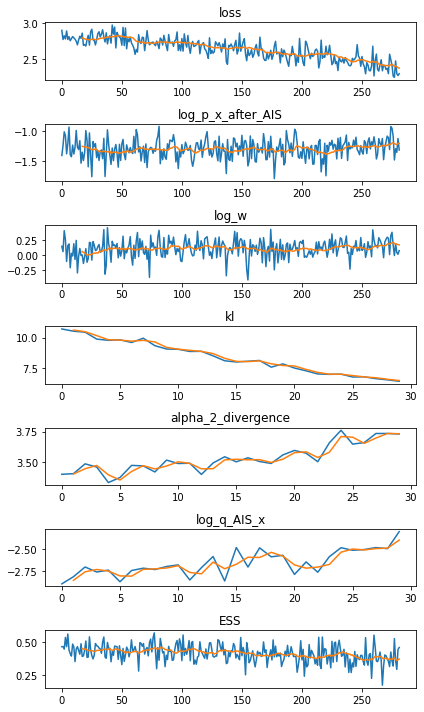

In [32]:
plot_history(history)

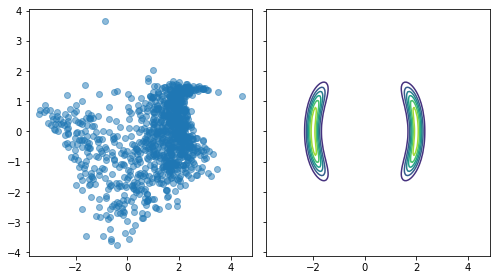

In [33]:
plotter(tester, n_samples=1000)

In [34]:
history = tester.train(10000, batch_size=int(1e2), intermediate_plots=True, n_plots=5, plotting_func=plotter)

  0%|          | 1/10000 [00:00<1:27:44,  1.90it/s]

The value argument must be within the support


  0%|          | 2/10000 [00:02<4:25:12,  1.59s/it]

The value argument must be within the support


  0%|          | 3/10000 [00:03<2:57:33,  1.07s/it]

The value argument must be within the support


  0%|          | 5/10000 [00:04<1:56:06,  1.43it/s]

The value argument must be within the support
The value argument must be within the support


  0%|          | 6/10000 [00:04<1:44:07,  1.60it/s]

The value argument must be within the support


  0%|          | 7/10000 [00:06<2:35:29,  1.07it/s]

The value argument must be within the support


  0%|          | 8/10000 [00:06<2:00:30,  1.38it/s]

The value argument must be within the support


  0%|          | 9/10000 [00:08<2:32:46,  1.09it/s]

The value argument must be within the support


  0%|          | 10/10000 [00:08<2:12:48,  1.25it/s]

The value argument must be within the support


  0%|          | 12/10000 [00:09<1:36:56,  1.72it/s]

The value argument must be within the support
The value argument must be within the support


  0%|          | 13/10000 [00:09<1:12:36,  2.29it/s]

The value argument must be within the support


  0%|          | 14/10000 [00:09<1:12:50,  2.28it/s]

The value argument must be within the support


  0%|          | 15/10000 [00:13<3:23:49,  1.22s/it]

The value argument must be within the support


  0%|          | 16/10000 [00:13<3:04:00,  1.11s/it]

The value argument must be within the support


  0%|          | 17/10000 [00:14<2:26:38,  1.13it/s]

The value argument must be within the support


  0%|          | 18/10000 [00:15<2:25:58,  1.14it/s]

The value argument must be within the support


  0%|          | 20/10000 [00:15<1:42:30,  1.62it/s]

The value argument must be within the support
The value argument must be within the support


  0%|          | 21/10000 [00:16<1:51:54,  1.49it/s]

The value argument must be within the support


  0%|          | 22/10000 [00:17<1:36:10,  1.73it/s]

The value argument must be within the support


  0%|          | 23/10000 [00:17<1:34:21,  1.76it/s]

The value argument must be within the support


  0%|          | 24/10000 [00:18<1:55:58,  1.43it/s]

The value argument must be within the support
The value argument must be within the support


  0%|          | 26/10000 [00:19<1:23:35,  1.99it/s]

The value argument must be within the support


  0%|          | 27/10000 [00:19<1:30:12,  1.84it/s]

The value argument must be within the support


  0%|          | 28/10000 [00:20<1:40:42,  1.65it/s]

The value argument must be within the support


  0%|          | 29/10000 [00:20<1:29:32,  1.86it/s]

The value argument must be within the support


  0%|          | 30/10000 [00:22<2:32:22,  1.09it/s]

The value argument must be within the support


  0%|          | 32/10000 [00:26<3:27:58,  1.25s/it]

The value argument must be within the support
The value argument must be within the support


  0%|          | 34/10000 [00:28<3:03:09,  1.10s/it]

The value argument must be within the support


  0%|          | 35/10000 [00:29<3:20:01,  1.20s/it]

The value argument must be within the support


  0%|          | 36/10000 [00:30<2:43:28,  1.02it/s]

The value argument must be within the support


  0%|          | 37/10000 [00:30<2:26:38,  1.13it/s]

The value argument must be within the support


  0%|          | 38/10000 [00:31<1:57:51,  1.41it/s]

The value argument must be within the support


  0%|          | 39/10000 [00:31<1:48:38,  1.53it/s]

The value argument must be within the support


  0%|          | 41/10000 [00:35<2:59:34,  1.08s/it]

The value argument must be within the support


  0%|          | 42/10000 [00:35<2:40:13,  1.04it/s]

The value argument must be within the support


  0%|          | 43/10000 [00:36<2:18:43,  1.20it/s]

The value argument must be within the support


  0%|          | 44/10000 [00:36<1:50:35,  1.50it/s]

The value argument must be within the support


  0%|          | 45/10000 [00:38<2:34:46,  1.07it/s]

The value argument must be within the support


  0%|          | 46/10000 [00:38<2:06:28,  1.31it/s]

The value argument must be within the support


  0%|          | 48/10000 [00:40<2:04:44,  1.33it/s]

The value argument must be within the support
The value argument must be within the support


  0%|          | 49/10000 [00:41<2:15:37,  1.22it/s]

The value argument must be within the support
The value argument must be within the support


  1%|          | 51/10000 [00:43<2:31:39,  1.09it/s]

The value argument must be within the support


  1%|          | 52/10000 [00:43<2:19:33,  1.19it/s]

The value argument must be within the support


  1%|          | 54/10000 [00:45<1:55:32,  1.43it/s]

The value argument must be within the support
The value argument must be within the support


  1%|          | 55/10000 [00:45<1:51:39,  1.48it/s]

The value argument must be within the support


  1%|          | 56/10000 [00:46<2:16:19,  1.22it/s]

The value argument must be within the support


  1%|          | 57/10000 [00:47<2:00:31,  1.37it/s]

The value argument must be within the support


  1%|          | 58/10000 [00:49<3:28:19,  1.26s/it]

The value argument must be within the support


  1%|          | 59/10000 [00:50<2:44:10,  1.01it/s]

The value argument must be within the support


  1%|          | 60/10000 [00:51<2:41:30,  1.03it/s]

The value argument must be within the support


  1%|          | 61/10000 [00:51<2:17:05,  1.21it/s]

The value argument must be within the support


  1%|          | 62/10000 [00:52<2:11:11,  1.26it/s]

The value argument must be within the support


  1%|          | 63/10000 [00:52<1:45:20,  1.57it/s]

The value argument must be within the support


  1%|          | 64/10000 [00:53<1:53:51,  1.45it/s]

The value argument must be within the support


  1%|          | 65/10000 [00:54<1:59:59,  1.38it/s]

The value argument must be within the support


  1%|          | 66/10000 [00:55<2:40:12,  1.03it/s]

The value argument must be within the support


  1%|          | 67/10000 [00:56<2:09:52,  1.27it/s]

The value argument must be within the support


  1%|          | 68/10000 [00:59<3:51:12,  1.40s/it]

The value argument must be within the support


  1%|          | 69/10000 [01:00<4:08:27,  1.50s/it]

The value argument must be within the support


  1%|          | 70/10000 [01:02<4:25:39,  1.61s/it]

The value argument must be within the support
The value argument must be within the support


  1%|          | 72/10000 [01:03<2:44:49,  1.00it/s]

The value argument must be within the support


  1%|          | 73/10000 [01:04<2:38:59,  1.04it/s]

The value argument must be within the support


  1%|          | 76/10000 [01:09<3:11:40,  1.16s/it]

The value argument must be within the support
The value argument must be within the support


  1%|          | 77/10000 [01:11<4:01:12,  1.46s/it]

The value argument must be within the support


  1%|          | 78/10000 [01:12<3:28:51,  1.26s/it]

The value argument must be within the support


  1%|          | 79/10000 [01:13<3:23:20,  1.23s/it]

The value argument must be within the support


  1%|          | 80/10000 [01:13<2:45:36,  1.00s/it]

The value argument must be within the support


  1%|          | 81/10000 [01:14<2:27:49,  1.12it/s]

The value argument must be within the support


  1%|          | 82/10000 [01:14<2:13:06,  1.24it/s]

The value argument must be within the support


  1%|          | 83/10000 [01:15<1:58:41,  1.39it/s]

The value argument must be within the support


  1%|          | 84/10000 [01:15<1:36:33,  1.71it/s]

The value argument must be within the support


  1%|          | 85/10000 [01:16<2:09:08,  1.28it/s]

The value argument must be within the support
The value argument must be within the support


  1%|          | 87/10000 [01:18<2:05:53,  1.31it/s]

The value argument must be within the support


  1%|          | 88/10000 [01:18<1:45:37,  1.56it/s]

The value argument must be within the support


  1%|          | 89/10000 [01:19<1:40:26,  1.64it/s]

The value argument must be within the support


  1%|          | 91/10000 [01:23<3:07:12,  1.13s/it]

The value argument must be within the support


  1%|          | 92/10000 [01:24<3:22:07,  1.22s/it]

The value argument must be within the support


  1%|          | 93/10000 [01:25<3:17:56,  1.20s/it]

The value argument must be within the support


  1%|          | 94/10000 [01:26<3:08:01,  1.14s/it]

The value argument must be within the support


  1%|          | 96/10000 [01:27<1:50:21,  1.50it/s]

The value argument must be within the support
The value argument must be within the support


  1%|          | 98/10000 [01:27<1:23:38,  1.97it/s]

The value argument must be within the support
The value argument must be within the support


  1%|          | 99/10000 [01:28<1:29:50,  1.84it/s]

The value argument must be within the support


  1%|          | 100/10000 [01:30<2:28:52,  1.11it/s]

The value argument must be within the support


  1%|          | 101/10000 [01:31<2:55:40,  1.06s/it]

The value argument must be within the support


  1%|          | 102/10000 [01:32<2:24:26,  1.14it/s]

The value argument must be within the support


  1%|          | 103/10000 [01:32<1:56:15,  1.42it/s]

The value argument must be within the support


  1%|          | 104/10000 [01:32<1:38:55,  1.67it/s]

The value argument must be within the support


  1%|          | 105/10000 [01:33<1:31:05,  1.81it/s]

The value argument must be within the support
The value argument must be within the support


  1%|          | 107/10000 [01:33<1:12:06,  2.29it/s]

The value argument must be within the support


  1%|          | 108/10000 [01:34<1:37:06,  1.70it/s]

The value argument must be within the support


  1%|          | 109/10000 [01:35<1:32:59,  1.77it/s]

The value argument must be within the support


  1%|          | 110/10000 [01:36<2:01:31,  1.36it/s]

The value argument must be within the support


  1%|          | 111/10000 [01:37<1:48:13,  1.52it/s]

The value argument must be within the support


  1%|          | 112/10000 [01:38<2:23:20,  1.15it/s]

The value argument must be within the support


  1%|          | 113/10000 [01:39<2:45:08,  1.00s/it]

The value argument must be within the support


  1%|          | 114/10000 [01:40<2:17:53,  1.19it/s]

The value argument must be within the support


  1%|          | 115/10000 [01:40<2:09:40,  1.27it/s]

The value argument must be within the support


  1%|          | 116/10000 [01:41<1:55:00,  1.43it/s]

The value argument must be within the support


  1%|          | 117/10000 [01:42<1:55:41,  1.42it/s]

The value argument must be within the support


  1%|          | 118/10000 [01:42<1:47:22,  1.53it/s]

The value argument must be within the support


  1%|          | 119/10000 [01:43<1:37:08,  1.70it/s]

The value argument must be within the support


  1%|          | 121/10000 [01:43<1:15:50,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


  1%|          | 122/10000 [01:43<1:02:21,  2.64it/s]

The value argument must be within the support


  1%|          | 123/10000 [01:45<1:58:56,  1.38it/s]

The value argument must be within the support
The value argument must be within the support


  1%|▏         | 125/10000 [01:46<1:24:35,  1.95it/s]

The value argument must be within the support


  1%|▏         | 126/10000 [01:46<1:14:47,  2.20it/s]

The value argument must be within the support


  1%|▏         | 128/10000 [01:46<1:01:47,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


  1%|▏         | 129/10000 [01:48<1:58:49,  1.38it/s]

The value argument must be within the support


  1%|▏         | 130/10000 [01:49<2:18:41,  1.19it/s]

The value argument must be within the support
The value argument must be within the support


  1%|▏         | 132/10000 [01:50<1:39:39,  1.65it/s]

The value argument must be within the support


  1%|▏         | 133/10000 [01:51<1:57:22,  1.40it/s]

The value argument must be within the support


  1%|▏         | 134/10000 [01:51<1:47:43,  1.53it/s]

The value argument must be within the support


  1%|▏         | 135/10000 [01:52<2:04:57,  1.32it/s]

The value argument must be within the support
The value argument must be within the support


  1%|▏         | 137/10000 [01:53<1:29:50,  1.83it/s]

The value argument must be within the support


  1%|▏         | 139/10000 [01:54<1:18:01,  2.11it/s]

The value argument must be within the support
The value argument must be within the support


  1%|▏         | 140/10000 [01:54<1:26:35,  1.90it/s]

The value argument must be within the support


  1%|▏         | 141/10000 [01:57<2:51:13,  1.04s/it]

The value argument must be within the support


  1%|▏         | 142/10000 [01:57<2:15:30,  1.21it/s]

The value argument must be within the support


  1%|▏         | 144/10000 [01:58<1:31:31,  1.79it/s]

The value argument must be within the support
The value argument must be within the support


  1%|▏         | 145/10000 [01:58<1:13:28,  2.24it/s]

The value argument must be within the support


  1%|▏         | 146/10000 [02:00<2:40:52,  1.02it/s]

The value argument must be within the support


  1%|▏         | 148/10000 [02:01<1:45:08,  1.56it/s]

The value argument must be within the support
The value argument must be within the support


  1%|▏         | 149/10000 [02:02<1:47:59,  1.52it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 151/10000 [02:03<1:47:19,  1.53it/s]

The value argument must be within the support


  2%|▏         | 152/10000 [02:03<1:42:10,  1.61it/s]

The value argument must be within the support


  2%|▏         | 154/10000 [02:05<1:42:05,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 156/10000 [02:05<1:03:32,  2.58it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 157/10000 [02:05<51:34,  3.18it/s]  

The value argument must be within the support


  2%|▏         | 158/10000 [02:06<1:21:23,  2.02it/s]

The value argument must be within the support


  2%|▏         | 159/10000 [02:07<1:54:00,  1.44it/s]

The value argument must be within the support


  2%|▏         | 160/10000 [02:10<3:13:50,  1.18s/it]

The value argument must be within the support


  2%|▏         | 162/10000 [02:13<3:48:33,  1.39s/it]

The value argument must be within the support


  2%|▏         | 163/10000 [02:14<3:20:04,  1.22s/it]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 165/10000 [02:15<2:08:13,  1.28it/s]

The value argument must be within the support


  2%|▏         | 167/10000 [02:16<1:52:22,  1.46it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 168/10000 [02:16<1:41:00,  1.62it/s]

The value argument must be within the support


  2%|▏         | 169/10000 [02:17<1:32:19,  1.77it/s]

The value argument must be within the support


  2%|▏         | 170/10000 [02:18<2:12:42,  1.23it/s]

The value argument must be within the support


  2%|▏         | 171/10000 [02:19<2:16:19,  1.20it/s]

The value argument must be within the support


  2%|▏         | 172/10000 [02:19<1:49:08,  1.50it/s]

The value argument must be within the support


  2%|▏         | 175/10000 [02:20<1:01:39,  2.66it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  2%|▏         | 176/10000 [02:21<1:28:37,  1.85it/s]

The value argument must be within the support


  2%|▏         | 177/10000 [02:23<2:07:45,  1.28it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 179/10000 [02:23<1:38:45,  1.66it/s]

The value argument must be within the support


  2%|▏         | 180/10000 [02:24<1:47:51,  1.52it/s]

The value argument must be within the support


  2%|▏         | 181/10000 [02:25<1:33:43,  1.75it/s]

The value argument must be within the support


  2%|▏         | 182/10000 [02:26<1:59:52,  1.36it/s]

The value argument must be within the support


  2%|▏         | 184/10000 [02:26<1:19:16,  2.06it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 185/10000 [02:26<1:10:48,  2.31it/s]

The value argument must be within the support


  2%|▏         | 186/10000 [02:27<1:05:14,  2.51it/s]

The value argument must be within the support


  2%|▏         | 187/10000 [02:28<1:26:07,  1.90it/s]

The value argument must be within the support


  2%|▏         | 189/10000 [02:28<1:04:19,  2.54it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 190/10000 [02:30<1:55:03,  1.42it/s]

The value argument must be within the support


  2%|▏         | 191/10000 [02:30<1:35:30,  1.71it/s]

The value argument must be within the support


  2%|▏         | 192/10000 [02:30<1:27:51,  1.86it/s]

The value argument must be within the support


  2%|▏         | 193/10000 [02:31<1:18:37,  2.08it/s]

The value argument must be within the support


  2%|▏         | 194/10000 [02:31<1:07:57,  2.40it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 196/10000 [02:34<2:32:45,  1.07it/s]

The value argument must be within the support


  2%|▏         | 197/10000 [02:35<2:23:16,  1.14it/s]

The value argument must be within the support


  2%|▏         | 199/10000 [02:35<1:40:26,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 200/10000 [02:36<1:41:18,  1.61it/s]

The value argument must be within the support


  2%|▏         | 201/10000 [02:36<1:33:06,  1.75it/s]

The value argument must be within the support


  2%|▏         | 202/10000 [02:37<1:36:20,  1.70it/s]

The value argument must be within the support


  2%|▏         | 204/10000 [02:38<1:05:32,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 206/10000 [02:39<1:18:03,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 207/10000 [02:40<1:28:02,  1.85it/s]

The value argument must be within the support


  2%|▏         | 208/10000 [02:41<2:09:01,  1.26it/s]

The value argument must be within the support


  2%|▏         | 209/10000 [02:42<2:08:39,  1.27it/s]

The value argument must be within the support


  2%|▏         | 210/10000 [02:43<2:32:14,  1.07it/s]

The value argument must be within the support


  2%|▏         | 211/10000 [02:45<3:06:16,  1.14s/it]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 213/10000 [02:45<1:55:12,  1.42it/s]

The value argument must be within the support


  2%|▏         | 215/10000 [02:45<1:20:08,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 217/10000 [02:46<1:09:17,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 218/10000 [02:48<1:49:23,  1.49it/s]

The value argument must be within the support


  2%|▏         | 219/10000 [02:48<1:55:48,  1.41it/s]

The value argument must be within the support


  2%|▏         | 220/10000 [02:49<2:02:47,  1.33it/s]

The value argument must be within the support


  2%|▏         | 221/10000 [02:50<2:13:20,  1.22it/s]

The value argument must be within the support


  2%|▏         | 223/10000 [02:52<1:57:37,  1.39it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 225/10000 [02:53<1:41:58,  1.60it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 226/10000 [02:54<1:57:05,  1.39it/s]

The value argument must be within the support


  2%|▏         | 227/10000 [02:54<1:52:35,  1.45it/s]

The value argument must be within the support


  2%|▏         | 228/10000 [02:56<2:18:28,  1.18it/s]

The value argument must be within the support


  2%|▏         | 229/10000 [02:56<2:09:00,  1.26it/s]

The value argument must be within the support


  2%|▏         | 230/10000 [02:57<1:47:33,  1.51it/s]

The value argument must be within the support


  2%|▏         | 232/10000 [02:57<1:17:28,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 234/10000 [02:58<1:06:46,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 235/10000 [02:58<1:07:40,  2.41it/s]

The value argument must be within the support


  2%|▏         | 236/10000 [02:59<1:00:06,  2.71it/s]

The value argument must be within the support


  2%|▏         | 237/10000 [02:59<56:52,  2.86it/s]  

The value argument must be within the support


  2%|▏         | 239/10000 [03:00<52:23,  3.11it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  2%|▏         | 242/10000 [03:00<36:47,  4.42it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▏         | 243/10000 [03:01<48:54,  3.32it/s]

The value argument must be within the support


  2%|▏         | 244/10000 [03:01<47:12,  3.44it/s]

The value argument must be within the support


  2%|▏         | 246/10000 [03:04<2:21:09,  1.15it/s]

The value argument must be within the support


  2%|▏         | 247/10000 [03:05<1:55:38,  1.41it/s]

The value argument must be within the support


  2%|▏         | 248/10000 [03:05<1:47:20,  1.51it/s]

The value argument must be within the support
The value argument must be within the support


  2%|▎         | 250/10000 [03:08<2:24:14,  1.13it/s]

The value argument must be within the support


  3%|▎         | 251/10000 [03:09<2:48:30,  1.04s/it]

The value argument must be within the support


  3%|▎         | 252/10000 [03:11<3:16:27,  1.21s/it]

The value argument must be within the support


  3%|▎         | 253/10000 [03:12<3:06:19,  1.15s/it]

The value argument must be within the support


  3%|▎         | 255/10000 [03:13<2:09:41,  1.25it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 257/10000 [03:13<1:18:58,  2.06it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 258/10000 [03:14<1:25:34,  1.90it/s]

The value argument must be within the support


  3%|▎         | 259/10000 [03:15<2:00:11,  1.35it/s]

The value argument must be within the support


  3%|▎         | 260/10000 [03:15<1:41:26,  1.60it/s]

The value argument must be within the support


  3%|▎         | 261/10000 [03:17<2:30:56,  1.08it/s]

The value argument must be within the support


  3%|▎         | 262/10000 [03:19<3:08:13,  1.16s/it]

The value argument must be within the support


  3%|▎         | 263/10000 [03:20<3:17:50,  1.22s/it]

The value argument must be within the support


  3%|▎         | 264/10000 [03:20<2:32:56,  1.06it/s]

The value argument must be within the support


  3%|▎         | 265/10000 [03:21<2:02:57,  1.32it/s]

The value argument must be within the support


  3%|▎         | 266/10000 [03:21<1:39:36,  1.63it/s]

The value argument must be within the support


  3%|▎         | 267/10000 [03:22<1:52:39,  1.44it/s]

The value argument must be within the support


  3%|▎         | 268/10000 [03:23<2:00:02,  1.35it/s]

The value argument must be within the support


  3%|▎         | 269/10000 [03:23<1:39:24,  1.63it/s]

The value argument must be within the support


  3%|▎         | 270/10000 [03:24<1:40:12,  1.62it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 272/10000 [03:24<1:07:53,  2.39it/s]

The value argument must be within the support


  3%|▎         | 273/10000 [03:25<1:39:01,  1.64it/s]

The value argument must be within the support


  3%|▎         | 274/10000 [03:28<3:09:27,  1.17s/it]

The value argument must be within the support


  3%|▎         | 275/10000 [03:29<2:52:26,  1.06s/it]

The value argument must be within the support


  3%|▎         | 276/10000 [03:30<2:39:43,  1.01it/s]

The value argument must be within the support


  3%|▎         | 277/10000 [03:31<3:10:06,  1.17s/it]

The value argument must be within the support


  3%|▎         | 278/10000 [03:32<3:00:27,  1.11s/it]

The value argument must be within the support


  3%|▎         | 279/10000 [03:33<2:46:02,  1.02s/it]

The value argument must be within the support


  3%|▎         | 280/10000 [03:34<2:47:01,  1.03s/it]

The value argument must be within the support


  3%|▎         | 281/10000 [03:35<2:21:09,  1.15it/s]

The value argument must be within the support


  3%|▎         | 282/10000 [03:35<1:52:16,  1.44it/s]

The value argument must be within the support


  3%|▎         | 283/10000 [03:35<1:49:10,  1.48it/s]

The value argument must be within the support


  3%|▎         | 284/10000 [03:36<1:46:02,  1.53it/s]

The value argument must be within the support


  3%|▎         | 285/10000 [03:38<3:07:36,  1.16s/it]

The value argument must be within the support


  3%|▎         | 286/10000 [03:39<2:41:36,  1.00it/s]

The value argument must be within the support


  3%|▎         | 288/10000 [03:40<1:48:41,  1.49it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 289/10000 [03:41<2:36:24,  1.03it/s]

The value argument must be within the support


  3%|▎         | 291/10000 [03:46<4:13:42,  1.57s/it]

The value argument must be within the support


  3%|▎         | 292/10000 [03:48<4:12:37,  1.56s/it]

The value argument must be within the support


  3%|▎         | 294/10000 [03:49<2:40:03,  1.01it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 295/10000 [03:49<2:14:23,  1.20it/s]

The value argument must be within the support


  3%|▎         | 296/10000 [03:50<2:05:36,  1.29it/s]

The value argument must be within the support


  3%|▎         | 297/10000 [03:50<1:45:09,  1.54it/s]

The value argument must be within the support


  3%|▎         | 298/10000 [03:51<2:08:34,  1.26it/s]

The value argument must be within the support


  3%|▎         | 299/10000 [03:54<3:50:05,  1.42s/it]

The value argument must be within the support


  3%|▎         | 301/10000 [03:55<2:38:08,  1.02it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 302/10000 [03:56<2:20:00,  1.15it/s]

The value argument must be within the support


  3%|▎         | 303/10000 [03:56<1:52:57,  1.43it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 305/10000 [03:58<1:56:30,  1.39it/s]

The value argument must be within the support


  3%|▎         | 306/10000 [03:59<2:19:43,  1.16it/s]

The value argument must be within the support


  3%|▎         | 307/10000 [04:00<2:24:56,  1.11it/s]

The value argument must be within the support


  3%|▎         | 308/10000 [04:00<1:58:31,  1.36it/s]

The value argument must be within the support


  3%|▎         | 309/10000 [04:02<2:48:16,  1.04s/it]

The value argument must be within the support


  3%|▎         | 310/10000 [04:03<2:48:28,  1.04s/it]

The value argument must be within the support


  3%|▎         | 311/10000 [04:05<3:20:52,  1.24s/it]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 313/10000 [04:06<2:11:55,  1.22it/s]

The value argument must be within the support


  3%|▎         | 315/10000 [04:06<1:38:10,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 317/10000 [04:07<1:09:20,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 318/10000 [04:07<1:03:29,  2.54it/s]

The value argument must be within the support


  3%|▎         | 319/10000 [04:08<1:20:31,  2.00it/s]

The value argument must be within the support


  3%|▎         | 320/10000 [04:08<1:17:17,  2.09it/s]

The value argument must be within the support


  3%|▎         | 321/10000 [04:09<1:15:01,  2.15it/s]

The value argument must be within the support


  3%|▎         | 322/10000 [04:09<1:09:33,  2.32it/s]

The value argument must be within the support


  3%|▎         | 323/10000 [04:09<1:03:42,  2.53it/s]

The value argument must be within the support


  3%|▎         | 324/10000 [04:10<1:21:38,  1.98it/s]

The value argument must be within the support


  3%|▎         | 325/10000 [04:11<1:51:50,  1.44it/s]

The value argument must be within the support


  3%|▎         | 326/10000 [04:13<2:31:23,  1.07it/s]

The value argument must be within the support


  3%|▎         | 327/10000 [04:14<2:17:32,  1.17it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 329/10000 [04:14<1:28:19,  1.83it/s]

The value argument must be within the support


  3%|▎         | 331/10000 [04:14<1:07:28,  2.39it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 332/10000 [04:15<56:24,  2.86it/s]  

The value argument must be within the support


  3%|▎         | 333/10000 [04:15<55:41,  2.89it/s]

The value argument must be within the support


  3%|▎         | 334/10000 [04:15<54:17,  2.97it/s]

The value argument must be within the support


  3%|▎         | 335/10000 [04:16<1:18:55,  2.04it/s]

The value argument must be within the support


  3%|▎         | 336/10000 [04:18<2:20:28,  1.15it/s]

The value argument must be within the support


  3%|▎         | 337/10000 [04:20<2:56:23,  1.10s/it]

The value argument must be within the support


  3%|▎         | 338/10000 [04:22<3:50:55,  1.43s/it]

The value argument must be within the support


  3%|▎         | 340/10000 [04:22<2:09:22,  1.24it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 342/10000 [04:22<1:14:43,  2.15it/s]

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 343/10000 [04:23<1:12:47,  2.21it/s]

The value argument must be within the support


  3%|▎         | 344/10000 [04:23<1:08:49,  2.34it/s]

The value argument must be within the support


  3%|▎         | 345/10000 [04:24<1:08:34,  2.35it/s]

The value argument must be within the support


  3%|▎         | 347/10000 [04:24<50:27,  3.19it/s]  

The value argument must be within the support
The value argument must be within the support


  3%|▎         | 348/10000 [04:26<1:53:42,  1.41it/s]

The value argument must be within the support


  4%|▎         | 350/10000 [04:30<3:26:50,  1.29s/it]

The value argument must be within the support


  4%|▎         | 351/10000 [04:30<2:40:21,  1.00it/s]

The value argument must be within the support


  4%|▎         | 352/10000 [04:31<2:27:45,  1.09it/s]

The value argument must be within the support


  4%|▎         | 353/10000 [04:31<2:01:31,  1.32it/s]

The value argument must be within the support


  4%|▎         | 354/10000 [04:32<1:35:36,  1.68it/s]

The value argument must be within the support


  4%|▎         | 355/10000 [04:33<2:24:15,  1.11it/s]

The value argument must be within the support


  4%|▎         | 357/10000 [04:34<1:50:24,  1.46it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▎         | 358/10000 [04:36<3:02:17,  1.13s/it]

The value argument must be within the support


  4%|▎         | 359/10000 [04:37<2:41:42,  1.01s/it]

The value argument must be within the support


  4%|▎         | 360/10000 [04:38<2:33:21,  1.05it/s]

The value argument must be within the support


  4%|▎         | 361/10000 [04:41<3:48:54,  1.42s/it]

The value argument must be within the support


  4%|▎         | 362/10000 [04:41<2:57:31,  1.11s/it]

The value argument must be within the support


  4%|▎         | 364/10000 [04:44<3:30:08,  1.31s/it]

The value argument must be within the support


  4%|▎         | 365/10000 [04:45<2:42:23,  1.01s/it]

The value argument must be within the support


  4%|▎         | 366/10000 [04:45<2:28:06,  1.08it/s]

The value argument must be within the support


  4%|▎         | 367/10000 [04:46<2:15:47,  1.18it/s]

The value argument must be within the support


  4%|▎         | 368/10000 [04:47<2:09:17,  1.24it/s]

The value argument must be within the support


  4%|▎         | 369/10000 [04:48<2:36:44,  1.02it/s]

The value argument must be within the support


  4%|▎         | 371/10000 [04:50<2:06:37,  1.27it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▎         | 373/10000 [04:54<3:26:57,  1.29s/it]

The value argument must be within the support


  4%|▍         | 375/10000 [04:54<1:58:47,  1.35it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 376/10000 [04:55<1:46:44,  1.50it/s]

The value argument must be within the support


  4%|▍         | 377/10000 [04:55<1:25:28,  1.88it/s]

The value argument must be within the support


  4%|▍         | 378/10000 [04:55<1:29:38,  1.79it/s]

The value argument must be within the support


  4%|▍         | 379/10000 [04:56<1:19:50,  2.01it/s]

The value argument must be within the support


  4%|▍         | 380/10000 [04:56<1:11:26,  2.24it/s]

The value argument must be within the support


  4%|▍         | 381/10000 [04:58<2:00:28,  1.33it/s]

The value argument must be within the support


  4%|▍         | 383/10000 [04:59<1:37:05,  1.65it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 384/10000 [04:59<1:40:04,  1.60it/s]

The value argument must be within the support


  4%|▍         | 385/10000 [05:00<1:31:19,  1.75it/s]

The value argument must be within the support


  4%|▍         | 386/10000 [05:00<1:18:45,  2.03it/s]

The value argument must be within the support


  4%|▍         | 387/10000 [05:00<1:09:01,  2.32it/s]

The value argument must be within the support


  4%|▍         | 388/10000 [05:02<1:55:17,  1.39it/s]

The value argument must be within the support


  4%|▍         | 389/10000 [05:02<1:51:18,  1.44it/s]

The value argument must be within the support


  4%|▍         | 390/10000 [05:03<1:53:15,  1.41it/s]

The value argument must be within the support


  4%|▍         | 391/10000 [05:04<1:49:56,  1.46it/s]

The value argument must be within the support


  4%|▍         | 392/10000 [05:04<1:39:02,  1.62it/s]

The value argument must be within the support


  4%|▍         | 393/10000 [05:05<2:01:06,  1.32it/s]

The value argument must be within the support


  4%|▍         | 394/10000 [05:06<1:45:03,  1.52it/s]

The value argument must be within the support


  4%|▍         | 395/10000 [05:07<2:07:25,  1.26it/s]

The value argument must be within the support


  4%|▍         | 396/10000 [05:08<2:10:19,  1.23it/s]

The value argument must be within the support


  4%|▍         | 397/10000 [05:10<3:44:28,  1.40s/it]

The value argument must be within the support


  4%|▍         | 398/10000 [05:11<3:09:53,  1.19s/it]

The value argument must be within the support


  4%|▍         | 400/10000 [05:12<2:04:45,  1.28it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 401/10000 [05:13<2:20:06,  1.14it/s]

The value argument must be within the support


  4%|▍         | 403/10000 [05:14<1:43:58,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 404/10000 [05:15<1:33:18,  1.71it/s]

The value argument must be within the support


  4%|▍         | 405/10000 [05:15<1:40:45,  1.59it/s]

The value argument must be within the support


  4%|▍         | 406/10000 [05:16<1:45:59,  1.51it/s]

The value argument must be within the support


  4%|▍         | 407/10000 [05:17<1:55:37,  1.38it/s]

The value argument must be within the support


  4%|▍         | 408/10000 [05:17<1:44:39,  1.53it/s]

The value argument must be within the support


  4%|▍         | 409/10000 [05:18<2:01:28,  1.32it/s]

The value argument must be within the support


  4%|▍         | 411/10000 [05:19<1:39:36,  1.60it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 412/10000 [05:21<1:58:49,  1.34it/s]

The value argument must be within the support


  4%|▍         | 413/10000 [05:21<1:47:45,  1.48it/s]

The value argument must be within the support


  4%|▍         | 414/10000 [05:23<2:35:58,  1.02it/s]

The value argument must be within the support


  4%|▍         | 416/10000 [05:23<1:39:01,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 417/10000 [05:23<1:16:17,  2.09it/s]

The value argument must be within the support


  4%|▍         | 418/10000 [05:24<1:14:52,  2.13it/s]

The value argument must be within the support


  4%|▍         | 419/10000 [05:24<1:05:28,  2.44it/s]

The value argument must be within the support


  4%|▍         | 421/10000 [05:26<1:28:55,  1.80it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 423/10000 [05:27<1:29:27,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 424/10000 [05:28<1:24:08,  1.90it/s]

The value argument must be within the support


  4%|▍         | 426/10000 [05:29<1:17:18,  2.06it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 427/10000 [05:29<1:02:47,  2.54it/s]

The value argument must be within the support


  4%|▍         | 428/10000 [05:30<1:56:27,  1.37it/s]

The value argument must be within the support


  4%|▍         | 429/10000 [05:31<1:34:27,  1.69it/s]

The value argument must be within the support


  4%|▍         | 430/10000 [05:33<2:47:30,  1.05s/it]

The value argument must be within the support


  4%|▍         | 431/10000 [05:34<2:56:20,  1.11s/it]

The value argument must be within the support


  4%|▍         | 433/10000 [05:34<1:43:48,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 434/10000 [05:35<1:44:20,  1.53it/s]

The value argument must be within the support


  4%|▍         | 436/10000 [05:36<1:23:17,  1.91it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 437/10000 [05:36<1:06:59,  2.38it/s]

The value argument must be within the support


  4%|▍         | 439/10000 [05:37<1:01:15,  2.60it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 441/10000 [05:38<1:14:32,  2.14it/s]

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 443/10000 [05:39<52:13,  3.05it/s]  

The value argument must be within the support
The value argument must be within the support


  4%|▍         | 444/10000 [05:39<1:10:07,  2.27it/s]

The value argument must be within the support


  4%|▍         | 445/10000 [05:41<1:56:43,  1.36it/s]

The value argument must be within the support


  4%|▍         | 446/10000 [05:41<1:38:55,  1.61it/s]

The value argument must be within the support


  4%|▍         | 447/10000 [05:42<1:38:51,  1.61it/s]

The value argument must be within the support


  4%|▍         | 448/10000 [05:42<1:30:46,  1.75it/s]

The value argument must be within the support


  4%|▍         | 449/10000 [05:42<1:20:34,  1.98it/s]

The value argument must be within the support


  4%|▍         | 450/10000 [05:45<2:40:27,  1.01s/it]

The value argument must be within the support


  5%|▍         | 451/10000 [05:45<2:13:55,  1.19it/s]

The value argument must be within the support


  5%|▍         | 452/10000 [05:46<1:58:48,  1.34it/s]

The value argument must be within the support


  5%|▍         | 453/10000 [05:48<3:15:34,  1.23s/it]

The value argument must be within the support


  5%|▍         | 455/10000 [05:48<1:53:34,  1.40it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 456/10000 [05:49<1:45:07,  1.51it/s]

The value argument must be within the support


  5%|▍         | 457/10000 [05:49<1:26:25,  1.84it/s]

The value argument must be within the support


  5%|▍         | 459/10000 [05:51<1:37:45,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 460/10000 [05:51<1:17:15,  2.06it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 462/10000 [05:51<50:12,  3.17it/s]  

The value argument must be within the support


  5%|▍         | 463/10000 [05:52<48:21,  3.29it/s]

The value argument must be within the support


  5%|▍         | 465/10000 [05:53<1:09:31,  2.29it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 466/10000 [05:53<58:10,  2.73it/s]  

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 468/10000 [05:55<1:52:07,  1.42it/s]

The value argument must be within the support


  5%|▍         | 469/10000 [05:56<1:38:43,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 471/10000 [05:56<1:22:43,  1.92it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 474/10000 [05:57<54:01,  2.94it/s]  

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 476/10000 [05:57<47:53,  3.31it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 478/10000 [05:58<37:20,  4.25it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  5%|▍         | 480/10000 [06:00<1:34:34,  1.68it/s]

The value argument must be within the support


  5%|▍         | 481/10000 [06:00<1:22:18,  1.93it/s]

The value argument must be within the support


  5%|▍         | 482/10000 [06:00<1:13:57,  2.14it/s]

The value argument must be within the support


  5%|▍         | 483/10000 [06:01<1:07:30,  2.35it/s]

The value argument must be within the support


  5%|▍         | 484/10000 [06:01<1:00:34,  2.62it/s]

The value argument must be within the support


  5%|▍         | 485/10000 [06:01<1:03:14,  2.51it/s]

The value argument must be within the support


  5%|▍         | 487/10000 [06:02<1:03:28,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 488/10000 [06:03<59:29,  2.66it/s]  

The value argument must be within the support


  5%|▍         | 490/10000 [06:03<46:13,  3.43it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▍         | 491/10000 [06:04<1:11:41,  2.21it/s]

The value argument must be within the support


  5%|▍         | 492/10000 [06:06<2:02:36,  1.29it/s]

The value argument must be within the support


  5%|▍         | 493/10000 [06:08<3:03:47,  1.16s/it]

The value argument must be within the support


  5%|▍         | 494/10000 [06:08<2:21:58,  1.12it/s]

The value argument must be within the support


  5%|▍         | 495/10000 [06:08<1:54:38,  1.38it/s]

The value argument must be within the support


  5%|▍         | 496/10000 [06:09<1:49:46,  1.44it/s]

The value argument must be within the support


  5%|▍         | 497/10000 [06:09<1:29:48,  1.76it/s]

The value argument must be within the support


  5%|▍         | 498/10000 [06:10<1:26:04,  1.84it/s]

The value argument must be within the support


  5%|▍         | 499/10000 [06:10<1:15:11,  2.11it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 502/10000 [06:11<1:08:02,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 504/10000 [06:11<47:38,  3.32it/s]  

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 505/10000 [06:12<1:06:54,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 507/10000 [06:13<52:14,  3.03it/s]  

The value argument must be within the support


  5%|▌         | 510/10000 [06:16<1:40:21,  1.58it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 512/10000 [06:17<1:18:21,  2.02it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 515/10000 [06:18<1:13:15,  2.16it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  5%|▌         | 516/10000 [06:18<1:03:03,  2.51it/s]

The value argument must be within the support


  5%|▌         | 518/10000 [06:19<49:45,  3.18it/s]  

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 519/10000 [06:20<1:09:44,  2.27it/s]

The value argument must be within the support


  5%|▌         | 520/10000 [06:21<2:09:32,  1.22it/s]

The value argument must be within the support


  5%|▌         | 521/10000 [06:22<1:44:35,  1.51it/s]

The value argument must be within the support


  5%|▌         | 522/10000 [06:22<1:42:25,  1.54it/s]

The value argument must be within the support


  5%|▌         | 523/10000 [06:23<1:50:48,  1.43it/s]

The value argument must be within the support


  5%|▌         | 524/10000 [06:24<1:58:36,  1.33it/s]

The value argument must be within the support


  5%|▌         | 525/10000 [06:24<1:36:14,  1.64it/s]

The value argument must be within the support


  5%|▌         | 526/10000 [06:25<1:53:26,  1.39it/s]

The value argument must be within the support


  5%|▌         | 527/10000 [06:26<1:36:26,  1.64it/s]

The value argument must be within the support


  5%|▌         | 528/10000 [06:26<1:38:41,  1.60it/s]

The value argument must be within the support


  5%|▌         | 529/10000 [06:28<2:46:02,  1.05s/it]

The value argument must be within the support


  5%|▌         | 531/10000 [06:29<1:38:34,  1.60it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 533/10000 [06:29<59:21,  2.66it/s]  

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 535/10000 [06:30<53:16,  2.96it/s]  

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 536/10000 [06:30<43:48,  3.60it/s]

The value argument must be within the support


  5%|▌         | 538/10000 [06:31<1:07:27,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 540/10000 [06:32<59:23,  2.65it/s]  

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 541/10000 [06:33<1:15:11,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


  5%|▌         | 543/10000 [06:33<1:01:44,  2.55it/s]

The value argument must be within the support


  5%|▌         | 544/10000 [06:34<57:05,  2.76it/s]  

The value argument must be within the support


  5%|▌         | 545/10000 [06:35<1:35:55,  1.64it/s]

The value argument must be within the support


  5%|▌         | 546/10000 [06:35<1:25:16,  1.85it/s]

The value argument must be within the support


  5%|▌         | 547/10000 [06:37<2:10:21,  1.21it/s]

The value argument must be within the support


  5%|▌         | 548/10000 [06:37<1:45:10,  1.50it/s]

The value argument must be within the support


  5%|▌         | 549/10000 [06:37<1:34:44,  1.66it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 551/10000 [06:38<1:12:47,  2.16it/s]

The value argument must be within the support


  6%|▌         | 552/10000 [06:39<1:41:39,  1.55it/s]

The value argument must be within the support


  6%|▌         | 553/10000 [06:40<1:29:59,  1.75it/s]

The value argument must be within the support


  6%|▌         | 554/10000 [06:40<1:20:53,  1.95it/s]

The value argument must be within the support


  6%|▌         | 555/10000 [06:41<1:25:14,  1.85it/s]

The value argument must be within the support


  6%|▌         | 556/10000 [06:42<1:59:31,  1.32it/s]

The value argument must be within the support


  6%|▌         | 557/10000 [06:42<1:47:14,  1.47it/s]

The value argument must be within the support


  6%|▌         | 559/10000 [06:43<1:23:34,  1.88it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 560/10000 [06:44<1:13:24,  2.14it/s]

The value argument must be within the support


  6%|▌         | 561/10000 [06:44<1:24:54,  1.85it/s]

The value argument must be within the support


  6%|▌         | 563/10000 [06:45<1:20:04,  1.96it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 564/10000 [06:46<1:02:38,  2.51it/s]

The value argument must be within the support


  6%|▌         | 565/10000 [06:47<1:39:12,  1.59it/s]

The value argument must be within the support


  6%|▌         | 568/10000 [06:50<2:08:30,  1.22it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 570/10000 [06:50<1:21:02,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 571/10000 [06:51<1:34:39,  1.66it/s]

The value argument must be within the support


  6%|▌         | 572/10000 [06:53<2:22:41,  1.10it/s]

The value argument must be within the support


  6%|▌         | 573/10000 [06:55<2:58:51,  1.14s/it]

The value argument must be within the support


  6%|▌         | 574/10000 [06:55<2:42:56,  1.04s/it]

The value argument must be within the support


  6%|▌         | 575/10000 [06:56<2:07:31,  1.23it/s]

The value argument must be within the support


  6%|▌         | 576/10000 [06:57<2:38:00,  1.01s/it]

The value argument must be within the support


  6%|▌         | 577/10000 [06:58<2:15:05,  1.16it/s]

The value argument must be within the support


  6%|▌         | 578/10000 [06:58<1:59:53,  1.31it/s]

The value argument must be within the support


  6%|▌         | 580/10000 [07:00<1:50:29,  1.42it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 581/10000 [07:01<1:58:08,  1.33it/s]

The value argument must be within the support


  6%|▌         | 582/10000 [07:02<2:07:47,  1.23it/s]

The value argument must be within the support


  6%|▌         | 584/10000 [07:02<1:25:34,  1.83it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 585/10000 [07:03<1:39:17,  1.58it/s]

The value argument must be within the support


  6%|▌         | 587/10000 [07:04<1:35:37,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 588/10000 [07:05<1:13:32,  2.13it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 590/10000 [07:05<1:00:37,  2.59it/s]

The value argument must be within the support


  6%|▌         | 592/10000 [07:06<59:03,  2.66it/s]  

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 593/10000 [07:07<1:18:50,  1.99it/s]

The value argument must be within the support


  6%|▌         | 594/10000 [07:09<2:27:28,  1.06it/s]

The value argument must be within the support


  6%|▌         | 595/10000 [07:11<2:59:22,  1.14s/it]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 597/10000 [07:11<1:57:58,  1.33it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 599/10000 [07:11<1:23:01,  1.89it/s]

The value argument must be within the support


  6%|▌         | 600/10000 [07:12<1:34:55,  1.65it/s]

The value argument must be within the support


  6%|▌         | 601/10000 [07:13<1:49:50,  1.43it/s]

The value argument must be within the support


  6%|▌         | 602/10000 [07:14<2:07:51,  1.23it/s]

The value argument must be within the support


  6%|▌         | 603/10000 [07:15<1:44:51,  1.49it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 605/10000 [07:15<1:25:13,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 607/10000 [07:16<59:48,  2.62it/s]  

The value argument must be within the support


  6%|▌         | 610/10000 [07:20<1:56:51,  1.34it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 611/10000 [07:20<1:44:09,  1.50it/s]

The value argument must be within the support


  6%|▌         | 612/10000 [07:21<1:56:20,  1.34it/s]

The value argument must be within the support


  6%|▌         | 613/10000 [07:22<1:37:16,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 616/10000 [07:23<1:24:24,  1.85it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▌         | 617/10000 [07:23<1:13:26,  2.13it/s]

The value argument must be within the support


  6%|▌         | 618/10000 [07:25<1:57:17,  1.33it/s]

The value argument must be within the support


  6%|▌         | 619/10000 [07:25<1:38:26,  1.59it/s]

The value argument must be within the support


  6%|▌         | 620/10000 [07:27<2:41:41,  1.03s/it]

The value argument must be within the support


  6%|▌         | 621/10000 [07:28<2:20:27,  1.11it/s]

The value argument must be within the support


  6%|▌         | 623/10000 [07:28<1:29:43,  1.74it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▋         | 625/10000 [07:29<1:02:51,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▋         | 627/10000 [07:30<54:59,  2.84it/s]  

The value argument must be within the support
The value argument must be within the support


  6%|▋         | 628/10000 [07:30<51:11,  3.05it/s]

The value argument must be within the support


  6%|▋         | 629/10000 [07:30<50:30,  3.09it/s]

The value argument must be within the support


  6%|▋         | 630/10000 [07:30<47:56,  3.26it/s]

The value argument must be within the support


  6%|▋         | 631/10000 [07:31<1:12:45,  2.15it/s]

The value argument must be within the support


  6%|▋         | 632/10000 [07:32<1:36:17,  1.62it/s]

The value argument must be within the support


  6%|▋         | 633/10000 [07:33<1:22:18,  1.90it/s]

The value argument must be within the support


  6%|▋         | 634/10000 [07:34<2:02:54,  1.27it/s]

The value argument must be within the support


  6%|▋         | 635/10000 [07:34<1:50:31,  1.41it/s]

The value argument must be within the support


  6%|▋         | 636/10000 [07:35<1:52:08,  1.39it/s]

The value argument must be within the support


  6%|▋         | 637/10000 [07:36<1:55:44,  1.35it/s]

The value argument must be within the support


  6%|▋         | 638/10000 [07:39<3:45:15,  1.44s/it]

The value argument must be within the support


  6%|▋         | 639/10000 [07:39<2:52:29,  1.11s/it]

The value argument must be within the support


  6%|▋         | 640/10000 [07:40<2:17:30,  1.13it/s]

The value argument must be within the support


  6%|▋         | 641/10000 [07:40<1:53:04,  1.38it/s]

The value argument must be within the support


  6%|▋         | 643/10000 [07:41<1:12:21,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


  6%|▋         | 645/10000 [07:41<48:59,  3.18it/s]  

The value argument must be within the support
The value argument must be within the support


  6%|▋         | 646/10000 [07:41<48:59,  3.18it/s]

The value argument must be within the support


  6%|▋         | 647/10000 [07:43<1:45:27,  1.48it/s]

The value argument must be within the support


  6%|▋         | 649/10000 [07:44<1:21:42,  1.91it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  7%|▋         | 652/10000 [07:45<59:26,  2.62it/s]  

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 653/10000 [07:45<58:41,  2.65it/s]

The value argument must be within the support


  7%|▋         | 654/10000 [07:45<1:00:16,  2.58it/s]

The value argument must be within the support


  7%|▋         | 655/10000 [07:46<1:02:55,  2.48it/s]

The value argument must be within the support


  7%|▋         | 656/10000 [07:46<1:00:58,  2.55it/s]

The value argument must be within the support


  7%|▋         | 657/10000 [07:47<1:30:22,  1.72it/s]

The value argument must be within the support


  7%|▋         | 658/10000 [07:48<1:36:31,  1.61it/s]

The value argument must be within the support


  7%|▋         | 659/10000 [07:48<1:20:32,  1.93it/s]

The value argument must be within the support


  7%|▋         | 660/10000 [07:48<1:09:03,  2.25it/s]

The value argument must be within the support


  7%|▋         | 662/10000 [07:50<1:14:27,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 663/10000 [07:50<1:32:34,  1.68it/s]

The value argument must be within the support


  7%|▋         | 664/10000 [07:52<2:21:23,  1.10it/s]

The value argument must be within the support


  7%|▋         | 665/10000 [07:53<1:59:53,  1.30it/s]

The value argument must be within the support


  7%|▋         | 666/10000 [07:53<1:46:19,  1.46it/s]

The value argument must be within the support


  7%|▋         | 667/10000 [07:53<1:28:55,  1.75it/s]

The value argument must be within the support


  7%|▋         | 668/10000 [07:54<1:24:52,  1.83it/s]

The value argument must be within the support


  7%|▋         | 669/10000 [07:55<1:53:29,  1.37it/s]

The value argument must be within the support


  7%|▋         | 671/10000 [07:56<1:27:44,  1.77it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 672/10000 [07:57<1:31:52,  1.69it/s]

The value argument must be within the support


  7%|▋         | 673/10000 [07:57<1:28:49,  1.75it/s]

The value argument must be within the support


  7%|▋         | 675/10000 [07:58<1:09:07,  2.25it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 676/10000 [07:58<1:01:01,  2.55it/s]

The value argument must be within the support


  7%|▋         | 678/10000 [07:59<1:06:55,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 679/10000 [07:59<1:01:17,  2.53it/s]

The value argument must be within the support


  7%|▋         | 680/10000 [08:01<1:39:04,  1.57it/s]

The value argument must be within the support


  7%|▋         | 682/10000 [08:01<1:14:17,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 683/10000 [08:02<1:22:47,  1.88it/s]

The value argument must be within the support


  7%|▋         | 684/10000 [08:03<1:54:24,  1.36it/s]

The value argument must be within the support


  7%|▋         | 685/10000 [08:04<1:34:47,  1.64it/s]

The value argument must be within the support


  7%|▋         | 686/10000 [08:04<1:48:02,  1.44it/s]

The value argument must be within the support


  7%|▋         | 687/10000 [08:05<1:36:16,  1.61it/s]

The value argument must be within the support


  7%|▋         | 688/10000 [08:05<1:19:47,  1.95it/s]

The value argument must be within the support


  7%|▋         | 689/10000 [08:06<1:24:09,  1.84it/s]

The value argument must be within the support


  7%|▋         | 690/10000 [08:07<1:37:33,  1.59it/s]

The value argument must be within the support


  7%|▋         | 692/10000 [08:07<1:19:06,  1.96it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 693/10000 [08:08<1:01:58,  2.50it/s]

The value argument must be within the support


  7%|▋         | 695/10000 [08:08<59:18,  2.61it/s]  

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 696/10000 [08:09<50:02,  3.10it/s]

The value argument must be within the support


  7%|▋         | 697/10000 [08:10<1:27:51,  1.76it/s]

The value argument must be within the support


  7%|▋         | 699/10000 [08:10<59:44,  2.59it/s]  

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 700/10000 [08:11<1:22:25,  1.88it/s]

The value argument must be within the support


  7%|▋         | 701/10000 [08:12<1:25:49,  1.81it/s]

The value argument must be within the support


  7%|▋         | 702/10000 [08:12<1:17:01,  2.01it/s]

The value argument must be within the support


  7%|▋         | 703/10000 [08:13<1:18:28,  1.97it/s]

The value argument must be within the support


  7%|▋         | 704/10000 [08:13<1:11:21,  2.17it/s]

The value argument must be within the support


  7%|▋         | 705/10000 [08:13<1:04:19,  2.41it/s]

The value argument must be within the support


  7%|▋         | 706/10000 [08:14<1:25:15,  1.82it/s]

The value argument must be within the support


  7%|▋         | 708/10000 [08:15<1:04:48,  2.39it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 709/10000 [08:15<1:15:44,  2.04it/s]

The value argument must be within the support


  7%|▋         | 711/10000 [08:17<1:24:06,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 712/10000 [08:17<1:21:21,  1.90it/s]

The value argument must be within the support


  7%|▋         | 713/10000 [08:18<1:17:27,  2.00it/s]

The value argument must be within the support


  7%|▋         | 714/10000 [08:18<1:22:32,  1.87it/s]

The value argument must be within the support


  7%|▋         | 715/10000 [08:19<1:20:07,  1.93it/s]

The value argument must be within the support


  7%|▋         | 717/10000 [08:20<1:06:37,  2.32it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  7%|▋         | 719/10000 [08:20<42:40,  3.62it/s]  

The value argument must be within the support


  7%|▋         | 720/10000 [08:20<49:00,  3.16it/s]

The value argument must be within the support


  7%|▋         | 722/10000 [08:21<49:24,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 724/10000 [08:23<1:38:07,  1.58it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 725/10000 [08:23<1:15:53,  2.04it/s]

The value argument must be within the support


  7%|▋         | 726/10000 [08:24<1:13:44,  2.10it/s]

The value argument must be within the support


  7%|▋         | 727/10000 [08:24<1:22:00,  1.88it/s]

The value argument must be within the support


  7%|▋         | 730/10000 [08:25<53:17,  2.90it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  7%|▋         | 732/10000 [08:26<52:56,  2.92it/s]  

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 733/10000 [08:27<1:18:50,  1.96it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 736/10000 [08:28<1:04:27,  2.40it/s]

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 738/10000 [08:28<44:23,  3.48it/s]  

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 740/10000 [08:29<56:24,  2.74it/s]  

The value argument must be within the support
The value argument must be within the support


  7%|▋         | 742/10000 [08:30<53:40,  2.87it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  7%|▋         | 744/10000 [08:31<42:41,  3.61it/s]

The value argument must be within the support


  7%|▋         | 745/10000 [08:31<48:47,  3.16it/s]

The value argument must be within the support


  7%|▋         | 746/10000 [08:32<1:15:44,  2.04it/s]

The value argument must be within the support


  7%|▋         | 747/10000 [08:35<2:52:24,  1.12s/it]

The value argument must be within the support


  7%|▋         | 748/10000 [08:35<2:32:40,  1.01it/s]

The value argument must be within the support


  7%|▋         | 749/10000 [08:36<2:01:09,  1.27it/s]

The value argument must be within the support


  8%|▊         | 750/10000 [08:37<2:04:56,  1.23it/s]

The value argument must be within the support


  8%|▊         | 752/10000 [08:37<1:26:23,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 754/10000 [08:38<1:19:44,  1.93it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 755/10000 [08:39<1:10:11,  2.20it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 757/10000 [08:39<1:02:56,  2.45it/s]

The value argument must be within the support


  8%|▊         | 759/10000 [08:40<1:05:13,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 760/10000 [08:42<1:53:21,  1.36it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 762/10000 [08:42<1:16:06,  2.02it/s]

The value argument must be within the support


  8%|▊         | 763/10000 [08:43<1:10:52,  2.17it/s]

The value argument must be within the support


  8%|▊         | 764/10000 [08:43<1:19:29,  1.94it/s]

The value argument must be within the support


  8%|▊         | 765/10000 [08:45<1:45:19,  1.46it/s]

The value argument must be within the support


  8%|▊         | 767/10000 [08:46<1:27:24,  1.76it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 768/10000 [08:46<1:10:10,  2.19it/s]

The value argument must be within the support


  8%|▊         | 769/10000 [08:47<1:26:17,  1.78it/s]

The value argument must be within the support


  8%|▊         | 770/10000 [08:47<1:16:44,  2.00it/s]

The value argument must be within the support


  8%|▊         | 772/10000 [08:47<52:44,  2.92it/s]  

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 774/10000 [08:48<52:53,  2.91it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  8%|▊         | 777/10000 [08:49<42:14,  3.64it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 778/10000 [08:49<48:28,  3.17it/s]

The value argument must be within the support


  8%|▊         | 779/10000 [08:49<46:10,  3.33it/s]

The value argument must be within the support


  8%|▊         | 780/10000 [08:51<1:29:41,  1.71it/s]

The value argument must be within the support


  8%|▊         | 783/10000 [08:51<53:08,  2.89it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


  8%|▊         | 784/10000 [08:52<51:34,  2.98it/s]

The value argument must be within the support


  8%|▊         | 785/10000 [08:52<1:05:28,  2.35it/s]

The value argument must be within the support


  8%|▊         | 787/10000 [08:53<55:35,  2.76it/s]  

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 788/10000 [08:53<55:14,  2.78it/s]

The value argument must be within the support


  8%|▊         | 790/10000 [08:54<56:42,  2.71it/s]  

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 792/10000 [08:55<55:38,  2.76it/s]  

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 793/10000 [08:56<1:24:48,  1.81it/s]

The value argument must be within the support


  8%|▊         | 795/10000 [08:57<1:05:39,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 796/10000 [08:57<54:21,  2.82it/s]  

The value argument must be within the support


  8%|▊         | 797/10000 [08:57<58:31,  2.62it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 800/10000 [08:59<1:08:01,  2.25it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 801/10000 [09:00<1:16:33,  2.00it/s]

The value argument must be within the support


  8%|▊         | 802/10000 [09:00<1:10:31,  2.17it/s]

The value argument must be within the support


  8%|▊         | 803/10000 [09:01<1:17:31,  1.98it/s]

The value argument must be within the support


  8%|▊         | 804/10000 [09:01<1:14:11,  2.07it/s]

The value argument must be within the support


  8%|▊         | 805/10000 [09:03<2:21:46,  1.08it/s]

The value argument must be within the support


  8%|▊         | 806/10000 [09:03<1:54:25,  1.34it/s]

The value argument must be within the support


  8%|▊         | 807/10000 [09:04<1:58:13,  1.30it/s]

The value argument must be within the support


  8%|▊         | 808/10000 [09:04<1:35:23,  1.61it/s]

The value argument must be within the support


  8%|▊         | 809/10000 [09:05<1:31:18,  1.68it/s]

The value argument must be within the support


  8%|▊         | 810/10000 [09:06<1:50:34,  1.39it/s]

The value argument must be within the support


  8%|▊         | 812/10000 [09:07<1:22:39,  1.85it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 813/10000 [09:09<2:39:40,  1.04s/it]

The value argument must be within the support


  8%|▊         | 814/10000 [09:09<2:12:06,  1.16it/s]

The value argument must be within the support


  8%|▊         | 815/10000 [09:10<1:48:35,  1.41it/s]

The value argument must be within the support


  8%|▊         | 816/10000 [09:11<1:48:55,  1.41it/s]

The value argument must be within the support


  8%|▊         | 818/10000 [09:11<1:14:02,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 819/10000 [09:12<1:31:45,  1.67it/s]

The value argument must be within the support


  8%|▊         | 820/10000 [09:14<2:37:21,  1.03s/it]

The value argument must be within the support


  8%|▊         | 821/10000 [09:15<2:34:53,  1.01s/it]

The value argument must be within the support


  8%|▊         | 823/10000 [09:15<1:31:38,  1.67it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 824/10000 [09:16<1:12:35,  2.11it/s]

The value argument must be within the support


  8%|▊         | 825/10000 [09:16<1:30:52,  1.68it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 827/10000 [09:18<1:51:18,  1.37it/s]

The value argument must be within the support


  8%|▊         | 828/10000 [09:20<2:14:20,  1.14it/s]

The value argument must be within the support


  8%|▊         | 829/10000 [09:20<1:57:13,  1.30it/s]

The value argument must be within the support


  8%|▊         | 831/10000 [09:20<1:15:45,  2.02it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 833/10000 [09:21<1:10:36,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 834/10000 [09:22<1:10:58,  2.15it/s]

The value argument must be within the support


  8%|▊         | 835/10000 [09:22<1:01:46,  2.47it/s]

The value argument must be within the support


  8%|▊         | 836/10000 [09:24<1:50:13,  1.39it/s]

The value argument must be within the support


  8%|▊         | 837/10000 [09:24<1:56:02,  1.32it/s]

The value argument must be within the support


  8%|▊         | 838/10000 [09:25<2:04:42,  1.22it/s]

The value argument must be within the support


  8%|▊         | 839/10000 [09:26<1:51:55,  1.36it/s]

The value argument must be within the support


  8%|▊         | 840/10000 [09:26<1:32:24,  1.65it/s]

The value argument must be within the support


  8%|▊         | 841/10000 [09:27<1:16:40,  1.99it/s]

The value argument must be within the support


  8%|▊         | 842/10000 [09:27<1:24:47,  1.80it/s]

The value argument must be within the support


  8%|▊         | 844/10000 [09:28<1:09:11,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 845/10000 [09:29<1:41:45,  1.50it/s]

The value argument must be within the support


  8%|▊         | 846/10000 [09:29<1:23:45,  1.82it/s]

The value argument must be within the support


  8%|▊         | 847/10000 [09:30<1:38:12,  1.55it/s]

The value argument must be within the support
The value argument must be within the support


  8%|▊         | 849/10000 [09:31<1:17:08,  1.98it/s]

The value argument must be within the support


  8%|▊         | 850/10000 [09:31<1:09:24,  2.20it/s]

The value argument must be within the support


  9%|▊         | 851/10000 [09:32<1:01:39,  2.47it/s]

The value argument must be within the support


  9%|▊         | 852/10000 [09:32<1:23:26,  1.83it/s]

The value argument must be within the support


  9%|▊         | 854/10000 [09:33<59:39,  2.56it/s]  

The value argument must be within the support
The value argument must be within the support


  9%|▊         | 855/10000 [09:33<50:18,  3.03it/s]

The value argument must be within the support


  9%|▊         | 856/10000 [09:34<50:59,  2.99it/s]

The value argument must be within the support


  9%|▊         | 857/10000 [09:34<47:41,  3.20it/s]

The value argument must be within the support


  9%|▊         | 858/10000 [09:34<55:22,  2.75it/s]

The value argument must be within the support


  9%|▊         | 859/10000 [09:36<1:46:56,  1.42it/s]

The value argument must be within the support


  9%|▊         | 861/10000 [09:37<1:22:20,  1.85it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▊         | 862/10000 [09:37<1:37:19,  1.56it/s]

The value argument must be within the support


  9%|▊         | 863/10000 [09:38<1:45:42,  1.44it/s]

The value argument must be within the support


  9%|▊         | 864/10000 [09:40<2:21:05,  1.08it/s]

The value argument must be within the support


  9%|▊         | 866/10000 [09:41<1:43:22,  1.47it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▊         | 867/10000 [09:41<1:28:13,  1.73it/s]

The value argument must be within the support


  9%|▊         | 868/10000 [09:42<1:21:22,  1.87it/s]

The value argument must be within the support


  9%|▊         | 869/10000 [09:42<1:11:13,  2.14it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▊         | 871/10000 [09:42<54:00,  2.82it/s]  

The value argument must be within the support


  9%|▊         | 872/10000 [09:43<1:03:40,  2.39it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▊         | 874/10000 [09:44<57:04,  2.66it/s]  

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 877/10000 [09:44<39:22,  3.86it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 878/10000 [09:44<42:42,  3.56it/s]

The value argument must be within the support


  9%|▉         | 879/10000 [09:45<58:16,  2.61it/s]

The value argument must be within the support


  9%|▉         | 880/10000 [09:45<1:00:11,  2.53it/s]

The value argument must be within the support


  9%|▉         | 881/10000 [09:46<54:40,  2.78it/s]  

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 883/10000 [09:46<39:58,  3.80it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 885/10000 [09:46<31:20,  4.85it/s]

The value argument must be within the support


  9%|▉         | 886/10000 [09:48<1:36:50,  1.57it/s]

The value argument must be within the support


  9%|▉         | 887/10000 [09:49<1:25:12,  1.78it/s]

The value argument must be within the support


  9%|▉         | 889/10000 [09:50<1:12:49,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 890/10000 [09:50<1:00:29,  2.51it/s]

The value argument must be within the support


  9%|▉         | 891/10000 [09:50<55:04,  2.76it/s]  

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 894/10000 [09:51<43:45,  3.47it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 896/10000 [09:51<42:05,  3.61it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 897/10000 [09:52<1:06:13,  2.29it/s]

The value argument must be within the support


  9%|▉         | 898/10000 [09:55<2:33:48,  1.01s/it]

The value argument must be within the support


  9%|▉         | 899/10000 [09:55<2:03:13,  1.23it/s]

The value argument must be within the support


  9%|▉         | 900/10000 [09:55<1:43:01,  1.47it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 902/10000 [09:56<1:10:14,  2.16it/s]

The value argument must be within the support


  9%|▉         | 903/10000 [09:56<1:06:34,  2.28it/s]

The value argument must be within the support


  9%|▉         | 905/10000 [09:58<1:26:41,  1.75it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 906/10000 [09:58<1:15:29,  2.01it/s]

The value argument must be within the support


  9%|▉         | 907/10000 [09:59<1:46:33,  1.42it/s]

The value argument must be within the support


  9%|▉         | 908/10000 [10:00<1:36:20,  1.57it/s]

The value argument must be within the support


  9%|▉         | 909/10000 [10:00<1:29:08,  1.70it/s]

The value argument must be within the support


  9%|▉         | 911/10000 [10:01<1:06:05,  2.29it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 912/10000 [10:01<58:15,  2.60it/s]  

The value argument must be within the support


  9%|▉         | 913/10000 [10:01<52:40,  2.87it/s]

The value argument must be within the support


  9%|▉         | 914/10000 [10:02<48:48,  3.10it/s]

The value argument must be within the support


  9%|▉         | 915/10000 [10:02<49:59,  3.03it/s]

The value argument must be within the support


  9%|▉         | 916/10000 [10:04<1:48:40,  1.39it/s]

The value argument must be within the support


  9%|▉         | 917/10000 [10:05<2:01:49,  1.24it/s]

The value argument must be within the support


  9%|▉         | 918/10000 [10:05<1:37:40,  1.55it/s]

The value argument must be within the support


  9%|▉         | 919/10000 [10:06<1:47:55,  1.40it/s]

The value argument must be within the support


  9%|▉         | 920/10000 [10:06<1:43:28,  1.46it/s]

The value argument must be within the support


  9%|▉         | 921/10000 [10:07<1:24:13,  1.80it/s]

The value argument must be within the support


  9%|▉         | 922/10000 [10:08<1:58:43,  1.27it/s]

The value argument must be within the support


  9%|▉         | 923/10000 [10:09<1:45:17,  1.44it/s]

The value argument must be within the support


  9%|▉         | 925/10000 [10:10<1:25:42,  1.76it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 927/10000 [10:11<1:20:44,  1.87it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 928/10000 [10:11<1:34:10,  1.61it/s]

The value argument must be within the support


  9%|▉         | 930/10000 [10:12<1:11:02,  2.13it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 931/10000 [10:14<1:48:46,  1.39it/s]

The value argument must be within the support


  9%|▉         | 932/10000 [10:14<1:39:36,  1.52it/s]

The value argument must be within the support


  9%|▉         | 933/10000 [10:15<1:44:41,  1.44it/s]

The value argument must be within the support


  9%|▉         | 934/10000 [10:15<1:29:02,  1.70it/s]

The value argument must be within the support


  9%|▉         | 935/10000 [10:15<1:18:01,  1.94it/s]

The value argument must be within the support


  9%|▉         | 936/10000 [10:16<1:06:30,  2.27it/s]

The value argument must be within the support


  9%|▉         | 937/10000 [10:18<2:47:57,  1.11s/it]

The value argument must be within the support


  9%|▉         | 938/10000 [10:19<2:13:32,  1.13it/s]

The value argument must be within the support


  9%|▉         | 940/10000 [10:19<1:29:45,  1.68it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 941/10000 [10:20<1:39:41,  1.51it/s]

The value argument must be within the support


  9%|▉         | 942/10000 [10:21<1:38:50,  1.53it/s]

The value argument must be within the support


  9%|▉         | 944/10000 [10:22<1:21:34,  1.85it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 946/10000 [10:24<1:35:01,  1.59it/s]

The value argument must be within the support
The value argument must be within the support


  9%|▉         | 947/10000 [10:24<1:14:42,  2.02it/s]

The value argument must be within the support


  9%|▉         | 949/10000 [10:26<1:35:03,  1.59it/s]

The value argument must be within the support
The value argument must be within the support


 10%|▉         | 951/10000 [10:26<1:02:25,  2.42it/s]

The value argument must be within the support
The value argument must be within the support


 10%|▉         | 952/10000 [10:26<51:42,  2.92it/s]  

The value argument must be within the support


 10%|▉         | 953/10000 [10:27<1:24:06,  1.79it/s]

The value argument must be within the support


 10%|▉         | 954/10000 [10:29<2:21:55,  1.06it/s]

The value argument must be within the support


 10%|▉         | 955/10000 [10:29<1:51:25,  1.35it/s]

The value argument must be within the support


 10%|▉         | 956/10000 [10:30<1:49:39,  1.37it/s]

The value argument must be within the support
The value argument must be within the support


 10%|▉         | 958/10000 [10:30<1:07:13,  2.24it/s]

The value argument must be within the support


 10%|▉         | 959/10000 [10:31<1:03:38,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 10%|▉         | 961/10000 [10:31<1:00:36,  2.49it/s]

The value argument must be within the support


 10%|▉         | 963/10000 [10:32<49:41,  3.03it/s]  

The value argument must be within the support
The value argument must be within the support


 10%|▉         | 964/10000 [10:33<1:10:03,  2.15it/s]

The value argument must be within the support


 10%|▉         | 965/10000 [10:33<1:10:34,  2.13it/s]

The value argument must be within the support


 10%|▉         | 966/10000 [10:34<1:38:16,  1.53it/s]

The value argument must be within the support


 10%|▉         | 967/10000 [10:35<1:38:35,  1.53it/s]

The value argument must be within the support


 10%|▉         | 968/10000 [10:36<1:44:36,  1.44it/s]

The value argument must be within the support


 10%|▉         | 969/10000 [10:37<2:05:05,  1.20it/s]

The value argument must be within the support


 10%|▉         | 970/10000 [10:38<2:02:07,  1.23it/s]

The value argument must be within the support


 10%|▉         | 972/10000 [10:38<1:21:57,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


 10%|▉         | 974/10000 [10:39<1:00:57,  2.47it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 10%|▉         | 977/10000 [10:40<44:03,  3.41it/s]  

The value argument must be within the support
The value argument must be within the support


 10%|▉         | 980/10000 [10:40<29:21,  5.12it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 10%|▉         | 981/10000 [10:40<33:31,  4.48it/s]

The value argument must be within the support


 10%|▉         | 982/10000 [10:42<1:16:25,  1.97it/s]

The value argument must be within the support


 10%|▉         | 983/10000 [10:43<1:37:41,  1.54it/s]

The value argument must be within the support


 10%|▉         | 984/10000 [10:43<1:25:38,  1.75it/s]

The value argument must be within the support


 10%|▉         | 985/10000 [10:43<1:16:40,  1.96it/s]

The value argument must be within the support


 10%|▉         | 986/10000 [10:44<1:32:46,  1.62it/s]

The value argument must be within the support


 10%|▉         | 987/10000 [10:45<1:25:15,  1.76it/s]

The value argument must be within the support


 10%|▉         | 989/10000 [10:46<1:13:59,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 10%|▉         | 990/10000 [10:46<1:07:29,  2.22it/s]

The value argument must be within the support


 10%|▉         | 991/10000 [10:46<1:01:34,  2.44it/s]

The value argument must be within the support


 10%|▉         | 992/10000 [10:47<57:52,  2.59it/s]  

The value argument must be within the support


 10%|▉         | 993/10000 [10:47<52:50,  2.84it/s]

The value argument must be within the support


 10%|▉         | 995/10000 [10:48<54:47,  2.74it/s]  

The value argument must be within the support
The value argument must be within the support


 10%|▉         | 996/10000 [10:48<54:50,  2.74it/s]

The value argument must be within the support


 10%|▉         | 997/10000 [10:49<1:21:44,  1.84it/s]

The value argument must be within the support


 10%|▉         | 998/10000 [10:50<1:28:53,  1.69it/s]

The value argument must be within the support


 10%|▉         | 999/10000 [10:51<1:38:29,  1.52it/s]

The value argument must be within the support


 10%|█         | 1000/10000 [10:53<3:15:27,  1.30s/it]

The value argument must be within the support


 10%|█         | 1001/10000 [10:54<2:38:29,  1.06s/it]

The value argument must be within the support


 10%|█         | 1002/10000 [10:54<2:13:09,  1.13it/s]

The value argument must be within the support


 10%|█         | 1003/10000 [10:55<2:02:55,  1.22it/s]

The value argument must be within the support


 10%|█         | 1004/10000 [10:57<2:59:21,  1.20s/it]

The value argument must be within the support


 10%|█         | 1005/10000 [10:57<2:21:36,  1.06it/s]

The value argument must be within the support


 10%|█         | 1006/10000 [10:58<2:00:38,  1.24it/s]

The value argument must be within the support


 10%|█         | 1007/10000 [10:58<1:36:31,  1.55it/s]

The value argument must be within the support


 10%|█         | 1008/10000 [10:59<1:23:47,  1.79it/s]

The value argument must be within the support


 10%|█         | 1009/10000 [10:59<1:22:14,  1.82it/s]

The value argument must be within the support


 10%|█         | 1010/10000 [11:00<1:44:20,  1.44it/s]

The value argument must be within the support


 10%|█         | 1011/10000 [11:00<1:26:54,  1.72it/s]

The value argument must be within the support


 10%|█         | 1012/10000 [11:02<2:02:51,  1.22it/s]

The value argument must be within the support


 10%|█         | 1013/10000 [11:02<1:42:29,  1.46it/s]

The value argument must be within the support


 10%|█         | 1014/10000 [11:03<1:25:40,  1.75it/s]

The value argument must be within the support
The value argument must be within the support


 10%|█         | 1016/10000 [11:03<1:13:35,  2.03it/s]

The value argument must be within the support


 10%|█         | 1017/10000 [11:04<1:07:03,  2.23it/s]

The value argument must be within the support


 10%|█         | 1018/10000 [11:05<1:30:32,  1.65it/s]

The value argument must be within the support


 10%|█         | 1019/10000 [11:06<2:09:56,  1.15it/s]

The value argument must be within the support


 10%|█         | 1020/10000 [11:07<1:46:39,  1.40it/s]

The value argument must be within the support


 10%|█         | 1021/10000 [11:07<1:31:21,  1.64it/s]

The value argument must be within the support


 10%|█         | 1022/10000 [11:08<1:35:41,  1.56it/s]

The value argument must be within the support


 10%|█         | 1023/10000 [11:09<1:57:11,  1.28it/s]

The value argument must be within the support


 10%|█         | 1024/10000 [11:10<1:57:23,  1.27it/s]

The value argument must be within the support


 10%|█         | 1025/10000 [11:11<2:20:55,  1.06it/s]

The value argument must be within the support


 10%|█         | 1026/10000 [11:12<2:09:07,  1.16it/s]

The value argument must be within the support


 10%|█         | 1027/10000 [11:13<2:16:17,  1.10it/s]

The value argument must be within the support


 10%|█         | 1028/10000 [11:14<3:00:13,  1.21s/it]

The value argument must be within the support


 10%|█         | 1029/10000 [11:15<2:37:27,  1.05s/it]

The value argument must be within the support


 10%|█         | 1030/10000 [11:16<2:32:46,  1.02s/it]

The value argument must be within the support
The value argument must be within the support


 10%|█         | 1033/10000 [11:18<1:40:28,  1.49it/s]

The value argument must be within the support
The value argument must be within the support


 10%|█         | 1034/10000 [11:18<1:21:18,  1.84it/s]

The value argument must be within the support


 10%|█         | 1035/10000 [11:18<1:27:35,  1.71it/s]

The value argument must be within the support
The value argument must be within the support


 10%|█         | 1037/10000 [11:19<1:09:47,  2.14it/s]

The value argument must be within the support


 10%|█         | 1038/10000 [11:20<1:35:06,  1.57it/s]

The value argument must be within the support


 10%|█         | 1039/10000 [11:21<1:47:57,  1.38it/s]

The value argument must be within the support


 10%|█         | 1041/10000 [11:23<1:53:09,  1.32it/s]

The value argument must be within the support
The value argument must be within the support


 10%|█         | 1042/10000 [11:25<2:29:58,  1.00s/it]

The value argument must be within the support


 10%|█         | 1044/10000 [11:26<1:43:38,  1.44it/s]

The value argument must be within the support
The value argument must be within the support


 10%|█         | 1045/10000 [11:26<1:36:24,  1.55it/s]

The value argument must be within the support


 10%|█         | 1046/10000 [11:27<1:38:47,  1.51it/s]

The value argument must be within the support


 10%|█         | 1047/10000 [11:27<1:21:14,  1.84it/s]

The value argument must be within the support


 10%|█         | 1048/10000 [11:28<1:20:26,  1.85it/s]

The value argument must be within the support


 10%|█         | 1049/10000 [11:28<1:33:29,  1.60it/s]

The value argument must be within the support


 10%|█         | 1050/10000 [11:29<1:17:26,  1.93it/s]

The value argument must be within the support


 11%|█         | 1051/10000 [11:29<1:08:10,  2.19it/s]

The value argument must be within the support


 11%|█         | 1053/10000 [11:29<49:29,  3.01it/s]  

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1054/10000 [11:30<40:55,  3.64it/s]

The value argument must be within the support


 11%|█         | 1055/10000 [11:30<50:31,  2.95it/s]

The value argument must be within the support


 11%|█         | 1057/10000 [11:31<53:21,  2.79it/s]  

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1059/10000 [11:32<1:10:41,  2.11it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1061/10000 [11:33<51:45,  2.88it/s]  

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1064/10000 [11:34<50:10,  2.97it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 11%|█         | 1066/10000 [11:35<47:28,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1067/10000 [11:35<40:10,  3.71it/s]

The value argument must be within the support


 11%|█         | 1068/10000 [11:36<1:15:57,  1.96it/s]

The value argument must be within the support


 11%|█         | 1069/10000 [11:37<1:27:52,  1.69it/s]

The value argument must be within the support


 11%|█         | 1070/10000 [11:38<1:40:42,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1072/10000 [11:39<1:39:12,  1.50it/s]

The value argument must be within the support


 11%|█         | 1073/10000 [11:40<1:53:09,  1.31it/s]

The value argument must be within the support


 11%|█         | 1074/10000 [11:40<1:42:38,  1.45it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1076/10000 [11:41<1:12:03,  2.06it/s]

The value argument must be within the support


 11%|█         | 1080/10000 [11:46<2:04:05,  1.20it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 11%|█         | 1081/10000 [11:47<1:52:19,  1.32it/s]

The value argument must be within the support


 11%|█         | 1082/10000 [11:47<1:44:16,  1.43it/s]

The value argument must be within the support


 11%|█         | 1083/10000 [11:48<1:41:38,  1.46it/s]

The value argument must be within the support


 11%|█         | 1084/10000 [11:48<1:25:01,  1.75it/s]

The value argument must be within the support


 11%|█         | 1085/10000 [11:49<1:35:28,  1.56it/s]

The value argument must be within the support


 11%|█         | 1086/10000 [11:50<1:43:39,  1.43it/s]

The value argument must be within the support


 11%|█         | 1087/10000 [11:50<1:27:12,  1.70it/s]

The value argument must be within the support


 11%|█         | 1089/10000 [11:52<1:34:10,  1.58it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1090/10000 [11:52<1:29:20,  1.66it/s]

The value argument must be within the support


 11%|█         | 1091/10000 [11:53<1:22:23,  1.80it/s]

The value argument must be within the support


 11%|█         | 1093/10000 [11:53<57:07,  2.60it/s]  

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1094/10000 [11:54<1:30:28,  1.64it/s]

The value argument must be within the support


 11%|█         | 1095/10000 [11:56<2:25:28,  1.02it/s]

The value argument must be within the support


 11%|█         | 1096/10000 [11:56<1:55:40,  1.28it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1098/10000 [11:57<1:16:10,  1.95it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1100/10000 [11:57<57:55,  2.56it/s]  

The value argument must be within the support


 11%|█         | 1101/10000 [11:59<1:35:49,  1.55it/s]

The value argument must be within the support


 11%|█         | 1102/10000 [11:59<1:36:20,  1.54it/s]

The value argument must be within the support


 11%|█         | 1103/10000 [12:00<1:21:58,  1.81it/s]

The value argument must be within the support


 11%|█         | 1104/10000 [12:01<1:40:12,  1.48it/s]

The value argument must be within the support


 11%|█         | 1105/10000 [12:01<1:38:02,  1.51it/s]

The value argument must be within the support


 11%|█         | 1106/10000 [12:02<1:32:38,  1.60it/s]

The value argument must be within the support


 11%|█         | 1107/10000 [12:03<1:52:02,  1.32it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1109/10000 [12:03<1:09:25,  2.13it/s]

The value argument must be within the support


 11%|█         | 1110/10000 [12:04<1:08:31,  2.16it/s]

The value argument must be within the support


 11%|█         | 1111/10000 [12:05<1:27:41,  1.69it/s]

The value argument must be within the support


 11%|█         | 1112/10000 [12:05<1:14:54,  1.98it/s]

The value argument must be within the support


 11%|█         | 1114/10000 [12:05<54:26,  2.72it/s]  

The value argument must be within the support
The value argument must be within the support


 11%|█         | 1115/10000 [12:06<1:14:16,  1.99it/s]

The value argument must be within the support


 11%|█         | 1116/10000 [12:07<1:05:58,  2.24it/s]

The value argument must be within the support


 11%|█         | 1117/10000 [12:07<1:07:26,  2.20it/s]

The value argument must be within the support


 11%|█         | 1118/10000 [12:08<1:52:46,  1.31it/s]

The value argument must be within the support


 11%|█         | 1119/10000 [12:09<1:31:10,  1.62it/s]

The value argument must be within the support


 11%|█         | 1121/10000 [12:11<1:50:16,  1.34it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 11%|█         | 1123/10000 [12:12<1:48:19,  1.37it/s]

The value argument must be within the support


 11%|█         | 1124/10000 [12:12<1:31:19,  1.62it/s]

The value argument must be within the support


 11%|█▏        | 1126/10000 [12:13<1:17:30,  1.91it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█▏        | 1128/10000 [12:14<1:08:00,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█▏        | 1130/10000 [12:15<44:30,  3.32it/s]  

The value argument must be within the support
The value argument must be within the support


 11%|█▏        | 1131/10000 [12:15<47:03,  3.14it/s]

The value argument must be within the support


 11%|█▏        | 1132/10000 [12:15<49:10,  3.01it/s]

The value argument must be within the support


 11%|█▏        | 1133/10000 [12:16<1:11:15,  2.07it/s]

The value argument must be within the support


 11%|█▏        | 1134/10000 [12:17<1:34:34,  1.56it/s]

The value argument must be within the support


 11%|█▏        | 1135/10000 [12:18<1:20:10,  1.84it/s]

The value argument must be within the support


 11%|█▏        | 1136/10000 [12:20<2:56:45,  1.20s/it]

The value argument must be within the support


 11%|█▏        | 1138/10000 [12:21<1:43:15,  1.43it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█▏        | 1139/10000 [12:21<1:33:37,  1.58it/s]

The value argument must be within the support


 11%|█▏        | 1140/10000 [12:22<1:59:24,  1.24it/s]

The value argument must be within the support


 11%|█▏        | 1141/10000 [12:23<1:52:45,  1.31it/s]

The value argument must be within the support


 11%|█▏        | 1142/10000 [12:24<2:03:48,  1.19it/s]

The value argument must be within the support


 11%|█▏        | 1143/10000 [12:24<1:40:33,  1.47it/s]

The value argument must be within the support


 11%|█▏        | 1144/10000 [12:25<1:22:38,  1.79it/s]

The value argument must be within the support


 11%|█▏        | 1145/10000 [12:26<1:44:17,  1.41it/s]

The value argument must be within the support


 11%|█▏        | 1146/10000 [12:26<1:25:10,  1.73it/s]

The value argument must be within the support
The value argument must be within the support


 11%|█▏        | 1148/10000 [12:26<53:51,  2.74it/s]  

The value argument must be within the support


 11%|█▏        | 1149/10000 [12:27<58:20,  2.53it/s]

The value argument must be within the support


 12%|█▏        | 1150/10000 [12:28<1:23:36,  1.76it/s]

The value argument must be within the support


 12%|█▏        | 1151/10000 [12:29<1:46:37,  1.38it/s]

The value argument must be within the support


 12%|█▏        | 1152/10000 [12:29<1:36:55,  1.52it/s]

The value argument must be within the support


 12%|█▏        | 1153/10000 [12:30<1:30:25,  1.63it/s]

The value argument must be within the support


 12%|█▏        | 1154/10000 [12:30<1:23:23,  1.77it/s]

The value argument must be within the support


 12%|█▏        | 1156/10000 [12:32<1:19:57,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1157/10000 [12:33<1:49:51,  1.34it/s]

The value argument must be within the support


 12%|█▏        | 1158/10000 [12:34<2:19:24,  1.06it/s]

The value argument must be within the support


 12%|█▏        | 1159/10000 [12:35<2:16:32,  1.08it/s]

The value argument must be within the support


 12%|█▏        | 1161/10000 [12:39<2:59:41,  1.22s/it]

The value argument must be within the support


 12%|█▏        | 1162/10000 [12:40<2:59:05,  1.22s/it]

The value argument must be within the support


 12%|█▏        | 1163/10000 [12:40<2:25:02,  1.02it/s]

The value argument must be within the support


 12%|█▏        | 1164/10000 [12:41<2:03:07,  1.20it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1166/10000 [12:41<1:18:42,  1.87it/s]

The value argument must be within the support


 12%|█▏        | 1167/10000 [12:42<1:27:40,  1.68it/s]

The value argument must be within the support


 12%|█▏        | 1168/10000 [12:42<1:23:24,  1.76it/s]

The value argument must be within the support


 12%|█▏        | 1169/10000 [12:43<1:22:28,  1.78it/s]

The value argument must be within the support


 12%|█▏        | 1170/10000 [12:44<1:33:53,  1.57it/s]

The value argument must be within the support


 12%|█▏        | 1171/10000 [12:44<1:20:13,  1.83it/s]

The value argument must be within the support


 12%|█▏        | 1172/10000 [12:44<1:10:29,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1174/10000 [12:45<50:40,  2.90it/s]  

The value argument must be within the support


 12%|█▏        | 1175/10000 [12:46<1:13:04,  2.01it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1177/10000 [12:46<51:33,  2.85it/s]  

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1179/10000 [12:46<39:45,  3.70it/s]

The value argument must be within the support


 12%|█▏        | 1181/10000 [12:48<59:46,  2.46it/s]  

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1182/10000 [12:48<1:01:07,  2.40it/s]

The value argument must be within the support


 12%|█▏        | 1183/10000 [12:51<2:22:22,  1.03it/s]

The value argument must be within the support


 12%|█▏        | 1184/10000 [12:51<2:15:50,  1.08it/s]

The value argument must be within the support


 12%|█▏        | 1185/10000 [12:52<1:51:59,  1.31it/s]

The value argument must be within the support


 12%|█▏        | 1186/10000 [12:52<1:44:49,  1.40it/s]

The value argument must be within the support


 12%|█▏        | 1187/10000 [12:53<1:27:16,  1.68it/s]

The value argument must be within the support


 12%|█▏        | 1188/10000 [12:54<2:05:20,  1.17it/s]

The value argument must be within the support


 12%|█▏        | 1189/10000 [12:56<2:36:20,  1.06s/it]

The value argument must be within the support


 12%|█▏        | 1190/10000 [12:56<2:09:28,  1.13it/s]

The value argument must be within the support


 12%|█▏        | 1191/10000 [12:56<1:42:37,  1.43it/s]

The value argument must be within the support


 12%|█▏        | 1192/10000 [12:57<1:42:27,  1.43it/s]

The value argument must be within the support


 12%|█▏        | 1194/10000 [12:58<1:22:17,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1195/10000 [12:59<1:20:57,  1.81it/s]

The value argument must be within the support


 12%|█▏        | 1197/10000 [13:00<1:22:44,  1.77it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1199/10000 [13:00<54:24,  2.70it/s]  

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1200/10000 [13:00<47:34,  3.08it/s]

The value argument must be within the support


 12%|█▏        | 1202/10000 [13:01<45:59,  3.19it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1203/10000 [13:01<40:22,  3.63it/s]

The value argument must be within the support


 12%|█▏        | 1204/10000 [13:02<53:37,  2.73it/s]

The value argument must be within the support


 12%|█▏        | 1205/10000 [13:02<1:00:08,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1207/10000 [13:03<44:37,  3.28it/s]  

The value argument must be within the support


 12%|█▏        | 1208/10000 [13:03<43:12,  3.39it/s]

The value argument must be within the support


 12%|█▏        | 1209/10000 [13:03<43:31,  3.37it/s]

The value argument must be within the support


 12%|█▏        | 1211/10000 [13:04<47:51,  3.06it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1212/10000 [13:04<45:11,  3.24it/s]

The value argument must be within the support


 12%|█▏        | 1213/10000 [13:05<47:11,  3.10it/s]

The value argument must be within the support


 12%|█▏        | 1215/10000 [13:05<43:49,  3.34it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1216/10000 [13:06<51:11,  2.86it/s]

The value argument must be within the support


 12%|█▏        | 1217/10000 [13:08<2:27:30,  1.01s/it]

The value argument must be within the support


 12%|█▏        | 1219/10000 [13:09<1:27:14,  1.68it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1220/10000 [13:09<1:08:58,  2.12it/s]

The value argument must be within the support


 12%|█▏        | 1221/10000 [13:09<1:03:24,  2.31it/s]

The value argument must be within the support


 12%|█▏        | 1222/10000 [13:11<2:09:03,  1.13it/s]

The value argument must be within the support


 12%|█▏        | 1224/10000 [13:12<1:22:20,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1225/10000 [13:12<1:05:26,  2.23it/s]

The value argument must be within the support


 12%|█▏        | 1226/10000 [13:12<59:04,  2.48it/s]  

The value argument must be within the support


 12%|█▏        | 1227/10000 [13:13<1:00:02,  2.44it/s]

The value argument must be within the support


 12%|█▏        | 1229/10000 [13:15<1:29:25,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1230/10000 [13:15<1:08:30,  2.13it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1233/10000 [13:15<45:58,  3.18it/s]  

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1234/10000 [13:17<1:19:28,  1.84it/s]

The value argument must be within the support


 12%|█▏        | 1235/10000 [13:17<1:12:03,  2.03it/s]

The value argument must be within the support


 12%|█▏        | 1237/10000 [13:19<1:23:49,  1.74it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1238/10000 [13:20<1:57:19,  1.24it/s]

The value argument must be within the support
The value argument must be within the support


 12%|█▏        | 1240/10000 [13:20<1:22:00,  1.78it/s]

The value argument must be within the support


 12%|█▏        | 1241/10000 [13:21<1:20:48,  1.81it/s]

The value argument must be within the support


 12%|█▏        | 1242/10000 [13:21<1:16:30,  1.91it/s]

The value argument must be within the support


 12%|█▏        | 1243/10000 [13:23<1:41:20,  1.44it/s]

The value argument must be within the support


 12%|█▏        | 1244/10000 [13:23<1:40:48,  1.45it/s]

The value argument must be within the support


 12%|█▏        | 1245/10000 [13:24<1:51:34,  1.31it/s]

The value argument must be within the support


 12%|█▏        | 1246/10000 [13:25<1:54:19,  1.28it/s]

The value argument must be within the support


 12%|█▏        | 1247/10000 [13:26<1:58:13,  1.23it/s]

The value argument must be within the support


 12%|█▏        | 1248/10000 [13:28<3:05:20,  1.27s/it]

The value argument must be within the support


 12%|█▏        | 1249/10000 [13:29<2:44:25,  1.13s/it]

The value argument must be within the support


 12%|█▎        | 1250/10000 [13:30<2:53:41,  1.19s/it]

The value argument must be within the support


 13%|█▎        | 1251/10000 [13:31<2:17:24,  1.06it/s]

The value argument must be within the support


 13%|█▎        | 1252/10000 [13:31<1:55:45,  1.26it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1254/10000 [13:32<1:27:12,  1.67it/s]

The value argument must be within the support


 13%|█▎        | 1256/10000 [13:32<1:01:12,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1257/10000 [13:35<2:11:51,  1.11it/s]

The value argument must be within the support


 13%|█▎        | 1258/10000 [13:35<1:56:35,  1.25it/s]

The value argument must be within the support


 13%|█▎        | 1259/10000 [13:35<1:34:28,  1.54it/s]

The value argument must be within the support


 13%|█▎        | 1260/10000 [13:36<1:27:27,  1.67it/s]

The value argument must be within the support


 13%|█▎        | 1262/10000 [13:36<1:00:20,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1264/10000 [13:37<55:39,  2.62it/s]  

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1265/10000 [13:38<1:12:59,  1.99it/s]

The value argument must be within the support


 13%|█▎        | 1266/10000 [13:38<1:13:57,  1.97it/s]

The value argument must be within the support


 13%|█▎        | 1267/10000 [13:39<1:05:26,  2.22it/s]

The value argument must be within the support


 13%|█▎        | 1268/10000 [13:39<59:18,  2.45it/s]  

The value argument must be within the support


 13%|█▎        | 1269/10000 [13:40<1:02:40,  2.32it/s]

The value argument must be within the support


 13%|█▎        | 1270/10000 [13:40<59:33,  2.44it/s]  

The value argument must be within the support


 13%|█▎        | 1271/10000 [13:41<1:11:27,  2.04it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1274/10000 [13:41<53:39,  2.71it/s]  

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1277/10000 [13:44<1:08:55,  2.11it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1278/10000 [13:44<58:58,  2.46it/s]  

The value argument must be within the support


 13%|█▎        | 1279/10000 [13:45<1:19:25,  1.83it/s]

The value argument must be within the support


 13%|█▎        | 1280/10000 [13:46<1:43:38,  1.40it/s]

The value argument must be within the support


 13%|█▎        | 1281/10000 [13:47<1:49:47,  1.32it/s]

The value argument must be within the support


 13%|█▎        | 1282/10000 [13:47<1:40:24,  1.45it/s]

The value argument must be within the support


 13%|█▎        | 1283/10000 [13:49<2:21:56,  1.02it/s]

The value argument must be within the support


 13%|█▎        | 1284/10000 [13:50<2:35:36,  1.07s/it]

The value argument must be within the support


 13%|█▎        | 1285/10000 [13:51<2:16:15,  1.07it/s]

The value argument must be within the support


 13%|█▎        | 1286/10000 [13:51<1:55:14,  1.26it/s]

The value argument must be within the support


 13%|█▎        | 1288/10000 [13:52<1:14:17,  1.95it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1289/10000 [13:52<1:13:08,  1.98it/s]

The value argument must be within the support


 13%|█▎        | 1290/10000 [13:53<1:06:44,  2.18it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1292/10000 [13:54<1:05:13,  2.23it/s]

The value argument must be within the support


 13%|█▎        | 1293/10000 [13:54<58:45,  2.47it/s]  

The value argument must be within the support


 13%|█▎        | 1294/10000 [13:54<53:37,  2.71it/s]

The value argument must be within the support


 13%|█▎        | 1296/10000 [13:55<49:00,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1298/10000 [13:56<50:20,  2.88it/s]  

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1299/10000 [13:56<43:17,  3.35it/s]

The value argument must be within the support


 13%|█▎        | 1301/10000 [13:57<48:52,  2.97it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1303/10000 [13:57<43:14,  3.35it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1304/10000 [13:58<1:06:21,  2.18it/s]

The value argument must be within the support


 13%|█▎        | 1305/10000 [13:59<1:24:00,  1.73it/s]

The value argument must be within the support


 13%|█▎        | 1306/10000 [14:00<1:36:31,  1.50it/s]

The value argument must be within the support


 13%|█▎        | 1307/10000 [14:01<2:12:58,  1.09it/s]

The value argument must be within the support


 13%|█▎        | 1308/10000 [14:02<1:48:29,  1.34it/s]

The value argument must be within the support


 13%|█▎        | 1309/10000 [14:03<2:05:11,  1.16it/s]

The value argument must be within the support


 13%|█▎        | 1310/10000 [14:03<1:41:29,  1.43it/s]

The value argument must be within the support


 13%|█▎        | 1311/10000 [14:03<1:24:43,  1.71it/s]

The value argument must be within the support


 13%|█▎        | 1312/10000 [14:04<1:27:48,  1.65it/s]

The value argument must be within the support


 13%|█▎        | 1313/10000 [14:04<1:13:29,  1.97it/s]

The value argument must be within the support


 13%|█▎        | 1314/10000 [14:05<1:34:53,  1.53it/s]

The value argument must be within the support


 13%|█▎        | 1315/10000 [14:07<2:13:59,  1.08it/s]

The value argument must be within the support


 13%|█▎        | 1316/10000 [14:07<1:52:57,  1.28it/s]

The value argument must be within the support


 13%|█▎        | 1317/10000 [14:08<1:49:30,  1.32it/s]

The value argument must be within the support


 13%|█▎        | 1319/10000 [14:08<1:09:43,  2.08it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1321/10000 [14:09<1:02:33,  2.31it/s]

The value argument must be within the support


 13%|█▎        | 1322/10000 [14:09<58:11,  2.49it/s]  

The value argument must be within the support


 13%|█▎        | 1324/10000 [14:10<50:34,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1325/10000 [14:12<1:42:50,  1.41it/s]

The value argument must be within the support


 13%|█▎        | 1327/10000 [14:13<1:23:14,  1.74it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1329/10000 [14:13<1:00:51,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1330/10000 [14:14<58:01,  2.49it/s]  

The value argument must be within the support


 13%|█▎        | 1331/10000 [14:14<54:13,  2.66it/s]

The value argument must be within the support


 13%|█▎        | 1332/10000 [14:15<1:43:02,  1.40it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1334/10000 [14:16<1:09:07,  2.09it/s]

The value argument must be within the support


 13%|█▎        | 1335/10000 [14:16<1:03:04,  2.29it/s]

The value argument must be within the support


 13%|█▎        | 1336/10000 [14:17<59:50,  2.41it/s]  

The value argument must be within the support


 13%|█▎        | 1337/10000 [14:17<1:14:06,  1.95it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1339/10000 [14:19<1:33:46,  1.54it/s]

The value argument must be within the support


 13%|█▎        | 1340/10000 [14:20<1:32:22,  1.56it/s]

The value argument must be within the support


 13%|█▎        | 1341/10000 [14:21<2:06:00,  1.15it/s]

The value argument must be within the support


 13%|█▎        | 1343/10000 [14:22<1:20:33,  1.79it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1344/10000 [14:23<1:50:20,  1.31it/s]

The value argument must be within the support


 13%|█▎        | 1345/10000 [14:24<2:20:01,  1.03it/s]

The value argument must be within the support
The value argument must be within the support


 13%|█▎        | 1347/10000 [14:25<1:40:26,  1.44it/s]

The value argument must be within the support


 13%|█▎        | 1348/10000 [14:26<1:52:26,  1.28it/s]

The value argument must be within the support


 13%|█▎        | 1349/10000 [14:27<1:46:05,  1.36it/s]

The value argument must be within the support


 14%|█▎        | 1351/10000 [14:31<3:00:52,  1.25s/it]

The value argument must be within the support


 14%|█▎        | 1352/10000 [14:31<2:31:14,  1.05s/it]

The value argument must be within the support


 14%|█▎        | 1353/10000 [14:33<2:37:08,  1.09s/it]

The value argument must be within the support


 14%|█▎        | 1354/10000 [14:33<2:10:01,  1.11it/s]

The value argument must be within the support


 14%|█▎        | 1355/10000 [14:34<1:58:06,  1.22it/s]

The value argument must be within the support


 14%|█▎        | 1356/10000 [14:34<1:58:35,  1.21it/s]

The value argument must be within the support


 14%|█▎        | 1357/10000 [14:36<2:45:13,  1.15s/it]

The value argument must be within the support


 14%|█▎        | 1358/10000 [14:37<2:09:48,  1.11it/s]

The value argument must be within the support


 14%|█▎        | 1359/10000 [14:38<2:09:45,  1.11it/s]

The value argument must be within the support


 14%|█▎        | 1360/10000 [14:38<1:44:43,  1.38it/s]

The value argument must be within the support


 14%|█▎        | 1361/10000 [14:40<2:39:13,  1.11s/it]

The value argument must be within the support


 14%|█▎        | 1362/10000 [14:40<2:00:59,  1.19it/s]

The value argument must be within the support


 14%|█▎        | 1363/10000 [14:41<1:59:24,  1.21it/s]

The value argument must be within the support


 14%|█▎        | 1364/10000 [14:41<1:37:32,  1.48it/s]

The value argument must be within the support


 14%|█▎        | 1365/10000 [14:41<1:17:54,  1.85it/s]

The value argument must be within the support


 14%|█▎        | 1367/10000 [14:42<51:59,  2.77it/s]  

The value argument must be within the support
The value argument must be within the support


 14%|█▎        | 1368/10000 [14:42<55:00,  2.62it/s]

The value argument must be within the support


 14%|█▎        | 1370/10000 [14:43<46:58,  3.06it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 14%|█▎        | 1373/10000 [14:43<34:48,  4.13it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▎        | 1374/10000 [14:44<31:03,  4.63it/s]

The value argument must be within the support


 14%|█▍        | 1375/10000 [14:44<41:57,  3.43it/s]

The value argument must be within the support


 14%|█▍        | 1376/10000 [14:45<49:21,  2.91it/s]

The value argument must be within the support


 14%|█▍        | 1377/10000 [14:46<1:21:26,  1.76it/s]

The value argument must be within the support


 14%|█▍        | 1378/10000 [14:48<2:16:32,  1.05it/s]

The value argument must be within the support


 14%|█▍        | 1380/10000 [14:49<1:38:49,  1.45it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1381/10000 [14:49<1:34:13,  1.52it/s]

The value argument must be within the support


 14%|█▍        | 1382/10000 [14:51<2:10:09,  1.10it/s]

The value argument must be within the support


 14%|█▍        | 1383/10000 [14:51<2:09:01,  1.11it/s]

The value argument must be within the support


 14%|█▍        | 1384/10000 [14:53<2:26:42,  1.02s/it]

The value argument must be within the support


 14%|█▍        | 1385/10000 [14:53<1:52:10,  1.28it/s]

The value argument must be within the support


 14%|█▍        | 1386/10000 [14:53<1:34:39,  1.52it/s]

The value argument must be within the support


 14%|█▍        | 1387/10000 [14:54<1:18:15,  1.83it/s]

The value argument must be within the support


 14%|█▍        | 1389/10000 [14:54<1:03:11,  2.27it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1390/10000 [14:55<1:14:59,  1.91it/s]

The value argument must be within the support


 14%|█▍        | 1391/10000 [14:57<1:56:52,  1.23it/s]

The value argument must be within the support


 14%|█▍        | 1392/10000 [14:58<2:11:30,  1.09it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1394/10000 [14:58<1:22:52,  1.73it/s]

The value argument must be within the support


 14%|█▍        | 1395/10000 [14:59<1:27:27,  1.64it/s]

The value argument must be within the support


 14%|█▍        | 1396/10000 [14:59<1:16:20,  1.88it/s]

The value argument must be within the support


 14%|█▍        | 1397/10000 [14:59<1:07:40,  2.12it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1399/10000 [15:00<1:00:21,  2.37it/s]

The value argument must be within the support


 14%|█▍        | 1400/10000 [15:01<1:30:40,  1.58it/s]

The value argument must be within the support


 14%|█▍        | 1401/10000 [15:03<2:01:54,  1.18it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1403/10000 [15:03<1:17:51,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1405/10000 [15:04<1:18:16,  1.83it/s]

The value argument must be within the support


 14%|█▍        | 1406/10000 [15:05<1:16:32,  1.87it/s]

The value argument must be within the support


 14%|█▍        | 1407/10000 [15:07<1:57:17,  1.22it/s]

The value argument must be within the support


 14%|█▍        | 1408/10000 [15:07<1:45:29,  1.36it/s]

The value argument must be within the support


 14%|█▍        | 1409/10000 [15:08<1:36:10,  1.49it/s]

The value argument must be within the support


 14%|█▍        | 1410/10000 [15:08<1:23:52,  1.71it/s]

The value argument must be within the support


 14%|█▍        | 1411/10000 [15:08<1:11:09,  2.01it/s]

The value argument must be within the support


 14%|█▍        | 1412/10000 [15:10<1:47:59,  1.33it/s]

The value argument must be within the support


 14%|█▍        | 1413/10000 [15:11<1:58:39,  1.21it/s]

The value argument must be within the support


 14%|█▍        | 1414/10000 [15:11<1:59:40,  1.20it/s]

The value argument must be within the support


 14%|█▍        | 1416/10000 [15:12<1:14:28,  1.92it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1417/10000 [15:12<58:15,  2.46it/s]  

The value argument must be within the support


 14%|█▍        | 1419/10000 [15:13<50:39,  2.82it/s]  

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1421/10000 [15:13<37:00,  3.86it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1422/10000 [15:13<37:26,  3.82it/s]

The value argument must be within the support


 14%|█▍        | 1424/10000 [15:14<32:12,  4.44it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1425/10000 [15:14<52:31,  2.72it/s]

The value argument must be within the support


 14%|█▍        | 1426/10000 [15:15<48:23,  2.95it/s]

The value argument must be within the support


 14%|█▍        | 1427/10000 [15:15<56:23,  2.53it/s]

The value argument must be within the support


 14%|█▍        | 1428/10000 [15:16<1:21:44,  1.75it/s]

The value argument must be within the support


 14%|█▍        | 1429/10000 [15:17<1:12:22,  1.97it/s]

The value argument must be within the support


 14%|█▍        | 1431/10000 [15:17<50:39,  2.82it/s]  

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1432/10000 [15:18<1:24:17,  1.69it/s]

The value argument must be within the support


 14%|█▍        | 1433/10000 [15:19<1:21:38,  1.75it/s]

The value argument must be within the support


 14%|█▍        | 1434/10000 [15:19<1:27:47,  1.63it/s]

The value argument must be within the support


 14%|█▍        | 1435/10000 [15:20<1:46:46,  1.34it/s]

The value argument must be within the support


 14%|█▍        | 1436/10000 [15:21<1:36:29,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1439/10000 [15:21<52:38,  2.71it/s]  

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1440/10000 [15:22<48:53,  2.92it/s]

The value argument must be within the support


 14%|█▍        | 1442/10000 [15:22<38:39,  3.69it/s]

The value argument must be within the support
The value argument must be within the support


 14%|█▍        | 1443/10000 [15:22<35:05,  4.06it/s]

The value argument must be within the support


 14%|█▍        | 1444/10000 [15:23<54:01,  2.64it/s]

The value argument must be within the support


 14%|█▍        | 1445/10000 [15:23<51:36,  2.76it/s]

The value argument must be within the support


 14%|█▍        | 1446/10000 [15:24<1:05:52,  2.16it/s]

The value argument must be within the support


 14%|█▍        | 1447/10000 [15:25<1:21:48,  1.74it/s]

The value argument must be within the support


 14%|█▍        | 1448/10000 [15:25<1:12:47,  1.96it/s]

The value argument must be within the support


 14%|█▍        | 1449/10000 [15:25<1:02:32,  2.28it/s]

The value argument must be within the support


 14%|█▍        | 1450/10000 [15:26<1:05:10,  2.19it/s]

The value argument must be within the support


 15%|█▍        | 1451/10000 [15:26<57:17,  2.49it/s]  

The value argument must be within the support


 15%|█▍        | 1452/10000 [15:27<59:10,  2.41it/s]

The value argument must be within the support


 15%|█▍        | 1454/10000 [15:27<47:55,  2.97it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1455/10000 [15:29<1:37:49,  1.46it/s]

The value argument must be within the support


 15%|█▍        | 1456/10000 [15:29<1:21:38,  1.74it/s]

The value argument must be within the support


 15%|█▍        | 1458/10000 [15:30<1:06:57,  2.13it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1459/10000 [15:31<1:38:02,  1.45it/s]

The value argument must be within the support


 15%|█▍        | 1460/10000 [15:32<2:04:58,  1.14it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1463/10000 [15:33<1:00:21,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1466/10000 [15:34<47:32,  2.99it/s]  

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1467/10000 [15:34<1:04:46,  2.20it/s]

The value argument must be within the support


 15%|█▍        | 1468/10000 [15:36<1:39:18,  1.43it/s]

The value argument must be within the support


 15%|█▍        | 1469/10000 [15:36<1:23:01,  1.71it/s]

The value argument must be within the support


 15%|█▍        | 1470/10000 [15:36<1:14:04,  1.92it/s]

The value argument must be within the support


 15%|█▍        | 1471/10000 [15:37<1:12:08,  1.97it/s]

The value argument must be within the support


 15%|█▍        | 1472/10000 [15:37<1:09:03,  2.06it/s]

The value argument must be within the support


 15%|█▍        | 1474/10000 [15:38<59:41,  2.38it/s]  

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1476/10000 [15:38<43:00,  3.30it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1477/10000 [15:39<58:08,  2.44it/s]

The value argument must be within the support


 15%|█▍        | 1478/10000 [15:40<1:03:13,  2.25it/s]

The value argument must be within the support


 15%|█▍        | 1479/10000 [15:40<55:53,  2.54it/s]  

The value argument must be within the support


 15%|█▍        | 1480/10000 [15:40<59:50,  2.37it/s]

The value argument must be within the support


 15%|█▍        | 1481/10000 [15:41<1:08:28,  2.07it/s]

The value argument must be within the support


 15%|█▍        | 1482/10000 [15:41<1:03:52,  2.22it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1484/10000 [15:43<1:16:17,  1.86it/s]

The value argument must be within the support


 15%|█▍        | 1485/10000 [15:43<1:13:08,  1.94it/s]

The value argument must be within the support


 15%|█▍        | 1486/10000 [15:43<1:05:45,  2.16it/s]

The value argument must be within the support


 15%|█▍        | 1487/10000 [15:44<1:14:58,  1.89it/s]

The value argument must be within the support


 15%|█▍        | 1488/10000 [15:44<1:04:51,  2.19it/s]

The value argument must be within the support


 15%|█▍        | 1489/10000 [15:45<1:06:19,  2.14it/s]

The value argument must be within the support


 15%|█▍        | 1491/10000 [15:46<1:07:25,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1493/10000 [15:46<47:18,  3.00it/s]  

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1495/10000 [15:47<37:10,  3.81it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▍        | 1496/10000 [15:47<38:08,  3.72it/s]

The value argument must be within the support


 15%|█▍        | 1497/10000 [15:49<1:43:15,  1.37it/s]

The value argument must be within the support


 15%|█▍        | 1498/10000 [15:50<2:09:42,  1.09it/s]

The value argument must be within the support


 15%|█▍        | 1499/10000 [15:51<1:40:03,  1.42it/s]

The value argument must be within the support


 15%|█▌        | 1500/10000 [15:51<1:47:27,  1.32it/s]

The value argument must be within the support


 15%|█▌        | 1501/10000 [15:52<1:33:26,  1.52it/s]

The value argument must be within the support


 15%|█▌        | 1502/10000 [15:53<1:38:55,  1.43it/s]

The value argument must be within the support


 15%|█▌        | 1503/10000 [15:53<1:40:40,  1.41it/s]

The value argument must be within the support


 15%|█▌        | 1504/10000 [15:54<1:28:52,  1.59it/s]

The value argument must be within the support


 15%|█▌        | 1505/10000 [15:54<1:30:27,  1.57it/s]

The value argument must be within the support


 15%|█▌        | 1508/10000 [15:56<1:14:29,  1.90it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1509/10000 [15:58<2:16:45,  1.03it/s]

The value argument must be within the support


 15%|█▌        | 1511/10000 [15:59<1:27:30,  1.62it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1513/10000 [15:59<56:34,  2.50it/s]  

The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1514/10000 [15:59<53:40,  2.63it/s]

The value argument must be within the support


 15%|█▌        | 1515/10000 [16:00<56:03,  2.52it/s]

The value argument must be within the support


 15%|█▌        | 1516/10000 [16:00<57:56,  2.44it/s]

The value argument must be within the support


 15%|█▌        | 1518/10000 [16:03<1:38:06,  1.44it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1519/10000 [16:04<1:57:57,  1.20it/s]

The value argument must be within the support


 15%|█▌        | 1520/10000 [16:04<1:43:45,  1.36it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1522/10000 [16:05<1:04:20,  2.20it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1525/10000 [16:05<42:45,  3.30it/s]  

The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1526/10000 [16:05<41:35,  3.40it/s]

The value argument must be within the support


 15%|█▌        | 1527/10000 [16:07<1:17:43,  1.82it/s]

The value argument must be within the support


 15%|█▌        | 1528/10000 [16:07<1:13:35,  1.92it/s]

The value argument must be within the support


 15%|█▌        | 1529/10000 [16:07<1:03:49,  2.21it/s]

The value argument must be within the support


 15%|█▌        | 1530/10000 [16:08<1:16:19,  1.85it/s]

The value argument must be within the support


 15%|█▌        | 1531/10000 [16:09<1:34:34,  1.49it/s]

The value argument must be within the support


 15%|█▌        | 1533/10000 [16:10<58:23,  2.42it/s]  

The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1534/10000 [16:11<1:53:25,  1.24it/s]

The value argument must be within the support


 15%|█▌        | 1535/10000 [16:13<2:44:21,  1.16s/it]

The value argument must be within the support


 15%|█▌        | 1536/10000 [16:14<2:12:49,  1.06it/s]

The value argument must be within the support


 15%|█▌        | 1539/10000 [16:18<2:26:16,  1.04s/it]

The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1540/10000 [16:19<2:05:32,  1.12it/s]

The value argument must be within the support


 15%|█▌        | 1541/10000 [16:19<2:01:22,  1.16it/s]

The value argument must be within the support


 15%|█▌        | 1543/10000 [16:20<1:19:40,  1.77it/s]

The value argument must be within the support
The value argument must be within the support


 15%|█▌        | 1544/10000 [16:22<2:11:49,  1.07it/s]

The value argument must be within the support


 15%|█▌        | 1545/10000 [16:22<1:58:55,  1.18it/s]

The value argument must be within the support


 15%|█▌        | 1546/10000 [16:23<1:38:06,  1.44it/s]

The value argument must be within the support


 15%|█▌        | 1547/10000 [16:25<2:29:01,  1.06s/it]

The value argument must be within the support


 15%|█▌        | 1548/10000 [16:25<2:07:41,  1.10it/s]

The value argument must be within the support


 16%|█▌        | 1550/10000 [16:27<1:52:38,  1.25it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1551/10000 [16:28<1:50:39,  1.27it/s]

The value argument must be within the support


 16%|█▌        | 1553/10000 [16:28<1:13:00,  1.93it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1555/10000 [16:29<1:02:15,  2.26it/s]

The value argument must be within the support


 16%|█▌        | 1556/10000 [16:30<1:27:55,  1.60it/s]

The value argument must be within the support


 16%|█▌        | 1557/10000 [16:30<1:17:59,  1.80it/s]

The value argument must be within the support


 16%|█▌        | 1558/10000 [16:31<1:08:40,  2.05it/s]

The value argument must be within the support


 16%|█▌        | 1559/10000 [16:31<1:06:42,  2.11it/s]

The value argument must be within the support


 16%|█▌        | 1560/10000 [16:32<1:25:19,  1.65it/s]

The value argument must be within the support


 16%|█▌        | 1561/10000 [16:33<1:15:32,  1.86it/s]

The value argument must be within the support


 16%|█▌        | 1562/10000 [16:33<1:09:38,  2.02it/s]

The value argument must be within the support


 16%|█▌        | 1563/10000 [16:34<1:14:53,  1.88it/s]

The value argument must be within the support


 16%|█▌        | 1564/10000 [16:34<1:16:19,  1.84it/s]

The value argument must be within the support


 16%|█▌        | 1565/10000 [16:35<1:30:24,  1.55it/s]

The value argument must be within the support


 16%|█▌        | 1566/10000 [16:35<1:16:40,  1.83it/s]

The value argument must be within the support


 16%|█▌        | 1568/10000 [16:36<58:14,  2.41it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1570/10000 [16:36<43:06,  3.26it/s]

The value argument must be within the support


 16%|█▌        | 1571/10000 [16:37<1:05:32,  2.14it/s]

The value argument must be within the support


 16%|█▌        | 1572/10000 [16:38<1:12:16,  1.94it/s]

The value argument must be within the support


 16%|█▌        | 1573/10000 [16:39<1:31:17,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1575/10000 [16:40<1:35:37,  1.47it/s]

The value argument must be within the support


 16%|█▌        | 1576/10000 [16:41<1:49:35,  1.28it/s]

The value argument must be within the support


 16%|█▌        | 1577/10000 [16:42<1:31:09,  1.54it/s]

The value argument must be within the support


 16%|█▌        | 1578/10000 [16:42<1:35:26,  1.47it/s]

The value argument must be within the support


 16%|█▌        | 1579/10000 [16:43<1:20:58,  1.73it/s]

The value argument must be within the support


 16%|█▌        | 1580/10000 [16:46<2:58:41,  1.27s/it]

The value argument must be within the support


 16%|█▌        | 1581/10000 [16:46<2:20:09,  1.00it/s]

The value argument must be within the support


 16%|█▌        | 1583/10000 [16:47<1:49:51,  1.28it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1584/10000 [16:51<3:26:42,  1.47s/it]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1586/10000 [16:51<2:06:31,  1.11it/s]

The value argument must be within the support


 16%|█▌        | 1587/10000 [16:53<2:40:08,  1.14s/it]

The value argument must be within the support


 16%|█▌        | 1588/10000 [16:53<2:14:48,  1.04it/s]

The value argument must be within the support


 16%|█▌        | 1590/10000 [16:54<1:37:58,  1.43it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1591/10000 [16:54<1:15:41,  1.85it/s]

The value argument must be within the support


 16%|█▌        | 1592/10000 [16:55<1:13:46,  1.90it/s]

The value argument must be within the support


 16%|█▌        | 1594/10000 [16:56<1:07:29,  2.08it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1595/10000 [16:56<1:05:53,  2.13it/s]

The value argument must be within the support


 16%|█▌        | 1597/10000 [16:57<51:12,  2.73it/s]  

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1599/10000 [16:57<36:34,  3.83it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1600/10000 [16:58<39:08,  3.58it/s]

The value argument must be within the support


 16%|█▌        | 1602/10000 [16:58<39:39,  3.53it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1603/10000 [16:58<40:36,  3.45it/s]

The value argument must be within the support


 16%|█▌        | 1604/10000 [17:00<1:10:29,  1.99it/s]

The value argument must be within the support


 16%|█▌        | 1605/10000 [17:00<1:00:51,  2.30it/s]

The value argument must be within the support


 16%|█▌        | 1606/10000 [17:01<1:28:54,  1.57it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1608/10000 [17:01<59:55,  2.33it/s]  

The value argument must be within the support


 16%|█▌        | 1610/10000 [17:02<52:35,  2.66it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1612/10000 [17:03<58:42,  2.38it/s]

The value argument must be within the support


 16%|█▌        | 1613/10000 [17:05<1:44:26,  1.34it/s]

The value argument must be within the support


 16%|█▌        | 1615/10000 [17:06<1:27:44,  1.59it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1617/10000 [17:06<57:05,  2.45it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1619/10000 [17:07<47:15,  2.96it/s]

The value argument must be within the support


 16%|█▌        | 1620/10000 [17:08<1:06:35,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▌        | 1622/10000 [17:08<1:00:09,  2.32it/s]

The value argument must be within the support


 16%|█▌        | 1623/10000 [17:09<1:00:16,  2.32it/s]

The value argument must be within the support


 16%|█▋        | 1625/10000 [17:11<1:35:35,  1.46it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▋        | 1626/10000 [17:12<1:26:41,  1.61it/s]

The value argument must be within the support


 16%|█▋        | 1627/10000 [17:12<1:23:10,  1.68it/s]

The value argument must be within the support


 16%|█▋        | 1629/10000 [17:16<2:26:48,  1.05s/it]

The value argument must be within the support


 16%|█▋        | 1630/10000 [17:16<2:16:11,  1.02it/s]

The value argument must be within the support


 16%|█▋        | 1632/10000 [17:18<1:44:04,  1.34it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▋        | 1633/10000 [17:18<1:26:11,  1.62it/s]

The value argument must be within the support


 16%|█▋        | 1635/10000 [17:18<57:20,  2.43it/s]  

The value argument must be within the support
The value argument must be within the support


 16%|█▋        | 1636/10000 [17:19<45:58,  3.03it/s]

The value argument must be within the support


 16%|█▋        | 1637/10000 [17:19<47:06,  2.96it/s]

The value argument must be within the support


 16%|█▋        | 1639/10000 [17:19<41:44,  3.34it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▋        | 1640/10000 [17:20<44:06,  3.16it/s]

The value argument must be within the support


 16%|█▋        | 1641/10000 [17:21<1:11:03,  1.96it/s]

The value argument must be within the support


 16%|█▋        | 1642/10000 [17:21<1:08:13,  2.04it/s]

The value argument must be within the support


 16%|█▋        | 1644/10000 [17:22<1:02:25,  2.23it/s]

The value argument must be within the support
The value argument must be within the support


 16%|█▋        | 1645/10000 [17:22<51:17,  2.72it/s]  

The value argument must be within the support


 16%|█▋        | 1646/10000 [17:23<50:40,  2.75it/s]

The value argument must be within the support


 16%|█▋        | 1649/10000 [17:23<32:14,  4.32it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 16%|█▋        | 1650/10000 [17:24<34:54,  3.99it/s]

The value argument must be within the support


 17%|█▋        | 1652/10000 [17:24<31:16,  4.45it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1653/10000 [17:24<39:58,  3.48it/s]

The value argument must be within the support


 17%|█▋        | 1654/10000 [17:25<56:33,  2.46it/s]

The value argument must be within the support


 17%|█▋        | 1656/10000 [17:26<44:44,  3.11it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1657/10000 [17:26<42:37,  3.26it/s]

The value argument must be within the support


 17%|█▋        | 1658/10000 [17:27<1:29:03,  1.56it/s]

The value argument must be within the support


 17%|█▋        | 1659/10000 [17:28<1:25:06,  1.63it/s]

The value argument must be within the support


 17%|█▋        | 1660/10000 [17:29<1:32:47,  1.50it/s]

The value argument must be within the support


 17%|█▋        | 1662/10000 [17:30<1:26:05,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1664/10000 [17:30<52:33,  2.64it/s]  

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1665/10000 [17:30<45:53,  3.03it/s]

The value argument must be within the support


 17%|█▋        | 1666/10000 [17:31<45:09,  3.08it/s]

The value argument must be within the support


 17%|█▋        | 1667/10000 [17:31<43:03,  3.23it/s]

The value argument must be within the support


 17%|█▋        | 1668/10000 [17:32<1:08:16,  2.03it/s]

The value argument must be within the support


 17%|█▋        | 1670/10000 [17:33<55:58,  2.48it/s]  

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1671/10000 [17:33<47:03,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1674/10000 [17:33<34:38,  4.01it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1675/10000 [17:34<1:02:09,  2.23it/s]

The value argument must be within the support


 17%|█▋        | 1676/10000 [17:35<57:17,  2.42it/s]  

The value argument must be within the support


 17%|█▋        | 1677/10000 [17:35<1:12:03,  1.92it/s]

The value argument must be within the support


 17%|█▋        | 1679/10000 [17:36<51:41,  2.68it/s]  

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1681/10000 [17:36<36:52,  3.76it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1682/10000 [17:36<33:58,  4.08it/s]

The value argument must be within the support


 17%|█▋        | 1683/10000 [17:38<1:21:17,  1.71it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1685/10000 [17:38<52:09,  2.66it/s]  

The value argument must be within the support


 17%|█▋        | 1686/10000 [17:39<1:03:39,  2.18it/s]

The value argument must be within the support


 17%|█▋        | 1688/10000 [17:39<49:02,  2.82it/s]  

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1689/10000 [17:39<40:53,  3.39it/s]

The value argument must be within the support


 17%|█▋        | 1690/10000 [17:40<39:47,  3.48it/s]

The value argument must be within the support


 17%|█▋        | 1691/10000 [17:42<1:54:57,  1.20it/s]

The value argument must be within the support


 17%|█▋        | 1692/10000 [17:43<1:56:20,  1.19it/s]

The value argument must be within the support


 17%|█▋        | 1695/10000 [17:44<1:16:29,  1.81it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1698/10000 [17:45<46:38,  2.97it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1699/10000 [17:45<52:56,  2.61it/s]

The value argument must be within the support


 17%|█▋        | 1700/10000 [17:46<55:08,  2.51it/s]

The value argument must be within the support


 17%|█▋        | 1702/10000 [17:46<41:58,  3.30it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1703/10000 [17:46<46:58,  2.94it/s]

The value argument must be within the support


 17%|█▋        | 1704/10000 [17:47<52:39,  2.63it/s]

The value argument must be within the support


 17%|█▋        | 1705/10000 [17:47<56:45,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1707/10000 [17:48<49:33,  2.79it/s]

The value argument must be within the support


 17%|█▋        | 1708/10000 [17:49<58:46,  2.35it/s]

The value argument must be within the support


 17%|█▋        | 1711/10000 [17:49<39:56,  3.46it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1712/10000 [17:49<35:10,  3.93it/s]

The value argument must be within the support


 17%|█▋        | 1714/10000 [17:50<42:29,  3.25it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1715/10000 [17:51<40:44,  3.39it/s]

The value argument must be within the support


 17%|█▋        | 1717/10000 [17:52<59:14,  2.33it/s]  

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1719/10000 [17:52<42:47,  3.23it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1720/10000 [17:53<41:07,  3.36it/s]

The value argument must be within the support


 17%|█▋        | 1721/10000 [17:53<1:01:21,  2.25it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1723/10000 [17:54<41:51,  3.30it/s]  

The value argument must be within the support


 17%|█▋        | 1724/10000 [17:54<58:05,  2.37it/s]

The value argument must be within the support


 17%|█▋        | 1726/10000 [17:55<47:50,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1727/10000 [17:55<41:38,  3.31it/s]

The value argument must be within the support


 17%|█▋        | 1728/10000 [17:56<46:58,  2.94it/s]

The value argument must be within the support


 17%|█▋        | 1729/10000 [17:57<1:28:08,  1.56it/s]

The value argument must be within the support


 17%|█▋        | 1731/10000 [17:58<1:07:54,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1732/10000 [17:58<53:47,  2.56it/s]  

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1734/10000 [17:58<42:03,  3.28it/s]

The value argument must be within the support


 17%|█▋        | 1736/10000 [17:59<41:01,  3.36it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1737/10000 [17:59<46:29,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1740/10000 [18:00<32:35,  4.22it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1741/10000 [18:00<39:28,  3.49it/s]

The value argument must be within the support


 17%|█▋        | 1742/10000 [18:01<40:08,  3.43it/s]

The value argument must be within the support


 17%|█▋        | 1743/10000 [18:01<49:44,  2.77it/s]

The value argument must be within the support


 17%|█▋        | 1745/10000 [18:02<46:49,  2.94it/s]

The value argument must be within the support
The value argument must be within the support


 17%|█▋        | 1746/10000 [18:02<57:11,  2.41it/s]

The value argument must be within the support


 17%|█▋        | 1747/10000 [18:03<1:08:13,  2.02it/s]

The value argument must be within the support


 17%|█▋        | 1748/10000 [18:03<1:01:14,  2.25it/s]

The value argument must be within the support


 17%|█▋        | 1749/10000 [18:05<1:28:33,  1.55it/s]

The value argument must be within the support


 18%|█▊        | 1751/10000 [18:06<1:37:49,  1.41it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1752/10000 [18:08<2:00:56,  1.14it/s]

The value argument must be within the support


 18%|█▊        | 1754/10000 [18:08<1:23:22,  1.65it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1755/10000 [18:09<1:13:31,  1.87it/s]

The value argument must be within the support


 18%|█▊        | 1756/10000 [18:09<1:06:19,  2.07it/s]

The value argument must be within the support


 18%|█▊        | 1757/10000 [18:10<1:01:11,  2.25it/s]

The value argument must be within the support


 18%|█▊        | 1758/10000 [18:10<1:02:56,  2.18it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1760/10000 [18:10<42:42,  3.22it/s]  

The value argument must be within the support


 18%|█▊        | 1761/10000 [18:11<44:12,  3.11it/s]

The value argument must be within the support


 18%|█▊        | 1762/10000 [18:11<56:05,  2.45it/s]

The value argument must be within the support


 18%|█▊        | 1763/10000 [18:12<1:07:27,  2.04it/s]

The value argument must be within the support


 18%|█▊        | 1764/10000 [18:12<1:00:38,  2.26it/s]

The value argument must be within the support


 18%|█▊        | 1765/10000 [18:14<1:37:22,  1.41it/s]

The value argument must be within the support


 18%|█▊        | 1766/10000 [18:15<1:42:34,  1.34it/s]

The value argument must be within the support


 18%|█▊        | 1767/10000 [18:16<2:12:44,  1.03it/s]

The value argument must be within the support


 18%|█▊        | 1768/10000 [18:17<2:05:26,  1.09it/s]

The value argument must be within the support


 18%|█▊        | 1769/10000 [18:17<1:41:50,  1.35it/s]

The value argument must be within the support


 18%|█▊        | 1770/10000 [18:18<1:29:32,  1.53it/s]

The value argument must be within the support


 18%|█▊        | 1771/10000 [18:19<2:08:18,  1.07it/s]

The value argument must be within the support


 18%|█▊        | 1772/10000 [18:20<1:57:37,  1.17it/s]

The value argument must be within the support


 18%|█▊        | 1773/10000 [18:20<1:34:07,  1.46it/s]

The value argument must be within the support


 18%|█▊        | 1774/10000 [18:22<2:27:27,  1.08s/it]

The value argument must be within the support


 18%|█▊        | 1775/10000 [18:23<2:02:46,  1.12it/s]

The value argument must be within the support


 18%|█▊        | 1777/10000 [18:23<1:15:09,  1.82it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1778/10000 [18:24<1:45:49,  1.29it/s]

The value argument must be within the support


 18%|█▊        | 1779/10000 [18:25<1:42:20,  1.34it/s]

The value argument must be within the support


 18%|█▊        | 1780/10000 [18:27<2:26:15,  1.07s/it]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1782/10000 [18:28<1:41:18,  1.35it/s]

The value argument must be within the support


 18%|█▊        | 1783/10000 [18:29<2:12:14,  1.04it/s]

The value argument must be within the support


 18%|█▊        | 1784/10000 [18:30<1:55:40,  1.18it/s]

The value argument must be within the support


 18%|█▊        | 1786/10000 [18:31<1:32:52,  1.47it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1787/10000 [18:33<2:15:45,  1.01it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1789/10000 [18:34<1:42:08,  1.34it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1791/10000 [18:34<1:24:11,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1794/10000 [18:35<57:45,  2.37it/s]  

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1795/10000 [18:36<1:22:28,  1.66it/s]

The value argument must be within the support


 18%|█▊        | 1796/10000 [18:37<1:19:41,  1.72it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1798/10000 [18:37<54:38,  2.50it/s]  

The value argument must be within the support


 18%|█▊        | 1799/10000 [18:37<55:35,  2.46it/s]

The value argument must be within the support


 18%|█▊        | 1800/10000 [18:38<1:05:14,  2.09it/s]

The value argument must be within the support


 18%|█▊        | 1801/10000 [18:38<59:08,  2.31it/s]  

The value argument must be within the support


 18%|█▊        | 1802/10000 [18:39<1:05:52,  2.07it/s]

The value argument must be within the support


 18%|█▊        | 1803/10000 [18:39<58:06,  2.35it/s]  

The value argument must be within the support


 18%|█▊        | 1804/10000 [18:40<1:16:11,  1.79it/s]

The value argument must be within the support


 18%|█▊        | 1806/10000 [18:41<1:06:21,  2.06it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1807/10000 [18:42<1:20:23,  1.70it/s]

The value argument must be within the support


 18%|█▊        | 1808/10000 [18:43<1:16:17,  1.79it/s]

The value argument must be within the support


 18%|█▊        | 1809/10000 [18:43<1:22:27,  1.66it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1811/10000 [18:44<1:02:38,  2.18it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1813/10000 [18:44<47:59,  2.84it/s]  

The value argument must be within the support


 18%|█▊        | 1814/10000 [18:44<45:43,  2.98it/s]

The value argument must be within the support


 18%|█▊        | 1815/10000 [18:45<51:53,  2.63it/s]

The value argument must be within the support


 18%|█▊        | 1817/10000 [18:48<1:50:36,  1.23it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1819/10000 [18:49<1:24:38,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1821/10000 [18:49<52:37,  2.59it/s]  

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1822/10000 [18:50<1:02:27,  2.18it/s]

The value argument must be within the support


 18%|█▊        | 1823/10000 [18:51<1:22:57,  1.64it/s]

The value argument must be within the support


 18%|█▊        | 1824/10000 [18:52<1:23:11,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1826/10000 [18:52<55:21,  2.46it/s]  

The value argument must be within the support


 18%|█▊        | 1828/10000 [18:52<43:55,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1830/10000 [18:53<36:53,  3.69it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1832/10000 [18:53<28:07,  4.84it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1833/10000 [18:53<27:11,  5.00it/s]

The value argument must be within the support


 18%|█▊        | 1834/10000 [18:54<36:53,  3.69it/s]

The value argument must be within the support


 18%|█▊        | 1835/10000 [18:54<45:47,  2.97it/s]

The value argument must be within the support


 18%|█▊        | 1836/10000 [18:55<1:15:03,  1.81it/s]

The value argument must be within the support


 18%|█▊        | 1837/10000 [18:56<1:39:10,  1.37it/s]

The value argument must be within the support


 18%|█▊        | 1838/10000 [18:57<1:22:18,  1.65it/s]

The value argument must be within the support


 18%|█▊        | 1839/10000 [18:57<1:15:27,  1.80it/s]

The value argument must be within the support


 18%|█▊        | 1841/10000 [18:58<1:00:23,  2.25it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1844/10000 [18:59<58:18,  2.33it/s]  

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1845/10000 [19:00<49:35,  2.74it/s]

The value argument must be within the support


 18%|█▊        | 1846/10000 [19:00<46:05,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 18%|█▊        | 1848/10000 [19:00<38:12,  3.56it/s]

The value argument must be within the support


 18%|█▊        | 1849/10000 [19:00<37:47,  3.60it/s]

The value argument must be within the support


 18%|█▊        | 1850/10000 [19:01<43:26,  3.13it/s]

The value argument must be within the support


 19%|█▊        | 1851/10000 [19:01<51:13,  2.65it/s]

The value argument must be within the support


 19%|█▊        | 1852/10000 [19:02<59:36,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▊        | 1855/10000 [19:06<1:49:45,  1.24it/s]

The value argument must be within the support


 19%|█▊        | 1856/10000 [19:06<1:30:53,  1.49it/s]

The value argument must be within the support


 19%|█▊        | 1857/10000 [19:07<1:29:00,  1.52it/s]

The value argument must be within the support


 19%|█▊        | 1858/10000 [19:07<1:40:11,  1.35it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▊        | 1860/10000 [19:08<1:08:11,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▊        | 1862/10000 [19:08<49:03,  2.76it/s]  

The value argument must be within the support


 19%|█▊        | 1864/10000 [19:09<39:37,  3.42it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▊        | 1865/10000 [19:09<35:42,  3.80it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▊        | 1868/10000 [19:09<29:15,  4.63it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 19%|█▊        | 1870/10000 [19:10<48:25,  2.80it/s]

The value argument must be within the support


 19%|█▊        | 1871/10000 [19:12<1:16:57,  1.76it/s]

The value argument must be within the support


 19%|█▊        | 1872/10000 [19:12<1:10:11,  1.93it/s]

The value argument must be within the support


 19%|█▊        | 1874/10000 [19:13<52:52,  2.56it/s]  

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1875/10000 [19:13<43:24,  3.12it/s]

The value argument must be within the support


 19%|█▉        | 1876/10000 [19:13<44:16,  3.06it/s]

The value argument must be within the support


 19%|█▉        | 1877/10000 [19:13<41:40,  3.25it/s]

The value argument must be within the support


 19%|█▉        | 1878/10000 [19:14<48:27,  2.79it/s]

The value argument must be within the support


 19%|█▉        | 1880/10000 [19:16<1:17:56,  1.74it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1881/10000 [19:16<1:20:42,  1.68it/s]

The value argument must be within the support


 19%|█▉        | 1882/10000 [19:18<1:51:37,  1.21it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1884/10000 [19:18<1:08:43,  1.97it/s]

The value argument must be within the support


 19%|█▉        | 1885/10000 [19:19<1:23:26,  1.62it/s]

The value argument must be within the support


 19%|█▉        | 1887/10000 [19:20<1:06:16,  2.04it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1888/10000 [19:20<1:05:32,  2.06it/s]

The value argument must be within the support


 19%|█▉        | 1889/10000 [19:21<1:07:10,  2.01it/s]

The value argument must be within the support


 19%|█▉        | 1890/10000 [19:21<1:11:43,  1.88it/s]

The value argument must be within the support


 19%|█▉        | 1891/10000 [19:22<1:03:01,  2.14it/s]

The value argument must be within the support


 19%|█▉        | 1892/10000 [19:22<1:12:09,  1.87it/s]

The value argument must be within the support


 19%|█▉        | 1893/10000 [19:23<1:02:53,  2.15it/s]

The value argument must be within the support


 19%|█▉        | 1894/10000 [19:23<54:34,  2.48it/s]  

The value argument must be within the support


 19%|█▉        | 1895/10000 [19:23<52:01,  2.60it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1897/10000 [19:23<35:15,  3.83it/s]

The value argument must be within the support


 19%|█▉        | 1899/10000 [19:24<33:32,  4.02it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1901/10000 [19:24<24:45,  5.45it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1902/10000 [19:25<35:35,  3.79it/s]

The value argument must be within the support


 19%|█▉        | 1903/10000 [19:25<38:45,  3.48it/s]

The value argument must be within the support


 19%|█▉        | 1904/10000 [19:26<49:45,  2.71it/s]

The value argument must be within the support


 19%|█▉        | 1906/10000 [19:29<1:53:33,  1.19it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1907/10000 [19:29<1:26:16,  1.56it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1909/10000 [19:31<1:52:29,  1.20it/s]

The value argument must be within the support


 19%|█▉        | 1911/10000 [19:32<1:26:41,  1.56it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1912/10000 [19:32<1:14:36,  1.81it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1915/10000 [19:33<44:49,  3.01it/s]  

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1916/10000 [19:33<38:30,  3.50it/s]

The value argument must be within the support


 19%|█▉        | 1917/10000 [19:33<44:05,  3.06it/s]

The value argument must be within the support


 19%|█▉        | 1918/10000 [19:34<50:15,  2.68it/s]

The value argument must be within the support


 19%|█▉        | 1920/10000 [19:35<44:46,  3.01it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1921/10000 [19:35<44:07,  3.05it/s]

The value argument must be within the support


 19%|█▉        | 1922/10000 [19:37<1:50:42,  1.22it/s]

The value argument must be within the support


 19%|█▉        | 1923/10000 [19:37<1:38:25,  1.37it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1925/10000 [19:38<1:09:47,  1.93it/s]

The value argument must be within the support


 19%|█▉        | 1926/10000 [19:38<1:02:54,  2.14it/s]

The value argument must be within the support


 19%|█▉        | 1928/10000 [19:40<1:10:09,  1.92it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1929/10000 [19:40<1:02:14,  2.16it/s]

The value argument must be within the support


 19%|█▉        | 1931/10000 [19:41<56:33,  2.38it/s]  

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1933/10000 [19:43<1:32:17,  1.46it/s]

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1934/10000 [19:43<1:10:43,  1.90it/s]

The value argument must be within the support


 19%|█▉        | 1935/10000 [19:43<1:02:16,  2.16it/s]

The value argument must be within the support


 19%|█▉        | 1937/10000 [19:44<48:45,  2.76it/s]  

The value argument must be within the support
The value argument must be within the support


 19%|█▉        | 1938/10000 [19:44<53:35,  2.51it/s]

The value argument must be within the support


 19%|█▉        | 1939/10000 [19:45<51:43,  2.60it/s]

The value argument must be within the support


 19%|█▉        | 1940/10000 [19:45<47:06,  2.85it/s]

The value argument must be within the support


 19%|█▉        | 1941/10000 [19:46<52:56,  2.54it/s]

The value argument must be within the support


 19%|█▉        | 1942/10000 [19:46<54:45,  2.45it/s]

The value argument must be within the support


 19%|█▉        | 1943/10000 [19:46<50:00,  2.69it/s]

The value argument must be within the support


 19%|█▉        | 1944/10000 [19:47<1:06:41,  2.01it/s]

The value argument must be within the support


 19%|█▉        | 1945/10000 [19:49<2:08:40,  1.04it/s]

The value argument must be within the support


 19%|█▉        | 1946/10000 [19:49<1:43:15,  1.30it/s]

The value argument must be within the support


 19%|█▉        | 1947/10000 [19:50<1:46:23,  1.26it/s]

The value argument must be within the support


 19%|█▉        | 1948/10000 [19:52<2:14:06,  1.00it/s]

The value argument must be within the support


 20%|█▉        | 1950/10000 [19:52<1:21:18,  1.65it/s]

The value argument must be within the support
The value argument must be within the support


 20%|█▉        | 1951/10000 [19:53<1:17:58,  1.72it/s]

The value argument must be within the support


 20%|█▉        | 1952/10000 [19:53<1:12:10,  1.86it/s]

The value argument must be within the support


 20%|█▉        | 1953/10000 [19:53<1:01:23,  2.18it/s]

The value argument must be within the support


 20%|█▉        | 1954/10000 [19:54<1:16:11,  1.76it/s]

The value argument must be within the support


 20%|█▉        | 1955/10000 [19:55<1:04:07,  2.09it/s]

The value argument must be within the support


 20%|█▉        | 1956/10000 [19:55<1:16:45,  1.75it/s]

The value argument must be within the support


 20%|█▉        | 1957/10000 [19:56<1:04:34,  2.08it/s]

The value argument must be within the support


 20%|█▉        | 1958/10000 [19:57<1:27:29,  1.53it/s]

The value argument must be within the support


 20%|█▉        | 1959/10000 [19:57<1:22:34,  1.62it/s]

The value argument must be within the support
The value argument must be within the support


 20%|█▉        | 1961/10000 [19:58<1:19:40,  1.68it/s]

The value argument must be within the support


 20%|█▉        | 1962/10000 [19:59<1:09:33,  1.93it/s]

The value argument must be within the support


 20%|█▉        | 1963/10000 [19:59<1:19:08,  1.69it/s]

The value argument must be within the support


 20%|█▉        | 1965/10000 [20:00<56:23,  2.37it/s]  

The value argument must be within the support
The value argument must be within the support


 20%|█▉        | 1966/10000 [20:01<1:13:38,  1.82it/s]

The value argument must be within the support


 20%|█▉        | 1967/10000 [20:01<1:02:47,  2.13it/s]

The value argument must be within the support


 20%|█▉        | 1968/10000 [20:01<54:54,  2.44it/s]  

The value argument must be within the support


 20%|█▉        | 1970/10000 [20:02<44:51,  2.98it/s]

The value argument must be within the support
The value argument must be within the support


 20%|█▉        | 1972/10000 [20:03<52:18,  2.56it/s]  

The value argument must be within the support
The value argument must be within the support


 20%|█▉        | 1974/10000 [20:03<35:07,  3.81it/s]

The value argument must be within the support
The value argument must be within the support


 20%|█▉        | 1975/10000 [20:04<1:10:36,  1.89it/s]

The value argument must be within the support


 20%|█▉        | 1976/10000 [20:05<1:03:49,  2.10it/s]

The value argument must be within the support


 20%|█▉        | 1977/10000 [20:05<1:02:30,  2.14it/s]

The value argument must be within the support


 20%|█▉        | 1979/10000 [20:06<54:49,  2.44it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 20%|█▉        | 1981/10000 [20:07<52:54,  2.53it/s]

The value argument must be within the support


 20%|█▉        | 1982/10000 [20:07<54:24,  2.46it/s]

The value argument must be within the support


 20%|█▉        | 1983/10000 [20:07<49:37,  2.69it/s]

The value argument must be within the support


 20%|█▉        | 1984/10000 [20:08<47:29,  2.81it/s]

The value argument must be within the support


 20%|█▉        | 1985/10000 [20:08<47:22,  2.82it/s]

The value argument must be within the support


 20%|█▉        | 1986/10000 [20:09<1:00:46,  2.20it/s]

The value argument must be within the support


 20%|█▉        | 1987/10000 [20:10<1:15:24,  1.77it/s]

The value argument must be within the support


 20%|█▉        | 1988/10000 [20:11<1:39:11,  1.35it/s]

The value argument must be within the support


 20%|█▉        | 1989/10000 [20:11<1:22:33,  1.62it/s]

The value argument must be within the support


 20%|█▉        | 1990/10000 [20:12<1:15:32,  1.77it/s]

The value argument must be within the support


 20%|█▉        | 1991/10000 [20:13<1:54:54,  1.16it/s]

The value argument must be within the support


 20%|█▉        | 1992/10000 [20:14<1:38:08,  1.36it/s]

The value argument must be within the support


 20%|█▉        | 1993/10000 [20:14<1:21:06,  1.65it/s]

The value argument must be within the support


 20%|█▉        | 1994/10000 [20:14<1:10:54,  1.88it/s]

The value argument must be within the support


 20%|█▉        | 1995/10000 [20:15<1:25:01,  1.57it/s]

The value argument must be within the support


 20%|█▉        | 1996/10000 [20:16<1:27:29,  1.52it/s]

The value argument must be within the support


 20%|█▉        | 1998/10000 [20:16<58:14,  2.29it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 20%|██        | 2000/10000 [20:19<2:02:15,  1.09it/s]

The value argument must be within the support


 20%|██        | 2001/10000 [20:20<1:48:08,  1.23it/s]

The value argument must be within the support
The value argument must be within the support


 20%|██        | 2003/10000 [20:21<1:29:11,  1.49it/s]

The value argument must be within the support


 20%|██        | 2005/10000 [20:21<1:02:30,  2.13it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 20%|██        | 2007/10000 [20:22<51:18,  2.60it/s]  

The value argument must be within the support


 20%|██        | 2008/10000 [20:22<47:54,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 20%|██        | 2010/10000 [20:22<36:16,  3.67it/s]

The value argument must be within the support


 20%|██        | 2011/10000 [20:23<42:14,  3.15it/s]

The value argument must be within the support


 20%|██        | 2013/10000 [20:23<42:34,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


 20%|██        | 2015/10000 [20:24<45:56,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 20%|██        | 2016/10000 [20:25<1:02:25,  2.13it/s]

The value argument must be within the support


 20%|██        | 2017/10000 [20:25<56:36,  2.35it/s]  

The value argument must be within the support


 20%|██        | 2018/10000 [20:26<1:14:16,  1.79it/s]

The value argument must be within the support


 20%|██        | 2019/10000 [20:27<1:11:18,  1.87it/s]

The value argument must be within the support


 20%|██        | 2020/10000 [20:27<1:09:09,  1.92it/s]

The value argument must be within the support


 20%|██        | 2021/10000 [20:29<1:46:17,  1.25it/s]

The value argument must be within the support


 20%|██        | 2022/10000 [20:29<1:25:10,  1.56it/s]

The value argument must be within the support


 20%|██        | 2023/10000 [20:29<1:10:18,  1.89it/s]

The value argument must be within the support


 20%|██        | 2024/10000 [20:30<1:27:03,  1.53it/s]

The value argument must be within the support
The value argument must be within the support


 20%|██        | 2026/10000 [20:31<1:00:39,  2.19it/s]

The value argument must be within the support


 20%|██        | 2027/10000 [20:31<1:09:11,  1.92it/s]

The value argument must be within the support


 20%|██        | 2028/10000 [20:32<1:14:00,  1.80it/s]

The value argument must be within the support


 20%|██        | 2029/10000 [20:32<1:11:41,  1.85it/s]

The value argument must be within the support


 20%|██        | 2030/10000 [20:33<1:01:53,  2.15it/s]

The value argument must be within the support


 20%|██        | 2031/10000 [20:34<1:23:56,  1.58it/s]

The value argument must be within the support


 20%|██        | 2032/10000 [20:35<2:00:18,  1.10it/s]

The value argument must be within the support
The value argument must be within the support


 20%|██        | 2034/10000 [20:37<1:58:29,  1.12it/s]

The value argument must be within the support


 20%|██        | 2035/10000 [20:39<2:22:58,  1.08s/it]

The value argument must be within the support


 20%|██        | 2036/10000 [20:39<1:56:42,  1.14it/s]

The value argument must be within the support


 20%|██        | 2037/10000 [20:40<1:50:56,  1.20it/s]

The value argument must be within the support


 20%|██        | 2038/10000 [20:40<1:31:38,  1.45it/s]

The value argument must be within the support


 20%|██        | 2039/10000 [20:40<1:17:28,  1.71it/s]

The value argument must be within the support


 20%|██        | 2041/10000 [20:41<1:10:43,  1.88it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 20%|██        | 2043/10000 [20:42<51:57,  2.55it/s]  

The value argument must be within the support


 20%|██        | 2044/10000 [20:43<59:19,  2.24it/s]

The value argument must be within the support


 20%|██        | 2045/10000 [20:43<53:20,  2.49it/s]

The value argument must be within the support


 20%|██        | 2046/10000 [20:43<57:56,  2.29it/s]

The value argument must be within the support


 20%|██        | 2047/10000 [20:44<53:29,  2.48it/s]

The value argument must be within the support


 20%|██        | 2048/10000 [20:45<1:24:14,  1.57it/s]

The value argument must be within the support


 20%|██        | 2049/10000 [20:45<1:10:33,  1.88it/s]

The value argument must be within the support


 20%|██        | 2050/10000 [20:45<1:00:26,  2.19it/s]

The value argument must be within the support


 21%|██        | 2052/10000 [20:46<44:22,  2.99it/s]  

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2054/10000 [20:46<33:33,  3.95it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 21%|██        | 2056/10000 [20:47<46:14,  2.86it/s]

The value argument must be within the support


 21%|██        | 2057/10000 [20:48<50:40,  2.61it/s]

The value argument must be within the support


 21%|██        | 2058/10000 [20:48<50:01,  2.65it/s]

The value argument must be within the support


 21%|██        | 2060/10000 [20:49<42:17,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2061/10000 [20:49<40:20,  3.28it/s]

The value argument must be within the support


 21%|██        | 2063/10000 [20:50<41:53,  3.16it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 21%|██        | 2065/10000 [20:51<54:35,  2.42it/s]

The value argument must be within the support


 21%|██        | 2066/10000 [20:52<1:18:19,  1.69it/s]

The value argument must be within the support


 21%|██        | 2067/10000 [20:52<1:09:04,  1.91it/s]

The value argument must be within the support


 21%|██        | 2070/10000 [20:53<44:53,  2.94it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 21%|██        | 2072/10000 [20:53<37:56,  3.48it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2074/10000 [20:54<37:32,  3.52it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2075/10000 [20:54<40:09,  3.29it/s]

The value argument must be within the support


 21%|██        | 2076/10000 [20:55<45:26,  2.91it/s]

The value argument must be within the support


 21%|██        | 2077/10000 [20:55<48:59,  2.70it/s]

The value argument must be within the support


 21%|██        | 2078/10000 [20:56<1:09:36,  1.90it/s]

The value argument must be within the support


 21%|██        | 2079/10000 [20:57<1:08:46,  1.92it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2081/10000 [20:57<44:25,  2.97it/s]  

The value argument must be within the support


 21%|██        | 2082/10000 [20:58<1:06:03,  2.00it/s]

The value argument must be within the support


 21%|██        | 2084/10000 [20:58<48:53,  2.70it/s]  

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2086/10000 [21:02<1:56:05,  1.14it/s]

The value argument must be within the support


 21%|██        | 2088/10000 [21:02<1:22:00,  1.61it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 21%|██        | 2090/10000 [21:03<1:06:55,  1.97it/s]

The value argument must be within the support


 21%|██        | 2091/10000 [21:04<1:04:49,  2.03it/s]

The value argument must be within the support


 21%|██        | 2092/10000 [21:04<1:04:45,  2.04it/s]

The value argument must be within the support


 21%|██        | 2094/10000 [21:05<50:42,  2.60it/s]  

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2095/10000 [21:05<43:15,  3.05it/s]

The value argument must be within the support


 21%|██        | 2097/10000 [21:07<1:32:19,  1.43it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 21%|██        | 2100/10000 [21:08<53:50,  2.45it/s]  

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2101/10000 [21:09<1:00:15,  2.18it/s]

The value argument must be within the support


 21%|██        | 2102/10000 [21:09<54:50,  2.40it/s]  

The value argument must be within the support


 21%|██        | 2103/10000 [21:09<58:36,  2.25it/s]

The value argument must be within the support


 21%|██        | 2104/10000 [21:11<1:44:59,  1.25it/s]

The value argument must be within the support


 21%|██        | 2105/10000 [21:12<1:38:05,  1.34it/s]

The value argument must be within the support


 21%|██        | 2106/10000 [21:13<1:47:30,  1.22it/s]

The value argument must be within the support


 21%|██        | 2107/10000 [21:13<1:27:40,  1.50it/s]

The value argument must be within the support


 21%|██        | 2108/10000 [21:13<1:13:28,  1.79it/s]

The value argument must be within the support


 21%|██        | 2109/10000 [21:14<1:03:36,  2.07it/s]

The value argument must be within the support


 21%|██        | 2111/10000 [21:16<1:31:00,  1.44it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2112/10000 [21:16<1:16:21,  1.72it/s]

The value argument must be within the support


 21%|██        | 2113/10000 [21:17<1:19:34,  1.65it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2115/10000 [21:17<51:23,  2.56it/s]  

The value argument must be within the support


 21%|██        | 2116/10000 [21:18<1:07:11,  1.96it/s]

The value argument must be within the support


 21%|██        | 2117/10000 [21:18<1:00:08,  2.18it/s]

The value argument must be within the support


 21%|██        | 2119/10000 [21:19<49:23,  2.66it/s]  

The value argument must be within the support
The value argument must be within the support


 21%|██        | 2120/10000 [21:21<1:51:04,  1.18it/s]

The value argument must be within the support


 21%|██        | 2121/10000 [21:21<1:32:43,  1.42it/s]

The value argument must be within the support


 21%|██        | 2123/10000 [21:22<1:10:05,  1.87it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 21%|██▏       | 2125/10000 [21:23<54:18,  2.42it/s]  

The value argument must be within the support


 21%|██▏       | 2126/10000 [21:23<49:29,  2.65it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██▏       | 2128/10000 [21:23<35:20,  3.71it/s]

The value argument must be within the support


 21%|██▏       | 2130/10000 [21:24<36:05,  3.63it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██▏       | 2132/10000 [21:25<45:29,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██▏       | 2134/10000 [21:25<35:24,  3.70it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██▏       | 2135/10000 [21:25<30:15,  4.33it/s]

The value argument must be within the support


 21%|██▏       | 2136/10000 [21:25<33:11,  3.95it/s]

The value argument must be within the support


 21%|██▏       | 2137/10000 [21:26<40:23,  3.24it/s]

The value argument must be within the support


 21%|██▏       | 2138/10000 [21:29<2:12:59,  1.01s/it]

The value argument must be within the support


 21%|██▏       | 2139/10000 [21:30<2:23:10,  1.09s/it]

The value argument must be within the support
The value argument must be within the support


 21%|██▏       | 2141/10000 [21:30<1:28:11,  1.49it/s]

The value argument must be within the support


 21%|██▏       | 2142/10000 [21:31<1:27:04,  1.50it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██▏       | 2144/10000 [21:31<1:01:49,  2.12it/s]

The value argument must be within the support


 21%|██▏       | 2145/10000 [21:33<1:38:16,  1.33it/s]

The value argument must be within the support


 21%|██▏       | 2146/10000 [21:33<1:29:54,  1.46it/s]

The value argument must be within the support


 21%|██▏       | 2147/10000 [21:34<1:24:27,  1.55it/s]

The value argument must be within the support
The value argument must be within the support


 21%|██▏       | 2149/10000 [21:35<1:08:02,  1.92it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2151/10000 [21:35<48:13,  2.71it/s]  

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2154/10000 [21:36<41:12,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2156/10000 [21:37<47:28,  2.75it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2157/10000 [21:37<45:46,  2.86it/s]

The value argument must be within the support


 22%|██▏       | 2158/10000 [21:38<1:19:27,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2160/10000 [21:39<1:07:42,  1.93it/s]

The value argument must be within the support


 22%|██▏       | 2161/10000 [21:40<1:10:46,  1.85it/s]

The value argument must be within the support


 22%|██▏       | 2162/10000 [21:40<1:01:49,  2.11it/s]

The value argument must be within the support


 22%|██▏       | 2163/10000 [21:41<1:28:27,  1.48it/s]

The value argument must be within the support


 22%|██▏       | 2164/10000 [21:42<1:30:15,  1.45it/s]

The value argument must be within the support


 22%|██▏       | 2165/10000 [21:43<1:34:59,  1.37it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2167/10000 [21:44<1:30:10,  1.45it/s]

The value argument must be within the support


 22%|██▏       | 2168/10000 [21:45<1:29:16,  1.46it/s]

The value argument must be within the support


 22%|██▏       | 2170/10000 [21:46<1:09:51,  1.87it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2171/10000 [21:46<1:20:08,  1.63it/s]

The value argument must be within the support


 22%|██▏       | 2172/10000 [21:47<1:29:33,  1.46it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2174/10000 [21:48<1:01:04,  2.14it/s]

The value argument must be within the support


 22%|██▏       | 2175/10000 [21:48<1:05:30,  1.99it/s]

The value argument must be within the support


 22%|██▏       | 2177/10000 [21:49<55:23,  2.35it/s]  

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2179/10000 [21:50<55:00,  2.37it/s]  

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2180/10000 [21:51<1:08:49,  1.89it/s]

The value argument must be within the support


 22%|██▏       | 2181/10000 [21:53<2:11:02,  1.01s/it]

The value argument must be within the support


 22%|██▏       | 2182/10000 [21:54<2:22:33,  1.09s/it]

The value argument must be within the support


 22%|██▏       | 2183/10000 [21:55<2:05:02,  1.04it/s]

The value argument must be within the support


 22%|██▏       | 2184/10000 [21:55<1:38:10,  1.33it/s]

The value argument must be within the support


 22%|██▏       | 2186/10000 [21:56<1:09:59,  1.86it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2187/10000 [21:56<59:41,  2.18it/s]  

The value argument must be within the support


 22%|██▏       | 2188/10000 [21:57<1:00:52,  2.14it/s]

The value argument must be within the support


 22%|██▏       | 2189/10000 [21:57<1:00:54,  2.14it/s]

The value argument must be within the support


 22%|██▏       | 2190/10000 [21:57<53:14,  2.45it/s]  

The value argument must be within the support


 22%|██▏       | 2192/10000 [21:58<55:23,  2.35it/s]  

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2193/10000 [21:59<1:10:58,  1.83it/s]

The value argument must be within the support


 22%|██▏       | 2194/10000 [22:00<1:03:44,  2.04it/s]

The value argument must be within the support


 22%|██▏       | 2195/10000 [22:01<1:30:39,  1.43it/s]

The value argument must be within the support


 22%|██▏       | 2197/10000 [22:02<1:08:32,  1.90it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2199/10000 [22:02<46:23,  2.80it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2201/10000 [22:02<37:15,  3.49it/s]

The value argument must be within the support


 22%|██▏       | 2202/10000 [22:03<53:23,  2.43it/s]

The value argument must be within the support


 22%|██▏       | 2203/10000 [22:05<1:38:27,  1.32it/s]

The value argument must be within the support


 22%|██▏       | 2204/10000 [22:06<1:47:17,  1.21it/s]

The value argument must be within the support


 22%|██▏       | 2205/10000 [22:06<1:27:11,  1.49it/s]

The value argument must be within the support


 22%|██▏       | 2206/10000 [22:06<1:12:17,  1.80it/s]

The value argument must be within the support


 22%|██▏       | 2207/10000 [22:07<1:03:04,  2.06it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2209/10000 [22:07<42:40,  3.04it/s]  

The value argument must be within the support


 22%|██▏       | 2210/10000 [22:07<38:47,  3.35it/s]

The value argument must be within the support


 22%|██▏       | 2211/10000 [22:08<45:38,  2.84it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2213/10000 [22:08<32:51,  3.95it/s]

The value argument must be within the support


 22%|██▏       | 2215/10000 [22:09<36:05,  3.60it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2216/10000 [22:09<44:48,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2219/10000 [22:10<34:13,  3.79it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2221/10000 [22:10<31:40,  4.09it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2222/10000 [22:11<35:58,  3.60it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2225/10000 [22:11<24:58,  5.19it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2227/10000 [22:11<19:54,  6.51it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2229/10000 [22:12<26:28,  4.89it/s]

The value argument must be within the support


 22%|██▏       | 2230/10000 [22:12<35:30,  3.65it/s]

The value argument must be within the support


 22%|██▏       | 2233/10000 [22:13<26:09,  4.95it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2235/10000 [22:14<35:36,  3.63it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2236/10000 [22:14<32:36,  3.97it/s]

The value argument must be within the support


 22%|██▏       | 2237/10000 [22:14<36:16,  3.57it/s]

The value argument must be within the support


 22%|██▏       | 2238/10000 [22:15<39:10,  3.30it/s]

The value argument must be within the support


 22%|██▏       | 2239/10000 [22:15<50:49,  2.54it/s]

The value argument must be within the support


 22%|██▏       | 2240/10000 [22:16<1:07:42,  1.91it/s]

The value argument must be within the support


 22%|██▏       | 2241/10000 [22:16<1:00:22,  2.14it/s]

The value argument must be within the support
The value argument must be within the support


 22%|██▏       | 2243/10000 [22:17<53:57,  2.40it/s]  

The value argument must be within the support


 22%|██▏       | 2244/10000 [22:18<1:10:36,  1.83it/s]

The value argument must be within the support


 22%|██▏       | 2245/10000 [22:19<1:25:52,  1.51it/s]

The value argument must be within the support


 22%|██▏       | 2246/10000 [22:21<1:57:33,  1.10it/s]

The value argument must be within the support


 22%|██▏       | 2247/10000 [22:22<1:59:59,  1.08it/s]

The value argument must be within the support


 22%|██▏       | 2248/10000 [22:22<1:45:39,  1.22it/s]

The value argument must be within the support


 22%|██▏       | 2249/10000 [22:23<1:36:56,  1.33it/s]

The value argument must be within the support


 22%|██▎       | 2250/10000 [22:23<1:20:42,  1.60it/s]

The value argument must be within the support


 23%|██▎       | 2252/10000 [22:24<1:09:39,  1.85it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2253/10000 [22:24<1:03:14,  2.04it/s]

The value argument must be within the support


 23%|██▎       | 2255/10000 [22:25<1:00:23,  2.14it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2256/10000 [22:26<47:48,  2.70it/s]  

The value argument must be within the support


 23%|██▎       | 2257/10000 [22:26<59:22,  2.17it/s]

The value argument must be within the support


 23%|██▎       | 2258/10000 [22:27<58:15,  2.21it/s]

The value argument must be within the support


 23%|██▎       | 2260/10000 [22:29<1:45:07,  1.23it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2262/10000 [22:30<1:05:47,  1.96it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2264/10000 [22:30<50:07,  2.57it/s]  

The value argument must be within the support


 23%|██▎       | 2265/10000 [22:31<51:42,  2.49it/s]

The value argument must be within the support


 23%|██▎       | 2267/10000 [22:31<41:45,  3.09it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2268/10000 [22:31<42:56,  3.00it/s]

The value argument must be within the support


 23%|██▎       | 2269/10000 [22:32<42:12,  3.05it/s]

The value argument must be within the support


 23%|██▎       | 2270/10000 [22:32<49:46,  2.59it/s]

The value argument must be within the support


 23%|██▎       | 2271/10000 [22:33<51:20,  2.51it/s]

The value argument must be within the support


 23%|██▎       | 2272/10000 [22:33<54:17,  2.37it/s]

The value argument must be within the support


 23%|██▎       | 2274/10000 [22:34<40:34,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2275/10000 [22:35<1:07:04,  1.92it/s]

The value argument must be within the support


 23%|██▎       | 2276/10000 [22:36<1:24:24,  1.52it/s]

The value argument must be within the support


 23%|██▎       | 2277/10000 [22:36<1:12:01,  1.79it/s]

The value argument must be within the support


 23%|██▎       | 2278/10000 [22:37<1:19:16,  1.62it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2281/10000 [22:38<1:02:14,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2282/10000 [22:39<1:03:36,  2.02it/s]

The value argument must be within the support


 23%|██▎       | 2283/10000 [22:40<1:25:21,  1.51it/s]

The value argument must be within the support


 23%|██▎       | 2284/10000 [22:40<1:16:53,  1.67it/s]

The value argument must be within the support


 23%|██▎       | 2285/10000 [22:41<1:16:09,  1.69it/s]

The value argument must be within the support


 23%|██▎       | 2286/10000 [22:41<1:08:10,  1.89it/s]

The value argument must be within the support


 23%|██▎       | 2287/10000 [22:42<1:12:19,  1.78it/s]

The value argument must be within the support


 23%|██▎       | 2288/10000 [22:42<1:19:10,  1.62it/s]

The value argument must be within the support


 23%|██▎       | 2289/10000 [22:43<1:17:30,  1.66it/s]

The value argument must be within the support


 23%|██▎       | 2290/10000 [22:43<1:11:28,  1.80it/s]

The value argument must be within the support


 23%|██▎       | 2291/10000 [22:44<1:10:33,  1.82it/s]

The value argument must be within the support


 23%|██▎       | 2293/10000 [22:44<51:26,  2.50it/s]  

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2294/10000 [22:45<48:11,  2.67it/s]

The value argument must be within the support


 23%|██▎       | 2296/10000 [22:46<44:33,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2297/10000 [22:46<48:58,  2.62it/s]

The value argument must be within the support


 23%|██▎       | 2299/10000 [22:47<47:35,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2300/10000 [22:47<44:12,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2303/10000 [22:49<1:06:13,  1.94it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2305/10000 [22:50<53:29,  2.40it/s]  

The value argument must be within the support


 23%|██▎       | 2306/10000 [22:50<1:00:44,  2.11it/s]

The value argument must be within the support


 23%|██▎       | 2308/10000 [22:51<45:34,  2.81it/s]  

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2309/10000 [22:51<44:16,  2.90it/s]

The value argument must be within the support


 23%|██▎       | 2310/10000 [22:51<42:32,  3.01it/s]

The value argument must be within the support


 23%|██▎       | 2313/10000 [22:52<34:04,  3.76it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2314/10000 [22:53<42:45,  3.00it/s]

The value argument must be within the support


 23%|██▎       | 2315/10000 [22:53<44:18,  2.89it/s]

The value argument must be within the support


 23%|██▎       | 2316/10000 [22:54<58:49,  2.18it/s]

The value argument must be within the support


 23%|██▎       | 2317/10000 [22:54<52:07,  2.46it/s]

The value argument must be within the support


 23%|██▎       | 2318/10000 [22:54<47:06,  2.72it/s]

The value argument must be within the support


 23%|██▎       | 2319/10000 [22:55<43:24,  2.95it/s]

The value argument must be within the support


 23%|██▎       | 2320/10000 [22:55<42:44,  2.99it/s]

The value argument must be within the support


 23%|██▎       | 2322/10000 [22:56<53:32,  2.39it/s]  

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2323/10000 [22:56<43:59,  2.91it/s]

The value argument must be within the support


 23%|██▎       | 2325/10000 [22:57<38:29,  3.32it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2326/10000 [22:57<43:16,  2.96it/s]

The value argument must be within the support


 23%|██▎       | 2327/10000 [22:58<46:36,  2.74it/s]

The value argument must be within the support


 23%|██▎       | 2329/10000 [22:58<35:36,  3.59it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2330/10000 [22:59<37:46,  3.38it/s]

The value argument must be within the support


 23%|██▎       | 2332/10000 [23:00<1:03:07,  2.02it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2333/10000 [23:00<52:31,  2.43it/s]  

The value argument must be within the support


 23%|██▎       | 2335/10000 [23:01<35:57,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2336/10000 [23:02<1:05:37,  1.95it/s]

The value argument must be within the support


 23%|██▎       | 2338/10000 [23:02<50:30,  2.53it/s]  

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2339/10000 [23:03<46:55,  2.72it/s]

The value argument must be within the support


 23%|██▎       | 2341/10000 [23:04<58:34,  2.18it/s]  

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2342/10000 [23:04<54:41,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 23%|██▎       | 2344/10000 [23:05<1:03:16,  2.02it/s]

The value argument must be within the support


 23%|██▎       | 2345/10000 [23:06<59:38,  2.14it/s]  

The value argument must be within the support


 23%|██▎       | 2348/10000 [23:07<39:58,  3.19it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 24%|██▎       | 2350/10000 [23:07<38:28,  3.31it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▎       | 2351/10000 [23:08<1:04:52,  1.96it/s]

The value argument must be within the support


 24%|██▎       | 2352/10000 [23:09<1:02:10,  2.05it/s]

The value argument must be within the support


 24%|██▎       | 2353/10000 [23:09<1:10:38,  1.80it/s]

The value argument must be within the support


 24%|██▎       | 2354/10000 [23:10<1:01:57,  2.06it/s]

The value argument must be within the support


 24%|██▎       | 2355/10000 [23:11<1:16:13,  1.67it/s]

The value argument must be within the support


 24%|██▎       | 2356/10000 [23:11<1:07:30,  1.89it/s]

The value argument must be within the support


 24%|██▎       | 2357/10000 [23:11<1:05:46,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▎       | 2359/10000 [23:12<51:30,  2.47it/s]  

The value argument must be within the support


 24%|██▎       | 2360/10000 [23:12<52:55,  2.41it/s]

The value argument must be within the support


 24%|██▎       | 2363/10000 [23:13<40:55,  3.11it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 24%|██▎       | 2365/10000 [23:14<33:39,  3.78it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▎       | 2366/10000 [23:14<45:12,  2.81it/s]

The value argument must be within the support


 24%|██▎       | 2368/10000 [23:15<41:43,  3.05it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▎       | 2369/10000 [23:16<1:04:23,  1.98it/s]

The value argument must be within the support


 24%|██▎       | 2370/10000 [23:16<57:13,  2.22it/s]  

The value argument must be within the support


 24%|██▎       | 2372/10000 [23:17<41:21,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▎       | 2373/10000 [23:18<1:25:19,  1.49it/s]

The value argument must be within the support


 24%|██▎       | 2374/10000 [23:19<1:38:35,  1.29it/s]

The value argument must be within the support


 24%|██▍       | 2375/10000 [23:20<1:22:36,  1.54it/s]

The value argument must be within the support


 24%|██▍       | 2376/10000 [23:20<1:21:37,  1.56it/s]

The value argument must be within the support


 24%|██▍       | 2378/10000 [23:21<1:00:36,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2379/10000 [23:21<54:22,  2.34it/s]  

The value argument must be within the support


 24%|██▍       | 2380/10000 [23:22<51:31,  2.47it/s]

The value argument must be within the support


 24%|██▍       | 2382/10000 [23:22<48:00,  2.64it/s]  

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2383/10000 [23:23<1:16:32,  1.66it/s]

The value argument must be within the support


 24%|██▍       | 2384/10000 [23:24<1:04:09,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2386/10000 [23:24<42:40,  2.97it/s]  

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2389/10000 [23:25<36:24,  3.48it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2391/10000 [23:25<39:36,  3.20it/s]

The value argument must be within the support


 24%|██▍       | 2392/10000 [23:26<48:02,  2.64it/s]

The value argument must be within the support


 24%|██▍       | 2393/10000 [23:26<44:56,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2395/10000 [23:27<34:04,  3.72it/s]

The value argument must be within the support


 24%|██▍       | 2396/10000 [23:27<39:18,  3.22it/s]

The value argument must be within the support


 24%|██▍       | 2397/10000 [23:28<43:27,  2.92it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2399/10000 [23:29<54:12,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2401/10000 [23:29<46:40,  2.71it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2403/10000 [23:30<46:03,  2.75it/s]

The value argument must be within the support


 24%|██▍       | 2405/10000 [23:31<43:23,  2.92it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2406/10000 [23:32<1:03:55,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2408/10000 [23:32<45:20,  2.79it/s]  

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2410/10000 [23:32<34:19,  3.69it/s]

The value argument must be within the support


 24%|██▍       | 2412/10000 [23:34<1:02:14,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2413/10000 [23:35<1:11:43,  1.76it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2415/10000 [23:35<56:12,  2.25it/s]  

The value argument must be within the support


 24%|██▍       | 2417/10000 [23:36<51:53,  2.44it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2420/10000 [23:38<56:57,  2.22it/s]  

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2421/10000 [23:38<47:17,  2.67it/s]

The value argument must be within the support


 24%|██▍       | 2422/10000 [23:39<1:15:03,  1.68it/s]

The value argument must be within the support


 24%|██▍       | 2423/10000 [23:41<1:54:06,  1.11it/s]

The value argument must be within the support


 24%|██▍       | 2424/10000 [23:41<1:32:06,  1.37it/s]

The value argument must be within the support


 24%|██▍       | 2425/10000 [23:42<1:46:45,  1.18it/s]

The value argument must be within the support


 24%|██▍       | 2426/10000 [23:43<1:28:59,  1.42it/s]

The value argument must be within the support


 24%|██▍       | 2427/10000 [23:43<1:12:59,  1.73it/s]

The value argument must be within the support


 24%|██▍       | 2428/10000 [23:44<1:21:22,  1.55it/s]

The value argument must be within the support


 24%|██▍       | 2429/10000 [23:44<1:14:11,  1.70it/s]

The value argument must be within the support


 24%|██▍       | 2430/10000 [23:45<1:23:34,  1.51it/s]

The value argument must be within the support


 24%|██▍       | 2431/10000 [23:46<1:22:10,  1.53it/s]

The value argument must be within the support


 24%|██▍       | 2432/10000 [23:46<1:09:33,  1.81it/s]

The value argument must be within the support


 24%|██▍       | 2434/10000 [23:46<47:23,  2.66it/s]  

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2435/10000 [23:47<44:42,  2.82it/s]

The value argument must be within the support


 24%|██▍       | 2436/10000 [23:47<49:14,  2.56it/s]

The value argument must be within the support


 24%|██▍       | 2437/10000 [23:48<1:03:59,  1.97it/s]

The value argument must be within the support


 24%|██▍       | 2439/10000 [23:48<46:22,  2.72it/s]  

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2441/10000 [23:49<31:40,  3.98it/s]

The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2442/10000 [23:50<54:49,  2.30it/s]

The value argument must be within the support


 24%|██▍       | 2443/10000 [23:50<48:27,  2.60it/s]

The value argument must be within the support


 24%|██▍       | 2444/10000 [23:50<43:59,  2.86it/s]

The value argument must be within the support


 24%|██▍       | 2445/10000 [23:51<48:46,  2.58it/s]

The value argument must be within the support


 24%|██▍       | 2446/10000 [23:52<1:14:07,  1.70it/s]

The value argument must be within the support


 24%|██▍       | 2448/10000 [23:53<1:08:07,  1.85it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 24%|██▍       | 2450/10000 [23:54<59:52,  2.10it/s]  

The value argument must be within the support


 25%|██▍       | 2451/10000 [23:56<1:58:53,  1.06it/s]

The value argument must be within the support


 25%|██▍       | 2453/10000 [23:57<1:24:39,  1.49it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2454/10000 [23:57<1:07:27,  1.86it/s]

The value argument must be within the support


 25%|██▍       | 2455/10000 [23:58<1:05:43,  1.91it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2457/10000 [23:58<44:05,  2.85it/s]  

The value argument must be within the support


 25%|██▍       | 2458/10000 [23:58<44:05,  2.85it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2460/10000 [23:59<41:44,  3.01it/s]

The value argument must be within the support


 25%|██▍       | 2462/10000 [23:59<39:12,  3.20it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2464/10000 [24:00<39:53,  3.15it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2465/10000 [24:00<38:21,  3.27it/s]

The value argument must be within the support


 25%|██▍       | 2466/10000 [24:01<38:43,  3.24it/s]

The value argument must be within the support


 25%|██▍       | 2467/10000 [24:01<45:36,  2.75it/s]

The value argument must be within the support


 25%|██▍       | 2468/10000 [24:01<43:59,  2.85it/s]

The value argument must be within the support


 25%|██▍       | 2469/10000 [24:02<42:39,  2.94it/s]

The value argument must be within the support


 25%|██▍       | 2470/10000 [24:02<53:17,  2.35it/s]

The value argument must be within the support


 25%|██▍       | 2471/10000 [24:03<55:43,  2.25it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2473/10000 [24:03<42:04,  2.98it/s]

The value argument must be within the support


 25%|██▍       | 2474/10000 [24:04<1:04:11,  1.95it/s]

The value argument must be within the support


 25%|██▍       | 2475/10000 [24:05<56:46,  2.21it/s]  

The value argument must be within the support


 25%|██▍       | 2476/10000 [24:05<1:09:40,  1.80it/s]

The value argument must be within the support


 25%|██▍       | 2479/10000 [24:06<45:42,  2.74it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2480/10000 [24:07<1:03:02,  1.99it/s]

The value argument must be within the support


 25%|██▍       | 2481/10000 [24:08<1:19:09,  1.58it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2483/10000 [24:09<55:20,  2.26it/s]  

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2485/10000 [24:10<1:04:46,  1.93it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2487/10000 [24:11<55:50,  2.24it/s]  

The value argument must be within the support


 25%|██▍       | 2489/10000 [24:11<45:17,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2490/10000 [24:11<45:19,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2494/10000 [24:15<1:16:05,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▍       | 2495/10000 [24:15<1:07:06,  1.86it/s]

The value argument must be within the support


 25%|██▍       | 2496/10000 [24:16<1:15:38,  1.65it/s]

The value argument must be within the support


 25%|██▍       | 2498/10000 [24:16<53:45,  2.33it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2500/10000 [24:17<44:58,  2.78it/s]

The value argument must be within the support


 25%|██▌       | 2502/10000 [24:18<43:39,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2504/10000 [24:18<32:15,  3.87it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2506/10000 [24:19<33:35,  3.72it/s]

The value argument must be within the support


 25%|██▌       | 2507/10000 [24:20<59:42,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2510/10000 [24:20<37:02,  3.37it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2511/10000 [24:20<36:06,  3.46it/s]

The value argument must be within the support


 25%|██▌       | 2512/10000 [24:21<35:25,  3.52it/s]

The value argument must be within the support


 25%|██▌       | 2513/10000 [24:21<43:21,  2.88it/s]

The value argument must be within the support


 25%|██▌       | 2515/10000 [24:22<50:27,  2.47it/s]  

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2516/10000 [24:23<45:16,  2.75it/s]

The value argument must be within the support


 25%|██▌       | 2518/10000 [24:23<35:50,  3.48it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2519/10000 [24:23<30:12,  4.13it/s]

The value argument must be within the support


 25%|██▌       | 2521/10000 [24:24<33:48,  3.69it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2522/10000 [24:24<28:45,  4.33it/s]

The value argument must be within the support


 25%|██▌       | 2523/10000 [24:25<44:49,  2.78it/s]

The value argument must be within the support


 25%|██▌       | 2524/10000 [24:25<44:20,  2.81it/s]

The value argument must be within the support


 25%|██▌       | 2525/10000 [24:25<47:05,  2.65it/s]

The value argument must be within the support


 25%|██▌       | 2527/10000 [24:27<1:17:55,  1.60it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2529/10000 [24:28<1:03:27,  1.96it/s]

The value argument must be within the support


 25%|██▌       | 2530/10000 [24:29<1:11:50,  1.73it/s]

The value argument must be within the support


 25%|██▌       | 2532/10000 [24:30<1:10:38,  1.76it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2533/10000 [24:31<1:00:08,  2.07it/s]

The value argument must be within the support


 25%|██▌       | 2534/10000 [24:31<54:17,  2.29it/s]  

The value argument must be within the support


 25%|██▌       | 2535/10000 [24:31<50:16,  2.47it/s]

The value argument must be within the support


 25%|██▌       | 2536/10000 [24:32<48:33,  2.56it/s]

The value argument must be within the support


 25%|██▌       | 2538/10000 [24:32<39:00,  3.19it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2540/10000 [24:32<28:04,  4.43it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2541/10000 [24:33<42:27,  2.93it/s]

The value argument must be within the support


 25%|██▌       | 2543/10000 [24:34<38:41,  3.21it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2544/10000 [24:34<56:28,  2.20it/s]

The value argument must be within the support


 25%|██▌       | 2545/10000 [24:35<1:00:02,  2.07it/s]

The value argument must be within the support


 25%|██▌       | 2547/10000 [24:37<1:15:31,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


 25%|██▌       | 2549/10000 [24:37<45:36,  2.72it/s]  

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2550/10000 [24:38<1:12:48,  1.71it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2552/10000 [24:39<1:00:27,  2.05it/s]

The value argument must be within the support


 26%|██▌       | 2553/10000 [24:40<1:10:58,  1.75it/s]

The value argument must be within the support


 26%|██▌       | 2554/10000 [24:40<1:08:19,  1.82it/s]

The value argument must be within the support


 26%|██▌       | 2555/10000 [24:41<1:06:59,  1.85it/s]

The value argument must be within the support


 26%|██▌       | 2556/10000 [24:42<1:23:52,  1.48it/s]

The value argument must be within the support


 26%|██▌       | 2557/10000 [24:42<1:11:35,  1.73it/s]

The value argument must be within the support


 26%|██▌       | 2558/10000 [24:43<1:16:16,  1.63it/s]

The value argument must be within the support


 26%|██▌       | 2559/10000 [24:43<1:05:21,  1.90it/s]

The value argument must be within the support


 26%|██▌       | 2560/10000 [24:43<57:36,  2.15it/s]  

The value argument must be within the support


 26%|██▌       | 2561/10000 [24:43<50:42,  2.45it/s]

The value argument must be within the support


 26%|██▌       | 2562/10000 [24:45<1:24:01,  1.48it/s]

The value argument must be within the support


 26%|██▌       | 2563/10000 [24:46<1:24:45,  1.46it/s]

The value argument must be within the support


 26%|██▌       | 2564/10000 [24:46<1:24:05,  1.47it/s]

The value argument must be within the support


 26%|██▌       | 2565/10000 [24:47<1:29:29,  1.38it/s]

The value argument must be within the support


 26%|██▌       | 2566/10000 [24:47<1:12:43,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2568/10000 [24:48<51:58,  2.38it/s]  

The value argument must be within the support


 26%|██▌       | 2570/10000 [24:48<41:27,  2.99it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2572/10000 [24:49<31:25,  3.94it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2574/10000 [24:49<24:31,  5.05it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2576/10000 [24:50<54:19,  2.28it/s]  

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2577/10000 [24:51<43:19,  2.86it/s]

The value argument must be within the support


 26%|██▌       | 2578/10000 [24:52<1:11:56,  1.72it/s]

The value argument must be within the support


 26%|██▌       | 2579/10000 [24:52<1:16:36,  1.61it/s]

The value argument must be within the support


 26%|██▌       | 2581/10000 [24:53<55:54,  2.21it/s]  

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2582/10000 [24:54<1:22:46,  1.49it/s]

The value argument must be within the support


 26%|██▌       | 2583/10000 [24:55<1:41:22,  1.22it/s]

The value argument must be within the support


 26%|██▌       | 2584/10000 [24:56<1:40:05,  1.23it/s]

The value argument must be within the support


 26%|██▌       | 2586/10000 [24:57<1:02:48,  1.97it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2587/10000 [24:57<50:43,  2.44it/s]  

The value argument must be within the support


 26%|██▌       | 2589/10000 [24:58<53:26,  2.31it/s]  

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2591/10000 [24:58<39:53,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2593/10000 [24:59<34:21,  3.59it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2596/10000 [24:59<22:05,  5.59it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2597/10000 [25:00<32:36,  3.78it/s]

The value argument must be within the support


 26%|██▌       | 2599/10000 [25:00<30:29,  4.05it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2600/10000 [25:00<28:11,  4.37it/s]

The value argument must be within the support


 26%|██▌       | 2601/10000 [25:01<30:57,  3.98it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2603/10000 [25:01<33:12,  3.71it/s]

The value argument must be within the support


 26%|██▌       | 2604/10000 [25:01<33:02,  3.73it/s]

The value argument must be within the support


 26%|██▌       | 2605/10000 [25:02<38:08,  3.23it/s]

The value argument must be within the support


 26%|██▌       | 2606/10000 [25:02<36:42,  3.36it/s]

The value argument must be within the support


 26%|██▌       | 2607/10000 [25:03<44:12,  2.79it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2609/10000 [25:03<39:59,  3.08it/s]

The value argument must be within the support


 26%|██▌       | 2610/10000 [25:04<39:32,  3.11it/s]

The value argument must be within the support


 26%|██▌       | 2611/10000 [25:04<48:50,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2613/10000 [25:04<35:33,  3.46it/s]

The value argument must be within the support


 26%|██▌       | 2614/10000 [25:05<41:18,  2.98it/s]

The value argument must be within the support


 26%|██▌       | 2615/10000 [25:05<46:19,  2.66it/s]

The value argument must be within the support


 26%|██▌       | 2617/10000 [25:07<58:09,  2.12it/s]  

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2618/10000 [25:07<1:03:21,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2622/10000 [25:08<35:19,  3.48it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 26%|██▌       | 2623/10000 [25:08<32:22,  3.80it/s]

The value argument must be within the support


 26%|██▋       | 2625/10000 [25:09<34:20,  3.58it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▋       | 2626/10000 [25:10<44:42,  2.75it/s]

The value argument must be within the support


 26%|██▋       | 2627/10000 [25:10<52:37,  2.34it/s]

The value argument must be within the support


 26%|██▋       | 2628/10000 [25:12<1:23:52,  1.46it/s]

The value argument must be within the support


 26%|██▋       | 2629/10000 [25:12<1:27:04,  1.41it/s]

The value argument must be within the support


 26%|██▋       | 2631/10000 [25:13<1:12:21,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▋       | 2632/10000 [25:14<1:00:48,  2.02it/s]

The value argument must be within the support


 26%|██▋       | 2633/10000 [25:15<1:25:30,  1.44it/s]

The value argument must be within the support


 26%|██▋       | 2635/10000 [25:16<1:22:30,  1.49it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▋       | 2636/10000 [25:16<1:04:25,  1.91it/s]

The value argument must be within the support


 26%|██▋       | 2638/10000 [25:18<1:03:48,  1.92it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▋       | 2639/10000 [25:18<49:49,  2.46it/s]  

The value argument must be within the support


 26%|██▋       | 2640/10000 [25:19<1:05:20,  1.88it/s]

The value argument must be within the support


 26%|██▋       | 2642/10000 [25:19<50:56,  2.41it/s]  

The value argument must be within the support
The value argument must be within the support


 26%|██▋       | 2643/10000 [25:19<40:49,  3.00it/s]

The value argument must be within the support


 26%|██▋       | 2644/10000 [25:20<40:15,  3.05it/s]

The value argument must be within the support
The value argument must be within the support


 26%|██▋       | 2646/10000 [25:20<37:06,  3.30it/s]

The value argument must be within the support


 26%|██▋       | 2647/10000 [25:21<53:10,  2.30it/s]

The value argument must be within the support


 26%|██▋       | 2648/10000 [25:21<50:36,  2.42it/s]

The value argument must be within the support


 26%|██▋       | 2650/10000 [25:22<47:46,  2.56it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2654/10000 [25:23<29:30,  4.15it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2655/10000 [25:24<43:55,  2.79it/s]

The value argument must be within the support


 27%|██▋       | 2656/10000 [25:24<51:20,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2658/10000 [25:26<1:00:46,  2.01it/s]

The value argument must be within the support


 27%|██▋       | 2661/10000 [25:29<1:23:20,  1.47it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2662/10000 [25:29<1:05:24,  1.87it/s]

The value argument must be within the support


 27%|██▋       | 2663/10000 [25:30<1:02:09,  1.97it/s]

The value argument must be within the support


 27%|██▋       | 2665/10000 [25:30<45:02,  2.71it/s]  

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2666/10000 [25:30<37:09,  3.29it/s]

The value argument must be within the support


 27%|██▋       | 2667/10000 [25:31<57:34,  2.12it/s]

The value argument must be within the support


 27%|██▋       | 2669/10000 [25:32<44:42,  2.73it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2670/10000 [25:32<41:21,  2.95it/s]

The value argument must be within the support


 27%|██▋       | 2672/10000 [25:32<32:27,  3.76it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2674/10000 [25:33<25:54,  4.71it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2676/10000 [25:33<33:06,  3.69it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2678/10000 [25:34<23:19,  5.23it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2679/10000 [25:34<32:21,  3.77it/s]

The value argument must be within the support


 27%|██▋       | 2680/10000 [25:35<54:23,  2.24it/s]

The value argument must be within the support


 27%|██▋       | 2681/10000 [25:36<1:09:14,  1.76it/s]

The value argument must be within the support


 27%|██▋       | 2683/10000 [25:37<56:24,  2.16it/s]  

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2684/10000 [25:37<46:24,  2.63it/s]

The value argument must be within the support


 27%|██▋       | 2685/10000 [25:38<56:23,  2.16it/s]

The value argument must be within the support


 27%|██▋       | 2686/10000 [25:39<1:20:27,  1.52it/s]

The value argument must be within the support


 27%|██▋       | 2687/10000 [25:39<1:15:53,  1.61it/s]

The value argument must be within the support


 27%|██▋       | 2688/10000 [25:40<1:16:04,  1.60it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2690/10000 [25:40<51:07,  2.38it/s]  

The value argument must be within the support


 27%|██▋       | 2691/10000 [25:41<1:02:42,  1.94it/s]

The value argument must be within the support


 27%|██▋       | 2693/10000 [25:42<55:32,  2.19it/s]  

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2694/10000 [25:43<1:04:09,  1.90it/s]

The value argument must be within the support


 27%|██▋       | 2695/10000 [25:43<58:19,  2.09it/s]  

The value argument must be within the support


 27%|██▋       | 2696/10000 [25:43<52:32,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2698/10000 [25:44<36:26,  3.34it/s]

The value argument must be within the support


 27%|██▋       | 2700/10000 [25:44<37:35,  3.24it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2701/10000 [25:45<37:27,  3.25it/s]

The value argument must be within the support


 27%|██▋       | 2702/10000 [25:45<35:59,  3.38it/s]

The value argument must be within the support


 27%|██▋       | 2704/10000 [25:45<31:41,  3.84it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2706/10000 [25:46<23:57,  5.07it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2707/10000 [25:47<53:00,  2.29it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2709/10000 [25:47<36:17,  3.35it/s]

The value argument must be within the support


 27%|██▋       | 2711/10000 [25:47<31:19,  3.88it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2712/10000 [25:48<38:45,  3.13it/s]

The value argument must be within the support


 27%|██▋       | 2713/10000 [25:49<50:16,  2.42it/s]

The value argument must be within the support


 27%|██▋       | 2714/10000 [25:50<1:12:23,  1.68it/s]

The value argument must be within the support


 27%|██▋       | 2715/10000 [25:51<1:26:17,  1.41it/s]

The value argument must be within the support


 27%|██▋       | 2716/10000 [25:51<1:13:16,  1.66it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2718/10000 [25:52<1:18:48,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2720/10000 [25:53<54:23,  2.23it/s]  

The value argument must be within the support


 27%|██▋       | 2721/10000 [25:53<1:01:24,  1.98it/s]

The value argument must be within the support


 27%|██▋       | 2722/10000 [25:54<59:35,  2.04it/s]  

The value argument must be within the support


 27%|██▋       | 2724/10000 [25:55<1:02:52,  1.93it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2726/10000 [25:56<50:11,  2.42it/s]  

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2728/10000 [25:57<52:28,  2.31it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2730/10000 [25:58<52:50,  2.29it/s]

The value argument must be within the support


 27%|██▋       | 2731/10000 [25:58<1:00:53,  1.99it/s]

The value argument must be within the support


 27%|██▋       | 2732/10000 [25:59<54:51,  2.21it/s]  

The value argument must be within the support


 27%|██▋       | 2733/10000 [25:59<48:36,  2.49it/s]

The value argument must be within the support


 27%|██▋       | 2735/10000 [26:00<46:54,  2.58it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2738/10000 [26:01<38:56,  3.11it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2739/10000 [26:01<38:38,  3.13it/s]

The value argument must be within the support


 27%|██▋       | 2740/10000 [26:01<38:53,  3.11it/s]

The value argument must be within the support


 27%|██▋       | 2741/10000 [26:02<56:27,  2.14it/s]

The value argument must be within the support


 27%|██▋       | 2744/10000 [26:03<36:54,  3.28it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2745/10000 [26:03<35:56,  3.36it/s]

The value argument must be within the support
The value argument must be within the support


 27%|██▋       | 2749/10000 [26:04<24:47,  4.88it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2750/10000 [26:04<36:29,  3.31it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2752/10000 [26:05<28:17,  4.27it/s]

The value argument must be within the support


 28%|██▊       | 2753/10000 [26:05<31:37,  3.82it/s]

The value argument must be within the support


 28%|██▊       | 2754/10000 [26:06<43:58,  2.75it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2758/10000 [26:06<24:44,  4.88it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2759/10000 [26:07<43:59,  2.74it/s]

The value argument must be within the support


 28%|██▊       | 2760/10000 [26:08<50:56,  2.37it/s]

The value argument must be within the support


 28%|██▊       | 2761/10000 [26:08<47:52,  2.52it/s]

The value argument must be within the support


 28%|██▊       | 2762/10000 [26:09<56:39,  2.13it/s]

The value argument must be within the support


 28%|██▊       | 2763/10000 [26:09<49:56,  2.42it/s]

The value argument must be within the support


 28%|██▊       | 2764/10000 [26:09<50:40,  2.38it/s]

The value argument must be within the support


 28%|██▊       | 2765/10000 [26:10<1:04:13,  1.88it/s]

The value argument must be within the support


 28%|██▊       | 2766/10000 [26:10<56:32,  2.13it/s]  

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2768/10000 [26:11<41:48,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2770/10000 [26:11<32:25,  3.72it/s]

The value argument must be within the support


 28%|██▊       | 2771/10000 [26:11<32:35,  3.70it/s]

The value argument must be within the support


 28%|██▊       | 2772/10000 [26:12<49:02,  2.46it/s]

The value argument must be within the support


 28%|██▊       | 2773/10000 [26:13<44:58,  2.68it/s]

The value argument must be within the support


 28%|██▊       | 2774/10000 [26:13<47:17,  2.55it/s]

The value argument must be within the support


 28%|██▊       | 2775/10000 [26:13<43:30,  2.77it/s]

The value argument must be within the support


 28%|██▊       | 2776/10000 [26:14<49:21,  2.44it/s]

The value argument must be within the support


 28%|██▊       | 2777/10000 [26:14<52:03,  2.31it/s]

The value argument must be within the support


 28%|██▊       | 2778/10000 [26:17<2:23:49,  1.19s/it]

The value argument must be within the support


 28%|██▊       | 2779/10000 [26:18<2:08:54,  1.07s/it]

The value argument must be within the support


 28%|██▊       | 2782/10000 [26:19<1:09:14,  1.74it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2783/10000 [26:20<1:25:35,  1.41it/s]

The value argument must be within the support


 28%|██▊       | 2784/10000 [26:21<1:19:58,  1.50it/s]

The value argument must be within the support


 28%|██▊       | 2785/10000 [26:21<1:19:11,  1.52it/s]

The value argument must be within the support


 28%|██▊       | 2786/10000 [26:22<1:17:31,  1.55it/s]

The value argument must be within the support


 28%|██▊       | 2788/10000 [26:23<55:01,  2.18it/s]  

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2789/10000 [26:23<54:27,  2.21it/s]

The value argument must be within the support


 28%|██▊       | 2790/10000 [26:24<57:21,  2.10it/s]

The value argument must be within the support


 28%|██▊       | 2792/10000 [26:24<40:07,  2.99it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2793/10000 [26:24<33:11,  3.62it/s]

The value argument must be within the support


 28%|██▊       | 2796/10000 [26:25<25:01,  4.80it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2797/10000 [26:25<22:59,  5.22it/s]

The value argument must be within the support


 28%|██▊       | 2799/10000 [26:25<29:02,  4.13it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2800/10000 [26:26<43:09,  2.78it/s]

The value argument must be within the support


 28%|██▊       | 2801/10000 [26:27<47:25,  2.53it/s]

The value argument must be within the support


 28%|██▊       | 2803/10000 [26:27<37:08,  3.23it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2804/10000 [26:28<53:29,  2.24it/s]

The value argument must be within the support


 28%|██▊       | 2805/10000 [26:28<53:04,  2.26it/s]

The value argument must be within the support


 28%|██▊       | 2806/10000 [26:29<49:42,  2.41it/s]

The value argument must be within the support


 28%|██▊       | 2808/10000 [26:30<46:54,  2.56it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2809/10000 [26:30<39:39,  3.02it/s]

The value argument must be within the support


 28%|██▊       | 2810/10000 [26:30<40:15,  2.98it/s]

The value argument must be within the support


 28%|██▊       | 2811/10000 [26:31<50:17,  2.38it/s]

The value argument must be within the support


 28%|██▊       | 2812/10000 [26:31<1:00:21,  1.98it/s]

The value argument must be within the support


 28%|██▊       | 2813/10000 [26:32<53:18,  2.25it/s]  

The value argument must be within the support


 28%|██▊       | 2814/10000 [26:34<1:53:16,  1.06it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2816/10000 [26:35<1:42:17,  1.17it/s]

The value argument must be within the support


 28%|██▊       | 2817/10000 [26:36<1:45:36,  1.13it/s]

The value argument must be within the support


 28%|██▊       | 2819/10000 [26:37<1:09:57,  1.71it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2820/10000 [26:37<55:01,  2.18it/s]  

The value argument must be within the support


 28%|██▊       | 2821/10000 [26:37<59:58,  2.00it/s]

The value argument must be within the support


 28%|██▊       | 2822/10000 [26:38<57:38,  2.08it/s]

The value argument must be within the support


 28%|██▊       | 2823/10000 [26:38<56:02,  2.13it/s]

The value argument must be within the support


 28%|██▊       | 2824/10000 [26:41<2:13:07,  1.11s/it]

The value argument must be within the support


 28%|██▊       | 2826/10000 [26:42<1:23:48,  1.43it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2827/10000 [26:42<1:16:50,  1.56it/s]

The value argument must be within the support


 28%|██▊       | 2828/10000 [26:42<1:03:20,  1.89it/s]

The value argument must be within the support


 28%|██▊       | 2829/10000 [26:44<1:27:06,  1.37it/s]

The value argument must be within the support


 28%|██▊       | 2830/10000 [26:44<1:13:33,  1.62it/s]

The value argument must be within the support


 28%|██▊       | 2831/10000 [26:45<1:22:04,  1.46it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2833/10000 [26:45<50:39,  2.36it/s]  

The value argument must be within the support


 28%|██▊       | 2834/10000 [26:46<52:11,  2.29it/s]

The value argument must be within the support


 28%|██▊       | 2835/10000 [26:47<1:35:22,  1.25it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2838/10000 [26:48<53:32,  2.23it/s]  

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2839/10000 [26:48<45:37,  2.62it/s]

The value argument must be within the support


 28%|██▊       | 2840/10000 [26:50<1:33:10,  1.28it/s]

The value argument must be within the support


 28%|██▊       | 2841/10000 [26:51<1:25:04,  1.40it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2845/10000 [26:51<37:43,  3.16it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2846/10000 [26:52<50:58,  2.34it/s]

The value argument must be within the support


 28%|██▊       | 2847/10000 [26:53<1:07:35,  1.76it/s]

The value argument must be within the support
The value argument must be within the support


 28%|██▊       | 2849/10000 [26:53<54:22,  2.19it/s]  

The value argument must be within the support
The value argument must be within the support


 29%|██▊       | 2852/10000 [26:54<44:34,  2.67it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▊       | 2853/10000 [26:55<51:00,  2.34it/s]

The value argument must be within the support


 29%|██▊       | 2854/10000 [26:56<1:07:38,  1.76it/s]

The value argument must be within the support


 29%|██▊       | 2855/10000 [26:56<1:01:05,  1.95it/s]

The value argument must be within the support


 29%|██▊       | 2856/10000 [26:57<1:04:58,  1.83it/s]

The value argument must be within the support


 29%|██▊       | 2857/10000 [26:58<1:08:50,  1.73it/s]

The value argument must be within the support


 29%|██▊       | 2859/10000 [26:59<1:17:57,  1.53it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▊       | 2860/10000 [27:01<1:47:32,  1.11it/s]

The value argument must be within the support


 29%|██▊       | 2861/10000 [27:01<1:39:00,  1.20it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▊       | 2863/10000 [27:02<1:06:02,  1.80it/s]

The value argument must be within the support


 29%|██▊       | 2865/10000 [27:02<50:44,  2.34it/s]  

The value argument must be within the support
The value argument must be within the support


 29%|██▊       | 2867/10000 [27:03<35:57,  3.31it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▊       | 2869/10000 [27:04<40:01,  2.97it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 29%|██▊       | 2872/10000 [27:05<42:00,  2.83it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▊       | 2873/10000 [27:06<57:19,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2875/10000 [27:06<39:50,  2.98it/s]

The value argument must be within the support


 29%|██▉       | 2876/10000 [27:06<38:55,  3.05it/s]

The value argument must be within the support


 29%|██▉       | 2878/10000 [27:07<46:40,  2.54it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2880/10000 [27:08<35:18,  3.36it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2883/10000 [27:11<1:16:16,  1.56it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2884/10000 [27:12<1:18:10,  1.52it/s]

The value argument must be within the support


 29%|██▉       | 2885/10000 [27:13<1:13:34,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2888/10000 [27:13<41:32,  2.85it/s]  

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2889/10000 [27:13<35:01,  3.38it/s]

The value argument must be within the support


 29%|██▉       | 2890/10000 [27:14<37:14,  3.18it/s]

The value argument must be within the support


 29%|██▉       | 2891/10000 [27:14<43:05,  2.75it/s]

The value argument must be within the support


 29%|██▉       | 2893/10000 [27:16<1:20:15,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2894/10000 [27:17<1:06:07,  1.79it/s]

The value argument must be within the support


 29%|██▉       | 2897/10000 [27:19<1:16:46,  1.54it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2898/10000 [27:20<1:06:56,  1.77it/s]

The value argument must be within the support


 29%|██▉       | 2899/10000 [27:20<1:00:26,  1.96it/s]

The value argument must be within the support


 29%|██▉       | 2900/10000 [27:20<55:16,  2.14it/s]  

The value argument must be within the support


 29%|██▉       | 2901/10000 [27:21<49:54,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2904/10000 [27:21<30:40,  3.86it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2906/10000 [27:22<39:43,  2.98it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2907/10000 [27:22<39:43,  2.98it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2911/10000 [27:23<22:28,  5.26it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2913/10000 [27:23<20:05,  5.88it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2914/10000 [27:24<30:48,  3.83it/s]

The value argument must be within the support


 29%|██▉       | 2915/10000 [27:24<33:55,  3.48it/s]

The value argument must be within the support


 29%|██▉       | 2916/10000 [27:25<51:38,  2.29it/s]

The value argument must be within the support


 29%|██▉       | 2918/10000 [27:25<38:45,  3.05it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2919/10000 [27:25<32:07,  3.67it/s]

The value argument must be within the support


 29%|██▉       | 2920/10000 [27:26<33:07,  3.56it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2924/10000 [27:26<19:16,  6.12it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2925/10000 [27:26<18:38,  6.32it/s]

The value argument must be within the support


 29%|██▉       | 2927/10000 [27:27<34:00,  3.47it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2928/10000 [27:28<38:56,  3.03it/s]

The value argument must be within the support


 29%|██▉       | 2929/10000 [27:29<1:11:41,  1.64it/s]

The value argument must be within the support


 29%|██▉       | 2931/10000 [27:30<49:14,  2.39it/s]  

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2932/10000 [27:31<1:38:47,  1.19it/s]

The value argument must be within the support


 29%|██▉       | 2933/10000 [27:32<1:33:48,  1.26it/s]

The value argument must be within the support


 29%|██▉       | 2935/10000 [27:33<1:00:08,  1.96it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2937/10000 [27:33<37:43,  3.12it/s]  

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2938/10000 [27:33<37:43,  3.12it/s]

The value argument must be within the support


 29%|██▉       | 2939/10000 [27:34<42:47,  2.75it/s]

The value argument must be within the support


 29%|██▉       | 2940/10000 [27:35<1:12:43,  1.62it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2943/10000 [27:36<53:55,  2.18it/s]  

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2944/10000 [27:37<1:15:32,  1.56it/s]

The value argument must be within the support
The value argument must be within the support


 29%|██▉       | 2946/10000 [27:37<48:37,  2.42it/s]  

The value argument must be within the support


 29%|██▉       | 2947/10000 [27:39<1:23:07,  1.41it/s]

The value argument must be within the support


 29%|██▉       | 2948/10000 [27:39<1:14:59,  1.57it/s]

The value argument must be within the support


 30%|██▉       | 2950/10000 [27:40<50:34,  2.32it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2953/10000 [27:41<40:56,  2.87it/s]

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2954/10000 [27:41<46:10,  2.54it/s]

The value argument must be within the support


 30%|██▉       | 2955/10000 [27:42<56:04,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2957/10000 [27:42<40:52,  2.87it/s]

The value argument must be within the support


 30%|██▉       | 2958/10000 [27:43<38:34,  3.04it/s]

The value argument must be within the support


 30%|██▉       | 2960/10000 [27:43<39:36,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2961/10000 [27:44<37:19,  3.14it/s]

The value argument must be within the support


 30%|██▉       | 2962/10000 [27:45<1:04:44,  1.81it/s]

The value argument must be within the support


 30%|██▉       | 2963/10000 [27:45<55:10,  2.13it/s]  

The value argument must be within the support


 30%|██▉       | 2965/10000 [27:46<50:50,  2.31it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2967/10000 [27:47<44:33,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2970/10000 [27:49<1:13:21,  1.60it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2972/10000 [27:50<1:01:13,  1.91it/s]

The value argument must be within the support


 30%|██▉       | 2973/10000 [27:50<54:51,  2.13it/s]  

The value argument must be within the support


 30%|██▉       | 2974/10000 [27:52<1:23:30,  1.40it/s]

The value argument must be within the support


 30%|██▉       | 2976/10000 [27:53<1:05:44,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2977/10000 [27:53<52:10,  2.24it/s]  

The value argument must be within the support


 30%|██▉       | 2978/10000 [27:54<1:00:06,  1.95it/s]

The value argument must be within the support


 30%|██▉       | 2979/10000 [27:54<59:08,  1.98it/s]  

The value argument must be within the support


 30%|██▉       | 2980/10000 [27:54<51:17,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2982/10000 [27:55<44:23,  2.63it/s]

The value argument must be within the support


 30%|██▉       | 2983/10000 [27:55<47:11,  2.48it/s]

The value argument must be within the support


 30%|██▉       | 2985/10000 [27:56<44:38,  2.62it/s]

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2987/10000 [27:57<36:21,  3.22it/s]

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2988/10000 [27:58<58:32,  2.00it/s]

The value argument must be within the support


 30%|██▉       | 2991/10000 [27:58<34:09,  3.42it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2992/10000 [27:59<35:41,  3.27it/s]

The value argument must be within the support


 30%|██▉       | 2993/10000 [28:00<1:01:03,  1.91it/s]

The value argument must be within the support


 30%|██▉       | 2995/10000 [28:00<43:51,  2.66it/s]  

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2997/10000 [28:00<29:13,  3.99it/s]

The value argument must be within the support
The value argument must be within the support


 30%|██▉       | 2998/10000 [28:01<27:19,  4.27it/s]

The value argument must be within the support


 30%|██▉       | 2999/10000 [28:01<43:37,  2.67it/s]

The value argument must be within the support


 30%|███       | 3000/10000 [28:02<1:02:52,  1.86it/s]

The value argument must be within the support


 30%|███       | 3001/10000 [28:03<1:22:17,  1.42it/s]

The value argument must be within the support


 30%|███       | 3002/10000 [28:04<1:32:51,  1.26it/s]

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3004/10000 [28:05<1:05:22,  1.78it/s]

The value argument must be within the support


 30%|███       | 3005/10000 [28:05<56:56,  2.05it/s]  

The value argument must be within the support


 30%|███       | 3006/10000 [28:06<1:05:06,  1.79it/s]

The value argument must be within the support


 30%|███       | 3007/10000 [28:07<1:29:43,  1.30it/s]

The value argument must be within the support


 30%|███       | 3009/10000 [28:08<59:00,  1.97it/s]  

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3011/10000 [28:08<39:58,  2.91it/s]

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3012/10000 [28:09<39:58,  2.91it/s]

The value argument must be within the support


 30%|███       | 3013/10000 [28:09<56:55,  2.05it/s]

The value argument must be within the support


 30%|███       | 3014/10000 [28:10<1:13:40,  1.58it/s]

The value argument must be within the support


 30%|███       | 3015/10000 [28:11<1:09:26,  1.68it/s]

The value argument must be within the support


 30%|███       | 3017/10000 [28:11<46:31,  2.50it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 30%|███       | 3019/10000 [28:12<36:14,  3.21it/s]

The value argument must be within the support


 30%|███       | 3020/10000 [28:12<41:11,  2.82it/s]

The value argument must be within the support


 30%|███       | 3021/10000 [28:13<45:33,  2.55it/s]

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3024/10000 [28:13<31:27,  3.70it/s]

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3026/10000 [28:14<34:09,  3.40it/s]

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3027/10000 [28:15<51:08,  2.27it/s]

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3029/10000 [28:16<1:00:06,  1.93it/s]

The value argument must be within the support


 30%|███       | 3030/10000 [28:17<1:03:13,  1.84it/s]

The value argument must be within the support


 30%|███       | 3031/10000 [28:17<53:38,  2.17it/s]  

The value argument must be within the support


 30%|███       | 3032/10000 [28:18<1:16:22,  1.52it/s]

The value argument must be within the support


 30%|███       | 3033/10000 [28:19<1:22:02,  1.42it/s]

The value argument must be within the support


 30%|███       | 3034/10000 [28:19<1:14:44,  1.55it/s]

The value argument must be within the support


 30%|███       | 3035/10000 [28:20<1:04:55,  1.79it/s]

The value argument must be within the support


 30%|███       | 3036/10000 [28:20<1:06:15,  1.75it/s]

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3038/10000 [28:21<50:18,  2.31it/s]  

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3040/10000 [28:21<40:30,  2.86it/s]

The value argument must be within the support


 30%|███       | 3041/10000 [28:22<52:07,  2.23it/s]

The value argument must be within the support


 30%|███       | 3042/10000 [28:23<1:03:04,  1.84it/s]

The value argument must be within the support


 30%|███       | 3043/10000 [28:24<1:09:48,  1.66it/s]

The value argument must be within the support


 30%|███       | 3044/10000 [28:24<1:01:14,  1.89it/s]

The value argument must be within the support


 30%|███       | 3045/10000 [28:25<1:20:16,  1.44it/s]

The value argument must be within the support


 30%|███       | 3047/10000 [28:26<55:10,  2.10it/s]  

The value argument must be within the support
The value argument must be within the support


 30%|███       | 3048/10000 [28:26<51:57,  2.23it/s]

The value argument must be within the support


 30%|███       | 3050/10000 [28:27<42:27,  2.73it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3051/10000 [28:28<57:10,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3053/10000 [28:29<59:16,  1.95it/s]

The value argument must be within the support


 31%|███       | 3055/10000 [28:30<57:38,  2.01it/s]  

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3057/10000 [28:30<46:23,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3058/10000 [28:31<38:35,  3.00it/s]

The value argument must be within the support


 31%|███       | 3059/10000 [28:32<1:23:11,  1.39it/s]

The value argument must be within the support


 31%|███       | 3061/10000 [28:33<54:09,  2.14it/s]  

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3062/10000 [28:33<1:01:23,  1.88it/s]

The value argument must be within the support


 31%|███       | 3063/10000 [28:34<1:01:19,  1.89it/s]

The value argument must be within the support


 31%|███       | 3065/10000 [28:35<1:02:55,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3066/10000 [28:35<53:28,  2.16it/s]  

The value argument must be within the support


 31%|███       | 3068/10000 [28:36<39:10,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3069/10000 [28:37<53:08,  2.17it/s]

The value argument must be within the support


 31%|███       | 3070/10000 [28:37<56:42,  2.04it/s]

The value argument must be within the support


 31%|███       | 3071/10000 [28:37<49:06,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3073/10000 [28:38<32:41,  3.53it/s]

The value argument must be within the support


 31%|███       | 3074/10000 [28:38<32:15,  3.58it/s]

The value argument must be within the support


 31%|███       | 3075/10000 [28:38<37:31,  3.08it/s]

The value argument must be within the support


 31%|███       | 3076/10000 [28:39<35:45,  3.23it/s]

The value argument must be within the support


 31%|███       | 3078/10000 [28:39<31:05,  3.71it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3080/10000 [28:41<54:13,  2.13it/s]  

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3081/10000 [28:41<1:03:10,  1.83it/s]

The value argument must be within the support


 31%|███       | 3082/10000 [28:42<56:22,  2.05it/s]  

The value argument must be within the support


 31%|███       | 3083/10000 [28:43<1:26:14,  1.34it/s]

The value argument must be within the support


 31%|███       | 3084/10000 [28:44<1:28:57,  1.30it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3088/10000 [28:45<46:19,  2.49it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 31%|███       | 3090/10000 [28:48<1:35:44,  1.20it/s]

The value argument must be within the support


 31%|███       | 3091/10000 [28:49<1:24:49,  1.36it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3093/10000 [28:50<1:10:36,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3095/10000 [28:50<52:58,  2.17it/s]  

The value argument must be within the support


 31%|███       | 3096/10000 [28:51<1:00:39,  1.90it/s]

The value argument must be within the support


 31%|███       | 3097/10000 [28:52<1:14:42,  1.54it/s]

The value argument must be within the support


 31%|███       | 3098/10000 [28:52<1:04:05,  1.79it/s]

The value argument must be within the support


 31%|███       | 3099/10000 [28:53<1:04:04,  1.79it/s]

The value argument must be within the support


 31%|███       | 3100/10000 [28:54<1:10:13,  1.64it/s]

The value argument must be within the support


 31%|███       | 3102/10000 [28:54<54:38,  2.10it/s]  

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3103/10000 [28:55<47:49,  2.40it/s]

The value argument must be within the support


 31%|███       | 3105/10000 [28:55<40:13,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3107/10000 [28:55<26:56,  4.26it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3108/10000 [28:56<32:46,  3.51it/s]

The value argument must be within the support


 31%|███       | 3109/10000 [28:57<50:15,  2.29it/s]

The value argument must be within the support


 31%|███       | 3110/10000 [28:57<47:55,  2.40it/s]

The value argument must be within the support


 31%|███       | 3111/10000 [28:57<44:54,  2.56it/s]

The value argument must be within the support


 31%|███       | 3112/10000 [28:58<45:28,  2.52it/s]

The value argument must be within the support


 31%|███       | 3113/10000 [28:58<44:12,  2.60it/s]

The value argument must be within the support


 31%|███       | 3114/10000 [28:59<1:06:36,  1.72it/s]

The value argument must be within the support


 31%|███       | 3115/10000 [29:00<1:22:58,  1.38it/s]

The value argument must be within the support


 31%|███       | 3117/10000 [29:01<55:04,  2.08it/s]  

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3118/10000 [29:02<1:09:47,  1.64it/s]

The value argument must be within the support


 31%|███       | 3121/10000 [29:02<38:09,  3.00it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 31%|███       | 3122/10000 [29:03<41:17,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███       | 3124/10000 [29:03<30:45,  3.72it/s]

The value argument must be within the support


 31%|███▏      | 3125/10000 [29:03<31:57,  3.59it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███▏      | 3128/10000 [29:04<26:00,  4.40it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███▏      | 3129/10000 [29:04<28:32,  4.01it/s]

The value argument must be within the support


 31%|███▏      | 3130/10000 [29:06<1:18:33,  1.46it/s]

The value argument must be within the support


 31%|███▏      | 3131/10000 [29:07<1:10:35,  1.62it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███▏      | 3133/10000 [29:07<53:28,  2.14it/s]  

The value argument must be within the support


 31%|███▏      | 3134/10000 [29:08<49:08,  2.33it/s]

The value argument must be within the support


 31%|███▏      | 3136/10000 [29:08<42:16,  2.71it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███▏      | 3138/10000 [29:08<31:10,  3.67it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███▏      | 3139/10000 [29:09<31:14,  3.66it/s]

The value argument must be within the support


 31%|███▏      | 3140/10000 [29:09<34:40,  3.30it/s]

The value argument must be within the support
The value argument must be within the support


 31%|███▏      | 3142/10000 [29:10<29:45,  3.84it/s]

The value argument must be within the support


 31%|███▏      | 3143/10000 [29:10<36:04,  3.17it/s]

The value argument must be within the support


 31%|███▏      | 3144/10000 [29:11<56:06,  2.04it/s]

The value argument must be within the support


 31%|███▏      | 3145/10000 [29:12<1:00:32,  1.89it/s]

The value argument must be within the support


 31%|███▏      | 3146/10000 [29:12<53:59,  2.12it/s]  

The value argument must be within the support


 31%|███▏      | 3147/10000 [29:13<1:05:59,  1.73it/s]

The value argument must be within the support


 31%|███▏      | 3149/10000 [29:13<46:20,  2.46it/s]  

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3150/10000 [29:14<50:29,  2.26it/s]

The value argument must be within the support


 32%|███▏      | 3151/10000 [29:15<57:07,  2.00it/s]

The value argument must be within the support


 32%|███▏      | 3152/10000 [29:15<1:06:52,  1.71it/s]

The value argument must be within the support


 32%|███▏      | 3154/10000 [29:16<44:23,  2.57it/s]  

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3155/10000 [29:16<42:14,  2.70it/s]

The value argument must be within the support


 32%|███▏      | 3156/10000 [29:18<1:39:02,  1.15it/s]

The value argument must be within the support


 32%|███▏      | 3158/10000 [29:19<1:18:30,  1.45it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3159/10000 [29:19<1:02:28,  1.82it/s]

The value argument must be within the support


 32%|███▏      | 3160/10000 [29:20<56:11,  2.03it/s]  

The value argument must be within the support


 32%|███▏      | 3161/10000 [29:21<1:09:26,  1.64it/s]

The value argument must be within the support


 32%|███▏      | 3162/10000 [29:21<1:05:25,  1.74it/s]

The value argument must be within the support


 32%|███▏      | 3163/10000 [29:22<55:01,  2.07it/s]  

The value argument must be within the support


 32%|███▏      | 3164/10000 [29:22<53:40,  2.12it/s]

The value argument must be within the support


 32%|███▏      | 3166/10000 [29:22<40:09,  2.84it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3167/10000 [29:23<32:53,  3.46it/s]

The value argument must be within the support


 32%|███▏      | 3169/10000 [29:24<46:25,  2.45it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3171/10000 [29:25<46:18,  2.46it/s]

The value argument must be within the support


 32%|███▏      | 3172/10000 [29:25<45:34,  2.50it/s]

The value argument must be within the support


 32%|███▏      | 3173/10000 [29:25<48:22,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3176/10000 [29:26<36:21,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3177/10000 [29:26<32:40,  3.48it/s]

The value argument must be within the support


 32%|███▏      | 3180/10000 [29:27<23:01,  4.94it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3181/10000 [29:27<21:19,  5.33it/s]

The value argument must be within the support


 32%|███▏      | 3183/10000 [29:27<22:59,  4.94it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3184/10000 [29:28<28:23,  4.00it/s]

The value argument must be within the support


 32%|███▏      | 3186/10000 [29:30<1:00:03,  1.89it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3188/10000 [29:30<38:00,  2.99it/s]  

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3189/10000 [29:30<41:00,  2.77it/s]

The value argument must be within the support


 32%|███▏      | 3190/10000 [29:31<43:20,  2.62it/s]

The value argument must be within the support


 32%|███▏      | 3191/10000 [29:32<1:02:28,  1.82it/s]

The value argument must be within the support


 32%|███▏      | 3193/10000 [29:33<1:09:14,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3194/10000 [29:34<1:06:41,  1.70it/s]

The value argument must be within the support


 32%|███▏      | 3195/10000 [29:34<59:57,  1.89it/s]  

The value argument must be within the support


 32%|███▏      | 3196/10000 [29:35<1:14:08,  1.53it/s]

The value argument must be within the support


 32%|███▏      | 3198/10000 [29:38<1:32:41,  1.22it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3200/10000 [29:38<53:52,  2.10it/s]  

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3201/10000 [29:38<45:07,  2.51it/s]

The value argument must be within the support


 32%|███▏      | 3203/10000 [29:39<55:18,  2.05it/s]  

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3204/10000 [29:42<2:13:19,  1.18s/it]

The value argument must be within the support


 32%|███▏      | 3206/10000 [29:44<1:38:37,  1.15it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3207/10000 [29:44<1:23:43,  1.35it/s]

The value argument must be within the support


 32%|███▏      | 3208/10000 [29:45<1:16:50,  1.47it/s]

The value argument must be within the support


 32%|███▏      | 3209/10000 [29:46<1:34:36,  1.20it/s]

The value argument must be within the support


 32%|███▏      | 3210/10000 [29:46<1:23:19,  1.36it/s]

The value argument must be within the support


 32%|███▏      | 3211/10000 [29:47<1:25:46,  1.32it/s]

The value argument must be within the support


 32%|███▏      | 3213/10000 [29:48<55:03,  2.05it/s]  

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3214/10000 [29:48<50:36,  2.23it/s]

The value argument must be within the support


 32%|███▏      | 3215/10000 [29:49<1:11:04,  1.59it/s]

The value argument must be within the support


 32%|███▏      | 3216/10000 [29:51<1:47:02,  1.06it/s]

The value argument must be within the support


 32%|███▏      | 3218/10000 [29:51<1:05:51,  1.72it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3219/10000 [29:52<1:20:00,  1.41it/s]

The value argument must be within the support


 32%|███▏      | 3221/10000 [29:53<59:43,  1.89it/s]  

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3223/10000 [29:53<42:53,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3224/10000 [29:54<42:06,  2.68it/s]

The value argument must be within the support


 32%|███▏      | 3226/10000 [29:54<33:36,  3.36it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3227/10000 [29:54<29:44,  3.80it/s]

The value argument must be within the support


 32%|███▏      | 3228/10000 [29:55<31:29,  3.58it/s]

The value argument must be within the support


 32%|███▏      | 3230/10000 [29:55<33:42,  3.35it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3231/10000 [29:56<40:19,  2.80it/s]

The value argument must be within the support


 32%|███▏      | 3233/10000 [29:57<40:27,  2.79it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3235/10000 [29:57<31:17,  3.60it/s]

The value argument must be within the support


 32%|███▏      | 3236/10000 [29:57<31:07,  3.62it/s]

The value argument must be within the support


 32%|███▏      | 3237/10000 [29:58<33:22,  3.38it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3239/10000 [29:58<24:46,  4.55it/s]

The value argument must be within the support


 32%|███▏      | 3240/10000 [29:59<39:21,  2.86it/s]

The value argument must be within the support


 32%|███▏      | 3241/10000 [30:00<51:31,  2.19it/s]

The value argument must be within the support


 32%|███▏      | 3242/10000 [30:00<51:13,  2.20it/s]

The value argument must be within the support


 32%|███▏      | 3244/10000 [30:01<42:30,  2.65it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3245/10000 [30:01<34:40,  3.25it/s]

The value argument must be within the support


 32%|███▏      | 3247/10000 [30:01<29:20,  3.84it/s]

The value argument must be within the support
The value argument must be within the support


 32%|███▏      | 3248/10000 [30:02<49:44,  2.26it/s]

The value argument must be within the support


 32%|███▏      | 3249/10000 [30:04<1:24:53,  1.33it/s]

The value argument must be within the support


 32%|███▎      | 3250/10000 [30:04<1:08:36,  1.64it/s]

The value argument must be within the support


 33%|███▎      | 3251/10000 [30:05<1:14:41,  1.51it/s]

The value argument must be within the support


 33%|███▎      | 3252/10000 [30:05<1:18:53,  1.43it/s]

The value argument must be within the support


 33%|███▎      | 3253/10000 [30:06<1:04:18,  1.75it/s]

The value argument must be within the support


 33%|███▎      | 3254/10000 [30:06<1:02:48,  1.79it/s]

The value argument must be within the support


 33%|███▎      | 3256/10000 [30:07<41:53,  2.68it/s]  

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3257/10000 [30:07<34:04,  3.30it/s]

The value argument must be within the support


 33%|███▎      | 3258/10000 [30:08<57:58,  1.94it/s]

The value argument must be within the support


 33%|███▎      | 3259/10000 [30:08<1:00:51,  1.85it/s]

The value argument must be within the support


 33%|███▎      | 3261/10000 [30:09<45:59,  2.44it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3263/10000 [30:09<35:13,  3.19it/s]

The value argument must be within the support


 33%|███▎      | 3264/10000 [30:10<35:03,  3.20it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3267/10000 [30:11<39:37,  2.83it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3268/10000 [30:12<53:57,  2.08it/s]

The value argument must be within the support


 33%|███▎      | 3269/10000 [30:13<1:20:56,  1.39it/s]

The value argument must be within the support


 33%|███▎      | 3270/10000 [30:14<1:10:08,  1.60it/s]

The value argument must be within the support


 33%|███▎      | 3271/10000 [30:14<1:04:00,  1.75it/s]

The value argument must be within the support


 33%|███▎      | 3273/10000 [30:15<45:44,  2.45it/s]  

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3274/10000 [30:16<1:27:49,  1.28it/s]

The value argument must be within the support


 33%|███▎      | 3275/10000 [30:17<1:18:15,  1.43it/s]

The value argument must be within the support


 33%|███▎      | 3277/10000 [30:18<1:03:06,  1.78it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3279/10000 [30:18<52:20,  2.14it/s]  

The value argument must be within the support


 33%|███▎      | 3280/10000 [30:19<49:14,  2.27it/s]

The value argument must be within the support


 33%|███▎      | 3281/10000 [30:19<44:17,  2.53it/s]

The value argument must be within the support


 33%|███▎      | 3282/10000 [30:21<1:17:18,  1.45it/s]

The value argument must be within the support


 33%|███▎      | 3284/10000 [30:21<54:21,  2.06it/s]  

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3286/10000 [30:21<35:25,  3.16it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3287/10000 [30:22<42:49,  2.61it/s]

The value argument must be within the support


 33%|███▎      | 3288/10000 [30:23<54:05,  2.07it/s]

The value argument must be within the support


 33%|███▎      | 3291/10000 [30:24<38:09,  2.93it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3292/10000 [30:24<37:14,  3.00it/s]

The value argument must be within the support


 33%|███▎      | 3293/10000 [30:24<40:10,  2.78it/s]

The value argument must be within the support


 33%|███▎      | 3294/10000 [30:25<37:17,  3.00it/s]

The value argument must be within the support


 33%|███▎      | 3296/10000 [30:25<35:48,  3.12it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3297/10000 [30:26<46:40,  2.39it/s]

The value argument must be within the support


 33%|███▎      | 3298/10000 [30:27<1:00:20,  1.85it/s]

The value argument must be within the support


 33%|███▎      | 3299/10000 [30:28<1:33:12,  1.20it/s]

The value argument must be within the support


 33%|███▎      | 3300/10000 [30:29<1:17:08,  1.45it/s]

The value argument must be within the support


 33%|███▎      | 3301/10000 [30:29<1:08:34,  1.63it/s]

The value argument must be within the support


 33%|███▎      | 3302/10000 [30:32<2:10:46,  1.17s/it]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3305/10000 [30:33<1:25:12,  1.31it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3306/10000 [30:35<1:42:23,  1.09it/s]

The value argument must be within the support


 33%|███▎      | 3308/10000 [30:35<1:05:59,  1.69it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3309/10000 [30:35<55:58,  1.99it/s]  

The value argument must be within the support


 33%|███▎      | 3310/10000 [30:36<48:27,  2.30it/s]

The value argument must be within the support


 33%|███▎      | 3311/10000 [30:36<54:23,  2.05it/s]

The value argument must be within the support


 33%|███▎      | 3313/10000 [30:37<39:46,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3315/10000 [30:37<39:43,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3317/10000 [30:38<29:01,  3.84it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3318/10000 [30:38<26:31,  4.20it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3320/10000 [30:38<25:55,  4.30it/s]

The value argument must be within the support


 33%|███▎      | 3321/10000 [30:39<36:40,  3.04it/s]

The value argument must be within the support


 33%|███▎      | 3322/10000 [30:39<36:17,  3.07it/s]

The value argument must be within the support


 33%|███▎      | 3323/10000 [30:40<47:45,  2.33it/s]

The value argument must be within the support


 33%|███▎      | 3324/10000 [30:41<51:11,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3326/10000 [30:41<43:32,  2.55it/s]

The value argument must be within the support


 33%|███▎      | 3327/10000 [30:42<46:20,  2.40it/s]

The value argument must be within the support


 33%|███▎      | 3329/10000 [30:42<38:22,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3331/10000 [30:43<43:11,  2.57it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3333/10000 [30:44<47:39,  2.33it/s]

The value argument must be within the support


 33%|███▎      | 3334/10000 [30:45<56:56,  1.95it/s]

The value argument must be within the support


 33%|███▎      | 3335/10000 [30:46<1:15:31,  1.47it/s]

The value argument must be within the support


 33%|███▎      | 3336/10000 [30:46<1:03:20,  1.75it/s]

The value argument must be within the support


 33%|███▎      | 3337/10000 [30:47<1:02:18,  1.78it/s]

The value argument must be within the support


 33%|███▎      | 3338/10000 [30:48<1:16:19,  1.45it/s]

The value argument must be within the support


 33%|███▎      | 3340/10000 [30:49<1:09:25,  1.60it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3341/10000 [30:49<53:42,  2.07it/s]  

The value argument must be within the support


 33%|███▎      | 3344/10000 [30:50<36:36,  3.03it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3345/10000 [30:51<37:27,  2.96it/s]

The value argument must be within the support


 33%|███▎      | 3347/10000 [30:52<39:43,  2.79it/s]

The value argument must be within the support
The value argument must be within the support


 33%|███▎      | 3349/10000 [30:52<31:56,  3.47it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▎      | 3350/10000 [30:52<28:29,  3.89it/s]

The value argument must be within the support


 34%|███▎      | 3351/10000 [30:52<30:02,  3.69it/s]

The value argument must be within the support


 34%|███▎      | 3352/10000 [30:53<29:47,  3.72it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▎      | 3354/10000 [30:53<23:01,  4.81it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▎      | 3357/10000 [30:54<26:04,  4.25it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▎      | 3359/10000 [30:56<50:55,  2.17it/s]  

The value argument must be within the support
The value argument must be within the support


 34%|███▎      | 3360/10000 [30:56<42:45,  2.59it/s]

The value argument must be within the support


 34%|███▎      | 3361/10000 [30:58<1:38:31,  1.12it/s]

The value argument must be within the support


 34%|███▎      | 3362/10000 [30:59<1:36:51,  1.14it/s]

The value argument must be within the support


 34%|███▎      | 3364/10000 [30:59<1:05:47,  1.68it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▎      | 3365/10000 [31:00<58:00,  1.91it/s]  

The value argument must be within the support


 34%|███▎      | 3366/10000 [31:00<52:28,  2.11it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▎      | 3369/10000 [31:01<33:24,  3.31it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▎      | 3370/10000 [31:01<40:00,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▎      | 3372/10000 [31:02<33:36,  3.29it/s]

The value argument must be within the support


 34%|███▎      | 3374/10000 [31:03<38:07,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3377/10000 [31:03<28:45,  3.84it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3379/10000 [31:04<31:26,  3.51it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3381/10000 [31:04<27:43,  3.98it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3382/10000 [31:05<50:01,  2.20it/s]

The value argument must be within the support


 34%|███▍      | 3383/10000 [31:06<51:13,  2.15it/s]

The value argument must be within the support


 34%|███▍      | 3384/10000 [31:06<44:52,  2.46it/s]

The value argument must be within the support


 34%|███▍      | 3385/10000 [31:07<52:28,  2.10it/s]

The value argument must be within the support


 34%|███▍      | 3386/10000 [31:08<1:07:36,  1.63it/s]

The value argument must be within the support


 34%|███▍      | 3388/10000 [31:08<46:45,  2.36it/s]  

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3389/10000 [31:09<59:25,  1.85it/s]

The value argument must be within the support


 34%|███▍      | 3390/10000 [31:09<50:28,  2.18it/s]

The value argument must be within the support


 34%|███▍      | 3392/10000 [31:11<1:04:14,  1.71it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3393/10000 [31:11<53:53,  2.04it/s]  

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3395/10000 [31:12<45:09,  2.44it/s]

The value argument must be within the support


 34%|███▍      | 3396/10000 [31:12<42:35,  2.58it/s]

The value argument must be within the support


 34%|███▍      | 3397/10000 [31:13<54:22,  2.02it/s]

The value argument must be within the support


 34%|███▍      | 3398/10000 [31:13<48:59,  2.25it/s]

The value argument must be within the support


 34%|███▍      | 3400/10000 [31:14<41:10,  2.67it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3401/10000 [31:14<39:21,  2.79it/s]

The value argument must be within the support


 34%|███▍      | 3404/10000 [31:15<31:39,  3.47it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3405/10000 [31:16<49:41,  2.21it/s]

The value argument must be within the support


 34%|███▍      | 3408/10000 [31:17<32:41,  3.36it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3409/10000 [31:17<32:00,  3.43it/s]

The value argument must be within the support


 34%|███▍      | 3410/10000 [31:18<41:16,  2.66it/s]

The value argument must be within the support


 34%|███▍      | 3411/10000 [31:18<36:44,  2.99it/s]

The value argument must be within the support


 34%|███▍      | 3413/10000 [31:18<30:44,  3.57it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3415/10000 [31:19<22:53,  4.80it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3416/10000 [31:19<29:54,  3.67it/s]

The value argument must be within the support


 34%|███▍      | 3419/10000 [31:20<25:19,  4.33it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3420/10000 [31:20<26:33,  4.13it/s]

The value argument must be within the support


 34%|███▍      | 3421/10000 [31:21<39:22,  2.78it/s]

The value argument must be within the support


 34%|███▍      | 3422/10000 [31:22<53:17,  2.06it/s]

The value argument must be within the support


 34%|███▍      | 3423/10000 [31:22<46:32,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3425/10000 [31:24<1:06:15,  1.65it/s]

The value argument must be within the support


 34%|███▍      | 3426/10000 [31:24<59:43,  1.83it/s]  

The value argument must be within the support


 34%|███▍      | 3427/10000 [31:25<1:04:08,  1.71it/s]

The value argument must be within the support


 34%|███▍      | 3428/10000 [31:25<1:02:55,  1.74it/s]

The value argument must be within the support


 34%|███▍      | 3429/10000 [31:26<1:01:36,  1.78it/s]

The value argument must be within the support


 34%|███▍      | 3430/10000 [31:26<53:59,  2.03it/s]  

The value argument must be within the support


 34%|███▍      | 3432/10000 [31:27<59:25,  1.84it/s]  

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3433/10000 [31:28<46:31,  2.35it/s]

The value argument must be within the support


 34%|███▍      | 3434/10000 [31:28<43:20,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3437/10000 [31:28<28:10,  3.88it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3438/10000 [31:29<24:44,  4.42it/s]

The value argument must be within the support


 34%|███▍      | 3439/10000 [31:29<27:04,  4.04it/s]

The value argument must be within the support


 34%|███▍      | 3440/10000 [31:29<37:59,  2.88it/s]

The value argument must be within the support


 34%|███▍      | 3441/10000 [31:30<35:27,  3.08it/s]

The value argument must be within the support


 34%|███▍      | 3442/10000 [31:32<1:42:16,  1.07it/s]

The value argument must be within the support


 34%|███▍      | 3443/10000 [31:33<1:48:16,  1.01it/s]

The value argument must be within the support
The value argument must be within the support


 34%|███▍      | 3445/10000 [31:34<1:16:57,  1.42it/s]

The value argument must be within the support


 34%|███▍      | 3446/10000 [31:34<1:12:15,  1.51it/s]

The value argument must be within the support


 34%|███▍      | 3448/10000 [31:36<1:02:48,  1.74it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3451/10000 [31:36<34:36,  3.15it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3452/10000 [31:36<34:56,  3.12it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3455/10000 [31:37<25:45,  4.24it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3456/10000 [31:37<28:57,  3.77it/s]

The value argument must be within the support


 35%|███▍      | 3457/10000 [31:38<35:22,  3.08it/s]

The value argument must be within the support


 35%|███▍      | 3458/10000 [31:39<48:50,  2.23it/s]

The value argument must be within the support


 35%|███▍      | 3459/10000 [31:39<49:56,  2.18it/s]

The value argument must be within the support


 35%|███▍      | 3461/10000 [31:40<59:55,  1.82it/s]  

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3462/10000 [31:41<53:33,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3465/10000 [31:41<31:21,  3.47it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3466/10000 [31:41<26:18,  4.14it/s]

The value argument must be within the support


 35%|███▍      | 3468/10000 [31:42<23:50,  4.57it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3469/10000 [31:42<32:19,  3.37it/s]

The value argument must be within the support


 35%|███▍      | 3470/10000 [31:43<45:25,  2.40it/s]

The value argument must be within the support


 35%|███▍      | 3471/10000 [31:43<47:16,  2.30it/s]

The value argument must be within the support


 35%|███▍      | 3472/10000 [31:44<48:34,  2.24it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3474/10000 [31:44<35:19,  3.08it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3476/10000 [31:45<29:03,  3.74it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3478/10000 [31:45<23:57,  4.54it/s]

The value argument must be within the support


 35%|███▍      | 3479/10000 [31:45<24:52,  4.37it/s]

The value argument must be within the support


 35%|███▍      | 3480/10000 [31:46<32:11,  3.37it/s]

The value argument must be within the support


 35%|███▍      | 3481/10000 [31:46<40:44,  2.67it/s]

The value argument must be within the support


 35%|███▍      | 3482/10000 [31:47<40:34,  2.68it/s]

The value argument must be within the support


 35%|███▍      | 3483/10000 [31:47<37:30,  2.90it/s]

The value argument must be within the support


 35%|███▍      | 3484/10000 [31:49<1:24:28,  1.29it/s]

The value argument must be within the support


 35%|███▍      | 3485/10000 [31:50<1:22:08,  1.32it/s]

The value argument must be within the support


 35%|███▍      | 3486/10000 [31:51<1:29:28,  1.21it/s]

The value argument must be within the support


 35%|███▍      | 3487/10000 [31:51<1:18:45,  1.38it/s]

The value argument must be within the support


 35%|███▍      | 3488/10000 [31:52<1:18:22,  1.38it/s]

The value argument must be within the support


 35%|███▍      | 3490/10000 [31:52<49:22,  2.20it/s]  

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3492/10000 [31:54<56:49,  1.91it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3494/10000 [31:56<1:22:56,  1.31it/s]

The value argument must be within the support


 35%|███▍      | 3495/10000 [31:57<1:37:40,  1.11it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▍      | 3497/10000 [31:58<1:09:22,  1.56it/s]

The value argument must be within the support


 35%|███▍      | 3498/10000 [31:58<1:17:32,  1.40it/s]

The value argument must be within the support


 35%|███▍      | 3499/10000 [31:59<1:16:03,  1.42it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3502/10000 [32:00<42:48,  2.53it/s]  

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3503/10000 [32:01<57:44,  1.88it/s]

The value argument must be within the support


 35%|███▌      | 3504/10000 [32:01<51:24,  2.11it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3506/10000 [32:01<36:11,  2.99it/s]

The value argument must be within the support


 35%|███▌      | 3508/10000 [32:02<30:25,  3.56it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3509/10000 [32:03<1:06:01,  1.64it/s]

The value argument must be within the support


 35%|███▌      | 3510/10000 [32:04<1:07:25,  1.60it/s]

The value argument must be within the support


 35%|███▌      | 3512/10000 [32:04<46:48,  2.31it/s]  

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3513/10000 [32:05<47:15,  2.29it/s]

The value argument must be within the support


 35%|███▌      | 3515/10000 [32:05<37:50,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3516/10000 [32:05<32:32,  3.32it/s]

The value argument must be within the support


 35%|███▌      | 3518/10000 [32:06<38:29,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3520/10000 [32:07<28:42,  3.76it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3522/10000 [32:08<36:30,  2.96it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3524/10000 [32:08<35:03,  3.08it/s]

The value argument must be within the support


 35%|███▌      | 3525/10000 [32:10<56:52,  1.90it/s]

The value argument must be within the support


 35%|███▌      | 3526/10000 [32:10<49:58,  2.16it/s]

The value argument must be within the support


 35%|███▌      | 3527/10000 [32:10<49:34,  2.18it/s]

The value argument must be within the support


 35%|███▌      | 3528/10000 [32:11<1:07:22,  1.60it/s]

The value argument must be within the support


 35%|███▌      | 3530/10000 [32:12<47:18,  2.28it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3532/10000 [32:13<48:41,  2.21it/s]

The value argument must be within the support


 35%|███▌      | 3534/10000 [32:13<36:22,  2.96it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3537/10000 [32:14<25:53,  4.16it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3539/10000 [32:14<28:05,  3.83it/s]

The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3540/10000 [32:15<54:59,  1.96it/s]

The value argument must be within the support


 35%|███▌      | 3541/10000 [32:16<54:27,  1.98it/s]

The value argument must be within the support


 35%|███▌      | 3543/10000 [32:17<54:16,  1.98it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 35%|███▌      | 3545/10000 [32:18<52:20,  2.06it/s]

The value argument must be within the support


 35%|███▌      | 3546/10000 [32:19<56:53,  1.89it/s]

The value argument must be within the support


 35%|███▌      | 3547/10000 [32:19<50:49,  2.12it/s]

The value argument must be within the support


 35%|███▌      | 3548/10000 [32:21<1:20:20,  1.34it/s]

The value argument must be within the support


 35%|███▌      | 3549/10000 [32:21<1:14:04,  1.45it/s]

The value argument must be within the support


 36%|███▌      | 3550/10000 [32:22<1:08:04,  1.58it/s]

The value argument must be within the support


 36%|███▌      | 3552/10000 [32:22<45:33,  2.36it/s]  

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3553/10000 [32:22<42:08,  2.55it/s]

The value argument must be within the support


 36%|███▌      | 3555/10000 [32:23<33:24,  3.22it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3556/10000 [32:23<37:35,  2.86it/s]

The value argument must be within the support


 36%|███▌      | 3559/10000 [32:24<24:07,  4.45it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3561/10000 [32:25<30:17,  3.54it/s]

The value argument must be within the support


 36%|███▌      | 3562/10000 [32:25<35:01,  3.06it/s]

The value argument must be within the support


 36%|███▌      | 3563/10000 [32:25<34:35,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3566/10000 [32:26<25:23,  4.22it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3567/10000 [32:27<46:59,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3569/10000 [32:27<33:13,  3.23it/s]

The value argument must be within the support


 36%|███▌      | 3570/10000 [32:28<36:25,  2.94it/s]

The value argument must be within the support


 36%|███▌      | 3572/10000 [32:29<41:47,  2.56it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3574/10000 [32:29<28:25,  3.77it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3575/10000 [32:29<26:26,  4.05it/s]

The value argument must be within the support


 36%|███▌      | 3576/10000 [32:29<34:01,  3.15it/s]

The value argument must be within the support


 36%|███▌      | 3577/10000 [32:30<40:06,  2.67it/s]

The value argument must be within the support


 36%|███▌      | 3579/10000 [32:31<35:24,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3580/10000 [32:31<33:33,  3.19it/s]

The value argument must be within the support


 36%|███▌      | 3581/10000 [32:31<35:06,  3.05it/s]

The value argument must be within the support


 36%|███▌      | 3582/10000 [32:32<34:55,  3.06it/s]

The value argument must be within the support


 36%|███▌      | 3583/10000 [32:32<42:53,  2.49it/s]

The value argument must be within the support


 36%|███▌      | 3584/10000 [32:33<49:01,  2.18it/s]

The value argument must be within the support


 36%|███▌      | 3586/10000 [32:33<37:15,  2.87it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3587/10000 [32:35<1:13:04,  1.46it/s]

The value argument must be within the support


 36%|███▌      | 3589/10000 [32:36<56:15,  1.90it/s]  

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3590/10000 [32:36<44:08,  2.42it/s]

The value argument must be within the support


 36%|███▌      | 3592/10000 [32:38<1:03:51,  1.67it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3593/10000 [32:38<51:00,  2.09it/s]  

The value argument must be within the support


 36%|███▌      | 3595/10000 [32:38<36:38,  2.91it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3597/10000 [32:40<56:41,  1.88it/s]  

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3598/10000 [32:40<57:11,  1.87it/s]

The value argument must be within the support


 36%|███▌      | 3599/10000 [32:41<57:53,  1.84it/s]

The value argument must be within the support


 36%|███▌      | 3600/10000 [32:41<52:26,  2.03it/s]

The value argument must be within the support


 36%|███▌      | 3602/10000 [32:43<1:02:40,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3603/10000 [32:43<47:06,  2.26it/s]  

The value argument must be within the support


 36%|███▌      | 3604/10000 [32:44<50:45,  2.10it/s]

The value argument must be within the support


 36%|███▌      | 3605/10000 [32:44<47:21,  2.25it/s]

The value argument must be within the support


 36%|███▌      | 3606/10000 [32:47<1:54:14,  1.07s/it]

The value argument must be within the support


 36%|███▌      | 3608/10000 [32:47<1:09:38,  1.53it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3609/10000 [32:48<1:01:13,  1.74it/s]

The value argument must be within the support


 36%|███▌      | 3611/10000 [32:48<50:01,  2.13it/s]  

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3612/10000 [32:49<51:08,  2.08it/s]

The value argument must be within the support


 36%|███▌      | 3613/10000 [32:50<1:13:29,  1.45it/s]

The value argument must be within the support


 36%|███▌      | 3615/10000 [32:51<48:42,  2.18it/s]  

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3617/10000 [32:51<37:37,  2.83it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3618/10000 [32:52<59:05,  1.80it/s]

The value argument must be within the support


 36%|███▌      | 3619/10000 [32:53<58:50,  1.81it/s]

The value argument must be within the support


 36%|███▌      | 3621/10000 [32:53<40:06,  2.65it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▌      | 3623/10000 [32:55<1:06:38,  1.59it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3625/10000 [32:56<1:02:36,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3626/10000 [32:57<55:41,  1.91it/s]  

The value argument must be within the support


 36%|███▋      | 3628/10000 [32:59<1:16:25,  1.39it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3630/10000 [32:59<44:22,  2.39it/s]  

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3631/10000 [32:59<34:17,  3.09it/s]

The value argument must be within the support


 36%|███▋      | 3632/10000 [33:00<41:33,  2.55it/s]

The value argument must be within the support


 36%|███▋      | 3633/10000 [33:00<40:34,  2.61it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3635/10000 [33:01<40:14,  2.64it/s]

The value argument must be within the support


 36%|███▋      | 3637/10000 [33:02<44:25,  2.39it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3638/10000 [33:02<35:18,  3.00it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3641/10000 [33:03<24:25,  4.34it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3642/10000 [33:03<27:02,  3.92it/s]

The value argument must be within the support


 36%|███▋      | 3644/10000 [33:03<25:38,  4.13it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3645/10000 [33:04<22:46,  4.65it/s]

The value argument must be within the support


 36%|███▋      | 3647/10000 [33:04<31:06,  3.40it/s]

The value argument must be within the support
The value argument must be within the support


 36%|███▋      | 3648/10000 [33:05<32:24,  3.27it/s]

The value argument must be within the support


 36%|███▋      | 3649/10000 [33:05<37:28,  2.82it/s]

The value argument must be within the support


 36%|███▋      | 3650/10000 [33:06<36:44,  2.88it/s]

The value argument must be within the support


 37%|███▋      | 3651/10000 [33:07<1:21:24,  1.30it/s]

The value argument must be within the support


 37%|███▋      | 3652/10000 [33:08<1:17:36,  1.36it/s]

The value argument must be within the support


 37%|███▋      | 3653/10000 [33:09<1:32:50,  1.14it/s]

The value argument must be within the support


 37%|███▋      | 3654/10000 [33:10<1:20:45,  1.31it/s]

The value argument must be within the support


 37%|███▋      | 3656/10000 [33:10<53:10,  1.99it/s]  

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3657/10000 [33:11<54:34,  1.94it/s]

The value argument must be within the support


 37%|███▋      | 3658/10000 [33:11<52:59,  1.99it/s]

The value argument must be within the support


 37%|███▋      | 3659/10000 [33:12<52:49,  2.00it/s]

The value argument must be within the support


 37%|███▋      | 3660/10000 [33:13<1:05:57,  1.60it/s]

The value argument must be within the support


 37%|███▋      | 3661/10000 [33:13<55:13,  1.91it/s]  

The value argument must be within the support


 37%|███▋      | 3663/10000 [33:14<1:03:07,  1.67it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3664/10000 [33:15<48:47,  2.16it/s]  

The value argument must be within the support


 37%|███▋      | 3665/10000 [33:15<43:12,  2.44it/s]

The value argument must be within the support


 37%|███▋      | 3667/10000 [33:15<34:33,  3.05it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3669/10000 [33:18<1:11:27,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3670/10000 [33:18<53:24,  1.98it/s]  

The value argument must be within the support


 37%|███▋      | 3671/10000 [33:18<51:50,  2.03it/s]

The value argument must be within the support


 37%|███▋      | 3672/10000 [33:19<52:15,  2.02it/s]

The value argument must be within the support


 37%|███▋      | 3673/10000 [33:19<52:33,  2.01it/s]

The value argument must be within the support


 37%|███▋      | 3674/10000 [33:20<57:22,  1.84it/s]

The value argument must be within the support


 37%|███▋      | 3675/10000 [33:20<51:45,  2.04it/s]

The value argument must be within the support


 37%|███▋      | 3677/10000 [33:21<39:51,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3679/10000 [33:21<26:19,  4.00it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3680/10000 [33:21<22:56,  4.59it/s]

The value argument must be within the support


 37%|███▋      | 3681/10000 [33:22<26:20,  4.00it/s]

The value argument must be within the support


 37%|███▋      | 3682/10000 [33:22<38:06,  2.76it/s]

The value argument must be within the support


 37%|███▋      | 3684/10000 [33:23<29:24,  3.58it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3685/10000 [33:25<1:20:32,  1.31it/s]

The value argument must be within the support


 37%|███▋      | 3686/10000 [33:25<1:12:21,  1.45it/s]

The value argument must be within the support


 37%|███▋      | 3687/10000 [33:25<59:39,  1.76it/s]  

The value argument must be within the support


 37%|███▋      | 3688/10000 [33:26<1:10:36,  1.49it/s]

The value argument must be within the support


 37%|███▋      | 3689/10000 [33:27<1:06:53,  1.57it/s]

The value argument must be within the support


 37%|███▋      | 3691/10000 [33:29<1:08:29,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3692/10000 [33:29<56:54,  1.85it/s]  

The value argument must be within the support


 37%|███▋      | 3693/10000 [33:29<54:25,  1.93it/s]

The value argument must be within the support


 37%|███▋      | 3694/10000 [33:30<46:59,  2.24it/s]

The value argument must be within the support


 37%|███▋      | 3695/10000 [33:30<48:57,  2.15it/s]

The value argument must be within the support


 37%|███▋      | 3696/10000 [33:31<48:43,  2.16it/s]

The value argument must be within the support


 37%|███▋      | 3698/10000 [33:32<48:05,  2.18it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3699/10000 [33:32<38:15,  2.75it/s]

The value argument must be within the support


 37%|███▋      | 3701/10000 [33:32<32:03,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3702/10000 [33:33<31:34,  3.32it/s]

The value argument must be within the support


 37%|███▋      | 3703/10000 [33:33<32:25,  3.24it/s]

The value argument must be within the support


 37%|███▋      | 3704/10000 [33:35<1:16:35,  1.37it/s]

The value argument must be within the support


 37%|███▋      | 3706/10000 [33:35<52:29,  2.00it/s]  

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3707/10000 [33:35<45:43,  2.29it/s]

The value argument must be within the support


 37%|███▋      | 3708/10000 [33:36<48:04,  2.18it/s]

The value argument must be within the support


 37%|███▋      | 3709/10000 [33:37<59:05,  1.77it/s]

The value argument must be within the support


 37%|███▋      | 3710/10000 [33:38<1:13:26,  1.43it/s]

The value argument must be within the support


 37%|███▋      | 3712/10000 [33:39<55:42,  1.88it/s]  

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3714/10000 [33:39<36:37,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3715/10000 [33:40<54:31,  1.92it/s]

The value argument must be within the support


 37%|███▋      | 3716/10000 [33:41<1:05:32,  1.60it/s]

The value argument must be within the support


 37%|███▋      | 3717/10000 [33:42<1:24:51,  1.23it/s]

The value argument must be within the support


 37%|███▋      | 3718/10000 [33:43<1:16:18,  1.37it/s]

The value argument must be within the support


 37%|███▋      | 3719/10000 [33:44<1:51:38,  1.07s/it]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3721/10000 [33:46<1:28:06,  1.19it/s]

The value argument must be within the support


 37%|███▋      | 3722/10000 [33:47<1:50:12,  1.05s/it]

The value argument must be within the support


 37%|███▋      | 3723/10000 [33:48<1:51:29,  1.07s/it]

The value argument must be within the support


 37%|███▋      | 3725/10000 [33:49<1:16:12,  1.37it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3727/10000 [33:51<1:08:05,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3728/10000 [33:51<1:16:05,  1.37it/s]

The value argument must be within the support


 37%|███▋      | 3729/10000 [33:53<1:27:08,  1.20it/s]

The value argument must be within the support


 37%|███▋      | 3730/10000 [33:53<1:11:06,  1.47it/s]

The value argument must be within the support


 37%|███▋      | 3731/10000 [33:53<58:51,  1.78it/s]  

The value argument must be within the support


 37%|███▋      | 3733/10000 [33:54<53:47,  1.94it/s]  

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3734/10000 [33:55<59:12,  1.76it/s]

The value argument must be within the support


 37%|███▋      | 3736/10000 [33:55<43:15,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3737/10000 [33:56<36:18,  2.88it/s]

The value argument must be within the support


 37%|███▋      | 3738/10000 [33:56<37:10,  2.81it/s]

The value argument must be within the support


 37%|███▋      | 3739/10000 [33:56<34:54,  2.99it/s]

The value argument must be within the support


 37%|███▋      | 3740/10000 [33:57<46:00,  2.27it/s]

The value argument must be within the support


 37%|███▋      | 3741/10000 [33:57<42:42,  2.44it/s]

The value argument must be within the support


 37%|███▋      | 3743/10000 [33:58<34:18,  3.04it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 37%|███▋      | 3745/10000 [33:59<41:04,  2.54it/s]

The value argument must be within the support


 37%|███▋      | 3746/10000 [34:00<53:29,  1.95it/s]

The value argument must be within the support


 37%|███▋      | 3747/10000 [34:00<59:45,  1.74it/s]

The value argument must be within the support


 37%|███▋      | 3748/10000 [34:02<1:27:29,  1.19it/s]

The value argument must be within the support


 37%|███▋      | 3749/10000 [34:02<1:16:34,  1.36it/s]

The value argument must be within the support


 38%|███▊      | 3751/10000 [34:03<1:01:22,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3753/10000 [34:04<48:50,  2.13it/s]  

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3755/10000 [34:05<37:19,  2.79it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3757/10000 [34:05<28:44,  3.62it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3758/10000 [34:06<43:06,  2.41it/s]

The value argument must be within the support


 38%|███▊      | 3759/10000 [34:07<47:42,  2.18it/s]

The value argument must be within the support


 38%|███▊      | 3761/10000 [34:07<35:09,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3762/10000 [34:07<33:13,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3764/10000 [34:08<30:57,  3.36it/s]

The value argument must be within the support


 38%|███▊      | 3765/10000 [34:09<46:13,  2.25it/s]

The value argument must be within the support


 38%|███▊      | 3766/10000 [34:10<57:39,  1.80it/s]

The value argument must be within the support


 38%|███▊      | 3767/10000 [34:10<56:21,  1.84it/s]

The value argument must be within the support


 38%|███▊      | 3769/10000 [34:11<43:46,  2.37it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3772/10000 [34:12<36:01,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3773/10000 [34:12<36:38,  2.83it/s]

The value argument must be within the support


 38%|███▊      | 3774/10000 [34:12<34:38,  2.99it/s]

The value argument must be within the support


 38%|███▊      | 3775/10000 [34:13<44:53,  2.31it/s]

The value argument must be within the support


 38%|███▊      | 3776/10000 [34:13<40:33,  2.56it/s]

The value argument must be within the support


 38%|███▊      | 3777/10000 [34:14<37:28,  2.77it/s]

The value argument must be within the support


 38%|███▊      | 3778/10000 [34:14<48:58,  2.12it/s]

The value argument must be within the support


 38%|███▊      | 3779/10000 [34:15<40:53,  2.54it/s]

The value argument must be within the support


 38%|███▊      | 3780/10000 [34:16<1:28:57,  1.17it/s]

The value argument must be within the support


 38%|███▊      | 3781/10000 [34:17<1:18:13,  1.32it/s]

The value argument must be within the support


 38%|███▊      | 3782/10000 [34:17<1:06:25,  1.56it/s]

The value argument must be within the support


 38%|███▊      | 3783/10000 [34:18<55:33,  1.86it/s]  

The value argument must be within the support


 38%|███▊      | 3785/10000 [34:19<52:18,  1.98it/s]  

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3786/10000 [34:20<1:03:03,  1.64it/s]

The value argument must be within the support


 38%|███▊      | 3788/10000 [34:20<49:35,  2.09it/s]  

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3789/10000 [34:21<43:42,  2.37it/s]

The value argument must be within the support


 38%|███▊      | 3791/10000 [34:21<34:42,  2.98it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3792/10000 [34:21<30:16,  3.42it/s]

The value argument must be within the support


 38%|███▊      | 3793/10000 [34:22<50:14,  2.06it/s]

The value argument must be within the support


 38%|███▊      | 3794/10000 [34:23<59:54,  1.73it/s]

The value argument must be within the support


 38%|███▊      | 3795/10000 [34:23<50:36,  2.04it/s]

The value argument must be within the support


 38%|███▊      | 3796/10000 [34:24<1:01:03,  1.69it/s]

The value argument must be within the support


 38%|███▊      | 3797/10000 [34:25<51:49,  1.99it/s]  

The value argument must be within the support


 38%|███▊      | 3799/10000 [34:25<45:15,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3800/10000 [34:26<47:16,  2.19it/s]

The value argument must be within the support


 38%|███▊      | 3801/10000 [34:26<43:36,  2.37it/s]

The value argument must be within the support


 38%|███▊      | 3803/10000 [34:27<39:19,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3804/10000 [34:29<1:31:28,  1.13it/s]

The value argument must be within the support


 38%|███▊      | 3806/10000 [34:30<1:05:29,  1.58it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3807/10000 [34:30<48:58,  2.11it/s]  

The value argument must be within the support


 38%|███▊      | 3808/10000 [34:31<51:16,  2.01it/s]

The value argument must be within the support


 38%|███▊      | 3809/10000 [34:31<44:34,  2.31it/s]

The value argument must be within the support


 38%|███▊      | 3810/10000 [34:31<39:47,  2.59it/s]

The value argument must be within the support


 38%|███▊      | 3811/10000 [34:32<39:14,  2.63it/s]

The value argument must be within the support


 38%|███▊      | 3813/10000 [34:32<40:58,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3814/10000 [34:33<48:37,  2.12it/s]

The value argument must be within the support


 38%|███▊      | 3816/10000 [34:34<40:44,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3818/10000 [34:34<32:10,  3.20it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3820/10000 [34:35<22:09,  4.65it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3821/10000 [34:35<18:40,  5.51it/s]

The value argument must be within the support


 38%|███▊      | 3822/10000 [34:35<28:48,  3.58it/s]

The value argument must be within the support


 38%|███▊      | 3824/10000 [34:36<25:48,  3.99it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3825/10000 [34:36<33:52,  3.04it/s]

The value argument must be within the support


 38%|███▊      | 3826/10000 [34:37<37:52,  2.72it/s]

The value argument must be within the support


 38%|███▊      | 3828/10000 [34:37<36:35,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3829/10000 [34:38<34:19,  3.00it/s]

The value argument must be within the support


 38%|███▊      | 3831/10000 [34:38<27:08,  3.79it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3832/10000 [34:39<51:23,  2.00it/s]

The value argument must be within the support


 38%|███▊      | 3833/10000 [34:39<42:26,  2.42it/s]

The value argument must be within the support


 38%|███▊      | 3835/10000 [34:41<45:06,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3836/10000 [34:41<40:18,  2.55it/s]

The value argument must be within the support


 38%|███▊      | 3838/10000 [34:42<52:24,  1.96it/s]  

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3840/10000 [34:43<33:54,  3.03it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3841/10000 [34:43<32:28,  3.16it/s]

The value argument must be within the support


 38%|███▊      | 3843/10000 [34:44<36:15,  2.83it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3844/10000 [34:44<34:24,  2.98it/s]

The value argument must be within the support


 38%|███▊      | 3846/10000 [34:44<30:00,  3.42it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3848/10000 [34:45<23:40,  4.33it/s]

The value argument must be within the support
The value argument must be within the support


 38%|███▊      | 3849/10000 [34:45<26:31,  3.86it/s]

The value argument must be within the support


 38%|███▊      | 3850/10000 [34:47<1:00:06,  1.71it/s]

The value argument must be within the support


 39%|███▊      | 3852/10000 [34:47<38:42,  2.65it/s]  

The value argument must be within the support
The value argument must be within the support


 39%|███▊      | 3853/10000 [34:48<57:43,  1.77it/s]

The value argument must be within the support


 39%|███▊      | 3854/10000 [34:48<49:20,  2.08it/s]

The value argument must be within the support


 39%|███▊      | 3856/10000 [34:50<59:58,  1.71it/s]  

The value argument must be within the support
The value argument must be within the support


 39%|███▊      | 3857/10000 [34:50<1:01:50,  1.66it/s]

The value argument must be within the support


 39%|███▊      | 3858/10000 [34:51<1:04:26,  1.59it/s]

The value argument must be within the support


 39%|███▊      | 3860/10000 [34:52<52:59,  1.93it/s]  

The value argument must be within the support
The value argument must be within the support


 39%|███▊      | 3862/10000 [34:52<33:54,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▊      | 3863/10000 [34:53<37:51,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▊      | 3865/10000 [34:53<26:10,  3.91it/s]

The value argument must be within the support


 39%|███▊      | 3867/10000 [34:54<24:56,  4.10it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▊      | 3869/10000 [34:54<27:19,  3.74it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▊      | 3870/10000 [34:54<25:03,  4.08it/s]

The value argument must be within the support


 39%|███▊      | 3872/10000 [34:56<42:24,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▊      | 3873/10000 [34:56<49:20,  2.07it/s]

The value argument must be within the support


 39%|███▉      | 3875/10000 [34:57<34:18,  2.98it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3877/10000 [34:57<31:12,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3878/10000 [34:58<30:18,  3.37it/s]

The value argument must be within the support


 39%|███▉      | 3879/10000 [34:59<57:23,  1.78it/s]

The value argument must be within the support


 39%|███▉      | 3880/10000 [35:00<1:05:54,  1.55it/s]

The value argument must be within the support


 39%|███▉      | 3883/10000 [35:00<34:07,  2.99it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3885/10000 [35:01<29:02,  3.51it/s]

The value argument must be within the support


 39%|███▉      | 3886/10000 [35:01<38:44,  2.63it/s]

The value argument must be within the support


 39%|███▉      | 3887/10000 [35:03<1:21:16,  1.25it/s]

The value argument must be within the support


 39%|███▉      | 3888/10000 [35:04<1:07:50,  1.50it/s]

The value argument must be within the support


 39%|███▉      | 3890/10000 [35:05<1:03:56,  1.59it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3891/10000 [35:05<53:45,  1.89it/s]  

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3893/10000 [35:06<35:14,  2.89it/s]

The value argument must be within the support


 39%|███▉      | 3895/10000 [35:10<1:53:23,  1.11s/it]

The value argument must be within the support


 39%|███▉      | 3896/10000 [35:11<1:31:56,  1.11it/s]

The value argument must be within the support


 39%|███▉      | 3897/10000 [35:11<1:27:25,  1.16it/s]

The value argument must be within the support


 39%|███▉      | 3898/10000 [35:12<1:31:33,  1.11it/s]

The value argument must be within the support


 39%|███▉      | 3899/10000 [35:13<1:21:23,  1.25it/s]

The value argument must be within the support


 39%|███▉      | 3900/10000 [35:13<1:08:39,  1.48it/s]

The value argument must be within the support


 39%|███▉      | 3902/10000 [35:14<49:36,  2.05it/s]  

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3903/10000 [35:14<43:22,  2.34it/s]

The value argument must be within the support


 39%|███▉      | 3905/10000 [35:15<30:28,  3.33it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3907/10000 [35:15<24:00,  4.23it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3908/10000 [35:15<32:21,  3.14it/s]

The value argument must be within the support


 39%|███▉      | 3909/10000 [35:16<50:50,  2.00it/s]

The value argument must be within the support


 39%|███▉      | 3911/10000 [35:17<41:21,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3912/10000 [35:17<34:41,  2.92it/s]

The value argument must be within the support


 39%|███▉      | 3913/10000 [35:18<56:46,  1.79it/s]

The value argument must be within the support


 39%|███▉      | 3915/10000 [35:19<38:51,  2.61it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3916/10000 [35:19<43:48,  2.31it/s]

The value argument must be within the support


 39%|███▉      | 3917/10000 [35:20<40:45,  2.49it/s]

The value argument must be within the support


 39%|███▉      | 3919/10000 [35:20<31:55,  3.18it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3920/10000 [35:20<31:44,  3.19it/s]

The value argument must be within the support


 39%|███▉      | 3921/10000 [35:21<30:44,  3.30it/s]

The value argument must be within the support


 39%|███▉      | 3922/10000 [35:21<35:28,  2.86it/s]

The value argument must be within the support


 39%|███▉      | 3923/10000 [35:22<41:24,  2.45it/s]

The value argument must be within the support


 39%|███▉      | 3924/10000 [35:23<54:45,  1.85it/s]

The value argument must be within the support


 39%|███▉      | 3925/10000 [35:24<1:11:00,  1.43it/s]

The value argument must be within the support


 39%|███▉      | 3926/10000 [35:24<56:39,  1.79it/s]  

The value argument must be within the support


 39%|███▉      | 3927/10000 [35:24<52:58,  1.91it/s]

The value argument must be within the support


 39%|███▉      | 3929/10000 [35:27<1:21:56,  1.23it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3930/10000 [35:27<1:05:46,  1.54it/s]

The value argument must be within the support


 39%|███▉      | 3932/10000 [35:28<44:30,  2.27it/s]  

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3933/10000 [35:28<42:24,  2.38it/s]

The value argument must be within the support


 39%|███▉      | 3935/10000 [35:29<33:12,  3.04it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3936/10000 [35:29<26:28,  3.82it/s]

The value argument must be within the support


 39%|███▉      | 3937/10000 [35:29<29:42,  3.40it/s]

The value argument must be within the support


 39%|███▉      | 3939/10000 [35:30<38:22,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3940/10000 [35:31<1:05:13,  1.55it/s]

The value argument must be within the support


 39%|███▉      | 3942/10000 [35:32<57:03,  1.77it/s]  

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3944/10000 [35:33<43:11,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


 39%|███▉      | 3945/10000 [35:33<40:04,  2.52it/s]

The value argument must be within the support


 39%|███▉      | 3946/10000 [35:34<42:03,  2.40it/s]

The value argument must be within the support


 39%|███▉      | 3947/10000 [35:35<54:53,  1.84it/s]

The value argument must be within the support


 39%|███▉      | 3948/10000 [35:35<56:05,  1.80it/s]

The value argument must be within the support


 39%|███▉      | 3949/10000 [35:37<1:42:11,  1.01s/it]

The value argument must be within the support


 40%|███▉      | 3950/10000 [35:38<1:23:09,  1.21it/s]

The value argument must be within the support


 40%|███▉      | 3951/10000 [35:38<1:09:20,  1.45it/s]

The value argument must be within the support


 40%|███▉      | 3953/10000 [35:39<45:36,  2.21it/s]  

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3954/10000 [35:39<36:19,  2.77it/s]

The value argument must be within the support


 40%|███▉      | 3955/10000 [35:39<39:05,  2.58it/s]

The value argument must be within the support


 40%|███▉      | 3956/10000 [35:40<35:53,  2.81it/s]

The value argument must be within the support


 40%|███▉      | 3958/10000 [35:40<31:06,  3.24it/s]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3960/10000 [35:41<30:46,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3961/10000 [35:41<35:19,  2.85it/s]

The value argument must be within the support


 40%|███▉      | 3963/10000 [35:42<32:52,  3.06it/s]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3964/10000 [35:42<37:57,  2.65it/s]

The value argument must be within the support


 40%|███▉      | 3966/10000 [35:43<32:05,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3967/10000 [35:44<54:52,  1.83it/s]

The value argument must be within the support


 40%|███▉      | 3968/10000 [35:46<1:46:42,  1.06s/it]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3969/10000 [35:46<1:20:28,  1.25it/s]

The value argument must be within the support


 40%|███▉      | 3972/10000 [35:47<43:47,  2.29it/s]  

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3973/10000 [35:47<36:06,  2.78it/s]

The value argument must be within the support


 40%|███▉      | 3975/10000 [35:48<30:32,  3.29it/s]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3976/10000 [35:48<34:49,  2.88it/s]

The value argument must be within the support


 40%|███▉      | 3977/10000 [35:49<38:12,  2.63it/s]

The value argument must be within the support


 40%|███▉      | 3978/10000 [35:49<53:19,  1.88it/s]

The value argument must be within the support


 40%|███▉      | 3980/10000 [35:51<55:44,  1.80it/s]  

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3981/10000 [35:51<45:02,  2.23it/s]

The value argument must be within the support


 40%|███▉      | 3982/10000 [35:52<52:12,  1.92it/s]

The value argument must be within the support


 40%|███▉      | 3983/10000 [35:53<1:09:06,  1.45it/s]

The value argument must be within the support


 40%|███▉      | 3985/10000 [35:54<1:03:50,  1.57it/s]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3986/10000 [35:55<1:21:05,  1.24it/s]

The value argument must be within the support


 40%|███▉      | 3987/10000 [35:56<1:07:45,  1.48it/s]

The value argument must be within the support


 40%|███▉      | 3988/10000 [35:56<55:55,  1.79it/s]  

The value argument must be within the support


 40%|███▉      | 3990/10000 [35:57<38:27,  2.60it/s]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3991/10000 [35:57<42:11,  2.37it/s]

The value argument must be within the support


 40%|███▉      | 3993/10000 [35:58<43:08,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3994/10000 [35:58<38:43,  2.58it/s]

The value argument must be within the support


 40%|███▉      | 3996/10000 [35:59<38:15,  2.62it/s]

The value argument must be within the support
The value argument must be within the support


 40%|███▉      | 3997/10000 [36:00<37:56,  2.64it/s]

The value argument must be within the support


 40%|███▉      | 3998/10000 [36:01<1:19:27,  1.26it/s]

The value argument must be within the support


 40%|████      | 4000/10000 [36:02<54:35,  1.83it/s]  

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4001/10000 [36:02<42:41,  2.34it/s]

The value argument must be within the support


 40%|████      | 4002/10000 [36:02<38:30,  2.60it/s]

The value argument must be within the support


 40%|████      | 4003/10000 [36:03<37:58,  2.63it/s]

The value argument must be within the support


 40%|████      | 4004/10000 [36:03<45:36,  2.19it/s]

The value argument must be within the support


 40%|████      | 4005/10000 [36:04<40:15,  2.48it/s]

The value argument must be within the support


 40%|████      | 4006/10000 [36:04<44:37,  2.24it/s]

The value argument must be within the support


 40%|████      | 4008/10000 [36:05<33:56,  2.94it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4010/10000 [36:05<22:48,  4.38it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4012/10000 [36:07<46:47,  2.13it/s]  

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4014/10000 [36:07<29:00,  3.44it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4015/10000 [36:08<44:41,  2.23it/s]

The value argument must be within the support


 40%|████      | 4016/10000 [36:10<1:42:37,  1.03s/it]

The value argument must be within the support


 40%|████      | 4018/10000 [36:11<1:02:44,  1.59it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4020/10000 [36:14<1:37:04,  1.03it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4022/10000 [36:14<54:03,  1.84it/s]  

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4024/10000 [36:15<39:51,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4026/10000 [36:16<42:20,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4027/10000 [36:16<34:03,  2.92it/s]

The value argument must be within the support


 40%|████      | 4029/10000 [36:16<26:55,  3.70it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4030/10000 [36:18<1:15:10,  1.32it/s]

The value argument must be within the support


 40%|████      | 4031/10000 [36:19<1:11:43,  1.39it/s]

The value argument must be within the support


 40%|████      | 4032/10000 [36:19<1:09:12,  1.44it/s]

The value argument must be within the support


 40%|████      | 4034/10000 [36:20<58:31,  1.70it/s]  

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4035/10000 [36:21<51:59,  1.91it/s]

The value argument must be within the support


 40%|████      | 4037/10000 [36:21<36:12,  2.75it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4038/10000 [36:21<31:06,  3.19it/s]

The value argument must be within the support


 40%|████      | 4039/10000 [36:22<36:48,  2.70it/s]

The value argument must be within the support


 40%|████      | 4040/10000 [36:24<1:17:59,  1.27it/s]

The value argument must be within the support


 40%|████      | 4042/10000 [36:25<58:39,  1.69it/s]  

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4043/10000 [36:25<45:17,  2.19it/s]

The value argument must be within the support


 40%|████      | 4045/10000 [36:25<33:26,  2.97it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4047/10000 [36:26<25:19,  3.92it/s]

The value argument must be within the support
The value argument must be within the support


 40%|████      | 4049/10000 [36:26<19:41,  5.04it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4051/10000 [36:26<23:24,  4.24it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4052/10000 [36:27<21:59,  4.51it/s]

The value argument must be within the support


 41%|████      | 4053/10000 [36:27<39:29,  2.51it/s]

The value argument must be within the support


 41%|████      | 4055/10000 [36:29<50:12,  1.97it/s]  

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4057/10000 [36:29<36:54,  2.68it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4059/10000 [36:30<32:15,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4060/10000 [36:31<43:50,  2.26it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4062/10000 [36:32<41:19,  2.39it/s]

The value argument must be within the support


 41%|████      | 4063/10000 [36:32<36:38,  2.70it/s]

The value argument must be within the support


 41%|████      | 4064/10000 [36:32<39:08,  2.53it/s]

The value argument must be within the support


 41%|████      | 4065/10000 [36:33<37:36,  2.63it/s]

The value argument must be within the support


 41%|████      | 4066/10000 [36:33<51:21,  1.93it/s]

The value argument must be within the support


 41%|████      | 4068/10000 [36:35<1:01:26,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4069/10000 [36:35<46:21,  2.13it/s]  

The value argument must be within the support


 41%|████      | 4070/10000 [36:36<46:07,  2.14it/s]

The value argument must be within the support


 41%|████      | 4071/10000 [36:37<59:17,  1.67it/s]

The value argument must be within the support


 41%|████      | 4073/10000 [36:37<40:44,  2.42it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4074/10000 [36:37<32:45,  3.01it/s]

The value argument must be within the support


 41%|████      | 4075/10000 [36:38<57:55,  1.70it/s]

The value argument must be within the support


 41%|████      | 4076/10000 [36:39<53:53,  1.83it/s]

The value argument must be within the support


 41%|████      | 4077/10000 [36:39<53:50,  1.83it/s]

The value argument must be within the support


 41%|████      | 4078/10000 [36:40<45:53,  2.15it/s]

The value argument must be within the support


 41%|████      | 4079/10000 [36:40<41:40,  2.37it/s]

The value argument must be within the support


 41%|████      | 4080/10000 [36:40<39:02,  2.53it/s]

The value argument must be within the support


 41%|████      | 4081/10000 [36:41<45:09,  2.18it/s]

The value argument must be within the support


 41%|████      | 4082/10000 [36:42<1:02:19,  1.58it/s]

The value argument must be within the support


 41%|████      | 4084/10000 [36:43<54:17,  1.82it/s]  

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4085/10000 [36:43<44:46,  2.20it/s]

The value argument must be within the support


 41%|████      | 4087/10000 [36:44<47:44,  2.06it/s]  

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4088/10000 [36:45<58:12,  1.69it/s]

The value argument must be within the support


 41%|████      | 4089/10000 [36:46<51:36,  1.91it/s]

The value argument must be within the support


 41%|████      | 4091/10000 [36:47<47:38,  2.07it/s]  

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4092/10000 [36:48<1:02:34,  1.57it/s]

The value argument must be within the support


 41%|████      | 4093/10000 [36:49<1:09:17,  1.42it/s]

The value argument must be within the support


 41%|████      | 4095/10000 [36:50<1:03:30,  1.55it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4097/10000 [36:50<37:30,  2.62it/s]  

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4099/10000 [36:51<33:10,  2.97it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4100/10000 [36:51<31:19,  3.14it/s]

The value argument must be within the support


 41%|████      | 4101/10000 [36:52<42:10,  2.33it/s]

The value argument must be within the support


 41%|████      | 4102/10000 [36:52<49:20,  1.99it/s]

The value argument must be within the support


 41%|████      | 4103/10000 [36:53<1:00:05,  1.64it/s]

The value argument must be within the support


 41%|████      | 4104/10000 [36:54<1:00:47,  1.62it/s]

The value argument must be within the support


 41%|████      | 4105/10000 [36:54<55:57,  1.76it/s]  

The value argument must be within the support


 41%|████      | 4106/10000 [36:55<48:45,  2.01it/s]

The value argument must be within the support


 41%|████      | 4107/10000 [36:55<48:56,  2.01it/s]

The value argument must be within the support


 41%|████      | 4108/10000 [36:56<55:34,  1.77it/s]

The value argument must be within the support


 41%|████      | 4109/10000 [36:56<48:36,  2.02it/s]

The value argument must be within the support


 41%|████      | 4111/10000 [36:57<45:12,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4112/10000 [36:58<41:08,  2.39it/s]

The value argument must be within the support


 41%|████      | 4113/10000 [36:58<42:19,  2.32it/s]

The value argument must be within the support


 41%|████      | 4114/10000 [36:59<55:10,  1.78it/s]

The value argument must be within the support


 41%|████      | 4115/10000 [37:00<1:19:37,  1.23it/s]

The value argument must be within the support


 41%|████      | 4116/10000 [37:01<1:05:16,  1.50it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4118/10000 [37:01<43:41,  2.24it/s]  

The value argument must be within the support


 41%|████      | 4120/10000 [37:02<45:13,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4121/10000 [37:03<1:05:06,  1.50it/s]

The value argument must be within the support


 41%|████      | 4123/10000 [37:04<46:40,  2.10it/s]  

The value argument must be within the support
The value argument must be within the support


 41%|████      | 4124/10000 [37:05<53:37,  1.83it/s]

The value argument must be within the support


 41%|████▏     | 4126/10000 [37:05<42:34,  2.30it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████▏     | 4128/10000 [37:06<29:38,  3.30it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████▏     | 4129/10000 [37:06<25:07,  3.89it/s]

The value argument must be within the support


 41%|████▏     | 4131/10000 [37:06<24:11,  4.04it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████▏     | 4132/10000 [37:07<46:38,  2.10it/s]

The value argument must be within the support


 41%|████▏     | 4133/10000 [37:08<48:46,  2.01it/s]

The value argument must be within the support


 41%|████▏     | 4135/10000 [37:09<41:22,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████▏     | 4137/10000 [37:10<39:51,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████▏     | 4139/10000 [37:10<27:59,  3.49it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████▏     | 4140/10000 [37:10<34:14,  2.85it/s]

The value argument must be within the support


 41%|████▏     | 4142/10000 [37:11<32:01,  3.05it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████▏     | 4143/10000 [37:11<25:48,  3.78it/s]

The value argument must be within the support


 41%|████▏     | 4145/10000 [37:12<30:49,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 41%|████▏     | 4146/10000 [37:12<29:54,  3.26it/s]

The value argument must be within the support


 41%|████▏     | 4148/10000 [37:13<33:21,  2.92it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4150/10000 [37:13<24:34,  3.97it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4151/10000 [37:14<26:29,  3.68it/s]

The value argument must be within the support


 42%|████▏     | 4152/10000 [37:16<1:35:54,  1.02it/s]

The value argument must be within the support


 42%|████▏     | 4154/10000 [37:17<53:56,  1.81it/s]  

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4155/10000 [37:17<48:31,  2.01it/s]

The value argument must be within the support


 42%|████▏     | 4158/10000 [37:18<28:13,  3.45it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4159/10000 [37:18<34:00,  2.86it/s]

The value argument must be within the support


 42%|████▏     | 4160/10000 [37:19<49:34,  1.96it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4162/10000 [37:20<46:47,  2.08it/s]

The value argument must be within the support


 42%|████▏     | 4163/10000 [37:21<56:32,  1.72it/s]

The value argument must be within the support


 42%|████▏     | 4164/10000 [37:21<48:45,  1.99it/s]

The value argument must be within the support


 42%|████▏     | 4165/10000 [37:22<1:07:04,  1.45it/s]

The value argument must be within the support


 42%|████▏     | 4166/10000 [37:23<56:09,  1.73it/s]  

The value argument must be within the support


 42%|████▏     | 4167/10000 [37:23<49:04,  1.98it/s]

The value argument must be within the support


 42%|████▏     | 4168/10000 [37:24<50:23,  1.93it/s]

The value argument must be within the support


 42%|████▏     | 4170/10000 [37:24<42:00,  2.31it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4171/10000 [37:26<1:16:21,  1.27it/s]

The value argument must be within the support


 42%|████▏     | 4172/10000 [37:27<1:13:24,  1.32it/s]

The value argument must be within the support


 42%|████▏     | 4173/10000 [37:27<1:11:05,  1.37it/s]

The value argument must be within the support


 42%|████▏     | 4174/10000 [37:28<1:13:56,  1.31it/s]

The value argument must be within the support


 42%|████▏     | 4176/10000 [37:29<1:02:17,  1.56it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4177/10000 [37:29<47:44,  2.03it/s]  

The value argument must be within the support


 42%|████▏     | 4178/10000 [37:31<1:09:23,  1.40it/s]

The value argument must be within the support


 42%|████▏     | 4180/10000 [37:31<46:31,  2.08it/s]  

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4181/10000 [37:33<1:13:57,  1.31it/s]

The value argument must be within the support


 42%|████▏     | 4182/10000 [37:34<1:16:15,  1.27it/s]

The value argument must be within the support


 42%|████▏     | 4184/10000 [37:34<48:46,  1.99it/s]  

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4185/10000 [37:34<47:02,  2.06it/s]

The value argument must be within the support


 42%|████▏     | 4186/10000 [37:36<1:17:35,  1.25it/s]

The value argument must be within the support


 42%|████▏     | 4187/10000 [37:37<1:10:20,  1.38it/s]

The value argument must be within the support


 42%|████▏     | 4188/10000 [37:37<58:47,  1.65it/s]  

The value argument must be within the support


 42%|████▏     | 4190/10000 [37:37<41:30,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4192/10000 [37:38<41:32,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4194/10000 [37:39<33:52,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4196/10000 [37:40<41:27,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4197/10000 [37:40<31:55,  3.03it/s]

The value argument must be within the support


 42%|████▏     | 4198/10000 [37:41<53:32,  1.81it/s]

The value argument must be within the support


 42%|████▏     | 4199/10000 [37:42<48:07,  2.01it/s]

The value argument must be within the support


 42%|████▏     | 4200/10000 [37:42<46:49,  2.06it/s]

The value argument must be within the support


 42%|████▏     | 4201/10000 [37:43<1:06:40,  1.45it/s]

The value argument must be within the support


 42%|████▏     | 4202/10000 [37:44<57:31,  1.68it/s]  

The value argument must be within the support


 42%|████▏     | 4203/10000 [37:44<1:00:18,  1.60it/s]

The value argument must be within the support


 42%|████▏     | 4205/10000 [37:45<40:44,  2.37it/s]  

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4206/10000 [37:45<37:55,  2.55it/s]

The value argument must be within the support


 42%|████▏     | 4207/10000 [37:45<33:08,  2.91it/s]

The value argument must be within the support


 42%|████▏     | 4208/10000 [37:46<32:52,  2.94it/s]

The value argument must be within the support


 42%|████▏     | 4210/10000 [37:46<28:09,  3.43it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4211/10000 [37:46<24:01,  4.02it/s]

The value argument must be within the support


 42%|████▏     | 4212/10000 [37:47<32:38,  2.95it/s]

The value argument must be within the support


 42%|████▏     | 4213/10000 [37:48<52:30,  1.84it/s]

The value argument must be within the support


 42%|████▏     | 4214/10000 [37:49<1:08:03,  1.42it/s]

The value argument must be within the support


 42%|████▏     | 4215/10000 [37:52<1:56:05,  1.20s/it]

The value argument must be within the support


 42%|████▏     | 4216/10000 [37:52<1:30:34,  1.06it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4218/10000 [37:53<1:10:36,  1.36it/s]

The value argument must be within the support


 42%|████▏     | 4219/10000 [37:53<1:01:16,  1.57it/s]

The value argument must be within the support


 42%|████▏     | 4221/10000 [37:54<43:54,  2.19it/s]  

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4223/10000 [37:54<28:34,  3.37it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4224/10000 [37:54<28:04,  3.43it/s]

The value argument must be within the support


 42%|████▏     | 4225/10000 [37:55<54:35,  1.76it/s]

The value argument must be within the support


 42%|████▏     | 4226/10000 [37:56<52:42,  1.83it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4228/10000 [37:57<48:35,  1.98it/s]

The value argument must be within the support


 42%|████▏     | 4230/10000 [37:58<45:03,  2.13it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4231/10000 [37:59<54:19,  1.77it/s]

The value argument must be within the support


 42%|████▏     | 4232/10000 [38:00<1:17:53,  1.23it/s]

The value argument must be within the support


 42%|████▏     | 4233/10000 [38:01<1:15:36,  1.27it/s]

The value argument must be within the support


 42%|████▏     | 4236/10000 [38:02<52:24,  1.83it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4237/10000 [38:02<44:04,  2.18it/s]

The value argument must be within the support


 42%|████▏     | 4238/10000 [38:03<46:33,  2.06it/s]

The value argument must be within the support


 42%|████▏     | 4240/10000 [38:04<36:37,  2.62it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4242/10000 [38:04<27:44,  3.46it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4244/10000 [38:04<21:56,  4.37it/s]

The value argument must be within the support
The value argument must be within the support


 42%|████▏     | 4245/10000 [38:05<29:21,  3.27it/s]

The value argument must be within the support


 42%|████▏     | 4246/10000 [38:06<43:35,  2.20it/s]

The value argument must be within the support


 42%|████▏     | 4247/10000 [38:06<40:52,  2.35it/s]

The value argument must be within the support


 42%|████▏     | 4248/10000 [38:06<42:47,  2.24it/s]

The value argument must be within the support


 42%|████▏     | 4249/10000 [38:07<49:09,  1.95it/s]

The value argument must be within the support


 43%|████▎     | 4251/10000 [38:08<40:07,  2.39it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4253/10000 [38:09<36:28,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4255/10000 [38:09<25:19,  3.78it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4256/10000 [38:09<23:10,  4.13it/s]

The value argument must be within the support


 43%|████▎     | 4257/10000 [38:10<44:22,  2.16it/s]

The value argument must be within the support


 43%|████▎     | 4258/10000 [38:11<1:09:36,  1.37it/s]

The value argument must be within the support


 43%|████▎     | 4259/10000 [38:12<1:18:20,  1.22it/s]

The value argument must be within the support


 43%|████▎     | 4261/10000 [38:14<1:01:22,  1.56it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4262/10000 [38:14<45:52,  2.08it/s]  

The value argument must be within the support


 43%|████▎     | 4263/10000 [38:15<1:11:23,  1.34it/s]

The value argument must be within the support


 43%|████▎     | 4265/10000 [38:16<45:46,  2.09it/s]  

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4267/10000 [38:16<35:41,  2.68it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4269/10000 [38:17<27:12,  3.51it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4270/10000 [38:17<28:26,  3.36it/s]

The value argument must be within the support


 43%|████▎     | 4272/10000 [38:17<24:26,  3.91it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4273/10000 [38:19<52:17,  1.83it/s]

The value argument must be within the support


 43%|████▎     | 4275/10000 [38:19<39:30,  2.42it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4276/10000 [38:20<52:10,  1.83it/s]

The value argument must be within the support


 43%|████▎     | 4278/10000 [38:21<35:16,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4279/10000 [38:21<27:37,  3.45it/s]

The value argument must be within the support


 43%|████▎     | 4281/10000 [38:21<30:18,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4283/10000 [38:22<25:37,  3.72it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4284/10000 [38:22<30:11,  3.15it/s]

The value argument must be within the support


 43%|████▎     | 4286/10000 [38:23<36:36,  2.60it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4287/10000 [38:24<46:56,  2.03it/s]

The value argument must be within the support


 43%|████▎     | 4288/10000 [38:25<46:12,  2.06it/s]

The value argument must be within the support


 43%|████▎     | 4289/10000 [38:26<1:17:10,  1.23it/s]

The value argument must be within the support


 43%|████▎     | 4291/10000 [38:27<46:20,  2.05it/s]  

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4292/10000 [38:27<36:32,  2.60it/s]

The value argument must be within the support


 43%|████▎     | 4293/10000 [38:27<44:43,  2.13it/s]

The value argument must be within the support


 43%|████▎     | 4294/10000 [38:28<44:21,  2.14it/s]

The value argument must be within the support


 43%|████▎     | 4295/10000 [38:29<54:07,  1.76it/s]

The value argument must be within the support


 43%|████▎     | 4296/10000 [38:30<1:08:35,  1.39it/s]

The value argument must be within the support


 43%|████▎     | 4298/10000 [38:30<48:21,  1.96it/s]  

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4299/10000 [38:31<41:42,  2.28it/s]

The value argument must be within the support


 43%|████▎     | 4300/10000 [38:32<59:14,  1.60it/s]

The value argument must be within the support


 43%|████▎     | 4301/10000 [38:32<1:03:55,  1.49it/s]

The value argument must be within the support


 43%|████▎     | 4302/10000 [38:33<1:00:21,  1.57it/s]

The value argument must be within the support


 43%|████▎     | 4303/10000 [38:34<1:00:29,  1.57it/s]

The value argument must be within the support


 43%|████▎     | 4304/10000 [38:34<51:40,  1.84it/s]  

The value argument must be within the support


 43%|████▎     | 4306/10000 [38:34<33:39,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4307/10000 [38:35<27:48,  3.41it/s]

The value argument must be within the support


 43%|████▎     | 4308/10000 [38:35<30:03,  3.16it/s]

The value argument must be within the support


 43%|████▎     | 4310/10000 [38:35<27:58,  3.39it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4312/10000 [38:36<19:50,  4.78it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4313/10000 [38:36<18:27,  5.14it/s]

The value argument must be within the support


 43%|████▎     | 4314/10000 [38:37<46:01,  2.06it/s]

The value argument must be within the support


 43%|████▎     | 4315/10000 [38:38<57:44,  1.64it/s]

The value argument must be within the support


 43%|████▎     | 4316/10000 [38:39<1:08:01,  1.39it/s]

The value argument must be within the support


 43%|████▎     | 4317/10000 [38:39<55:46,  1.70it/s]  

The value argument must be within the support


 43%|████▎     | 4319/10000 [38:40<38:04,  2.49it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4322/10000 [38:40<24:52,  3.81it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4323/10000 [38:40<23:03,  4.10it/s]

The value argument must be within the support


 43%|████▎     | 4325/10000 [38:43<1:04:38,  1.46it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4326/10000 [38:44<1:14:28,  1.27it/s]

The value argument must be within the support


 43%|████▎     | 4327/10000 [38:45<1:20:53,  1.17it/s]

The value argument must be within the support


 43%|████▎     | 4328/10000 [38:46<1:07:22,  1.40it/s]

The value argument must be within the support


 43%|████▎     | 4330/10000 [38:46<48:28,  1.95it/s]  

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4331/10000 [38:46<38:08,  2.48it/s]

The value argument must be within the support


 43%|████▎     | 4333/10000 [38:47<32:58,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4335/10000 [38:48<32:03,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4336/10000 [38:48<35:23,  2.67it/s]

The value argument must be within the support


 43%|████▎     | 4337/10000 [38:49<33:57,  2.78it/s]

The value argument must be within the support


 43%|████▎     | 4338/10000 [38:50<54:49,  1.72it/s]

The value argument must be within the support


 43%|████▎     | 4339/10000 [38:50<54:05,  1.74it/s]

The value argument must be within the support


 43%|████▎     | 4340/10000 [38:51<57:32,  1.64it/s]

The value argument must be within the support


 43%|████▎     | 4341/10000 [38:52<58:17,  1.62it/s]

The value argument must be within the support


 43%|████▎     | 4342/10000 [38:52<1:03:52,  1.48it/s]

The value argument must be within the support


 43%|████▎     | 4343/10000 [38:53<53:49,  1.75it/s]  

The value argument must be within the support


 43%|████▎     | 4344/10000 [38:53<45:32,  2.07it/s]

The value argument must be within the support


 43%|████▎     | 4345/10000 [38:54<44:40,  2.11it/s]

The value argument must be within the support


 43%|████▎     | 4347/10000 [38:54<31:37,  2.98it/s]

The value argument must be within the support
The value argument must be within the support


 43%|████▎     | 4349/10000 [38:54<24:53,  3.78it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▎     | 4350/10000 [38:55<21:30,  4.38it/s]

The value argument must be within the support


 44%|████▎     | 4352/10000 [38:55<22:03,  4.27it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▎     | 4353/10000 [38:55<20:42,  4.55it/s]

The value argument must be within the support


 44%|████▎     | 4354/10000 [38:56<27:18,  3.45it/s]

The value argument must be within the support


 44%|████▎     | 4355/10000 [38:56<34:34,  2.72it/s]

The value argument must be within the support


 44%|████▎     | 4357/10000 [38:57<29:20,  3.21it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 44%|████▎     | 4359/10000 [38:58<46:22,  2.03it/s]

The value argument must be within the support


 44%|████▎     | 4360/10000 [38:59<45:19,  2.07it/s]

The value argument must be within the support


 44%|████▎     | 4361/10000 [38:59<40:11,  2.34it/s]

The value argument must be within the support


 44%|████▎     | 4362/10000 [39:00<48:19,  1.94it/s]

The value argument must be within the support


 44%|████▎     | 4363/10000 [39:00<49:20,  1.90it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▎     | 4365/10000 [39:00<32:22,  2.90it/s]

The value argument must be within the support


 44%|████▎     | 4366/10000 [39:01<39:39,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▎     | 4369/10000 [39:02<38:54,  2.41it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 44%|████▎     | 4371/10000 [39:04<46:28,  2.02it/s]

The value argument must be within the support


 44%|████▎     | 4372/10000 [39:04<43:41,  2.15it/s]

The value argument must be within the support


 44%|████▎     | 4373/10000 [39:04<39:33,  2.37it/s]

The value argument must be within the support


 44%|████▍     | 4375/10000 [39:06<1:00:55,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4376/10000 [39:07<46:45,  2.00it/s]  

The value argument must be within the support


 44%|████▍     | 4377/10000 [39:07<43:15,  2.17it/s]

The value argument must be within the support


 44%|████▍     | 4379/10000 [39:08<43:25,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4380/10000 [39:08<38:13,  2.45it/s]

The value argument must be within the support


 44%|████▍     | 4381/10000 [39:09<34:48,  2.69it/s]

The value argument must be within the support


 44%|████▍     | 4382/10000 [39:09<37:14,  2.51it/s]

The value argument must be within the support


 44%|████▍     | 4385/10000 [39:11<37:25,  2.50it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4387/10000 [39:11<27:45,  3.37it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4388/10000 [39:11<24:55,  3.75it/s]

The value argument must be within the support


 44%|████▍     | 4389/10000 [39:12<40:00,  2.34it/s]

The value argument must be within the support


 44%|████▍     | 4391/10000 [39:12<32:16,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4393/10000 [39:13<26:23,  3.54it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4395/10000 [39:13<18:51,  4.95it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4397/10000 [39:14<20:08,  4.64it/s]

The value argument must be within the support


 44%|████▍     | 4399/10000 [39:14<24:13,  3.85it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4400/10000 [39:16<1:11:33,  1.30it/s]

The value argument must be within the support


 44%|████▍     | 4401/10000 [39:17<1:03:22,  1.47it/s]

The value argument must be within the support


 44%|████▍     | 4402/10000 [39:17<58:14,  1.60it/s]  

The value argument must be within the support


 44%|████▍     | 4404/10000 [39:18<37:19,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4406/10000 [39:18<27:24,  3.40it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4408/10000 [39:19<27:19,  3.41it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4409/10000 [39:19<23:15,  4.01it/s]

The value argument must be within the support


 44%|████▍     | 4410/10000 [39:19<29:02,  3.21it/s]

The value argument must be within the support


 44%|████▍     | 4411/10000 [39:20<45:16,  2.06it/s]

The value argument must be within the support


 44%|████▍     | 4413/10000 [39:22<58:59,  1.58it/s]  

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4415/10000 [39:23<40:08,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4416/10000 [39:23<39:27,  2.36it/s]

The value argument must be within the support


 44%|████▍     | 4417/10000 [39:24<58:09,  1.60it/s]

The value argument must be within the support


 44%|████▍     | 4418/10000 [39:25<1:10:16,  1.32it/s]

The value argument must be within the support


 44%|████▍     | 4419/10000 [39:25<58:32,  1.59it/s]  

The value argument must be within the support


 44%|████▍     | 4420/10000 [39:26<47:25,  1.96it/s]

The value argument must be within the support


 44%|████▍     | 4421/10000 [39:26<51:40,  1.80it/s]

The value argument must be within the support


 44%|████▍     | 4422/10000 [39:27<47:25,  1.96it/s]

The value argument must be within the support


 44%|████▍     | 4423/10000 [39:28<1:18:52,  1.18it/s]

The value argument must be within the support


 44%|████▍     | 4424/10000 [39:29<1:07:27,  1.38it/s]

The value argument must be within the support


 44%|████▍     | 4425/10000 [39:31<1:39:15,  1.07s/it]

The value argument must be within the support


 44%|████▍     | 4426/10000 [39:31<1:23:28,  1.11it/s]

The value argument must be within the support


 44%|████▍     | 4427/10000 [39:32<1:27:37,  1.06it/s]

The value argument must be within the support


 44%|████▍     | 4429/10000 [39:34<1:09:25,  1.34it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4433/10000 [39:34<30:00,  3.09it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4435/10000 [39:35<28:59,  3.20it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4437/10000 [39:35<23:28,  3.95it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4438/10000 [39:36<38:17,  2.42it/s]

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4440/10000 [39:36<25:59,  3.57it/s]

The value argument must be within the support


 44%|████▍     | 4441/10000 [39:38<1:00:29,  1.53it/s]

The value argument must be within the support


 44%|████▍     | 4443/10000 [39:39<45:56,  2.02it/s]  

The value argument must be within the support
The value argument must be within the support


 44%|████▍     | 4444/10000 [39:39<46:02,  2.01it/s]

The value argument must be within the support


 44%|████▍     | 4445/10000 [39:40<56:53,  1.63it/s]

The value argument must be within the support


 44%|████▍     | 4446/10000 [39:41<1:12:49,  1.27it/s]

The value argument must be within the support


 44%|████▍     | 4447/10000 [39:43<1:27:50,  1.05it/s]

The value argument must be within the support


 44%|████▍     | 4448/10000 [39:43<1:12:17,  1.28it/s]

The value argument must be within the support


 44%|████▍     | 4449/10000 [39:44<1:01:22,  1.51it/s]

The value argument must be within the support


 44%|████▍     | 4450/10000 [39:44<1:08:22,  1.35it/s]

The value argument must be within the support


 45%|████▍     | 4452/10000 [39:45<49:58,  1.85it/s]  

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4453/10000 [39:46<42:41,  2.17it/s]

The value argument must be within the support


 45%|████▍     | 4454/10000 [39:46<42:35,  2.17it/s]

The value argument must be within the support


 45%|████▍     | 4455/10000 [39:47<53:44,  1.72it/s]

The value argument must be within the support


 45%|████▍     | 4456/10000 [39:47<47:33,  1.94it/s]

The value argument must be within the support


 45%|████▍     | 4458/10000 [39:48<34:54,  2.65it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4459/10000 [39:48<27:14,  3.39it/s]

The value argument must be within the support


 45%|████▍     | 4460/10000 [39:48<26:50,  3.44it/s]

The value argument must be within the support


 45%|████▍     | 4462/10000 [39:49<30:29,  3.03it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4464/10000 [39:50<27:25,  3.37it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4465/10000 [39:50<24:36,  3.75it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4467/10000 [39:50<18:28,  4.99it/s]

The value argument must be within the support


 45%|████▍     | 4468/10000 [39:50<22:54,  4.02it/s]

The value argument must be within the support


 45%|████▍     | 4470/10000 [39:51<32:09,  2.87it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4471/10000 [39:52<35:01,  2.63it/s]

The value argument must be within the support


 45%|████▍     | 4472/10000 [39:53<47:55,  1.92it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4474/10000 [39:53<32:16,  2.85it/s]

The value argument must be within the support


 45%|████▍     | 4475/10000 [39:54<39:20,  2.34it/s]

The value argument must be within the support


 45%|████▍     | 4477/10000 [39:55<39:06,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4478/10000 [39:56<1:11:54,  1.28it/s]

The value argument must be within the support


 45%|████▍     | 4480/10000 [39:58<59:17,  1.55it/s]  

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4481/10000 [39:58<1:02:18,  1.48it/s]

The value argument must be within the support


 45%|████▍     | 4483/10000 [39:59<41:37,  2.21it/s]  

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4484/10000 [39:59<32:36,  2.82it/s]

The value argument must be within the support


 45%|████▍     | 4485/10000 [39:59<33:29,  2.74it/s]

The value argument must be within the support


 45%|████▍     | 4486/10000 [40:00<53:54,  1.70it/s]

The value argument must be within the support


 45%|████▍     | 4487/10000 [40:01<50:03,  1.84it/s]

The value argument must be within the support


 45%|████▍     | 4488/10000 [40:01<44:25,  2.07it/s]

The value argument must be within the support


 45%|████▍     | 4489/10000 [40:03<1:08:59,  1.33it/s]

The value argument must be within the support


 45%|████▍     | 4490/10000 [40:03<58:30,  1.57it/s]  

The value argument must be within the support


 45%|████▍     | 4492/10000 [40:03<38:01,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4494/10000 [40:04<26:11,  3.50it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4495/10000 [40:05<48:45,  1.88it/s]

The value argument must be within the support


 45%|████▍     | 4496/10000 [40:05<42:00,  2.18it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▍     | 4499/10000 [40:06<26:18,  3.49it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4501/10000 [40:06<25:50,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4503/10000 [40:07<22:41,  4.04it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4504/10000 [40:07<21:11,  4.32it/s]

The value argument must be within the support


 45%|████▌     | 4505/10000 [40:07<24:52,  3.68it/s]

The value argument must be within the support


 45%|████▌     | 4507/10000 [40:08<28:15,  3.24it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4508/10000 [40:08<27:28,  3.33it/s]

The value argument must be within the support


 45%|████▌     | 4511/10000 [40:10<30:35,  2.99it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4512/10000 [40:10<39:07,  2.34it/s]

The value argument must be within the support


 45%|████▌     | 4514/10000 [40:11<31:56,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4515/10000 [40:11<36:44,  2.49it/s]

The value argument must be within the support


 45%|████▌     | 4517/10000 [40:12<33:58,  2.69it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4518/10000 [40:13<33:43,  2.71it/s]

The value argument must be within the support


 45%|████▌     | 4520/10000 [40:13<33:23,  2.74it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4521/10000 [40:14<33:30,  2.73it/s]

The value argument must be within the support


 45%|████▌     | 4522/10000 [40:14<37:35,  2.43it/s]

The value argument must be within the support


 45%|████▌     | 4523/10000 [40:15<46:30,  1.96it/s]

The value argument must be within the support


 45%|████▌     | 4525/10000 [40:16<35:42,  2.56it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4526/10000 [40:16<42:32,  2.14it/s]

The value argument must be within the support


 45%|████▌     | 4528/10000 [40:17<35:38,  2.56it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4529/10000 [40:17<39:53,  2.29it/s]

The value argument must be within the support


 45%|████▌     | 4530/10000 [40:18<37:59,  2.40it/s]

The value argument must be within the support


 45%|████▌     | 4531/10000 [40:18<35:34,  2.56it/s]

The value argument must be within the support


 45%|████▌     | 4533/10000 [40:19<34:29,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4534/10000 [40:20<56:21,  1.62it/s]

The value argument must be within the support


 45%|████▌     | 4535/10000 [40:21<1:11:49,  1.27it/s]

The value argument must be within the support


 45%|████▌     | 4536/10000 [40:22<55:41,  1.64it/s]  

The value argument must be within the support


 45%|████▌     | 4538/10000 [40:23<51:03,  1.78it/s]  

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4540/10000 [40:23<31:47,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4541/10000 [40:24<37:16,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4543/10000 [40:24<27:59,  3.25it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4546/10000 [40:25<21:45,  4.18it/s]

The value argument must be within the support
The value argument must be within the support


 45%|████▌     | 4547/10000 [40:25<19:43,  4.61it/s]

The value argument must be within the support


 45%|████▌     | 4549/10000 [40:25<21:05,  4.31it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4550/10000 [40:26<36:17,  2.50it/s]

The value argument must be within the support


 46%|████▌     | 4552/10000 [40:27<27:06,  3.35it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4553/10000 [40:27<24:11,  3.75it/s]

The value argument must be within the support


 46%|████▌     | 4554/10000 [40:27<26:47,  3.39it/s]

The value argument must be within the support


 46%|████▌     | 4555/10000 [40:28<33:35,  2.70it/s]

The value argument must be within the support


 46%|████▌     | 4556/10000 [40:28<35:54,  2.53it/s]

The value argument must be within the support


 46%|████▌     | 4557/10000 [40:29<58:30,  1.55it/s]

The value argument must be within the support


 46%|████▌     | 4559/10000 [40:30<43:21,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4560/10000 [40:31<57:52,  1.57it/s]

The value argument must be within the support


 46%|████▌     | 4561/10000 [40:32<1:05:08,  1.39it/s]

The value argument must be within the support


 46%|████▌     | 4562/10000 [40:32<59:26,  1.52it/s]  

The value argument must be within the support


 46%|████▌     | 4563/10000 [40:33<50:23,  1.80it/s]

The value argument must be within the support


 46%|████▌     | 4564/10000 [40:34<59:48,  1.51it/s]

The value argument must be within the support


 46%|████▌     | 4566/10000 [40:35<48:50,  1.85it/s]  

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4567/10000 [40:35<39:13,  2.31it/s]

The value argument must be within the support


 46%|████▌     | 4569/10000 [40:35<30:22,  2.98it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4570/10000 [40:36<30:03,  3.01it/s]

The value argument must be within the support


 46%|████▌     | 4571/10000 [40:36<31:39,  2.86it/s]

The value argument must be within the support


 46%|████▌     | 4573/10000 [40:37<30:09,  3.00it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4575/10000 [40:37<28:45,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4576/10000 [40:38<24:04,  3.76it/s]

The value argument must be within the support


 46%|████▌     | 4577/10000 [40:39<1:05:23,  1.38it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4580/10000 [40:40<32:33,  2.77it/s]  

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4581/10000 [40:40<30:31,  2.96it/s]

The value argument must be within the support


 46%|████▌     | 4582/10000 [40:40<31:08,  2.90it/s]

The value argument must be within the support


 46%|████▌     | 4583/10000 [40:41<39:09,  2.31it/s]

The value argument must be within the support


 46%|████▌     | 4584/10000 [40:42<1:00:02,  1.50it/s]

The value argument must be within the support


 46%|████▌     | 4586/10000 [40:43<40:08,  2.25it/s]  

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4587/10000 [40:43<36:58,  2.44it/s]

The value argument must be within the support


 46%|████▌     | 4589/10000 [40:44<32:03,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4590/10000 [40:44<41:05,  2.19it/s]

The value argument must be within the support


 46%|████▌     | 4591/10000 [40:45<36:25,  2.47it/s]

The value argument must be within the support


 46%|████▌     | 4593/10000 [40:45<27:35,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4594/10000 [40:46<51:13,  1.76it/s]

The value argument must be within the support


 46%|████▌     | 4595/10000 [40:47<45:54,  1.96it/s]

The value argument must be within the support


 46%|████▌     | 4596/10000 [40:47<46:01,  1.96it/s]

The value argument must be within the support


 46%|████▌     | 4597/10000 [40:48<55:27,  1.62it/s]

The value argument must be within the support


 46%|████▌     | 4598/10000 [40:48<47:34,  1.89it/s]

The value argument must be within the support


 46%|████▌     | 4599/10000 [40:49<55:14,  1.63it/s]

The value argument must be within the support


 46%|████▌     | 4601/10000 [40:51<1:08:01,  1.32it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4602/10000 [40:52<1:01:21,  1.47it/s]

The value argument must be within the support


 46%|████▌     | 4603/10000 [40:52<52:59,  1.70it/s]  

The value argument must be within the support


 46%|████▌     | 4604/10000 [40:53<59:07,  1.52it/s]

The value argument must be within the support


 46%|████▌     | 4606/10000 [40:54<49:55,  1.80it/s]  

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4608/10000 [40:55<35:28,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4610/10000 [40:55<28:26,  3.16it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4611/10000 [40:55<27:34,  3.26it/s]

The value argument must be within the support


 46%|████▌     | 4613/10000 [40:56<29:12,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4614/10000 [40:56<30:33,  2.94it/s]

The value argument must be within the support


 46%|████▌     | 4615/10000 [40:57<28:53,  3.11it/s]

The value argument must be within the support


 46%|████▌     | 4617/10000 [41:00<1:20:04,  1.12it/s]

The value argument must be within the support


 46%|████▌     | 4618/10000 [41:00<1:03:35,  1.41it/s]

The value argument must be within the support


 46%|████▌     | 4619/10000 [41:02<1:11:27,  1.26it/s]

The value argument must be within the support


 46%|████▌     | 4621/10000 [41:02<46:18,  1.94it/s]  

The value argument must be within the support
The value argument must be within the support


 46%|████▌     | 4623/10000 [41:03<46:58,  1.91it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▋     | 4625/10000 [41:03<28:33,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▋     | 4626/10000 [41:04<22:50,  3.92it/s]

The value argument must be within the support


 46%|████▋     | 4628/10000 [41:04<27:46,  3.22it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▋     | 4629/10000 [41:05<31:49,  2.81it/s]

The value argument must be within the support


 46%|████▋     | 4631/10000 [41:06<31:42,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▋     | 4632/10000 [41:06<27:25,  3.26it/s]

The value argument must be within the support


 46%|████▋     | 4633/10000 [41:06<33:02,  2.71it/s]

The value argument must be within the support


 46%|████▋     | 4635/10000 [41:07<35:46,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▋     | 4637/10000 [41:08<24:08,  3.70it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▋     | 4638/10000 [41:08<22:00,  4.06it/s]

The value argument must be within the support


 46%|████▋     | 4640/10000 [41:08<21:59,  4.06it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▋     | 4642/10000 [41:10<44:10,  2.02it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 46%|████▋     | 4644/10000 [41:11<39:57,  2.23it/s]

The value argument must be within the support


 46%|████▋     | 4646/10000 [41:11<33:15,  2.68it/s]

The value argument must be within the support
The value argument must be within the support


 46%|████▋     | 4647/10000 [41:12<27:43,  3.22it/s]

The value argument must be within the support


 46%|████▋     | 4648/10000 [41:12<32:51,  2.71it/s]

The value argument must be within the support


 46%|████▋     | 4650/10000 [41:13<29:25,  3.03it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4651/10000 [41:13<29:22,  3.04it/s]

The value argument must be within the support


 47%|████▋     | 4653/10000 [41:14<26:43,  3.33it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4654/10000 [41:14<28:42,  3.10it/s]

The value argument must be within the support


 47%|████▋     | 4656/10000 [41:15<25:30,  3.49it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4657/10000 [41:15<31:28,  2.83it/s]

The value argument must be within the support


 47%|████▋     | 4658/10000 [41:16<40:22,  2.21it/s]

The value argument must be within the support


 47%|████▋     | 4659/10000 [41:16<38:26,  2.32it/s]

The value argument must be within the support


 47%|████▋     | 4660/10000 [41:17<49:13,  1.81it/s]

The value argument must be within the support


 47%|████▋     | 4662/10000 [41:18<38:12,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4663/10000 [41:19<54:55,  1.62it/s]

The value argument must be within the support


 47%|████▋     | 4665/10000 [41:19<40:32,  2.19it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4667/10000 [41:21<44:39,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4668/10000 [41:21<36:28,  2.44it/s]

The value argument must be within the support


 47%|████▋     | 4669/10000 [41:22<48:59,  1.81it/s]

The value argument must be within the support


 47%|████▋     | 4671/10000 [41:23<49:38,  1.79it/s]  

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4673/10000 [41:23<31:04,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4675/10000 [41:24<28:05,  3.16it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4677/10000 [41:25<37:19,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4678/10000 [41:25<31:11,  2.84it/s]

The value argument must be within the support


 47%|████▋     | 4679/10000 [41:26<29:13,  3.03it/s]

The value argument must be within the support


 47%|████▋     | 4680/10000 [41:26<27:51,  3.18it/s]

The value argument must be within the support


 47%|████▋     | 4681/10000 [41:27<53:53,  1.64it/s]

The value argument must be within the support


 47%|████▋     | 4682/10000 [41:28<59:26,  1.49it/s]

The value argument must be within the support


 47%|████▋     | 4683/10000 [41:29<55:14,  1.60it/s]

The value argument must be within the support


 47%|████▋     | 4684/10000 [41:29<48:33,  1.82it/s]

The value argument must be within the support


 47%|████▋     | 4685/10000 [41:30<53:49,  1.65it/s]

The value argument must be within the support


 47%|████▋     | 4687/10000 [41:30<35:32,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4688/10000 [41:30<28:46,  3.08it/s]

The value argument must be within the support


 47%|████▋     | 4689/10000 [41:31<27:34,  3.21it/s]

The value argument must be within the support


 47%|████▋     | 4690/10000 [41:31<31:38,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4692/10000 [41:32<33:45,  2.62it/s]

The value argument must be within the support


 47%|████▋     | 4693/10000 [41:32<35:39,  2.48it/s]

The value argument must be within the support


 47%|████▋     | 4694/10000 [41:33<45:27,  1.95it/s]

The value argument must be within the support


 47%|████▋     | 4696/10000 [41:34<37:26,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4697/10000 [41:35<43:38,  2.03it/s]

The value argument must be within the support


 47%|████▋     | 4698/10000 [41:36<1:00:22,  1.46it/s]

The value argument must be within the support


 47%|████▋     | 4699/10000 [41:36<52:06,  1.70it/s]  

The value argument must be within the support


 47%|████▋     | 4701/10000 [41:37<34:52,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4703/10000 [41:37<23:58,  3.68it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4705/10000 [41:37<19:11,  4.60it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4707/10000 [41:38<27:15,  3.24it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4709/10000 [41:39<22:46,  3.87it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4710/10000 [41:39<29:03,  3.03it/s]

The value argument must be within the support


 47%|████▋     | 4712/10000 [41:40<28:29,  3.09it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4714/10000 [41:40<18:29,  4.76it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4716/10000 [41:42<52:55,  1.66it/s]  

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4718/10000 [41:43<40:13,  2.19it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4719/10000 [41:44<49:41,  1.77it/s]

The value argument must be within the support


 47%|████▋     | 4720/10000 [41:46<1:22:33,  1.07it/s]

The value argument must be within the support


 47%|████▋     | 4722/10000 [41:47<1:02:02,  1.42it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4724/10000 [41:47<37:57,  2.32it/s]  

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4725/10000 [41:47<30:22,  2.89it/s]

The value argument must be within the support


 47%|████▋     | 4726/10000 [41:48<33:17,  2.64it/s]

The value argument must be within the support


 47%|████▋     | 4728/10000 [41:49<35:15,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4729/10000 [41:49<27:20,  3.21it/s]

The value argument must be within the support


 47%|████▋     | 4730/10000 [41:49<27:44,  3.17it/s]

The value argument must be within the support


 47%|████▋     | 4732/10000 [41:50<33:40,  2.61it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4733/10000 [41:50<30:39,  2.86it/s]

The value argument must be within the support


 47%|████▋     | 4734/10000 [41:51<35:35,  2.47it/s]

The value argument must be within the support


 47%|████▋     | 4735/10000 [41:51<37:47,  2.32it/s]

The value argument must be within the support


 47%|████▋     | 4736/10000 [41:52<33:38,  2.61it/s]

The value argument must be within the support


 47%|████▋     | 4737/10000 [41:52<39:57,  2.20it/s]

The value argument must be within the support


 47%|████▋     | 4738/10000 [41:53<49:32,  1.77it/s]

The value argument must be within the support


 47%|████▋     | 4739/10000 [41:54<53:30,  1.64it/s]

The value argument must be within the support


 47%|████▋     | 4740/10000 [41:54<46:01,  1.91it/s]

The value argument must be within the support


 47%|████▋     | 4741/10000 [41:55<53:16,  1.65it/s]

The value argument must be within the support


 47%|████▋     | 4743/10000 [41:56<47:53,  1.83it/s]  

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4744/10000 [41:56<38:27,  2.28it/s]

The value argument must be within the support


 47%|████▋     | 4745/10000 [41:57<49:56,  1.75it/s]

The value argument must be within the support


 47%|████▋     | 4746/10000 [41:57<44:16,  1.98it/s]

The value argument must be within the support


 47%|████▋     | 4748/10000 [41:58<40:02,  2.19it/s]

The value argument must be within the support
The value argument must be within the support


 47%|████▋     | 4749/10000 [41:59<37:39,  2.32it/s]

The value argument must be within the support


 48%|████▊     | 4750/10000 [41:59<38:21,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4752/10000 [41:59<26:22,  3.32it/s]

The value argument must be within the support


 48%|████▊     | 4753/10000 [42:01<44:39,  1.96it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4755/10000 [42:02<48:32,  1.80it/s]

The value argument must be within the support


 48%|████▊     | 4757/10000 [42:03<44:25,  1.97it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4759/10000 [42:04<40:32,  2.15it/s]

The value argument must be within the support


 48%|████▊     | 4760/10000 [42:04<37:33,  2.32it/s]

The value argument must be within the support


 48%|████▊     | 4761/10000 [42:04<34:12,  2.55it/s]

The value argument must be within the support


 48%|████▊     | 4763/10000 [42:06<52:23,  1.67it/s]  

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4764/10000 [42:08<1:15:21,  1.16it/s]

The value argument must be within the support


 48%|████▊     | 4765/10000 [42:08<1:02:42,  1.39it/s]

The value argument must be within the support


 48%|████▊     | 4766/10000 [42:09<57:56,  1.51it/s]  

The value argument must be within the support


 48%|████▊     | 4767/10000 [42:09<50:18,  1.73it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4769/10000 [42:10<36:36,  2.38it/s]

The value argument must be within the support


 48%|████▊     | 4770/10000 [42:10<35:13,  2.47it/s]

The value argument must be within the support


 48%|████▊     | 4772/10000 [42:11<44:08,  1.97it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4774/10000 [42:12<33:32,  2.60it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4777/10000 [42:13<35:25,  2.46it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4778/10000 [42:13<29:08,  2.99it/s]

The value argument must be within the support


 48%|████▊     | 4779/10000 [42:15<1:03:43,  1.37it/s]

The value argument must be within the support


 48%|████▊     | 4780/10000 [42:17<1:23:27,  1.04it/s]

The value argument must be within the support


 48%|████▊     | 4782/10000 [42:20<1:38:56,  1.14s/it]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4784/10000 [42:20<55:06,  1.58it/s]  

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4785/10000 [42:20<43:44,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4787/10000 [42:21<28:37,  3.04it/s]

The value argument must be within the support


 48%|████▊     | 4788/10000 [42:22<40:51,  2.13it/s]

The value argument must be within the support


 48%|████▊     | 4789/10000 [42:22<46:36,  1.86it/s]

The value argument must be within the support


 48%|████▊     | 4790/10000 [42:24<1:15:15,  1.15it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4792/10000 [42:24<50:19,  1.72it/s]  

The value argument must be within the support


 48%|████▊     | 4793/10000 [42:25<51:11,  1.70it/s]

The value argument must be within the support


 48%|████▊     | 4794/10000 [42:26<1:03:57,  1.36it/s]

The value argument must be within the support


 48%|████▊     | 4795/10000 [42:27<55:24,  1.57it/s]  

The value argument must be within the support


 48%|████▊     | 4797/10000 [42:28<48:09,  1.80it/s]  

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4798/10000 [42:28<43:18,  2.00it/s]

The value argument must be within the support


 48%|████▊     | 4799/10000 [42:28<40:07,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4802/10000 [42:29<25:36,  3.38it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4804/10000 [42:30<30:58,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4806/10000 [42:30<24:00,  3.61it/s]

The value argument must be within the support


 48%|████▊     | 4807/10000 [42:31<31:33,  2.74it/s]

The value argument must be within the support


 48%|████▊     | 4809/10000 [42:32<36:08,  2.39it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4810/10000 [42:32<32:44,  2.64it/s]

The value argument must be within the support


 48%|████▊     | 4811/10000 [42:33<31:09,  2.78it/s]

The value argument must be within the support


 48%|████▊     | 4813/10000 [42:33<27:33,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4814/10000 [42:33<26:33,  3.25it/s]

The value argument must be within the support


 48%|████▊     | 4815/10000 [42:34<39:17,  2.20it/s]

The value argument must be within the support


 48%|████▊     | 4816/10000 [42:35<37:15,  2.32it/s]

The value argument must be within the support


 48%|████▊     | 4818/10000 [42:35<27:50,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4819/10000 [42:35<27:37,  3.13it/s]

The value argument must be within the support


 48%|████▊     | 4820/10000 [42:36<41:57,  2.06it/s]

The value argument must be within the support


 48%|████▊     | 4822/10000 [42:37<33:25,  2.58it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4823/10000 [42:38<46:08,  1.87it/s]

The value argument must be within the support


 48%|████▊     | 4824/10000 [42:38<49:04,  1.76it/s]

The value argument must be within the support


 48%|████▊     | 4825/10000 [42:39<52:21,  1.65it/s]

The value argument must be within the support


 48%|████▊     | 4826/10000 [42:40<49:04,  1.76it/s]

The value argument must be within the support


 48%|████▊     | 4829/10000 [42:40<27:16,  3.16it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4830/10000 [42:41<29:52,  2.88it/s]

The value argument must be within the support


 48%|████▊     | 4831/10000 [42:41<31:59,  2.69it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4834/10000 [42:42<21:16,  4.05it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4835/10000 [42:42<19:05,  4.51it/s]

The value argument must be within the support


 48%|████▊     | 4836/10000 [42:42<21:20,  4.03it/s]

The value argument must be within the support


 48%|████▊     | 4837/10000 [42:42<22:02,  3.90it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4839/10000 [42:43<22:43,  3.78it/s]

The value argument must be within the support


 48%|████▊     | 4840/10000 [42:43<23:55,  3.59it/s]

The value argument must be within the support


 48%|████▊     | 4841/10000 [42:43<24:09,  3.56it/s]

The value argument must be within the support


 48%|████▊     | 4843/10000 [42:44<20:36,  4.17it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4844/10000 [42:44<19:18,  4.45it/s]

The value argument must be within the support


 48%|████▊     | 4845/10000 [42:44<20:30,  4.19it/s]

The value argument must be within the support


 48%|████▊     | 4847/10000 [42:46<44:57,  1.91it/s]

The value argument must be within the support
The value argument must be within the support


 48%|████▊     | 4848/10000 [42:46<36:23,  2.36it/s]

The value argument must be within the support


 48%|████▊     | 4849/10000 [42:47<46:24,  1.85it/s]

The value argument must be within the support


 48%|████▊     | 4850/10000 [42:48<54:14,  1.58it/s]

The value argument must be within the support


 49%|████▊     | 4851/10000 [42:49<1:04:26,  1.33it/s]

The value argument must be within the support


 49%|████▊     | 4852/10000 [42:49<52:14,  1.64it/s]  

The value argument must be within the support
The value argument must be within the support


 49%|████▊     | 4855/10000 [42:50<31:08,  2.75it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▊     | 4857/10000 [42:51<28:08,  3.05it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▊     | 4858/10000 [42:51<32:30,  2.64it/s]

The value argument must be within the support


 49%|████▊     | 4859/10000 [42:53<56:57,  1.50it/s]

The value argument must be within the support


 49%|████▊     | 4860/10000 [42:53<56:08,  1.53it/s]

The value argument must be within the support


 49%|████▊     | 4861/10000 [42:54<55:29,  1.54it/s]

The value argument must be within the support


 49%|████▊     | 4863/10000 [42:54<38:14,  2.24it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▊     | 4864/10000 [42:55<48:22,  1.77it/s]

The value argument must be within the support


 49%|████▊     | 4865/10000 [42:56<50:03,  1.71it/s]

The value argument must be within the support


 49%|████▊     | 4866/10000 [42:56<48:51,  1.75it/s]

The value argument must be within the support


 49%|████▊     | 4868/10000 [42:57<40:29,  2.11it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▊     | 4869/10000 [42:58<51:00,  1.68it/s]

The value argument must be within the support


 49%|████▊     | 4870/10000 [42:58<43:54,  1.95it/s]

The value argument must be within the support


 49%|████▊     | 4871/10000 [42:59<38:07,  2.24it/s]

The value argument must be within the support


 49%|████▊     | 4872/10000 [42:59<39:10,  2.18it/s]

The value argument must be within the support


 49%|████▊     | 4873/10000 [43:00<56:41,  1.51it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4875/10000 [43:01<35:12,  2.43it/s]

The value argument must be within the support


 49%|████▉     | 4876/10000 [43:01<32:09,  2.66it/s]

The value argument must be within the support


 49%|████▉     | 4878/10000 [43:01<27:59,  3.05it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4880/10000 [43:03<38:16,  2.23it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4881/10000 [43:03<30:43,  2.78it/s]

The value argument must be within the support


 49%|████▉     | 4882/10000 [43:03<30:34,  2.79it/s]

The value argument must be within the support


 49%|████▉     | 4884/10000 [43:04<29:51,  2.86it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4886/10000 [43:05<31:54,  2.67it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4889/10000 [43:05<22:17,  3.82it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4891/10000 [43:06<18:21,  4.64it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4892/10000 [43:06<27:32,  3.09it/s]

The value argument must be within the support


 49%|████▉     | 4894/10000 [43:07<24:44,  3.44it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4896/10000 [43:07<19:50,  4.29it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4898/10000 [43:07<15:58,  5.32it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4900/10000 [43:09<37:16,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4901/10000 [43:10<42:49,  1.98it/s]

The value argument must be within the support


 49%|████▉     | 4902/10000 [43:10<42:18,  2.01it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4904/10000 [43:11<41:42,  2.04it/s]

The value argument must be within the support


 49%|████▉     | 4905/10000 [43:11<37:05,  2.29it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4907/10000 [43:12<25:52,  3.28it/s]

The value argument must be within the support


 49%|████▉     | 4908/10000 [43:13<42:23,  2.00it/s]

The value argument must be within the support


 49%|████▉     | 4909/10000 [43:13<38:37,  2.20it/s]

The value argument must be within the support


 49%|████▉     | 4911/10000 [43:15<47:26,  1.79it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4912/10000 [43:15<41:45,  2.03it/s]

The value argument must be within the support


 49%|████▉     | 4914/10000 [43:16<42:56,  1.97it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4916/10000 [43:16<27:24,  3.09it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4917/10000 [43:17<26:03,  3.25it/s]

The value argument must be within the support


 49%|████▉     | 4918/10000 [43:17<35:55,  2.36it/s]

The value argument must be within the support


 49%|████▉     | 4919/10000 [43:18<33:17,  2.54it/s]

The value argument must be within the support


 49%|████▉     | 4920/10000 [43:19<1:02:49,  1.35it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4922/10000 [43:20<52:00,  1.63it/s]  

The value argument must be within the support


 49%|████▉     | 4923/10000 [43:21<48:25,  1.75it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4925/10000 [43:21<32:40,  2.59it/s]

The value argument must be within the support


 49%|████▉     | 4926/10000 [43:22<42:03,  2.01it/s]

The value argument must be within the support


 49%|████▉     | 4927/10000 [43:22<39:12,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4930/10000 [43:23<26:36,  3.18it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4933/10000 [43:23<20:56,  4.03it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4934/10000 [43:24<22:19,  3.78it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4937/10000 [43:25<41:52,  2.02it/s]

The value argument must be within the support


 49%|████▉     | 4938/10000 [43:26<39:13,  2.15it/s]

The value argument must be within the support


 49%|████▉     | 4939/10000 [43:28<1:10:24,  1.20it/s]

The value argument must be within the support


 49%|████▉     | 4940/10000 [43:28<59:40,  1.41it/s]  

The value argument must be within the support


 49%|████▉     | 4941/10000 [43:28<49:34,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4943/10000 [43:29<41:13,  2.04it/s]

The value argument must be within the support


 49%|████▉     | 4944/10000 [43:29<37:16,  2.26it/s]

The value argument must be within the support


 49%|████▉     | 4945/10000 [43:30<35:33,  2.37it/s]

The value argument must be within the support


 49%|████▉     | 4946/10000 [43:30<33:40,  2.50it/s]

The value argument must be within the support


 49%|████▉     | 4947/10000 [43:31<47:12,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


 49%|████▉     | 4949/10000 [43:32<43:06,  1.95it/s]

The value argument must be within the support


 50%|████▉     | 4950/10000 [43:33<52:35,  1.60it/s]

The value argument must be within the support


 50%|████▉     | 4951/10000 [43:33<45:09,  1.86it/s]

The value argument must be within the support


 50%|████▉     | 4952/10000 [43:35<1:06:58,  1.26it/s]

The value argument must be within the support


 50%|████▉     | 4953/10000 [43:36<1:13:19,  1.15it/s]

The value argument must be within the support


 50%|████▉     | 4954/10000 [43:37<1:18:05,  1.08it/s]

The value argument must be within the support


 50%|████▉     | 4955/10000 [43:37<1:06:37,  1.26it/s]

The value argument must be within the support


 50%|████▉     | 4956/10000 [43:38<1:03:47,  1.32it/s]

The value argument must be within the support


 50%|████▉     | 4957/10000 [43:39<1:00:44,  1.38it/s]

The value argument must be within the support


 50%|████▉     | 4958/10000 [43:39<49:34,  1.69it/s]  

The value argument must be within the support


 50%|████▉     | 4960/10000 [43:39<32:34,  2.58it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4963/10000 [43:40<25:02,  3.35it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4964/10000 [43:41<39:55,  2.10it/s]

The value argument must be within the support


 50%|████▉     | 4965/10000 [43:42<1:08:13,  1.23it/s]

The value argument must be within the support


 50%|████▉     | 4967/10000 [43:43<51:15,  1.64it/s]  

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4968/10000 [43:44<39:32,  2.12it/s]

The value argument must be within the support


 50%|████▉     | 4969/10000 [43:45<50:34,  1.66it/s]

The value argument must be within the support


 50%|████▉     | 4971/10000 [43:45<38:28,  2.18it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4972/10000 [43:46<36:20,  2.31it/s]

The value argument must be within the support


 50%|████▉     | 4974/10000 [43:46<28:57,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4976/10000 [43:48<41:10,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4978/10000 [43:48<26:20,  3.18it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4980/10000 [43:48<23:12,  3.60it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4981/10000 [43:49<25:20,  3.30it/s]

The value argument must be within the support


 50%|████▉     | 4983/10000 [43:50<29:54,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4984/10000 [43:50<29:58,  2.79it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4987/10000 [43:51<25:22,  3.29it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4988/10000 [43:51<26:46,  3.12it/s]

The value argument must be within the support


 50%|████▉     | 4990/10000 [43:52<31:16,  2.67it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4991/10000 [43:53<33:27,  2.50it/s]

The value argument must be within the support


 50%|████▉     | 4992/10000 [43:53<35:59,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4995/10000 [43:54<22:48,  3.66it/s]

The value argument must be within the support
The value argument must be within the support


 50%|████▉     | 4996/10000 [43:54<27:41,  3.01it/s]

The value argument must be within the support


 50%|████▉     | 4997/10000 [43:55<27:28,  3.04it/s]

The value argument must be within the support


 50%|████▉     | 4999/10000 [43:55<29:56,  2.78it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5001/10000 [43:56<24:19,  3.43it/s]

The value argument must be within the support


 50%|█████     | 5002/10000 [43:56<26:03,  3.20it/s]

The value argument must be within the support


 50%|█████     | 5003/10000 [43:56<25:17,  3.29it/s]

The value argument must be within the support


 50%|█████     | 5004/10000 [43:57<33:45,  2.47it/s]

The value argument must be within the support


 50%|█████     | 5006/10000 [43:58<37:56,  2.19it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5007/10000 [43:59<39:54,  2.09it/s]

The value argument must be within the support


 50%|█████     | 5009/10000 [44:00<36:17,  2.29it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5010/10000 [44:00<28:15,  2.94it/s]

The value argument must be within the support


 50%|█████     | 5011/10000 [44:00<28:52,  2.88it/s]

The value argument must be within the support


 50%|█████     | 5012/10000 [44:01<29:18,  2.84it/s]

The value argument must be within the support


 50%|█████     | 5013/10000 [44:01<28:27,  2.92it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5015/10000 [44:01<24:07,  3.44it/s]

The value argument must be within the support


 50%|█████     | 5016/10000 [44:02<25:37,  3.24it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5018/10000 [44:02<25:17,  3.28it/s]

The value argument must be within the support


 50%|█████     | 5020/10000 [44:05<55:49,  1.49it/s]  

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5021/10000 [44:05<45:20,  1.83it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5023/10000 [44:07<53:02,  1.56it/s]

The value argument must be within the support


 50%|█████     | 5024/10000 [44:07<49:26,  1.68it/s]

The value argument must be within the support


 50%|█████     | 5026/10000 [44:08<38:16,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5027/10000 [44:09<41:54,  1.98it/s]

The value argument must be within the support


 50%|█████     | 5029/10000 [44:09<31:25,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5030/10000 [44:09<25:46,  3.21it/s]

The value argument must be within the support


 50%|█████     | 5031/10000 [44:10<42:18,  1.96it/s]

The value argument must be within the support


 50%|█████     | 5032/10000 [44:11<41:46,  1.98it/s]

The value argument must be within the support


 50%|█████     | 5033/10000 [44:11<37:09,  2.23it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5035/10000 [44:11<24:41,  3.35it/s]

The value argument must be within the support


 50%|█████     | 5036/10000 [44:12<31:25,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5039/10000 [44:13<23:21,  3.54it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5041/10000 [44:13<27:09,  3.04it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5042/10000 [44:14<24:01,  3.44it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5044/10000 [44:14<17:54,  4.61it/s]

The value argument must be within the support


 50%|█████     | 5045/10000 [44:15<33:01,  2.50it/s]

The value argument must be within the support


 50%|█████     | 5046/10000 [44:15<30:25,  2.71it/s]

The value argument must be within the support


 50%|█████     | 5047/10000 [44:16<36:56,  2.23it/s]

The value argument must be within the support


 50%|█████     | 5048/10000 [44:16<33:52,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


 50%|█████     | 5050/10000 [44:16<23:16,  3.54it/s]

The value argument must be within the support


 51%|█████     | 5052/10000 [44:17<20:11,  4.08it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5053/10000 [44:17<18:49,  4.38it/s]

The value argument must be within the support


 51%|█████     | 5055/10000 [44:18<22:09,  3.72it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5056/10000 [44:18<19:07,  4.31it/s]

The value argument must be within the support


 51%|█████     | 5057/10000 [44:18<21:10,  3.89it/s]

The value argument must be within the support


 51%|█████     | 5058/10000 [44:18<21:36,  3.81it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5060/10000 [44:19<26:41,  3.08it/s]

The value argument must be within the support


 51%|█████     | 5061/10000 [44:20<40:55,  2.01it/s]

The value argument must be within the support


 51%|█████     | 5062/10000 [44:20<34:30,  2.38it/s]

The value argument must be within the support


 51%|█████     | 5063/10000 [44:21<40:13,  2.05it/s]

The value argument must be within the support


 51%|█████     | 5064/10000 [44:22<46:58,  1.75it/s]

The value argument must be within the support


 51%|█████     | 5067/10000 [44:22<26:38,  3.09it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5068/10000 [44:25<1:08:21,  1.20it/s]

The value argument must be within the support


 51%|█████     | 5069/10000 [44:25<56:39,  1.45it/s]  

The value argument must be within the support


 51%|█████     | 5070/10000 [44:26<55:58,  1.47it/s]

The value argument must be within the support


 51%|█████     | 5072/10000 [44:26<40:42,  2.02it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5073/10000 [44:27<39:25,  2.08it/s]

The value argument must be within the support


 51%|█████     | 5075/10000 [44:27<28:44,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5076/10000 [44:27<24:48,  3.31it/s]

The value argument must be within the support


 51%|█████     | 5077/10000 [44:28<29:37,  2.77it/s]

The value argument must be within the support


 51%|█████     | 5078/10000 [44:28<28:24,  2.89it/s]

The value argument must be within the support


 51%|█████     | 5079/10000 [44:29<28:38,  2.86it/s]

The value argument must be within the support


 51%|█████     | 5081/10000 [44:30<41:22,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5082/10000 [44:31<40:03,  2.05it/s]

The value argument must be within the support


 51%|█████     | 5083/10000 [44:31<43:15,  1.89it/s]

The value argument must be within the support


 51%|█████     | 5084/10000 [44:32<58:54,  1.39it/s]

The value argument must be within the support


 51%|█████     | 5085/10000 [44:34<1:09:32,  1.18it/s]

The value argument must be within the support


 51%|█████     | 5087/10000 [44:34<49:38,  1.65it/s]  

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5088/10000 [44:35<41:39,  1.97it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5090/10000 [44:38<1:24:26,  1.03s/it]

The value argument must be within the support


 51%|█████     | 5091/10000 [44:39<1:19:54,  1.02it/s]

The value argument must be within the support


 51%|█████     | 5092/10000 [44:39<1:05:58,  1.24it/s]

The value argument must be within the support


 51%|█████     | 5094/10000 [44:39<41:32,  1.97it/s]  

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5095/10000 [44:40<40:21,  2.03it/s]

The value argument must be within the support


 51%|█████     | 5096/10000 [44:40<36:15,  2.25it/s]

The value argument must be within the support


 51%|█████     | 5097/10000 [44:41<37:54,  2.16it/s]

The value argument must be within the support


 51%|█████     | 5098/10000 [44:42<56:41,  1.44it/s]

The value argument must be within the support


 51%|█████     | 5099/10000 [44:43<53:07,  1.54it/s]

The value argument must be within the support


 51%|█████     | 5100/10000 [44:44<1:01:48,  1.32it/s]

The value argument must be within the support


 51%|█████     | 5101/10000 [44:46<1:40:13,  1.23s/it]

The value argument must be within the support


 51%|█████     | 5102/10000 [44:47<1:26:33,  1.06s/it]

The value argument must be within the support


 51%|█████     | 5103/10000 [44:47<1:21:26,  1.00it/s]

The value argument must be within the support


 51%|█████     | 5104/10000 [44:48<1:10:15,  1.16it/s]

The value argument must be within the support


 51%|█████     | 5105/10000 [44:49<1:02:14,  1.31it/s]

The value argument must be within the support


 51%|█████     | 5106/10000 [44:49<52:31,  1.55it/s]  

The value argument must be within the support


 51%|█████     | 5107/10000 [44:49<45:29,  1.79it/s]

The value argument must be within the support


 51%|█████     | 5108/10000 [44:50<39:38,  2.06it/s]

The value argument must be within the support


 51%|█████     | 5110/10000 [44:51<47:11,  1.73it/s]  

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5111/10000 [44:52<54:56,  1.48it/s]

The value argument must be within the support


 51%|█████     | 5113/10000 [44:52<35:01,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5114/10000 [44:53<27:09,  3.00it/s]

The value argument must be within the support


 51%|█████     | 5115/10000 [44:54<53:39,  1.52it/s]

The value argument must be within the support


 51%|█████     | 5116/10000 [44:55<52:32,  1.55it/s]

The value argument must be within the support


 51%|█████     | 5117/10000 [44:55<49:27,  1.65it/s]

The value argument must be within the support


 51%|█████     | 5118/10000 [44:56<1:02:11,  1.31it/s]

The value argument must be within the support


 51%|█████     | 5119/10000 [44:57<54:26,  1.49it/s]  

The value argument must be within the support


 51%|█████     | 5121/10000 [44:57<34:45,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5123/10000 [44:57<23:07,  3.52it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████     | 5124/10000 [44:58<24:32,  3.31it/s]

The value argument must be within the support


 51%|█████▏    | 5125/10000 [44:58<23:48,  3.41it/s]

The value argument must be within the support


 51%|█████▏    | 5127/10000 [44:58<22:22,  3.63it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████▏    | 5128/10000 [44:59<19:14,  4.22it/s]

The value argument must be within the support


 51%|█████▏    | 5130/10000 [44:59<18:48,  4.32it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████▏    | 5131/10000 [45:00<46:45,  1.74it/s]

The value argument must be within the support


 51%|█████▏    | 5132/10000 [45:02<1:10:01,  1.16it/s]

The value argument must be within the support


 51%|█████▏    | 5133/10000 [45:02<56:49,  1.43it/s]  

The value argument must be within the support


 51%|█████▏    | 5135/10000 [45:03<35:54,  2.26it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████▏    | 5137/10000 [45:04<38:40,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████▏    | 5140/10000 [45:08<58:49,  1.38it/s]  

The value argument must be within the support
The value argument must be within the support


 51%|█████▏    | 5141/10000 [45:08<52:57,  1.53it/s]

The value argument must be within the support


 51%|█████▏    | 5143/10000 [45:10<54:55,  1.47it/s]  

The value argument must be within the support
The value argument must be within the support


 51%|█████▏    | 5144/10000 [45:10<54:49,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 51%|█████▏    | 5146/10000 [45:11<36:20,  2.23it/s]

The value argument must be within the support


 51%|█████▏    | 5147/10000 [45:11<32:48,  2.46it/s]

The value argument must be within the support


 51%|█████▏    | 5148/10000 [45:11<33:32,  2.41it/s]

The value argument must be within the support


 52%|█████▏    | 5150/10000 [45:12<26:18,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5152/10000 [45:12<21:41,  3.73it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5153/10000 [45:13<21:52,  3.69it/s]

The value argument must be within the support


 52%|█████▏    | 5154/10000 [45:13<24:08,  3.35it/s]

The value argument must be within the support


 52%|█████▏    | 5156/10000 [45:13<21:13,  3.80it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5158/10000 [45:14<15:04,  5.36it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5159/10000 [45:14<21:52,  3.69it/s]

The value argument must be within the support


 52%|█████▏    | 5160/10000 [45:15<37:06,  2.17it/s]

The value argument must be within the support


 52%|█████▏    | 5162/10000 [45:16<28:35,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5164/10000 [45:16<23:13,  3.47it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5165/10000 [45:16<23:56,  3.37it/s]

The value argument must be within the support


 52%|█████▏    | 5166/10000 [45:17<34:48,  2.31it/s]

The value argument must be within the support


 52%|█████▏    | 5167/10000 [45:19<1:00:48,  1.32it/s]

The value argument must be within the support


 52%|█████▏    | 5169/10000 [45:19<40:02,  2.01it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5171/10000 [45:20<29:16,  2.75it/s]

The value argument must be within the support


 52%|█████▏    | 5172/10000 [45:20<28:18,  2.84it/s]

The value argument must be within the support


 52%|█████▏    | 5173/10000 [45:20<27:29,  2.93it/s]

The value argument must be within the support


 52%|█████▏    | 5174/10000 [45:21<29:36,  2.72it/s]

The value argument must be within the support


 52%|█████▏    | 5175/10000 [45:21<28:28,  2.82it/s]

The value argument must be within the support


 52%|█████▏    | 5177/10000 [45:21<21:32,  3.73it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5178/10000 [45:22<27:39,  2.91it/s]

The value argument must be within the support


 52%|█████▏    | 5179/10000 [45:22<30:40,  2.62it/s]

The value argument must be within the support


 52%|█████▏    | 5180/10000 [45:23<44:00,  1.83it/s]

The value argument must be within the support


 52%|█████▏    | 5182/10000 [45:25<42:22,  1.89it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5184/10000 [45:25<27:00,  2.97it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5185/10000 [45:26<35:34,  2.26it/s]

The value argument must be within the support


 52%|█████▏    | 5187/10000 [45:28<1:04:20,  1.25it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5188/10000 [45:29<1:04:38,  1.24it/s]

The value argument must be within the support


 52%|█████▏    | 5190/10000 [45:30<44:55,  1.78it/s]  

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5192/10000 [45:30<27:52,  2.88it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5194/10000 [45:31<22:38,  3.54it/s]

The value argument must be within the support


 52%|█████▏    | 5195/10000 [45:31<25:34,  3.13it/s]

The value argument must be within the support


 52%|█████▏    | 5197/10000 [45:32<24:17,  3.30it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5199/10000 [45:32<24:41,  3.24it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5200/10000 [45:32<20:09,  3.97it/s]

The value argument must be within the support


 52%|█████▏    | 5201/10000 [45:33<19:19,  4.14it/s]

The value argument must be within the support


 52%|█████▏    | 5203/10000 [45:34<38:38,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5204/10000 [45:35<51:01,  1.57it/s]

The value argument must be within the support


 52%|█████▏    | 5205/10000 [45:36<42:13,  1.89it/s]

The value argument must be within the support


 52%|█████▏    | 5207/10000 [45:36<28:35,  2.79it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5208/10000 [45:37<35:45,  2.23it/s]

The value argument must be within the support


 52%|█████▏    | 5210/10000 [45:38<34:51,  2.29it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5211/10000 [45:39<49:21,  1.62it/s]

The value argument must be within the support


 52%|█████▏    | 5212/10000 [45:39<42:03,  1.90it/s]

The value argument must be within the support


 52%|█████▏    | 5213/10000 [45:39<37:05,  2.15it/s]

The value argument must be within the support


 52%|█████▏    | 5215/10000 [45:40<28:54,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5216/10000 [45:40<24:22,  3.27it/s]

The value argument must be within the support


 52%|█████▏    | 5217/10000 [45:40<25:45,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5219/10000 [45:41<26:40,  2.99it/s]

The value argument must be within the support


 52%|█████▏    | 5221/10000 [45:42<21:37,  3.68it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5222/10000 [45:42<30:02,  2.65it/s]

The value argument must be within the support


 52%|█████▏    | 5223/10000 [45:43<33:20,  2.39it/s]

The value argument must be within the support


 52%|█████▏    | 5224/10000 [45:43<32:04,  2.48it/s]

The value argument must be within the support


 52%|█████▏    | 5225/10000 [45:44<39:08,  2.03it/s]

The value argument must be within the support


 52%|█████▏    | 5226/10000 [45:44<33:58,  2.34it/s]

The value argument must be within the support


 52%|█████▏    | 5227/10000 [45:45<43:13,  1.84it/s]

The value argument must be within the support


 52%|█████▏    | 5228/10000 [45:45<38:44,  2.05it/s]

The value argument must be within the support


 52%|█████▏    | 5229/10000 [45:46<37:23,  2.13it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5231/10000 [45:46<24:28,  3.25it/s]

The value argument must be within the support


 52%|█████▏    | 5232/10000 [45:47<37:29,  2.12it/s]

The value argument must be within the support


 52%|█████▏    | 5233/10000 [45:48<47:06,  1.69it/s]

The value argument must be within the support


 52%|█████▏    | 5234/10000 [45:48<45:22,  1.75it/s]

The value argument must be within the support


 52%|█████▏    | 5235/10000 [45:49<42:08,  1.88it/s]

The value argument must be within the support


 52%|█████▏    | 5236/10000 [45:49<39:44,  2.00it/s]

The value argument must be within the support


 52%|█████▏    | 5237/10000 [45:50<42:27,  1.87it/s]

The value argument must be within the support


 52%|█████▏    | 5240/10000 [45:50<24:47,  3.20it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5242/10000 [45:51<20:58,  3.78it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5245/10000 [45:51<15:09,  5.23it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5247/10000 [45:52<16:19,  4.85it/s]

The value argument must be within the support
The value argument must be within the support


 52%|█████▏    | 5248/10000 [45:52<14:58,  5.29it/s]

The value argument must be within the support


 52%|█████▏    | 5249/10000 [45:52<24:15,  3.26it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5251/10000 [45:53<18:40,  4.24it/s]

The value argument must be within the support


 53%|█████▎    | 5252/10000 [45:54<35:44,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5255/10000 [45:54<21:50,  3.62it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5256/10000 [45:55<25:48,  3.06it/s]

The value argument must be within the support


 53%|█████▎    | 5257/10000 [45:55<26:27,  2.99it/s]

The value argument must be within the support


 53%|█████▎    | 5259/10000 [45:56<32:18,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5261/10000 [45:57<23:53,  3.31it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5262/10000 [45:57<20:05,  3.93it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5264/10000 [45:57<15:09,  5.21it/s]

The value argument must be within the support


 53%|█████▎    | 5265/10000 [45:57<17:26,  4.52it/s]

The value argument must be within the support


 53%|█████▎    | 5266/10000 [45:58<18:31,  4.26it/s]

The value argument must be within the support


 53%|█████▎    | 5267/10000 [45:58<19:18,  4.08it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5270/10000 [45:58<14:52,  5.30it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5271/10000 [45:59<14:42,  5.36it/s]

The value argument must be within the support


 53%|█████▎    | 5272/10000 [45:59<16:27,  4.79it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5274/10000 [45:59<18:45,  4.20it/s]

The value argument must be within the support


 53%|█████▎    | 5276/10000 [46:01<29:18,  2.69it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5277/10000 [46:01<25:21,  3.10it/s]

The value argument must be within the support


 53%|█████▎    | 5278/10000 [46:01<27:49,  2.83it/s]

The value argument must be within the support


 53%|█████▎    | 5280/10000 [46:03<37:46,  2.08it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5282/10000 [46:03<27:11,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5284/10000 [46:03<22:07,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5287/10000 [46:04<20:07,  3.90it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5288/10000 [46:05<24:54,  3.15it/s]

The value argument must be within the support


 53%|█████▎    | 5289/10000 [46:05<25:46,  3.05it/s]

The value argument must be within the support


 53%|█████▎    | 5291/10000 [46:06<26:00,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5293/10000 [46:06<23:07,  3.39it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5295/10000 [46:06<16:06,  4.87it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5296/10000 [46:07<14:51,  5.28it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5298/10000 [46:07<13:20,  5.88it/s]

The value argument must be within the support


 53%|█████▎    | 5299/10000 [46:07<15:12,  5.15it/s]

The value argument must be within the support


 53%|█████▎    | 5300/10000 [46:07<16:40,  4.70it/s]

The value argument must be within the support


 53%|█████▎    | 5301/10000 [46:08<30:06,  2.60it/s]

The value argument must be within the support


 53%|█████▎    | 5302/10000 [46:09<43:02,  1.82it/s]

The value argument must be within the support


 53%|█████▎    | 5304/10000 [46:10<30:53,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5306/10000 [46:10<25:47,  3.03it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5308/10000 [46:11<17:27,  4.48it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5309/10000 [46:11<26:27,  2.95it/s]

The value argument must be within the support


 53%|█████▎    | 5310/10000 [46:13<47:28,  1.65it/s]

The value argument must be within the support


 53%|█████▎    | 5311/10000 [46:13<42:16,  1.85it/s]

The value argument must be within the support


 53%|█████▎    | 5313/10000 [46:13<29:55,  2.61it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5314/10000 [46:14<27:19,  2.86it/s]

The value argument must be within the support


 53%|█████▎    | 5315/10000 [46:15<47:06,  1.66it/s]

The value argument must be within the support


 53%|█████▎    | 5316/10000 [46:15<41:34,  1.88it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5318/10000 [46:16<38:12,  2.04it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5321/10000 [46:17<27:49,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5323/10000 [46:17<21:15,  3.67it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5326/10000 [46:18<20:05,  3.88it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5327/10000 [46:18<17:59,  4.33it/s]

The value argument must be within the support


 53%|█████▎    | 5329/10000 [46:19<18:03,  4.31it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5331/10000 [46:19<14:59,  5.19it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5332/10000 [46:19<21:00,  3.70it/s]

The value argument must be within the support


 53%|█████▎    | 5333/10000 [46:20<36:19,  2.14it/s]

The value argument must be within the support


 53%|█████▎    | 5334/10000 [46:21<33:13,  2.34it/s]

The value argument must be within the support


 53%|█████▎    | 5335/10000 [46:22<41:44,  1.86it/s]

The value argument must be within the support


 53%|█████▎    | 5337/10000 [46:22<33:45,  2.30it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5338/10000 [46:23<30:01,  2.59it/s]

The value argument must be within the support


 53%|█████▎    | 5339/10000 [46:23<29:19,  2.65it/s]

The value argument must be within the support


 53%|█████▎    | 5340/10000 [46:24<35:39,  2.18it/s]

The value argument must be within the support


 53%|█████▎    | 5341/10000 [46:25<48:06,  1.61it/s]

The value argument must be within the support


 53%|█████▎    | 5342/10000 [46:25<41:01,  1.89it/s]

The value argument must be within the support


 53%|█████▎    | 5343/10000 [46:25<41:02,  1.89it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5345/10000 [46:26<26:19,  2.95it/s]

The value argument must be within the support


 53%|█████▎    | 5346/10000 [46:26<31:36,  2.45it/s]

The value argument must be within the support


 53%|█████▎    | 5348/10000 [46:27<23:43,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 53%|█████▎    | 5349/10000 [46:27<24:50,  3.12it/s]

The value argument must be within the support


 54%|█████▎    | 5350/10000 [46:27<25:47,  3.00it/s]

The value argument must be within the support


 54%|█████▎    | 5351/10000 [46:28<32:58,  2.35it/s]

The value argument must be within the support


 54%|█████▎    | 5352/10000 [46:29<46:47,  1.66it/s]

The value argument must be within the support


 54%|█████▎    | 5353/10000 [46:30<48:08,  1.61it/s]

The value argument must be within the support


 54%|█████▎    | 5354/10000 [46:30<47:51,  1.62it/s]

The value argument must be within the support


 54%|█████▎    | 5355/10000 [46:31<45:44,  1.69it/s]

The value argument must be within the support


 54%|█████▎    | 5356/10000 [46:31<38:25,  2.01it/s]

The value argument must be within the support


 54%|█████▎    | 5357/10000 [46:31<33:10,  2.33it/s]

The value argument must be within the support


 54%|█████▎    | 5358/10000 [46:32<43:58,  1.76it/s]

The value argument must be within the support


 54%|█████▎    | 5359/10000 [46:33<46:58,  1.65it/s]

The value argument must be within the support


 54%|█████▎    | 5360/10000 [46:33<43:06,  1.79it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▎    | 5362/10000 [46:35<51:31,  1.50it/s]

The value argument must be within the support


 54%|█████▎    | 5363/10000 [46:36<1:01:08,  1.26it/s]

The value argument must be within the support


 54%|█████▎    | 5364/10000 [46:37<51:31,  1.50it/s]  

The value argument must be within the support


 54%|█████▎    | 5365/10000 [46:37<44:07,  1.75it/s]

The value argument must be within the support


 54%|█████▎    | 5367/10000 [46:38<38:43,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▎    | 5370/10000 [46:38<20:12,  3.82it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 54%|█████▎    | 5371/10000 [46:39<30:54,  2.50it/s]

The value argument must be within the support


 54%|█████▎    | 5373/10000 [46:40<26:00,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▎    | 5374/10000 [46:40<29:02,  2.65it/s]

The value argument must be within the support


 54%|█████▍    | 5375/10000 [46:40<30:18,  2.54it/s]

The value argument must be within the support


 54%|█████▍    | 5376/10000 [46:41<35:49,  2.15it/s]

The value argument must be within the support


 54%|█████▍    | 5377/10000 [46:42<50:47,  1.52it/s]

The value argument must be within the support


 54%|█████▍    | 5378/10000 [46:43<46:42,  1.65it/s]

The value argument must be within the support


 54%|█████▍    | 5380/10000 [46:43<34:58,  2.20it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5381/10000 [46:44<28:44,  2.68it/s]

The value argument must be within the support


 54%|█████▍    | 5382/10000 [46:44<31:14,  2.46it/s]

The value argument must be within the support


 54%|█████▍    | 5383/10000 [46:44<32:02,  2.40it/s]

The value argument must be within the support


 54%|█████▍    | 5384/10000 [46:45<37:44,  2.04it/s]

The value argument must be within the support


 54%|█████▍    | 5386/10000 [46:46<38:19,  2.01it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5387/10000 [46:47<32:51,  2.34it/s]

The value argument must be within the support


 54%|█████▍    | 5388/10000 [46:47<42:12,  1.82it/s]

The value argument must be within the support


 54%|█████▍    | 5389/10000 [46:48<41:41,  1.84it/s]

The value argument must be within the support


 54%|█████▍    | 5390/10000 [46:48<35:21,  2.17it/s]

The value argument must be within the support


 54%|█████▍    | 5392/10000 [46:49<28:28,  2.70it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5395/10000 [46:49<21:17,  3.61it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5396/10000 [46:50<29:09,  2.63it/s]

The value argument must be within the support


 54%|█████▍    | 5397/10000 [46:51<28:41,  2.67it/s]

The value argument must be within the support


 54%|█████▍    | 5398/10000 [46:51<26:24,  2.90it/s]

The value argument must be within the support


 54%|█████▍    | 5399/10000 [46:51<25:45,  2.98it/s]

The value argument must be within the support


 54%|█████▍    | 5401/10000 [46:52<20:30,  3.74it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5404/10000 [46:52<15:32,  4.93it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5405/10000 [46:52<15:12,  5.04it/s]

The value argument must be within the support


 54%|█████▍    | 5406/10000 [46:52<15:19,  5.00it/s]

The value argument must be within the support


 54%|█████▍    | 5407/10000 [46:53<18:39,  4.10it/s]

The value argument must be within the support


 54%|█████▍    | 5408/10000 [46:53<19:12,  3.99it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5410/10000 [46:54<19:44,  3.87it/s]

The value argument must be within the support


 54%|█████▍    | 5411/10000 [46:54<21:36,  3.54it/s]

The value argument must be within the support


 54%|█████▍    | 5412/10000 [46:54<22:09,  3.45it/s]

The value argument must be within the support


 54%|█████▍    | 5413/10000 [46:55<30:33,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5415/10000 [46:55<21:11,  3.61it/s]

The value argument must be within the support


 54%|█████▍    | 5416/10000 [46:56<24:54,  3.07it/s]

The value argument must be within the support


 54%|█████▍    | 5417/10000 [46:56<32:08,  2.38it/s]

The value argument must be within the support


 54%|█████▍    | 5419/10000 [46:57<27:28,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5420/10000 [46:57<22:46,  3.35it/s]

The value argument must be within the support


 54%|█████▍    | 5421/10000 [46:58<23:21,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5423/10000 [46:58<19:13,  3.97it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5426/10000 [46:59<17:25,  4.38it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5427/10000 [46:59<18:16,  4.17it/s]

The value argument must be within the support


 54%|█████▍    | 5428/10000 [46:59<22:09,  3.44it/s]

The value argument must be within the support


 54%|█████▍    | 5429/10000 [47:00<26:05,  2.92it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5431/10000 [47:00<18:42,  4.07it/s]

The value argument must be within the support


 54%|█████▍    | 5433/10000 [47:01<22:56,  3.32it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5434/10000 [47:01<23:09,  3.29it/s]

The value argument must be within the support


 54%|█████▍    | 5435/10000 [47:01<22:25,  3.39it/s]

The value argument must be within the support


 54%|█████▍    | 5436/10000 [47:02<22:47,  3.34it/s]

The value argument must be within the support


 54%|█████▍    | 5437/10000 [47:02<22:11,  3.43it/s]

The value argument must be within the support


 54%|█████▍    | 5439/10000 [47:03<29:07,  2.61it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5441/10000 [47:04<35:27,  2.14it/s]

The value argument must be within the support


 54%|█████▍    | 5442/10000 [47:05<38:56,  1.95it/s]

The value argument must be within the support


 54%|█████▍    | 5443/10000 [47:06<50:38,  1.50it/s]

The value argument must be within the support


 54%|█████▍    | 5445/10000 [47:07<37:21,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5446/10000 [47:07<36:03,  2.11it/s]

The value argument must be within the support


 54%|█████▍    | 5447/10000 [47:08<36:10,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


 54%|█████▍    | 5449/10000 [47:08<23:28,  3.23it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5452/10000 [47:09<21:18,  3.56it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5453/10000 [47:09<27:11,  2.79it/s]

The value argument must be within the support


 55%|█████▍    | 5454/10000 [47:09<25:27,  2.98it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5456/10000 [47:12<49:20,  1.53it/s]

The value argument must be within the support


 55%|█████▍    | 5457/10000 [47:12<49:18,  1.54it/s]

The value argument must be within the support


 55%|█████▍    | 5458/10000 [47:13<47:22,  1.60it/s]

The value argument must be within the support


 55%|█████▍    | 5460/10000 [47:13<32:29,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5461/10000 [47:14<43:37,  1.73it/s]

The value argument must be within the support


 55%|█████▍    | 5463/10000 [47:15<31:03,  2.43it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5465/10000 [47:15<23:13,  3.25it/s]

The value argument must be within the support


 55%|█████▍    | 5466/10000 [47:16<35:25,  2.13it/s]

The value argument must be within the support


 55%|█████▍    | 5468/10000 [47:17<35:41,  2.12it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5469/10000 [47:17<29:39,  2.55it/s]

The value argument must be within the support


 55%|█████▍    | 5470/10000 [47:18<31:38,  2.39it/s]

The value argument must be within the support


 55%|█████▍    | 5471/10000 [47:18<29:34,  2.55it/s]

The value argument must be within the support


 55%|█████▍    | 5473/10000 [47:19<26:06,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5474/10000 [47:19<25:26,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5476/10000 [47:19<18:33,  4.06it/s]

The value argument must be within the support


 55%|█████▍    | 5477/10000 [47:20<20:42,  3.64it/s]

The value argument must be within the support


 55%|█████▍    | 5478/10000 [47:20<20:35,  3.66it/s]

The value argument must be within the support


 55%|█████▍    | 5479/10000 [47:20<21:20,  3.53it/s]

The value argument must be within the support


 55%|█████▍    | 5480/10000 [47:21<26:26,  2.85it/s]

The value argument must be within the support


 55%|█████▍    | 5481/10000 [47:21<25:43,  2.93it/s]

The value argument must be within the support


 55%|█████▍    | 5482/10000 [47:22<31:46,  2.37it/s]

The value argument must be within the support


 55%|█████▍    | 5483/10000 [47:23<42:21,  1.78it/s]

The value argument must be within the support


 55%|█████▍    | 5484/10000 [47:24<57:41,  1.30it/s]

The value argument must be within the support


 55%|█████▍    | 5485/10000 [47:24<47:32,  1.58it/s]

The value argument must be within the support


 55%|█████▍    | 5486/10000 [47:25<40:19,  1.87it/s]

The value argument must be within the support


 55%|█████▍    | 5487/10000 [47:26<50:41,  1.48it/s]

The value argument must be within the support


 55%|█████▍    | 5488/10000 [47:26<50:25,  1.49it/s]

The value argument must be within the support


 55%|█████▍    | 5489/10000 [47:27<54:55,  1.37it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5493/10000 [47:28<24:54,  3.01it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5495/10000 [47:29<26:56,  2.79it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▍    | 5496/10000 [47:29<22:42,  3.31it/s]

The value argument must be within the support


 55%|█████▍    | 5497/10000 [47:29<22:57,  3.27it/s]

The value argument must be within the support


 55%|█████▍    | 5498/10000 [47:30<36:29,  2.06it/s]

The value argument must be within the support


 55%|█████▍    | 5499/10000 [47:31<43:50,  1.71it/s]

The value argument must be within the support


 55%|█████▌    | 5500/10000 [47:31<44:26,  1.69it/s]

The value argument must be within the support


 55%|█████▌    | 5501/10000 [47:32<42:02,  1.78it/s]

The value argument must be within the support


 55%|█████▌    | 5502/10000 [47:32<35:41,  2.10it/s]

The value argument must be within the support


 55%|█████▌    | 5503/10000 [47:32<32:08,  2.33it/s]

The value argument must be within the support


 55%|█████▌    | 5504/10000 [47:33<29:31,  2.54it/s]

The value argument must be within the support


 55%|█████▌    | 5505/10000 [47:33<31:42,  2.36it/s]

The value argument must be within the support


 55%|█████▌    | 5506/10000 [47:34<32:01,  2.34it/s]

The value argument must be within the support


 55%|█████▌    | 5507/10000 [47:34<28:26,  2.63it/s]

The value argument must be within the support


 55%|█████▌    | 5508/10000 [47:35<33:35,  2.23it/s]

The value argument must be within the support


 55%|█████▌    | 5509/10000 [47:35<29:33,  2.53it/s]

The value argument must be within the support


 55%|█████▌    | 5510/10000 [47:35<34:22,  2.18it/s]

The value argument must be within the support


 55%|█████▌    | 5511/10000 [47:36<40:04,  1.87it/s]

The value argument must be within the support


 55%|█████▌    | 5512/10000 [47:38<1:02:06,  1.20it/s]

The value argument must be within the support


 55%|█████▌    | 5514/10000 [47:38<39:39,  1.89it/s]  

The value argument must be within the support
The value argument must be within the support


 55%|█████▌    | 5515/10000 [47:39<34:40,  2.16it/s]

The value argument must be within the support


 55%|█████▌    | 5516/10000 [47:39<35:05,  2.13it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▌    | 5518/10000 [47:40<28:04,  2.66it/s]

The value argument must be within the support


 55%|█████▌    | 5519/10000 [47:40<37:17,  2.00it/s]

The value argument must be within the support


 55%|█████▌    | 5520/10000 [47:41<34:28,  2.17it/s]

The value argument must be within the support


 55%|█████▌    | 5521/10000 [47:41<32:19,  2.31it/s]

The value argument must be within the support


 55%|█████▌    | 5522/10000 [47:42<51:18,  1.45it/s]

The value argument must be within the support


 55%|█████▌    | 5524/10000 [47:44<51:52,  1.44it/s]  

The value argument must be within the support
The value argument must be within the support


 55%|█████▌    | 5526/10000 [47:46<53:03,  1.41it/s]  

The value argument must be within the support
The value argument must be within the support


 55%|█████▌    | 5527/10000 [47:46<41:30,  1.80it/s]

The value argument must be within the support


 55%|█████▌    | 5528/10000 [47:47<44:58,  1.66it/s]

The value argument must be within the support


 55%|█████▌    | 5529/10000 [47:48<1:08:32,  1.09it/s]

The value argument must be within the support


 55%|█████▌    | 5531/10000 [47:49<47:56,  1.55it/s]  

The value argument must be within the support
The value argument must be within the support


 55%|█████▌    | 5532/10000 [47:50<53:13,  1.40it/s]

The value argument must be within the support


 55%|█████▌    | 5533/10000 [47:51<52:51,  1.41it/s]

The value argument must be within the support


 55%|█████▌    | 5535/10000 [47:52<47:22,  1.57it/s]  

The value argument must be within the support
The value argument must be within the support


 55%|█████▌    | 5536/10000 [47:52<40:54,  1.82it/s]

The value argument must be within the support
The value argument must be within the support


 55%|█████▌    | 5538/10000 [47:54<39:42,  1.87it/s]

The value argument must be within the support


 55%|█████▌    | 5539/10000 [47:54<34:39,  2.15it/s]

The value argument must be within the support


 55%|█████▌    | 5541/10000 [47:55<36:22,  2.04it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 55%|█████▌    | 5543/10000 [47:55<26:14,  2.83it/s]

The value argument must be within the support


 55%|█████▌    | 5544/10000 [47:56<27:38,  2.69it/s]

The value argument must be within the support


 55%|█████▌    | 5545/10000 [47:56<26:30,  2.80it/s]

The value argument must be within the support


 55%|█████▌    | 5546/10000 [47:57<32:20,  2.30it/s]

The value argument must be within the support


 55%|█████▌    | 5547/10000 [47:58<43:02,  1.72it/s]

The value argument must be within the support


 55%|█████▌    | 5548/10000 [47:58<47:39,  1.56it/s]

The value argument must be within the support


 55%|█████▌    | 5549/10000 [47:59<51:49,  1.43it/s]

The value argument must be within the support


 56%|█████▌    | 5550/10000 [48:00<42:36,  1.74it/s]

The value argument must be within the support


 56%|█████▌    | 5552/10000 [48:00<28:15,  2.62it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5554/10000 [48:01<25:39,  2.89it/s]

The value argument must be within the support


 56%|█████▌    | 5556/10000 [48:02<29:24,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5557/10000 [48:02<26:38,  2.78it/s]

The value argument must be within the support


 56%|█████▌    | 5558/10000 [48:03<36:59,  2.00it/s]

The value argument must be within the support


 56%|█████▌    | 5559/10000 [48:03<39:01,  1.90it/s]

The value argument must be within the support


 56%|█████▌    | 5560/10000 [48:04<42:30,  1.74it/s]

The value argument must be within the support


 56%|█████▌    | 5562/10000 [48:05<34:12,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5563/10000 [48:05<34:23,  2.15it/s]

The value argument must be within the support


 56%|█████▌    | 5564/10000 [48:06<35:34,  2.08it/s]

The value argument must be within the support


 56%|█████▌    | 5566/10000 [48:06<25:26,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5567/10000 [48:07<34:40,  2.13it/s]

The value argument must be within the support


 56%|█████▌    | 5568/10000 [48:07<31:02,  2.38it/s]

The value argument must be within the support


 56%|█████▌    | 5569/10000 [48:08<29:20,  2.52it/s]

The value argument must be within the support


 56%|█████▌    | 5570/10000 [48:08<31:14,  2.36it/s]

The value argument must be within the support


 56%|█████▌    | 5571/10000 [48:09<48:33,  1.52it/s]

The value argument must be within the support


 56%|█████▌    | 5573/10000 [48:10<30:59,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5574/10000 [48:10<25:40,  2.87it/s]

The value argument must be within the support


 56%|█████▌    | 5575/10000 [48:13<1:25:00,  1.15s/it]

The value argument must be within the support


 56%|█████▌    | 5576/10000 [48:14<1:11:12,  1.04it/s]

The value argument must be within the support


 56%|█████▌    | 5577/10000 [48:14<1:03:56,  1.15it/s]

The value argument must be within the support


 56%|█████▌    | 5578/10000 [48:15<1:09:57,  1.05it/s]

The value argument must be within the support


 56%|█████▌    | 5580/10000 [48:16<45:40,  1.61it/s]  

The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5581/10000 [48:17<50:24,  1.46it/s]

The value argument must be within the support


 56%|█████▌    | 5582/10000 [48:17<45:01,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5584/10000 [48:18<37:38,  1.96it/s]

The value argument must be within the support


 56%|█████▌    | 5585/10000 [48:18<36:15,  2.03it/s]

The value argument must be within the support


 56%|█████▌    | 5587/10000 [48:19<30:47,  2.39it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5589/10000 [48:20<28:16,  2.60it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5591/10000 [48:22<42:51,  1.71it/s]

The value argument must be within the support


 56%|█████▌    | 5592/10000 [48:22<37:51,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5594/10000 [48:23<34:00,  2.16it/s]

The value argument must be within the support


 56%|█████▌    | 5595/10000 [48:23<30:40,  2.39it/s]

The value argument must be within the support


 56%|█████▌    | 5596/10000 [48:24<37:43,  1.95it/s]

The value argument must be within the support


 56%|█████▌    | 5599/10000 [48:25<26:44,  2.74it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5602/10000 [48:25<16:29,  4.45it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5603/10000 [48:25<17:07,  4.28it/s]

The value argument must be within the support


 56%|█████▌    | 5604/10000 [48:27<35:22,  2.07it/s]

The value argument must be within the support


 56%|█████▌    | 5605/10000 [48:27<38:24,  1.91it/s]

The value argument must be within the support


 56%|█████▌    | 5606/10000 [48:28<44:26,  1.65it/s]

The value argument must be within the support


 56%|█████▌    | 5607/10000 [48:29<45:04,  1.62it/s]

The value argument must be within the support


 56%|█████▌    | 5608/10000 [48:29<42:05,  1.74it/s]

The value argument must be within the support


 56%|█████▌    | 5609/10000 [48:30<47:37,  1.54it/s]

The value argument must be within the support


 56%|█████▌    | 5610/10000 [48:31<50:29,  1.45it/s]

The value argument must be within the support


 56%|█████▌    | 5611/10000 [48:32<58:20,  1.25it/s]

The value argument must be within the support


 56%|█████▌    | 5612/10000 [48:33<1:10:16,  1.04it/s]

The value argument must be within the support


 56%|█████▌    | 5613/10000 [48:35<1:18:38,  1.08s/it]

The value argument must be within the support


 56%|█████▌    | 5614/10000 [48:35<1:01:05,  1.20it/s]

The value argument must be within the support


 56%|█████▌    | 5615/10000 [48:35<53:29,  1.37it/s]  

The value argument must be within the support


 56%|█████▌    | 5616/10000 [48:37<1:04:12,  1.14it/s]

The value argument must be within the support


 56%|█████▌    | 5617/10000 [48:37<50:52,  1.44it/s]  

The value argument must be within the support


 56%|█████▌    | 5618/10000 [48:37<41:35,  1.76it/s]

The value argument must be within the support


 56%|█████▌    | 5620/10000 [48:38<35:17,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5623/10000 [48:38<17:39,  4.13it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 56%|█████▌    | 5624/10000 [48:39<22:45,  3.20it/s]

The value argument must be within the support


 56%|█████▋    | 5625/10000 [48:40<30:26,  2.40it/s]

The value argument must be within the support


 56%|█████▋    | 5626/10000 [48:40<32:35,  2.24it/s]

The value argument must be within the support


 56%|█████▋    | 5629/10000 [48:41<19:40,  3.70it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 56%|█████▋    | 5631/10000 [48:41<21:44,  3.35it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 56%|█████▋    | 5635/10000 [48:42<17:20,  4.20it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 56%|█████▋    | 5636/10000 [48:42<16:31,  4.40it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▋    | 5638/10000 [48:43<18:49,  3.86it/s]

The value argument must be within the support


 56%|█████▋    | 5639/10000 [48:43<20:18,  3.58it/s]

The value argument must be within the support


 56%|█████▋    | 5640/10000 [48:44<20:15,  3.59it/s]

The value argument must be within the support


 56%|█████▋    | 5641/10000 [48:45<32:40,  2.22it/s]

The value argument must be within the support


 56%|█████▋    | 5642/10000 [48:45<30:54,  2.35it/s]

The value argument must be within the support


 56%|█████▋    | 5643/10000 [48:45<28:42,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 56%|█████▋    | 5645/10000 [48:46<19:55,  3.64it/s]

The value argument must be within the support


 56%|█████▋    | 5646/10000 [48:46<22:52,  3.17it/s]

The value argument must be within the support


 56%|█████▋    | 5647/10000 [48:46<23:41,  3.06it/s]

The value argument must be within the support


 56%|█████▋    | 5648/10000 [48:47<26:45,  2.71it/s]

The value argument must be within the support


 56%|█████▋    | 5649/10000 [48:47<28:11,  2.57it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5651/10000 [48:48<19:45,  3.67it/s]

The value argument must be within the support


 57%|█████▋    | 5652/10000 [48:48<22:41,  3.19it/s]

The value argument must be within the support


 57%|█████▋    | 5653/10000 [48:48<23:29,  3.08it/s]

The value argument must be within the support


 57%|█████▋    | 5654/10000 [48:49<23:14,  3.12it/s]

The value argument must be within the support


 57%|█████▋    | 5655/10000 [48:49<30:25,  2.38it/s]

The value argument must be within the support


 57%|█████▋    | 5656/10000 [48:50<34:50,  2.08it/s]

The value argument must be within the support


 57%|█████▋    | 5658/10000 [48:51<30:19,  2.39it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5661/10000 [48:52<22:19,  3.24it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5662/10000 [48:52<24:28,  2.95it/s]

The value argument must be within the support


 57%|█████▋    | 5664/10000 [48:53<23:58,  3.01it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5665/10000 [48:54<51:02,  1.42it/s]

The value argument must be within the support


 57%|█████▋    | 5666/10000 [48:55<43:45,  1.65it/s]

The value argument must be within the support


 57%|█████▋    | 5667/10000 [48:55<38:26,  1.88it/s]

The value argument must be within the support


 57%|█████▋    | 5669/10000 [48:56<32:41,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5670/10000 [48:56<27:04,  2.66it/s]

The value argument must be within the support


 57%|█████▋    | 5671/10000 [48:56<25:37,  2.81it/s]

The value argument must be within the support


 57%|█████▋    | 5672/10000 [48:57<28:17,  2.55it/s]

The value argument must be within the support


 57%|█████▋    | 5674/10000 [48:57<22:07,  3.26it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5675/10000 [48:58<22:52,  3.15it/s]

The value argument must be within the support


 57%|█████▋    | 5676/10000 [48:59<36:05,  2.00it/s]

The value argument must be within the support


 57%|█████▋    | 5677/10000 [48:59<39:27,  1.83it/s]

The value argument must be within the support


 57%|█████▋    | 5678/10000 [49:00<46:44,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5680/10000 [49:01<31:57,  2.25it/s]

The value argument must be within the support


 57%|█████▋    | 5681/10000 [49:01<29:38,  2.43it/s]

The value argument must be within the support


 57%|█████▋    | 5682/10000 [49:01<30:15,  2.38it/s]

The value argument must be within the support


 57%|█████▋    | 5683/10000 [49:02<28:04,  2.56it/s]

The value argument must be within the support


 57%|█████▋    | 5684/10000 [49:02<26:32,  2.71it/s]

The value argument must be within the support


 57%|█████▋    | 5685/10000 [49:02<28:02,  2.56it/s]

The value argument must be within the support


 57%|█████▋    | 5687/10000 [49:03<27:00,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5688/10000 [49:04<30:19,  2.37it/s]

The value argument must be within the support


 57%|█████▋    | 5689/10000 [49:04<27:57,  2.57it/s]

The value argument must be within the support


 57%|█████▋    | 5690/10000 [49:05<30:07,  2.38it/s]

The value argument must be within the support


 57%|█████▋    | 5691/10000 [49:05<26:54,  2.67it/s]

The value argument must be within the support


 57%|█████▋    | 5692/10000 [49:06<33:44,  2.13it/s]

The value argument must be within the support


 57%|█████▋    | 5693/10000 [49:06<30:21,  2.36it/s]

The value argument must be within the support


 57%|█████▋    | 5694/10000 [49:06<31:45,  2.26it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5697/10000 [49:07<24:56,  2.87it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5699/10000 [49:08<25:52,  2.77it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5700/10000 [49:08<21:46,  3.29it/s]

The value argument must be within the support


 57%|█████▋    | 5701/10000 [49:09<31:43,  2.26it/s]

The value argument must be within the support


 57%|█████▋    | 5702/10000 [49:09<32:37,  2.20it/s]

The value argument must be within the support


 57%|█████▋    | 5703/10000 [49:11<58:02,  1.23it/s]

The value argument must be within the support


 57%|█████▋    | 5704/10000 [49:11<46:36,  1.54it/s]

The value argument must be within the support


 57%|█████▋    | 5705/10000 [49:12<39:12,  1.83it/s]

The value argument must be within the support


 57%|█████▋    | 5706/10000 [49:12<34:00,  2.10it/s]

The value argument must be within the support


 57%|█████▋    | 5707/10000 [49:12<30:20,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5710/10000 [49:13<17:42,  4.04it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5711/10000 [49:13<18:54,  3.78it/s]

The value argument must be within the support


 57%|█████▋    | 5712/10000 [49:14<25:33,  2.80it/s]

The value argument must be within the support


 57%|█████▋    | 5713/10000 [49:15<37:29,  1.91it/s]

The value argument must be within the support


 57%|█████▋    | 5714/10000 [49:16<46:52,  1.52it/s]

The value argument must be within the support


 57%|█████▋    | 5715/10000 [49:16<51:28,  1.39it/s]

The value argument must be within the support


 57%|█████▋    | 5716/10000 [49:17<52:55,  1.35it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5718/10000 [49:18<41:02,  1.74it/s]

The value argument must be within the support


 57%|█████▋    | 5719/10000 [49:18<36:28,  1.96it/s]

The value argument must be within the support


 57%|█████▋    | 5720/10000 [49:20<49:22,  1.44it/s]

The value argument must be within the support


 57%|█████▋    | 5721/10000 [49:21<58:36,  1.22it/s]

The value argument must be within the support


 57%|█████▋    | 5722/10000 [49:22<59:42,  1.19it/s]

The value argument must be within the support


 57%|█████▋    | 5723/10000 [49:22<48:11,  1.48it/s]

The value argument must be within the support


 57%|█████▋    | 5724/10000 [49:22<40:41,  1.75it/s]

The value argument must be within the support


 57%|█████▋    | 5725/10000 [49:24<59:18,  1.20it/s]

The value argument must be within the support


 57%|█████▋    | 5727/10000 [49:24<36:23,  1.96it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5728/10000 [49:24<32:13,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5730/10000 [49:25<23:27,  3.03it/s]

The value argument must be within the support


 57%|█████▋    | 5731/10000 [49:26<37:36,  1.89it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5733/10000 [49:26<26:04,  2.73it/s]

The value argument must be within the support


 57%|█████▋    | 5734/10000 [49:26<24:20,  2.92it/s]

The value argument must be within the support


 57%|█████▋    | 5735/10000 [49:27<30:14,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5737/10000 [49:27<22:57,  3.09it/s]

The value argument must be within the support


 57%|█████▋    | 5738/10000 [49:29<38:50,  1.83it/s]

The value argument must be within the support


 57%|█████▋    | 5741/10000 [49:32<50:23,  1.41it/s]  

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5742/10000 [49:32<46:43,  1.52it/s]

The value argument must be within the support


 57%|█████▋    | 5743/10000 [49:34<58:12,  1.22it/s]

The value argument must be within the support


 57%|█████▋    | 5744/10000 [49:34<48:51,  1.45it/s]

The value argument must be within the support


 57%|█████▋    | 5745/10000 [49:34<41:40,  1.70it/s]

The value argument must be within the support


 57%|█████▋    | 5746/10000 [49:35<46:48,  1.51it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▋    | 5749/10000 [49:36<27:40,  2.56it/s]

The value argument must be within the support
The value argument must be within the support


 57%|█████▊    | 5750/10000 [49:36<26:13,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5752/10000 [49:37<25:40,  2.76it/s]

The value argument must be within the support


 58%|█████▊    | 5753/10000 [49:38<47:18,  1.50it/s]

The value argument must be within the support


 58%|█████▊    | 5754/10000 [49:39<50:05,  1.41it/s]

The value argument must be within the support


 58%|█████▊    | 5755/10000 [49:41<1:02:25,  1.13it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5757/10000 [49:41<42:38,  1.66it/s]  

The value argument must be within the support


 58%|█████▊    | 5758/10000 [49:42<40:43,  1.74it/s]

The value argument must be within the support


 58%|█████▊    | 5760/10000 [49:42<29:01,  2.43it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5761/10000 [49:43<32:58,  2.14it/s]

The value argument must be within the support


 58%|█████▊    | 5763/10000 [49:44<30:19,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5765/10000 [49:44<23:06,  3.05it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5766/10000 [49:46<53:04,  1.33it/s]

The value argument must be within the support


 58%|█████▊    | 5767/10000 [49:46<47:45,  1.48it/s]

The value argument must be within the support


 58%|█████▊    | 5769/10000 [49:47<30:30,  2.31it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5770/10000 [49:47<32:45,  2.15it/s]

The value argument must be within the support


 58%|█████▊    | 5771/10000 [49:48<33:14,  2.12it/s]

The value argument must be within the support


 58%|█████▊    | 5773/10000 [49:49<29:50,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5774/10000 [49:49<23:48,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5776/10000 [49:49<16:36,  4.24it/s]

The value argument must be within the support


 58%|█████▊    | 5777/10000 [49:49<17:12,  4.09it/s]

The value argument must be within the support


 58%|█████▊    | 5778/10000 [49:50<20:55,  3.36it/s]

The value argument must be within the support


 58%|█████▊    | 5779/10000 [49:50<21:23,  3.29it/s]

The value argument must be within the support


 58%|█████▊    | 5781/10000 [49:51<21:28,  3.28it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5783/10000 [49:51<18:21,  3.83it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5784/10000 [49:51<20:18,  3.46it/s]

The value argument must be within the support


 58%|█████▊    | 5785/10000 [49:52<21:40,  3.24it/s]

The value argument must be within the support


 58%|█████▊    | 5786/10000 [49:52<28:57,  2.43it/s]

The value argument must be within the support


 58%|█████▊    | 5787/10000 [49:53<35:12,  1.99it/s]

The value argument must be within the support


 58%|█████▊    | 5788/10000 [49:54<37:27,  1.87it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5790/10000 [49:56<54:20,  1.29it/s]

The value argument must be within the support


 58%|█████▊    | 5791/10000 [49:56<45:34,  1.54it/s]

The value argument must be within the support


 58%|█████▊    | 5792/10000 [49:57<51:51,  1.35it/s]

The value argument must be within the support


 58%|█████▊    | 5794/10000 [49:58<40:19,  1.74it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5796/10000 [49:58<26:46,  2.62it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5797/10000 [49:59<24:26,  2.87it/s]

The value argument must be within the support


 58%|█████▊    | 5799/10000 [50:00<25:46,  2.72it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5800/10000 [50:00<21:15,  3.29it/s]

The value argument must be within the support


 58%|█████▊    | 5802/10000 [50:00<18:01,  3.88it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5804/10000 [50:01<15:53,  4.40it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5806/10000 [50:01<12:43,  5.49it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5808/10000 [50:02<23:48,  2.93it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5811/10000 [50:03<20:04,  3.48it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5813/10000 [50:03<18:50,  3.70it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5814/10000 [50:04<28:25,  2.45it/s]

The value argument must be within the support


 58%|█████▊    | 5815/10000 [50:04<28:50,  2.42it/s]

The value argument must be within the support


 58%|█████▊    | 5816/10000 [50:05<36:11,  1.93it/s]

The value argument must be within the support


 58%|█████▊    | 5818/10000 [50:06<36:06,  1.93it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5819/10000 [50:07<28:52,  2.41it/s]

The value argument must be within the support


 58%|█████▊    | 5820/10000 [50:07<24:49,  2.81it/s]

The value argument must be within the support


 58%|█████▊    | 5821/10000 [50:07<24:08,  2.88it/s]

The value argument must be within the support


 58%|█████▊    | 5823/10000 [50:08<25:56,  2.68it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5825/10000 [50:09<32:51,  2.12it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5826/10000 [50:09<25:24,  2.74it/s]

The value argument must be within the support


 58%|█████▊    | 5827/10000 [50:10<23:35,  2.95it/s]

The value argument must be within the support


 58%|█████▊    | 5828/10000 [50:10<23:01,  3.02it/s]

The value argument must be within the support


 58%|█████▊    | 5829/10000 [50:11<29:46,  2.33it/s]

The value argument must be within the support


 58%|█████▊    | 5830/10000 [50:11<32:53,  2.11it/s]

The value argument must be within the support


 58%|█████▊    | 5832/10000 [50:12<29:08,  2.38it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5834/10000 [50:12<22:13,  3.12it/s]

The value argument must be within the support


 58%|█████▊    | 5836/10000 [50:15<40:56,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5837/10000 [50:15<31:56,  2.17it/s]

The value argument must be within the support


 58%|█████▊    | 5839/10000 [50:15<24:11,  2.87it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5840/10000 [50:15<21:38,  3.20it/s]

The value argument must be within the support


 58%|█████▊    | 5842/10000 [50:16<21:56,  3.16it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5844/10000 [50:17<22:31,  3.08it/s]

The value argument must be within the support
The value argument must be within the support


 58%|█████▊    | 5845/10000 [50:17<18:12,  3.80it/s]

The value argument must be within the support


 58%|█████▊    | 5846/10000 [50:17<19:24,  3.57it/s]

The value argument must be within the support


 58%|█████▊    | 5847/10000 [50:19<37:16,  1.86it/s]

The value argument must be within the support


 58%|█████▊    | 5848/10000 [50:20<48:52,  1.42it/s]

The value argument must be within the support


 58%|█████▊    | 5850/10000 [50:20<32:18,  2.14it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5853/10000 [50:21<17:15,  4.00it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5855/10000 [50:21<13:46,  5.01it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5857/10000 [50:21<10:57,  6.30it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5858/10000 [50:21<10:05,  6.84it/s]

The value argument must be within the support


 59%|█████▊    | 5859/10000 [50:22<22:57,  3.01it/s]

The value argument must be within the support


 59%|█████▊    | 5861/10000 [50:23<20:21,  3.39it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5863/10000 [50:23<18:21,  3.76it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5865/10000 [50:25<36:02,  1.91it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5867/10000 [50:25<23:24,  2.94it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5869/10000 [50:26<19:14,  3.58it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5870/10000 [50:26<19:54,  3.46it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▊    | 5872/10000 [50:26<14:25,  4.77it/s]

The value argument must be within the support


 59%|█████▊    | 5873/10000 [50:27<16:46,  4.10it/s]

The value argument must be within the support


 59%|█████▊    | 5874/10000 [50:27<17:03,  4.03it/s]

The value argument must be within the support


 59%|█████▉    | 5875/10000 [50:28<27:49,  2.47it/s]

The value argument must be within the support


 59%|█████▉    | 5876/10000 [50:28<28:34,  2.40it/s]

The value argument must be within the support


 59%|█████▉    | 5878/10000 [50:29<25:25,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5879/10000 [50:29<24:10,  2.84it/s]

The value argument must be within the support


 59%|█████▉    | 5880/10000 [50:30<25:56,  2.65it/s]

The value argument must be within the support


 59%|█████▉    | 5881/10000 [50:30<30:40,  2.24it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5884/10000 [50:31<17:38,  3.89it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5885/10000 [50:31<15:33,  4.41it/s]

The value argument must be within the support


 59%|█████▉    | 5886/10000 [50:31<24:36,  2.79it/s]

The value argument must be within the support


 59%|█████▉    | 5887/10000 [50:32<26:31,  2.58it/s]

The value argument must be within the support


 59%|█████▉    | 5888/10000 [50:32<29:19,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5890/10000 [50:33<24:26,  2.80it/s]

The value argument must be within the support


 59%|█████▉    | 5892/10000 [50:34<23:41,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5893/10000 [50:34<19:52,  3.44it/s]

The value argument must be within the support


 59%|█████▉    | 5894/10000 [50:34<22:34,  3.03it/s]

The value argument must be within the support


 59%|█████▉    | 5895/10000 [50:35<23:06,  2.96it/s]

The value argument must be within the support


 59%|█████▉    | 5897/10000 [50:35<18:54,  3.61it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5898/10000 [50:35<19:30,  3.51it/s]

The value argument must be within the support


 59%|█████▉    | 5900/10000 [50:36<24:33,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5901/10000 [50:38<42:13,  1.62it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5903/10000 [50:38<34:18,  1.99it/s]

The value argument must be within the support


 59%|█████▉    | 5904/10000 [50:39<34:24,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5907/10000 [50:40<27:40,  2.46it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5909/10000 [50:41<26:40,  2.56it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5910/10000 [50:41<23:27,  2.91it/s]

The value argument must be within the support


 59%|█████▉    | 5911/10000 [50:41<26:40,  2.56it/s]

The value argument must be within the support


 59%|█████▉    | 5912/10000 [50:43<51:17,  1.33it/s]

The value argument must be within the support


 59%|█████▉    | 5913/10000 [50:43<40:44,  1.67it/s]

The value argument must be within the support


 59%|█████▉    | 5915/10000 [50:44<36:42,  1.85it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5917/10000 [50:45<24:41,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5918/10000 [50:46<42:06,  1.62it/s]

The value argument must be within the support


 59%|█████▉    | 5920/10000 [50:47<37:22,  1.82it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5921/10000 [50:47<29:04,  2.34it/s]

The value argument must be within the support


 59%|█████▉    | 5922/10000 [50:50<1:10:57,  1.04s/it]

The value argument must be within the support


 59%|█████▉    | 5923/10000 [50:50<58:40,  1.16it/s]  

The value argument must be within the support


 59%|█████▉    | 5924/10000 [50:51<47:21,  1.43it/s]

The value argument must be within the support


 59%|█████▉    | 5926/10000 [50:52<48:12,  1.41it/s]  

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5927/10000 [50:53<42:43,  1.59it/s]

The value argument must be within the support


 59%|█████▉    | 5928/10000 [50:53<40:53,  1.66it/s]

The value argument must be within the support


 59%|█████▉    | 5929/10000 [50:53<34:48,  1.95it/s]

The value argument must be within the support


 59%|█████▉    | 5930/10000 [50:54<35:00,  1.94it/s]

The value argument must be within the support


 59%|█████▉    | 5932/10000 [50:55<28:42,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5933/10000 [50:55<24:01,  2.82it/s]

The value argument must be within the support


 59%|█████▉    | 5934/10000 [50:56<38:00,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5936/10000 [50:56<24:50,  2.73it/s]

The value argument must be within the support


 59%|█████▉    | 5937/10000 [50:58<50:19,  1.35it/s]

The value argument must be within the support


 59%|█████▉    | 5939/10000 [50:59<34:28,  1.96it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5942/10000 [50:59<21:48,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5943/10000 [51:00<27:33,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 59%|█████▉    | 5945/10000 [51:00<19:18,  3.50it/s]

The value argument must be within the support


 59%|█████▉    | 5946/10000 [51:01<21:40,  3.12it/s]

The value argument must be within the support


 59%|█████▉    | 5947/10000 [51:01<21:28,  3.15it/s]

The value argument must be within the support


 59%|█████▉    | 5948/10000 [51:01<22:12,  3.04it/s]

The value argument must be within the support


 60%|█████▉    | 5950/10000 [51:02<20:04,  3.36it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5952/10000 [51:02<18:38,  3.62it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5953/10000 [51:03<32:59,  2.04it/s]

The value argument must be within the support


 60%|█████▉    | 5954/10000 [51:04<39:52,  1.69it/s]

The value argument must be within the support


 60%|█████▉    | 5955/10000 [51:05<36:55,  1.83it/s]

The value argument must be within the support


 60%|█████▉    | 5956/10000 [51:05<32:14,  2.09it/s]

The value argument must be within the support


 60%|█████▉    | 5957/10000 [51:05<28:57,  2.33it/s]

The value argument must be within the support


 60%|█████▉    | 5958/10000 [51:05<25:44,  2.62it/s]

The value argument must be within the support


 60%|█████▉    | 5960/10000 [51:06<26:26,  2.55it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5963/10000 [51:07<21:59,  3.06it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5964/10000 [51:07<19:37,  3.43it/s]

The value argument must be within the support


 60%|█████▉    | 5965/10000 [51:08<30:27,  2.21it/s]

The value argument must be within the support


 60%|█████▉    | 5966/10000 [51:09<30:16,  2.22it/s]

The value argument must be within the support


 60%|█████▉    | 5968/10000 [51:09<23:07,  2.91it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5970/10000 [51:10<22:45,  2.95it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5972/10000 [51:10<17:57,  3.74it/s]

The value argument must be within the support


 60%|█████▉    | 5973/10000 [51:11<17:57,  3.74it/s]

The value argument must be within the support


 60%|█████▉    | 5974/10000 [51:12<28:01,  2.39it/s]

The value argument must be within the support


 60%|█████▉    | 5975/10000 [51:12<34:42,  1.93it/s]

The value argument must be within the support


 60%|█████▉    | 5976/10000 [51:13<46:59,  1.43it/s]

The value argument must be within the support


 60%|█████▉    | 5978/10000 [51:14<33:15,  2.02it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5979/10000 [51:15<43:15,  1.55it/s]

The value argument must be within the support


 60%|█████▉    | 5980/10000 [51:15<35:55,  1.86it/s]

The value argument must be within the support


 60%|█████▉    | 5982/10000 [51:16<33:48,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5984/10000 [51:17<29:40,  2.26it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5985/10000 [51:18<29:37,  2.26it/s]

The value argument must be within the support


 60%|█████▉    | 5986/10000 [51:18<29:35,  2.26it/s]

The value argument must be within the support


 60%|█████▉    | 5987/10000 [51:19<29:31,  2.27it/s]

The value argument must be within the support


 60%|█████▉    | 5988/10000 [51:19<33:44,  1.98it/s]

The value argument must be within the support


 60%|█████▉    | 5990/10000 [51:20<26:47,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5991/10000 [51:20<24:05,  2.77it/s]

The value argument must be within the support


 60%|█████▉    | 5993/10000 [51:21<26:40,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5995/10000 [51:22<18:38,  3.58it/s]

The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5998/10000 [51:22<13:32,  4.92it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 60%|█████▉    | 5999/10000 [51:22<15:34,  4.28it/s]

The value argument must be within the support


 60%|██████    | 6000/10000 [51:23<22:14,  3.00it/s]

The value argument must be within the support


 60%|██████    | 6001/10000 [51:24<38:25,  1.73it/s]

The value argument must be within the support


 60%|██████    | 6002/10000 [51:25<39:50,  1.67it/s]

The value argument must be within the support


 60%|██████    | 6003/10000 [51:25<33:34,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6005/10000 [51:26<27:45,  2.40it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6007/10000 [51:26<22:09,  3.00it/s]

The value argument must be within the support


 60%|██████    | 6008/10000 [51:27<27:52,  2.39it/s]

The value argument must be within the support


 60%|██████    | 6010/10000 [51:27<21:21,  3.11it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6011/10000 [51:28<26:37,  2.50it/s]

The value argument must be within the support


 60%|██████    | 6012/10000 [51:28<25:03,  2.65it/s]

The value argument must be within the support


 60%|██████    | 6013/10000 [51:29<23:00,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6016/10000 [51:29<17:53,  3.71it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6017/10000 [51:30<22:39,  2.93it/s]

The value argument must be within the support


 60%|██████    | 6018/10000 [51:30<22:58,  2.89it/s]

The value argument must be within the support


 60%|██████    | 6019/10000 [51:31<26:16,  2.52it/s]

The value argument must be within the support


 60%|██████    | 6020/10000 [51:31<27:53,  2.38it/s]

The value argument must be within the support


 60%|██████    | 6021/10000 [51:32<32:20,  2.05it/s]

The value argument must be within the support


 60%|██████    | 6022/10000 [51:32<36:30,  1.82it/s]

The value argument must be within the support


 60%|██████    | 6023/10000 [51:34<51:48,  1.28it/s]

The value argument must be within the support


 60%|██████    | 6024/10000 [51:34<46:48,  1.42it/s]

The value argument must be within the support


 60%|██████    | 6025/10000 [51:35<38:15,  1.73it/s]

The value argument must be within the support


 60%|██████    | 6026/10000 [51:35<32:11,  2.06it/s]

The value argument must be within the support


 60%|██████    | 6028/10000 [51:36<34:11,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6029/10000 [51:36<30:08,  2.20it/s]

The value argument must be within the support


 60%|██████    | 6030/10000 [51:37<30:05,  2.20it/s]

The value argument must be within the support


 60%|██████    | 6031/10000 [51:39<55:28,  1.19it/s]

The value argument must be within the support


 60%|██████    | 6032/10000 [51:39<49:13,  1.34it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6034/10000 [51:39<30:04,  2.20it/s]

The value argument must be within the support


 60%|██████    | 6035/10000 [51:40<27:40,  2.39it/s]

The value argument must be within the support


 60%|██████    | 6036/10000 [51:40<25:01,  2.64it/s]

The value argument must be within the support


 60%|██████    | 6037/10000 [51:41<32:19,  2.04it/s]

The value argument must be within the support


 60%|██████    | 6039/10000 [51:42<27:17,  2.42it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6040/10000 [51:42<31:30,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6043/10000 [51:44<34:30,  1.91it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6045/10000 [51:45<29:57,  2.20it/s]

The value argument must be within the support


 60%|██████    | 6047/10000 [51:45<25:58,  2.54it/s]

The value argument must be within the support
The value argument must be within the support


 60%|██████    | 6048/10000 [51:46<23:53,  2.76it/s]

The value argument must be within the support


 60%|██████    | 6050/10000 [51:46<23:49,  2.76it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6053/10000 [51:47<21:23,  3.08it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6054/10000 [51:48<21:55,  3.00it/s]

The value argument must be within the support


 61%|██████    | 6055/10000 [51:49<30:50,  2.13it/s]

The value argument must be within the support


 61%|██████    | 6056/10000 [51:49<34:27,  1.91it/s]

The value argument must be within the support


 61%|██████    | 6057/10000 [51:51<49:05,  1.34it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6059/10000 [51:51<33:09,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6061/10000 [51:51<25:36,  2.56it/s]

The value argument must be within the support


 61%|██████    | 6062/10000 [51:52<26:58,  2.43it/s]

The value argument must be within the support


 61%|██████    | 6064/10000 [51:52<22:58,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6065/10000 [51:53<21:33,  3.04it/s]

The value argument must be within the support


 61%|██████    | 6067/10000 [51:54<32:53,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6068/10000 [51:55<28:30,  2.30it/s]

The value argument must be within the support


 61%|██████    | 6069/10000 [51:56<39:12,  1.67it/s]

The value argument must be within the support


 61%|██████    | 6070/10000 [51:56<40:18,  1.63it/s]

The value argument must be within the support


 61%|██████    | 6072/10000 [51:57<26:56,  2.43it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6074/10000 [51:57<18:45,  3.49it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6075/10000 [51:58<22:38,  2.89it/s]

The value argument must be within the support


 61%|██████    | 6077/10000 [51:58<20:36,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6078/10000 [51:59<33:46,  1.93it/s]

The value argument must be within the support


 61%|██████    | 6079/10000 [52:00<33:15,  1.97it/s]

The value argument must be within the support


 61%|██████    | 6081/10000 [52:00<25:21,  2.58it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6082/10000 [52:01<34:10,  1.91it/s]

The value argument must be within the support


 61%|██████    | 6083/10000 [52:02<46:03,  1.42it/s]

The value argument must be within the support


 61%|██████    | 6084/10000 [52:03<42:44,  1.53it/s]

The value argument must be within the support


 61%|██████    | 6085/10000 [52:03<41:54,  1.56it/s]

The value argument must be within the support


 61%|██████    | 6087/10000 [52:04<27:57,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6088/10000 [52:06<1:00:25,  1.08it/s]

The value argument must be within the support


 61%|██████    | 6089/10000 [52:07<1:01:09,  1.07it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6091/10000 [52:07<36:32,  1.78it/s]  

The value argument must be within the support


 61%|██████    | 6093/10000 [52:08<27:23,  2.38it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6095/10000 [52:08<24:08,  2.70it/s]

The value argument must be within the support


 61%|██████    | 6096/10000 [52:09<22:28,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6099/10000 [52:09<15:58,  4.07it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6101/10000 [52:10<16:56,  3.83it/s]

The value argument must be within the support


 61%|██████    | 6102/10000 [52:11<27:20,  2.38it/s]

The value argument must be within the support


 61%|██████    | 6103/10000 [52:11<26:16,  2.47it/s]

The value argument must be within the support


 61%|██████    | 6104/10000 [52:11<27:29,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6106/10000 [52:12<19:14,  3.37it/s]

The value argument must be within the support


 61%|██████    | 6107/10000 [52:12<25:06,  2.58it/s]

The value argument must be within the support


 61%|██████    | 6108/10000 [52:13<23:29,  2.76it/s]

The value argument must be within the support


 61%|██████    | 6109/10000 [52:13<28:54,  2.24it/s]

The value argument must be within the support


 61%|██████    | 6110/10000 [52:14<27:16,  2.38it/s]

The value argument must be within the support


 61%|██████    | 6112/10000 [52:14<25:00,  2.59it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6115/10000 [52:15<17:55,  3.61it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6116/10000 [52:15<18:28,  3.51it/s]

The value argument must be within the support


 61%|██████    | 6118/10000 [52:16<19:04,  3.39it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6119/10000 [52:16<17:08,  3.77it/s]

The value argument must be within the support


 61%|██████    | 6121/10000 [52:17<17:16,  3.74it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████    | 6122/10000 [52:17<15:51,  4.08it/s]

The value argument must be within the support


 61%|██████    | 6123/10000 [52:17<17:12,  3.76it/s]

The value argument must be within the support


 61%|██████    | 6124/10000 [52:18<16:01,  4.03it/s]

The value argument must be within the support


 61%|██████▏   | 6125/10000 [52:18<21:06,  3.06it/s]

The value argument must be within the support


 61%|██████▏   | 6127/10000 [52:19<19:23,  3.33it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████▏   | 6129/10000 [52:19<14:48,  4.36it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████▏   | 6130/10000 [52:20<19:42,  3.27it/s]

The value argument must be within the support


 61%|██████▏   | 6131/10000 [52:20<27:16,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████▏   | 6133/10000 [52:22<36:16,  1.78it/s]

The value argument must be within the support


 61%|██████▏   | 6134/10000 [52:22<32:09,  2.00it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████▏   | 6136/10000 [52:23<26:26,  2.44it/s]

The value argument must be within the support


 61%|██████▏   | 6139/10000 [52:23<20:28,  3.14it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 61%|██████▏   | 6141/10000 [52:24<18:09,  3.54it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████▏   | 6142/10000 [52:24<17:50,  3.60it/s]

The value argument must be within the support


 61%|██████▏   | 6144/10000 [52:25<19:24,  3.31it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████▏   | 6146/10000 [52:25<14:40,  4.38it/s]

The value argument must be within the support
The value argument must be within the support


 61%|██████▏   | 6147/10000 [52:25<12:46,  5.03it/s]

The value argument must be within the support


 61%|██████▏   | 6149/10000 [52:26<14:17,  4.49it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6150/10000 [52:26<18:07,  3.54it/s]

The value argument must be within the support


 62%|██████▏   | 6152/10000 [52:27<15:11,  4.22it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6153/10000 [52:27<19:05,  3.36it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6156/10000 [52:28<23:08,  2.77it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6158/10000 [52:29<17:20,  3.69it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6159/10000 [52:29<15:26,  4.15it/s]

The value argument must be within the support


 62%|██████▏   | 6160/10000 [52:31<54:41,  1.17it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6162/10000 [52:33<47:44,  1.34it/s]

The value argument must be within the support


 62%|██████▏   | 6165/10000 [52:34<32:03,  1.99it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6166/10000 [52:35<39:10,  1.63it/s]

The value argument must be within the support


 62%|██████▏   | 6167/10000 [52:35<34:00,  1.88it/s]

The value argument must be within the support


 62%|██████▏   | 6168/10000 [52:37<52:25,  1.22it/s]

The value argument must be within the support


 62%|██████▏   | 6169/10000 [52:38<55:32,  1.15it/s]

The value argument must be within the support


 62%|██████▏   | 6170/10000 [52:38<46:06,  1.38it/s]

The value argument must be within the support


 62%|██████▏   | 6172/10000 [52:39<40:36,  1.57it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6173/10000 [52:40<37:39,  1.69it/s]

The value argument must be within the support


 62%|██████▏   | 6175/10000 [52:40<27:41,  2.30it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6176/10000 [52:41<25:26,  2.51it/s]

The value argument must be within the support


 62%|██████▏   | 6177/10000 [52:41<30:18,  2.10it/s]

The value argument must be within the support


 62%|██████▏   | 6179/10000 [52:43<37:57,  1.68it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6181/10000 [52:43<24:11,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6182/10000 [52:44<22:47,  2.79it/s]

The value argument must be within the support


 62%|██████▏   | 6183/10000 [52:44<24:58,  2.55it/s]

The value argument must be within the support


 62%|██████▏   | 6184/10000 [52:44<25:39,  2.48it/s]

The value argument must be within the support


 62%|██████▏   | 6185/10000 [52:45<26:06,  2.44it/s]

The value argument must be within the support


 62%|██████▏   | 6186/10000 [52:45<28:16,  2.25it/s]

The value argument must be within the support


 62%|██████▏   | 6188/10000 [52:46<27:17,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6190/10000 [52:48<29:33,  2.15it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6191/10000 [52:48<26:42,  2.38it/s]

The value argument must be within the support


 62%|██████▏   | 6192/10000 [52:48<25:37,  2.48it/s]

The value argument must be within the support


 62%|██████▏   | 6193/10000 [52:49<34:30,  1.84it/s]

The value argument must be within the support


 62%|██████▏   | 6195/10000 [52:50<26:20,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6197/10000 [52:50<18:09,  3.49it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6198/10000 [52:50<19:07,  3.31it/s]

The value argument must be within the support


 62%|██████▏   | 6200/10000 [52:51<17:22,  3.64it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6201/10000 [52:52<27:07,  2.33it/s]

The value argument must be within the support


 62%|██████▏   | 6202/10000 [52:52<26:04,  2.43it/s]

The value argument must be within the support


 62%|██████▏   | 6204/10000 [52:53<19:37,  3.22it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6205/10000 [52:54<38:43,  1.63it/s]

The value argument must be within the support


 62%|██████▏   | 6206/10000 [52:54<32:10,  1.97it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6208/10000 [52:55<30:19,  2.08it/s]

The value argument must be within the support


 62%|██████▏   | 6209/10000 [52:57<47:10,  1.34it/s]

The value argument must be within the support


 62%|██████▏   | 6210/10000 [52:57<38:29,  1.64it/s]

The value argument must be within the support


 62%|██████▏   | 6211/10000 [52:58<47:39,  1.32it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6213/10000 [52:59<43:13,  1.46it/s]

The value argument must be within the support


 62%|██████▏   | 6214/10000 [53:00<42:43,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6216/10000 [53:00<32:55,  1.92it/s]

The value argument must be within the support


 62%|██████▏   | 6217/10000 [53:01<30:05,  2.10it/s]

The value argument must be within the support


 62%|██████▏   | 6218/10000 [53:01<32:26,  1.94it/s]

The value argument must be within the support


 62%|██████▏   | 6219/10000 [53:02<40:17,  1.56it/s]

The value argument must be within the support


 62%|██████▏   | 6220/10000 [53:03<38:18,  1.64it/s]

The value argument must be within the support


 62%|██████▏   | 6222/10000 [53:04<34:44,  1.81it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6224/10000 [53:05<32:32,  1.93it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6226/10000 [53:05<20:29,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6228/10000 [53:06<17:24,  3.61it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6229/10000 [53:07<34:31,  1.82it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6231/10000 [53:07<24:30,  2.56it/s]

The value argument must be within the support


 62%|██████▏   | 6232/10000 [53:08<29:16,  2.15it/s]

The value argument must be within the support


 62%|██████▏   | 6233/10000 [53:08<25:18,  2.48it/s]

The value argument must be within the support


 62%|██████▏   | 6234/10000 [53:09<27:44,  2.26it/s]

The value argument must be within the support


 62%|██████▏   | 6235/10000 [53:09<26:05,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6239/10000 [53:10<13:09,  4.76it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6242/10000 [53:10<09:42,  6.46it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6243/10000 [53:10<09:25,  6.64it/s]

The value argument must be within the support


 62%|██████▏   | 6244/10000 [53:10<11:38,  5.38it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6248/10000 [53:11<09:14,  6.77it/s]

The value argument must be within the support
The value argument must be within the support


 62%|██████▏   | 6249/10000 [53:11<09:29,  6.58it/s]

The value argument must be within the support


 63%|██████▎   | 6251/10000 [53:12<15:51,  3.94it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6253/10000 [53:12<11:59,  5.20it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6255/10000 [53:13<23:46,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6256/10000 [53:14<22:58,  2.72it/s]

The value argument must be within the support


 63%|██████▎   | 6257/10000 [53:14<21:09,  2.95it/s]

The value argument must be within the support


 63%|██████▎   | 6259/10000 [53:15<25:20,  2.46it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6260/10000 [53:15<23:44,  2.63it/s]

The value argument must be within the support


 63%|██████▎   | 6261/10000 [53:16<26:47,  2.33it/s]

The value argument must be within the support


 63%|██████▎   | 6262/10000 [53:16<24:35,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6265/10000 [53:17<14:38,  4.25it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6266/10000 [53:17<15:12,  4.09it/s]

The value argument must be within the support


 63%|██████▎   | 6267/10000 [53:17<16:22,  3.80it/s]

The value argument must be within the support


 63%|██████▎   | 6269/10000 [53:18<15:15,  4.08it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6270/10000 [53:18<14:06,  4.41it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6272/10000 [53:18<15:16,  4.07it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6274/10000 [53:19<12:09,  5.11it/s]

The value argument must be within the support


 63%|██████▎   | 6275/10000 [53:19<15:19,  4.05it/s]

The value argument must be within the support


 63%|██████▎   | 6276/10000 [53:21<36:01,  1.72it/s]

The value argument must be within the support


 63%|██████▎   | 6277/10000 [53:21<31:50,  1.95it/s]

The value argument must be within the support


 63%|██████▎   | 6278/10000 [53:21<29:09,  2.13it/s]

The value argument must be within the support


 63%|██████▎   | 6279/10000 [53:22<27:06,  2.29it/s]

The value argument must be within the support


 63%|██████▎   | 6281/10000 [53:22<21:52,  2.83it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6284/10000 [53:23<18:55,  3.27it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6285/10000 [53:25<38:01,  1.63it/s]

The value argument must be within the support


 63%|██████▎   | 6286/10000 [53:25<36:25,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6288/10000 [53:27<35:40,  1.73it/s]

The value argument must be within the support


 63%|██████▎   | 6290/10000 [53:27<26:19,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6292/10000 [53:27<17:50,  3.46it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6293/10000 [53:28<20:02,  3.08it/s]

The value argument must be within the support


 63%|██████▎   | 6294/10000 [53:28<24:30,  2.52it/s]

The value argument must be within the support


 63%|██████▎   | 6295/10000 [53:29<23:42,  2.61it/s]

The value argument must be within the support


 63%|██████▎   | 6297/10000 [53:30<26:35,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6298/10000 [53:30<25:16,  2.44it/s]

The value argument must be within the support


 63%|██████▎   | 6299/10000 [53:30<22:42,  2.72it/s]

The value argument must be within the support


 63%|██████▎   | 6300/10000 [53:31<22:18,  2.77it/s]

The value argument must be within the support


 63%|██████▎   | 6301/10000 [53:31<21:29,  2.87it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6303/10000 [53:32<19:51,  3.10it/s]

The value argument must be within the support


 63%|██████▎   | 6304/10000 [53:32<28:14,  2.18it/s]

The value argument must be within the support


 63%|██████▎   | 6305/10000 [53:34<37:34,  1.64it/s]

The value argument must be within the support


 63%|██████▎   | 6306/10000 [53:34<32:37,  1.89it/s]

The value argument must be within the support


 63%|██████▎   | 6308/10000 [53:34<23:19,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6309/10000 [53:35<21:20,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6311/10000 [53:36<32:25,  1.90it/s]

The value argument must be within the support


 63%|██████▎   | 6312/10000 [53:36<31:08,  1.97it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6314/10000 [53:37<30:35,  2.01it/s]

The value argument must be within the support


 63%|██████▎   | 6316/10000 [53:39<36:16,  1.69it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6318/10000 [53:40<34:45,  1.77it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6319/10000 [53:41<34:07,  1.80it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6322/10000 [53:42<23:03,  2.66it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6324/10000 [53:42<18:11,  3.37it/s]

The value argument must be within the support


 63%|██████▎   | 6325/10000 [53:42<18:21,  3.34it/s]

The value argument must be within the support


 63%|██████▎   | 6326/10000 [53:43<20:23,  3.00it/s]

The value argument must be within the support


 63%|██████▎   | 6327/10000 [53:44<36:28,  1.68it/s]

The value argument must be within the support


 63%|██████▎   | 6329/10000 [53:45<25:51,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6330/10000 [53:45<20:55,  2.92it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6332/10000 [53:45<14:44,  4.15it/s]

The value argument must be within the support


 63%|██████▎   | 6334/10000 [53:46<15:23,  3.97it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6335/10000 [53:46<17:14,  3.54it/s]

The value argument must be within the support


 63%|██████▎   | 6336/10000 [53:46<18:25,  3.31it/s]

The value argument must be within the support


 63%|██████▎   | 6338/10000 [53:47<22:56,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6340/10000 [53:48<14:31,  4.20it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6341/10000 [53:48<21:25,  2.85it/s]

The value argument must be within the support


 63%|██████▎   | 6342/10000 [53:48<21:34,  2.83it/s]

The value argument must be within the support


 63%|██████▎   | 6344/10000 [53:49<20:02,  3.04it/s]

The value argument must be within the support
The value argument must be within the support


 63%|██████▎   | 6345/10000 [53:50<20:17,  3.00it/s]

The value argument must be within the support


 63%|██████▎   | 6346/10000 [53:50<22:45,  2.68it/s]

The value argument must be within the support


 63%|██████▎   | 6347/10000 [53:50<22:15,  2.74it/s]

The value argument must be within the support


 63%|██████▎   | 6348/10000 [53:51<27:59,  2.17it/s]

The value argument must be within the support


 63%|██████▎   | 6349/10000 [53:51<28:19,  2.15it/s]

The value argument must be within the support


 64%|██████▎   | 6350/10000 [53:52<26:18,  2.31it/s]

The value argument must be within the support


 64%|██████▎   | 6351/10000 [53:53<32:46,  1.86it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▎   | 6353/10000 [53:53<28:41,  2.12it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▎   | 6355/10000 [53:54<20:07,  3.02it/s]

The value argument must be within the support


 64%|██████▎   | 6356/10000 [53:55<36:17,  1.67it/s]

The value argument must be within the support


 64%|██████▎   | 6358/10000 [53:56<26:08,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▎   | 6359/10000 [53:56<25:03,  2.42it/s]

The value argument must be within the support


 64%|██████▎   | 6361/10000 [53:56<19:35,  3.09it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 64%|██████▎   | 6363/10000 [53:57<22:46,  2.66it/s]

The value argument must be within the support


 64%|██████▎   | 6364/10000 [53:58<22:30,  2.69it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▎   | 6367/10000 [53:58<14:57,  4.05it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▎   | 6368/10000 [53:59<18:14,  3.32it/s]

The value argument must be within the support


 64%|██████▎   | 6369/10000 [53:59<20:13,  2.99it/s]

The value argument must be within the support


 64%|██████▎   | 6370/10000 [53:59<19:03,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▎   | 6372/10000 [54:00<19:49,  3.05it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▎   | 6374/10000 [54:01<19:14,  3.14it/s]

The value argument must be within the support


 64%|██████▍   | 6375/10000 [54:02<27:50,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6377/10000 [54:02<19:58,  3.02it/s]

The value argument must be within the support


 64%|██████▍   | 6378/10000 [54:02<21:27,  2.81it/s]

The value argument must be within the support


 64%|██████▍   | 6379/10000 [54:03<27:27,  2.20it/s]

The value argument must be within the support


 64%|██████▍   | 6381/10000 [54:04<28:02,  2.15it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6382/10000 [54:04<24:51,  2.43it/s]

The value argument must be within the support


 64%|██████▍   | 6384/10000 [54:05<22:59,  2.62it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6386/10000 [54:06<23:03,  2.61it/s]

The value argument must be within the support


 64%|██████▍   | 6387/10000 [54:07<33:31,  1.80it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6389/10000 [54:08<35:29,  1.70it/s]

The value argument must be within the support


 64%|██████▍   | 6390/10000 [54:09<35:50,  1.68it/s]

The value argument must be within the support


 64%|██████▍   | 6391/10000 [54:09<35:14,  1.71it/s]

The value argument must be within the support


 64%|██████▍   | 6394/10000 [54:10<20:13,  2.97it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6397/10000 [54:10<13:50,  4.34it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6398/10000 [54:12<25:49,  2.32it/s]

The value argument must be within the support


 64%|██████▍   | 6399/10000 [54:13<34:33,  1.74it/s]

The value argument must be within the support


 64%|██████▍   | 6400/10000 [54:13<32:55,  1.82it/s]

The value argument must be within the support


 64%|██████▍   | 6402/10000 [54:14<34:19,  1.75it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6403/10000 [54:15<27:40,  2.17it/s]

The value argument must be within the support


 64%|██████▍   | 6404/10000 [54:15<25:02,  2.39it/s]

The value argument must be within the support


 64%|██████▍   | 6405/10000 [54:16<29:37,  2.02it/s]

The value argument must be within the support


 64%|██████▍   | 6406/10000 [54:16<31:37,  1.89it/s]

The value argument must be within the support


 64%|██████▍   | 6407/10000 [54:17<36:42,  1.63it/s]

The value argument must be within the support


 64%|██████▍   | 6408/10000 [54:18<43:04,  1.39it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6411/10000 [54:19<24:00,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6412/10000 [54:19<23:13,  2.58it/s]

The value argument must be within the support


 64%|██████▍   | 6413/10000 [54:19<21:14,  2.81it/s]

The value argument must be within the support


 64%|██████▍   | 6414/10000 [54:20<22:34,  2.65it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6416/10000 [54:20<19:34,  3.05it/s]

The value argument must be within the support


 64%|██████▍   | 6417/10000 [54:21<28:49,  2.07it/s]

The value argument must be within the support


 64%|██████▍   | 6418/10000 [54:21<26:13,  2.28it/s]

The value argument must be within the support


 64%|██████▍   | 6419/10000 [54:22<23:29,  2.54it/s]

The value argument must be within the support


 64%|██████▍   | 6420/10000 [54:22<24:15,  2.46it/s]

The value argument must be within the support


 64%|██████▍   | 6422/10000 [54:24<35:50,  1.66it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6424/10000 [54:24<23:39,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6425/10000 [54:25<30:34,  1.95it/s]

The value argument must be within the support


 64%|██████▍   | 6426/10000 [54:26<34:59,  1.70it/s]

The value argument must be within the support


 64%|██████▍   | 6428/10000 [54:26<23:35,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6431/10000 [54:27<13:57,  4.26it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6433/10000 [54:28<19:31,  3.04it/s]

The value argument must be within the support


 64%|██████▍   | 6434/10000 [54:29<26:17,  2.26it/s]

The value argument must be within the support


 64%|██████▍   | 6435/10000 [54:29<31:22,  1.89it/s]

The value argument must be within the support


 64%|██████▍   | 6436/10000 [54:30<31:28,  1.89it/s]

The value argument must be within the support


 64%|██████▍   | 6437/10000 [54:31<31:12,  1.90it/s]

The value argument must be within the support


 64%|██████▍   | 6438/10000 [54:32<40:57,  1.45it/s]

The value argument must be within the support


 64%|██████▍   | 6439/10000 [54:32<35:07,  1.69it/s]

The value argument must be within the support


 64%|██████▍   | 6440/10000 [54:32<30:13,  1.96it/s]

The value argument must be within the support


 64%|██████▍   | 6441/10000 [54:33<27:27,  2.16it/s]

The value argument must be within the support


 64%|██████▍   | 6443/10000 [54:33<24:36,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6445/10000 [54:34<20:39,  2.87it/s]

The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6448/10000 [54:35<13:24,  4.42it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 64%|██████▍   | 6449/10000 [54:35<14:10,  4.18it/s]

The value argument must be within the support


 64%|██████▍   | 6450/10000 [54:36<33:52,  1.75it/s]

The value argument must be within the support


 65%|██████▍   | 6452/10000 [54:38<35:15,  1.68it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6454/10000 [54:38<26:21,  2.24it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6455/10000 [54:40<44:11,  1.34it/s]

The value argument must be within the support


 65%|██████▍   | 6457/10000 [54:41<30:48,  1.92it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6459/10000 [54:41<21:38,  2.73it/s]

The value argument must be within the support


 65%|██████▍   | 6461/10000 [54:42<23:15,  2.54it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6462/10000 [54:42<21:54,  2.69it/s]

The value argument must be within the support


 65%|██████▍   | 6463/10000 [54:45<52:57,  1.11it/s]

The value argument must be within the support


 65%|██████▍   | 6465/10000 [54:45<33:10,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6466/10000 [54:45<28:08,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6470/10000 [54:46<13:48,  4.26it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6471/10000 [54:46<18:44,  3.14it/s]

The value argument must be within the support


 65%|██████▍   | 6472/10000 [54:47<18:38,  3.16it/s]

The value argument must be within the support


 65%|██████▍   | 6473/10000 [54:47<23:57,  2.45it/s]

The value argument must be within the support


 65%|██████▍   | 6474/10000 [54:48<30:43,  1.91it/s]

The value argument must be within the support


 65%|██████▍   | 6475/10000 [54:49<30:10,  1.95it/s]

The value argument must be within the support


 65%|██████▍   | 6476/10000 [54:49<26:53,  2.18it/s]

The value argument must be within the support


 65%|██████▍   | 6477/10000 [54:49<27:19,  2.15it/s]

The value argument must be within the support


 65%|██████▍   | 6478/10000 [54:50<24:21,  2.41it/s]

The value argument must be within the support


 65%|██████▍   | 6480/10000 [54:50<18:45,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6481/10000 [54:51<27:30,  2.13it/s]

The value argument must be within the support


 65%|██████▍   | 6482/10000 [54:52<30:31,  1.92it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6484/10000 [54:52<22:22,  2.62it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6487/10000 [54:53<16:31,  3.54it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6489/10000 [54:53<13:41,  4.28it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6490/10000 [54:53<14:54,  3.92it/s]

The value argument must be within the support


 65%|██████▍   | 6492/10000 [54:54<18:27,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6493/10000 [54:55<23:54,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6496/10000 [54:56<20:40,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▍   | 6497/10000 [54:56<20:43,  2.82it/s]

The value argument must be within the support


 65%|██████▌   | 6500/10000 [54:57<17:58,  3.25it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6501/10000 [54:58<22:00,  2.65it/s]

The value argument must be within the support


 65%|██████▌   | 6502/10000 [54:58<21:31,  2.71it/s]

The value argument must be within the support


 65%|██████▌   | 6503/10000 [54:59<27:37,  2.11it/s]

The value argument must be within the support


 65%|██████▌   | 6504/10000 [54:59<26:54,  2.17it/s]

The value argument must be within the support


 65%|██████▌   | 6505/10000 [55:00<23:39,  2.46it/s]

The value argument must be within the support


 65%|██████▌   | 6507/10000 [55:00<17:55,  3.25it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6508/10000 [55:00<18:02,  3.23it/s]

The value argument must be within the support


 65%|██████▌   | 6509/10000 [55:01<20:21,  2.86it/s]

The value argument must be within the support


 65%|██████▌   | 6511/10000 [55:01<16:07,  3.61it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6514/10000 [55:02<12:37,  4.60it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6516/10000 [55:03<24:36,  2.36it/s]

The value argument must be within the support


 65%|██████▌   | 6517/10000 [55:04<22:42,  2.56it/s]

The value argument must be within the support


 65%|██████▌   | 6518/10000 [55:04<22:12,  2.61it/s]

The value argument must be within the support


 65%|██████▌   | 6519/10000 [55:04<20:30,  2.83it/s]

The value argument must be within the support


 65%|██████▌   | 6520/10000 [55:05<20:33,  2.82it/s]

The value argument must be within the support


 65%|██████▌   | 6521/10000 [55:05<21:58,  2.64it/s]

The value argument must be within the support


 65%|██████▌   | 6524/10000 [55:06<13:39,  4.24it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6526/10000 [55:06<13:28,  4.30it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6527/10000 [55:07<28:14,  2.05it/s]

The value argument must be within the support


 65%|██████▌   | 6528/10000 [55:08<31:29,  1.84it/s]

The value argument must be within the support


 65%|██████▌   | 6529/10000 [55:09<33:57,  1.70it/s]

The value argument must be within the support


 65%|██████▌   | 6530/10000 [55:09<28:52,  2.00it/s]

The value argument must be within the support


 65%|██████▌   | 6531/10000 [55:09<26:27,  2.19it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6533/10000 [55:10<18:06,  3.19it/s]

The value argument must be within the support


 65%|██████▌   | 6534/10000 [55:10<27:07,  2.13it/s]

The value argument must be within the support


 65%|██████▌   | 6535/10000 [55:13<50:30,  1.14it/s]

The value argument must be within the support


 65%|██████▌   | 6536/10000 [55:14<53:11,  1.09it/s]

The value argument must be within the support


 65%|██████▌   | 6538/10000 [55:14<33:47,  1.71it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6540/10000 [55:14<21:37,  2.67it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6542/10000 [55:15<18:40,  3.09it/s]

The value argument must be within the support
The value argument must be within the support


 65%|██████▌   | 6543/10000 [55:15<15:50,  3.64it/s]

The value argument must be within the support


 65%|██████▌   | 6544/10000 [55:16<35:15,  1.63it/s]

The value argument must be within the support


 65%|██████▌   | 6545/10000 [55:17<35:19,  1.63it/s]

The value argument must be within the support


 65%|██████▌   | 6546/10000 [55:17<30:22,  1.89it/s]

The value argument must be within the support


 65%|██████▌   | 6547/10000 [55:18<30:26,  1.89it/s]

The value argument must be within the support


 65%|██████▌   | 6549/10000 [55:19<32:28,  1.77it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6551/10000 [55:20<24:35,  2.34it/s]

The value argument must be within the support


 66%|██████▌   | 6552/10000 [55:20<23:02,  2.49it/s]

The value argument must be within the support


 66%|██████▌   | 6553/10000 [55:20<21:05,  2.72it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6556/10000 [55:21<15:34,  3.69it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6557/10000 [55:21<15:30,  3.70it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6559/10000 [55:23<23:40,  2.42it/s]

The value argument must be within the support


 66%|██████▌   | 6560/10000 [55:23<26:18,  2.18it/s]

The value argument must be within the support


 66%|██████▌   | 6561/10000 [55:23<24:13,  2.37it/s]

The value argument must be within the support


 66%|██████▌   | 6562/10000 [55:24<25:44,  2.23it/s]

The value argument must be within the support


 66%|██████▌   | 6564/10000 [55:25<27:39,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6565/10000 [55:26<30:39,  1.87it/s]

The value argument must be within the support


 66%|██████▌   | 6566/10000 [55:26<29:45,  1.92it/s]

The value argument must be within the support


 66%|██████▌   | 6567/10000 [55:27<29:02,  1.97it/s]

The value argument must be within the support


 66%|██████▌   | 6568/10000 [55:27<32:14,  1.77it/s]

The value argument must be within the support


 66%|██████▌   | 6570/10000 [55:29<30:43,  1.86it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6572/10000 [55:30<33:55,  1.68it/s]

The value argument must be within the support


 66%|██████▌   | 6573/10000 [55:30<32:52,  1.74it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6575/10000 [55:31<22:37,  2.52it/s]

The value argument must be within the support


 66%|██████▌   | 6576/10000 [55:31<23:49,  2.40it/s]

The value argument must be within the support


 66%|██████▌   | 6577/10000 [55:32<24:10,  2.36it/s]

The value argument must be within the support


 66%|██████▌   | 6578/10000 [55:32<26:58,  2.11it/s]

The value argument must be within the support


 66%|██████▌   | 6579/10000 [55:33<28:53,  1.97it/s]

The value argument must be within the support


 66%|██████▌   | 6581/10000 [55:34<22:43,  2.51it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6582/10000 [55:34<26:05,  2.18it/s]

The value argument must be within the support


 66%|██████▌   | 6583/10000 [55:35<27:02,  2.11it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6586/10000 [55:36<27:17,  2.08it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6588/10000 [55:36<18:42,  3.04it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6590/10000 [55:37<14:50,  3.83it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6591/10000 [55:37<21:19,  2.67it/s]

The value argument must be within the support


 66%|██████▌   | 6592/10000 [55:39<32:39,  1.74it/s]

The value argument must be within the support


 66%|██████▌   | 6594/10000 [55:41<48:00,  1.18it/s]  

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6596/10000 [55:41<29:27,  1.93it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6597/10000 [55:42<35:23,  1.60it/s]

The value argument must be within the support


 66%|██████▌   | 6598/10000 [55:43<30:42,  1.85it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6600/10000 [55:43<22:35,  2.51it/s]

The value argument must be within the support


 66%|██████▌   | 6601/10000 [55:44<23:45,  2.38it/s]

The value argument must be within the support


 66%|██████▌   | 6602/10000 [55:44<22:52,  2.48it/s]

The value argument must be within the support


 66%|██████▌   | 6603/10000 [55:44<20:55,  2.71it/s]

The value argument must be within the support


 66%|██████▌   | 6604/10000 [55:45<19:21,  2.92it/s]

The value argument must be within the support


 66%|██████▌   | 6607/10000 [55:46<23:42,  2.38it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6609/10000 [55:47<16:53,  3.35it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6611/10000 [55:47<11:59,  4.71it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6613/10000 [55:49<29:46,  1.90it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6614/10000 [55:49<24:01,  2.35it/s]

The value argument must be within the support


 66%|██████▌   | 6615/10000 [55:51<48:02,  1.17it/s]

The value argument must be within the support


 66%|██████▌   | 6616/10000 [55:54<1:12:31,  1.29s/it]

The value argument must be within the support


 66%|██████▌   | 6618/10000 [55:54<42:52,  1.31it/s]  

The value argument must be within the support
The value argument must be within the support


 66%|██████▌   | 6619/10000 [55:55<41:04,  1.37it/s]

The value argument must be within the support


 66%|██████▌   | 6620/10000 [55:55<39:46,  1.42it/s]

The value argument must be within the support


 66%|██████▌   | 6621/10000 [55:56<35:18,  1.60it/s]

The value argument must be within the support


 66%|██████▌   | 6622/10000 [55:57<37:55,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6625/10000 [55:57<19:38,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6626/10000 [55:57<21:38,  2.60it/s]

The value argument must be within the support


 66%|██████▋   | 6627/10000 [55:58<25:08,  2.24it/s]

The value argument must be within the support


 66%|██████▋   | 6629/10000 [55:58<18:35,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6630/10000 [55:59<16:10,  3.47it/s]

The value argument must be within the support


 66%|██████▋   | 6631/10000 [56:00<36:31,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6634/10000 [56:03<40:07,  1.40it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6636/10000 [56:05<45:40,  1.23it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6637/10000 [56:06<51:48,  1.08it/s]

The value argument must be within the support


 66%|██████▋   | 6639/10000 [56:07<33:06,  1.69it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6640/10000 [56:07<25:39,  2.18it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6643/10000 [56:08<20:37,  2.71it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6645/10000 [56:08<19:08,  2.92it/s]

The value argument must be within the support


 66%|██████▋   | 6646/10000 [56:09<18:10,  3.08it/s]

The value argument must be within the support


 66%|██████▋   | 6647/10000 [56:09<17:58,  3.11it/s]

The value argument must be within the support


 66%|██████▋   | 6648/10000 [56:10<30:19,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


 66%|██████▋   | 6650/10000 [56:11<23:46,  2.35it/s]

The value argument must be within the support


 67%|██████▋   | 6651/10000 [56:11<22:23,  2.49it/s]

The value argument must be within the support


 67%|██████▋   | 6652/10000 [56:12<34:42,  1.61it/s]

The value argument must be within the support


 67%|██████▋   | 6654/10000 [56:13<25:16,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6656/10000 [56:13<19:36,  2.84it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6657/10000 [56:14<26:13,  2.12it/s]

The value argument must be within the support


 67%|██████▋   | 6658/10000 [56:15<26:16,  2.12it/s]

The value argument must be within the support


 67%|██████▋   | 6659/10000 [56:15<23:30,  2.37it/s]

The value argument must be within the support


 67%|██████▋   | 6662/10000 [56:15<14:34,  3.82it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6663/10000 [56:16<13:25,  4.14it/s]

The value argument must be within the support


 67%|██████▋   | 6664/10000 [56:17<23:25,  2.37it/s]

The value argument must be within the support


 67%|██████▋   | 6665/10000 [56:17<25:00,  2.22it/s]

The value argument must be within the support


 67%|██████▋   | 6666/10000 [56:18<27:14,  2.04it/s]

The value argument must be within the support


 67%|██████▋   | 6667/10000 [56:18<24:17,  2.29it/s]

The value argument must be within the support


 67%|██████▋   | 6669/10000 [56:20<33:47,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6670/10000 [56:21<39:00,  1.42it/s]

The value argument must be within the support


 67%|██████▋   | 6671/10000 [56:21<35:13,  1.58it/s]

The value argument must be within the support


 67%|██████▋   | 6672/10000 [56:21<29:02,  1.91it/s]

The value argument must be within the support


 67%|██████▋   | 6673/10000 [56:22<29:11,  1.90it/s]

The value argument must be within the support


 67%|██████▋   | 6675/10000 [56:23<26:47,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6676/10000 [56:24<26:41,  2.07it/s]

The value argument must be within the support


 67%|██████▋   | 6677/10000 [56:24<24:05,  2.30it/s]

The value argument must be within the support


 67%|██████▋   | 6679/10000 [56:25<21:00,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6681/10000 [56:25<16:03,  3.44it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6682/10000 [56:25<12:56,  4.27it/s]

The value argument must be within the support


 67%|██████▋   | 6683/10000 [56:26<16:19,  3.39it/s]

The value argument must be within the support


 67%|██████▋   | 6684/10000 [56:26<24:05,  2.29it/s]

The value argument must be within the support


 67%|██████▋   | 6686/10000 [56:27<18:51,  2.93it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6687/10000 [56:27<18:21,  3.01it/s]

The value argument must be within the support


 67%|██████▋   | 6689/10000 [56:28<23:26,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6690/10000 [56:29<20:52,  2.64it/s]

The value argument must be within the support


 67%|██████▋   | 6691/10000 [56:29<24:44,  2.23it/s]

The value argument must be within the support


 67%|██████▋   | 6693/10000 [56:30<21:22,  2.58it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6694/10000 [56:30<23:09,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6696/10000 [56:31<17:04,  3.23it/s]

The value argument must be within the support


 67%|██████▋   | 6698/10000 [56:32<20:05,  2.74it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6699/10000 [56:32<18:34,  2.96it/s]

The value argument must be within the support


 67%|██████▋   | 6700/10000 [56:32<18:44,  2.93it/s]

The value argument must be within the support


 67%|██████▋   | 6701/10000 [56:33<20:47,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6705/10000 [56:34<17:12,  3.19it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6706/10000 [56:34<15:34,  3.53it/s]

The value argument must be within the support


 67%|██████▋   | 6707/10000 [56:35<15:21,  3.57it/s]

The value argument must be within the support


 67%|██████▋   | 6708/10000 [56:35<17:34,  3.12it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6711/10000 [56:35<12:14,  4.48it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6713/10000 [56:36<09:27,  5.79it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6714/10000 [56:36<09:03,  6.04it/s]

The value argument must be within the support


 67%|██████▋   | 6716/10000 [56:36<11:18,  4.84it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6717/10000 [56:37<17:59,  3.04it/s]

The value argument must be within the support


 67%|██████▋   | 6719/10000 [56:38<19:31,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6720/10000 [56:38<20:59,  2.60it/s]

The value argument must be within the support


 67%|██████▋   | 6722/10000 [56:39<20:56,  2.61it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6724/10000 [56:40<14:52,  3.67it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6725/10000 [56:40<17:38,  3.09it/s]

The value argument must be within the support


 67%|██████▋   | 6726/10000 [56:41<29:00,  1.88it/s]

The value argument must be within the support


 67%|██████▋   | 6727/10000 [56:41<26:20,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6729/10000 [56:42<19:32,  2.79it/s]

The value argument must be within the support


 67%|██████▋   | 6730/10000 [56:42<21:30,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6732/10000 [56:43<18:31,  2.94it/s]

The value argument must be within the support


 67%|██████▋   | 6734/10000 [56:43<16:23,  3.32it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6736/10000 [56:44<15:55,  3.42it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6738/10000 [56:45<15:21,  3.54it/s]

The value argument must be within the support


 67%|██████▋   | 6739/10000 [56:45<15:35,  3.48it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6741/10000 [56:45<16:01,  3.39it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6743/10000 [56:46<15:58,  3.40it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6746/10000 [56:47<13:28,  4.02it/s]

The value argument must be within the support
The value argument must be within the support


 67%|██████▋   | 6747/10000 [56:47<20:46,  2.61it/s]

The value argument must be within the support


 67%|██████▋   | 6748/10000 [56:48<19:45,  2.74it/s]

The value argument must be within the support


 67%|██████▋   | 6749/10000 [56:48<19:31,  2.77it/s]

The value argument must be within the support


 68%|██████▊   | 6750/10000 [56:48<18:09,  2.98it/s]

The value argument must be within the support


 68%|██████▊   | 6752/10000 [56:49<15:14,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6753/10000 [56:50<24:04,  2.25it/s]

The value argument must be within the support


 68%|██████▊   | 6756/10000 [56:50<15:28,  3.50it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6757/10000 [56:51<22:00,  2.46it/s]

The value argument must be within the support


 68%|██████▊   | 6758/10000 [56:51<20:40,  2.61it/s]

The value argument must be within the support


 68%|██████▊   | 6761/10000 [56:52<13:42,  3.94it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6762/10000 [56:53<18:37,  2.90it/s]

The value argument must be within the support


 68%|██████▊   | 6765/10000 [56:54<16:15,  3.32it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6767/10000 [56:55<20:53,  2.58it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6768/10000 [56:57<41:39,  1.29it/s]

The value argument must be within the support


 68%|██████▊   | 6769/10000 [56:57<35:22,  1.52it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6771/10000 [56:57<22:41,  2.37it/s]

The value argument must be within the support


 68%|██████▊   | 6772/10000 [56:58<21:21,  2.52it/s]

The value argument must be within the support


 68%|██████▊   | 6773/10000 [57:00<43:40,  1.23it/s]

The value argument must be within the support


 68%|██████▊   | 6774/10000 [57:00<39:06,  1.37it/s]

The value argument must be within the support


 68%|██████▊   | 6775/10000 [57:01<49:03,  1.10it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6777/10000 [57:02<35:57,  1.49it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6780/10000 [57:04<30:13,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6782/10000 [57:05<32:10,  1.67it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6783/10000 [57:06<32:20,  1.66it/s]

The value argument must be within the support


 68%|██████▊   | 6784/10000 [57:06<27:29,  1.95it/s]

The value argument must be within the support


 68%|██████▊   | 6785/10000 [57:07<28:57,  1.85it/s]

The value argument must be within the support


 68%|██████▊   | 6788/10000 [57:07<18:38,  2.87it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6789/10000 [57:09<29:49,  1.79it/s]

The value argument must be within the support


 68%|██████▊   | 6790/10000 [57:09<29:12,  1.83it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6792/10000 [57:11<35:00,  1.53it/s]

The value argument must be within the support


 68%|██████▊   | 6794/10000 [57:11<26:05,  2.05it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6796/10000 [57:12<18:04,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6798/10000 [57:12<15:28,  3.45it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6799/10000 [57:13<26:34,  2.01it/s]

The value argument must be within the support


 68%|██████▊   | 6800/10000 [57:15<39:35,  1.35it/s]

The value argument must be within the support


 68%|██████▊   | 6801/10000 [57:15<36:00,  1.48it/s]

The value argument must be within the support


 68%|██████▊   | 6802/10000 [57:15<29:37,  1.80it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6805/10000 [57:16<23:00,  2.31it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6806/10000 [57:17<23:08,  2.30it/s]

The value argument must be within the support


 68%|██████▊   | 6808/10000 [57:18<22:49,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6810/10000 [57:18<15:21,  3.46it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6812/10000 [57:18<13:33,  3.92it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6814/10000 [57:19<10:51,  4.89it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6816/10000 [57:19<11:07,  4.77it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6819/10000 [57:20<13:51,  3.83it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6821/10000 [57:21<11:34,  4.58it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6822/10000 [57:21<10:30,  5.04it/s]

The value argument must be within the support


 68%|██████▊   | 6823/10000 [57:21<14:24,  3.68it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6826/10000 [57:22<17:34,  3.01it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6827/10000 [57:23<15:05,  3.51it/s]

The value argument must be within the support


 68%|██████▊   | 6828/10000 [57:23<18:25,  2.87it/s]

The value argument must be within the support


 68%|██████▊   | 6829/10000 [57:25<36:04,  1.47it/s]

The value argument must be within the support


 68%|██████▊   | 6832/10000 [57:25<18:40,  2.83it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6833/10000 [57:25<16:31,  3.20it/s]

The value argument must be within the support


 68%|██████▊   | 6834/10000 [57:26<21:10,  2.49it/s]

The value argument must be within the support


 68%|██████▊   | 6836/10000 [57:27<18:13,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6838/10000 [57:27<17:01,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6840/10000 [57:28<13:44,  3.83it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6841/10000 [57:28<11:14,  4.68it/s]

The value argument must be within the support


 68%|██████▊   | 6842/10000 [57:28<12:47,  4.12it/s]

The value argument must be within the support


 68%|██████▊   | 6843/10000 [57:28<13:45,  3.83it/s]

The value argument must be within the support


 68%|██████▊   | 6844/10000 [57:29<14:26,  3.64it/s]

The value argument must be within the support


 68%|██████▊   | 6846/10000 [57:29<12:44,  4.12it/s]

The value argument must be within the support
The value argument must be within the support


 68%|██████▊   | 6847/10000 [57:29<13:08,  4.00it/s]

The value argument must be within the support


 68%|██████▊   | 6849/10000 [57:30<18:09,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▊   | 6851/10000 [57:31<13:10,  3.98it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▊   | 6852/10000 [57:31<13:24,  3.91it/s]

The value argument must be within the support


 69%|██████▊   | 6853/10000 [57:32<20:31,  2.56it/s]

The value argument must be within the support


 69%|██████▊   | 6854/10000 [57:32<21:09,  2.48it/s]

The value argument must be within the support


 69%|██████▊   | 6855/10000 [57:32<20:14,  2.59it/s]

The value argument must be within the support


 69%|██████▊   | 6856/10000 [57:33<19:36,  2.67it/s]

The value argument must be within the support


 69%|██████▊   | 6857/10000 [57:33<17:54,  2.93it/s]

The value argument must be within the support


 69%|██████▊   | 6858/10000 [57:33<19:18,  2.71it/s]

The value argument must be within the support


 69%|██████▊   | 6859/10000 [57:34<20:24,  2.57it/s]

The value argument must be within the support


 69%|██████▊   | 6861/10000 [57:35<21:29,  2.43it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▊   | 6862/10000 [57:35<22:40,  2.31it/s]

The value argument must be within the support


 69%|██████▊   | 6863/10000 [57:36<20:05,  2.60it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▊   | 6865/10000 [57:37<28:14,  1.85it/s]

The value argument must be within the support


 69%|██████▊   | 6867/10000 [57:38<24:31,  2.13it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▊   | 6869/10000 [57:39<20:18,  2.57it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▊   | 6870/10000 [57:40<33:23,  1.56it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▊   | 6872/10000 [57:42<44:26,  1.17it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▊   | 6874/10000 [57:43<40:54,  1.27it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6876/10000 [57:45<39:00,  1.33it/s]

The value argument must be within the support


 69%|██████▉   | 6878/10000 [57:45<27:53,  1.87it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6880/10000 [57:46<21:13,  2.45it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6882/10000 [57:46<19:07,  2.72it/s]

The value argument must be within the support


 69%|██████▉   | 6883/10000 [57:48<33:24,  1.56it/s]

The value argument must be within the support


 69%|██████▉   | 6884/10000 [57:48<28:29,  1.82it/s]

The value argument must be within the support


 69%|██████▉   | 6885/10000 [57:49<31:59,  1.62it/s]

The value argument must be within the support


 69%|██████▉   | 6886/10000 [57:49<27:39,  1.88it/s]

The value argument must be within the support


 69%|██████▉   | 6887/10000 [57:50<24:23,  2.13it/s]

The value argument must be within the support


 69%|██████▉   | 6888/10000 [57:50<22:01,  2.36it/s]

The value argument must be within the support


 69%|██████▉   | 6889/10000 [57:51<31:15,  1.66it/s]

The value argument must be within the support


 69%|██████▉   | 6890/10000 [57:51<27:33,  1.88it/s]

The value argument must be within the support


 69%|██████▉   | 6891/10000 [57:52<23:30,  2.20it/s]

The value argument must be within the support


 69%|██████▉   | 6892/10000 [57:53<31:20,  1.65it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6894/10000 [57:53<23:57,  2.16it/s]

The value argument must be within the support


 69%|██████▉   | 6895/10000 [57:54<29:17,  1.77it/s]

The value argument must be within the support


 69%|██████▉   | 6897/10000 [57:55<25:59,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6898/10000 [57:56<32:53,  1.57it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6900/10000 [57:56<21:24,  2.41it/s]

The value argument must be within the support


 69%|██████▉   | 6901/10000 [57:57<19:59,  2.58it/s]

The value argument must be within the support


 69%|██████▉   | 6902/10000 [57:57<19:26,  2.66it/s]

The value argument must be within the support


 69%|██████▉   | 6903/10000 [57:57<18:24,  2.80it/s]

The value argument must be within the support


 69%|██████▉   | 6904/10000 [57:58<21:50,  2.36it/s]

The value argument must be within the support


 69%|██████▉   | 6905/10000 [57:58<22:06,  2.33it/s]

The value argument must be within the support


 69%|██████▉   | 6906/10000 [58:00<46:05,  1.12it/s]

The value argument must be within the support


 69%|██████▉   | 6907/10000 [58:01<47:11,  1.09it/s]

The value argument must be within the support


 69%|██████▉   | 6908/10000 [58:02<38:46,  1.33it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6911/10000 [58:02<19:49,  2.60it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6913/10000 [58:03<17:27,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6915/10000 [58:03<14:09,  3.63it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6916/10000 [58:03<12:05,  4.25it/s]

The value argument must be within the support


 69%|██████▉   | 6918/10000 [58:05<20:21,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6919/10000 [58:05<16:23,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6921/10000 [58:05<13:30,  3.80it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6923/10000 [58:06<15:40,  3.27it/s]

The value argument must be within the support


 69%|██████▉   | 6924/10000 [58:06<19:30,  2.63it/s]

The value argument must be within the support


 69%|██████▉   | 6925/10000 [58:07<22:18,  2.30it/s]

The value argument must be within the support


 69%|██████▉   | 6927/10000 [58:08<21:23,  2.39it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6929/10000 [58:08<16:38,  3.08it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6932/10000 [58:09<11:31,  4.43it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6933/10000 [58:09<12:36,  4.06it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6935/10000 [58:10<11:15,  4.54it/s]

The value argument must be within the support


 69%|██████▉   | 6937/10000 [58:11<21:44,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6939/10000 [58:12<16:18,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6941/10000 [58:12<16:39,  3.06it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6942/10000 [58:13<13:57,  3.65it/s]

The value argument must be within the support


 69%|██████▉   | 6943/10000 [58:13<13:57,  3.65it/s]

The value argument must be within the support


 69%|██████▉   | 6944/10000 [58:14<21:58,  2.32it/s]

The value argument must be within the support


 69%|██████▉   | 6945/10000 [58:14<23:28,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


 69%|██████▉   | 6948/10000 [58:15<15:09,  3.36it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 70%|██████▉   | 6950/10000 [58:16<18:37,  2.73it/s]

The value argument must be within the support


 70%|██████▉   | 6951/10000 [58:16<23:33,  2.16it/s]

The value argument must be within the support


 70%|██████▉   | 6952/10000 [58:18<31:56,  1.59it/s]

The value argument must be within the support


 70%|██████▉   | 6954/10000 [58:19<27:31,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


 70%|██████▉   | 6956/10000 [58:20<24:09,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


 70%|██████▉   | 6958/10000 [58:20<16:00,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 70%|██████▉   | 6959/10000 [58:20<13:51,  3.66it/s]

The value argument must be within the support


 70%|██████▉   | 6960/10000 [58:20<14:32,  3.48it/s]

The value argument must be within the support


 70%|██████▉   | 6961/10000 [58:21<14:23,  3.52it/s]

The value argument must be within the support


 70%|██████▉   | 6962/10000 [58:22<26:43,  1.89it/s]

The value argument must be within the support


 70%|██████▉   | 6963/10000 [58:23<35:51,  1.41it/s]

The value argument must be within the support


 70%|██████▉   | 6964/10000 [58:24<39:47,  1.27it/s]

The value argument must be within the support


 70%|██████▉   | 6965/10000 [58:24<32:07,  1.57it/s]

The value argument must be within the support


 70%|██████▉   | 6966/10000 [58:26<45:00,  1.12it/s]

The value argument must be within the support


 70%|██████▉   | 6967/10000 [58:26<39:40,  1.27it/s]

The value argument must be within the support
The value argument must be within the support


 70%|██████▉   | 6969/10000 [58:26<24:12,  2.09it/s]

The value argument must be within the support


 70%|██████▉   | 6970/10000 [58:27<24:16,  2.08it/s]

The value argument must be within the support


 70%|██████▉   | 6971/10000 [58:27<24:15,  2.08it/s]

The value argument must be within the support


 70%|██████▉   | 6972/10000 [58:28<32:03,  1.57it/s]

The value argument must be within the support


 70%|██████▉   | 6973/10000 [58:29<29:23,  1.72it/s]

The value argument must be within the support


 70%|██████▉   | 6974/10000 [58:30<42:08,  1.20it/s]

The value argument must be within the support


 70%|██████▉   | 6975/10000 [58:31<41:59,  1.20it/s]

The value argument must be within the support


 70%|██████▉   | 6976/10000 [58:31<34:18,  1.47it/s]

The value argument must be within the support


 70%|██████▉   | 6978/10000 [58:32<23:48,  2.12it/s]

The value argument must be within the support
The value argument must be within the support


 70%|██████▉   | 6979/10000 [58:32<18:47,  2.68it/s]

The value argument must be within the support


 70%|██████▉   | 6980/10000 [58:32<17:13,  2.92it/s]

The value argument must be within the support


 70%|██████▉   | 6982/10000 [58:34<21:18,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 70%|██████▉   | 6983/10000 [58:34<21:43,  2.31it/s]

The value argument must be within the support


 70%|██████▉   | 6984/10000 [58:35<25:04,  2.00it/s]

The value argument must be within the support


 70%|██████▉   | 6985/10000 [58:35<25:46,  1.95it/s]

The value argument must be within the support


 70%|██████▉   | 6986/10000 [58:36<33:02,  1.52it/s]

The value argument must be within the support


 70%|██████▉   | 6987/10000 [58:37<28:28,  1.76it/s]

The value argument must be within the support


 70%|██████▉   | 6989/10000 [58:38<25:49,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


 70%|██████▉   | 6990/10000 [58:38<23:16,  2.16it/s]

The value argument must be within the support


 70%|██████▉   | 6991/10000 [58:39<25:14,  1.99it/s]

The value argument must be within the support


 70%|██████▉   | 6992/10000 [58:39<27:16,  1.84it/s]

The value argument must be within the support


 70%|██████▉   | 6993/10000 [58:40<25:43,  1.95it/s]

The value argument must be within the support


 70%|██████▉   | 6994/10000 [58:40<26:01,  1.92it/s]

The value argument must be within the support


 70%|██████▉   | 6995/10000 [58:41<22:53,  2.19it/s]

The value argument must be within the support


 70%|██████▉   | 6996/10000 [58:41<21:21,  2.34it/s]

The value argument must be within the support


 70%|██████▉   | 6997/10000 [58:41<22:52,  2.19it/s]

The value argument must be within the support


 70%|██████▉   | 6999/10000 [58:42<17:58,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7001/10000 [58:43<21:41,  2.30it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7003/10000 [58:44<15:35,  3.20it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7004/10000 [58:44<16:13,  3.08it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7007/10000 [58:45<17:48,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7008/10000 [58:46<22:21,  2.23it/s]

The value argument must be within the support


 70%|███████   | 7009/10000 [58:46<20:00,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7012/10000 [58:47<15:13,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7014/10000 [58:48<19:50,  2.51it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7016/10000 [58:48<13:20,  3.73it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7017/10000 [58:49<15:24,  3.23it/s]

The value argument must be within the support


 70%|███████   | 7018/10000 [58:49<18:07,  2.74it/s]

The value argument must be within the support


 70%|███████   | 7019/10000 [58:50<30:28,  1.63it/s]

The value argument must be within the support


 70%|███████   | 7020/10000 [58:51<29:22,  1.69it/s]

The value argument must be within the support


 70%|███████   | 7021/10000 [58:51<24:55,  1.99it/s]

The value argument must be within the support


 70%|███████   | 7022/10000 [58:52<22:13,  2.23it/s]

The value argument must be within the support


 70%|███████   | 7023/10000 [58:52<25:13,  1.97it/s]

The value argument must be within the support


 70%|███████   | 7024/10000 [58:53<24:50,  2.00it/s]

The value argument must be within the support


 70%|███████   | 7025/10000 [58:53<21:27,  2.31it/s]

The value argument must be within the support


 70%|███████   | 7026/10000 [58:54<32:44,  1.51it/s]

The value argument must be within the support


 70%|███████   | 7027/10000 [58:55<27:35,  1.80it/s]

The value argument must be within the support


 70%|███████   | 7028/10000 [58:55<31:37,  1.57it/s]

The value argument must be within the support


 70%|███████   | 7030/10000 [58:56<21:26,  2.31it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7031/10000 [58:57<26:32,  1.86it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7033/10000 [58:57<18:25,  2.68it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7036/10000 [58:58<20:15,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7038/10000 [58:59<14:14,  3.47it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7039/10000 [58:59<14:34,  3.39it/s]

The value argument must be within the support


 70%|███████   | 7040/10000 [58:59<14:15,  3.46it/s]

The value argument must be within the support


 70%|███████   | 7041/10000 [58:59<14:02,  3.51it/s]

The value argument must be within the support


 70%|███████   | 7042/10000 [59:00<14:27,  3.41it/s]

The value argument must be within the support


 70%|███████   | 7043/10000 [59:00<14:44,  3.34it/s]

The value argument must be within the support


 70%|███████   | 7044/10000 [59:01<20:12,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7046/10000 [59:01<16:05,  3.06it/s]

The value argument must be within the support
The value argument must be within the support


 70%|███████   | 7049/10000 [59:02<13:09,  3.74it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7051/10000 [59:03<19:57,  2.46it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7053/10000 [59:05<31:10,  1.58it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7055/10000 [59:06<26:30,  1.85it/s]

The value argument must be within the support


 71%|███████   | 7057/10000 [59:07<23:58,  2.05it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7058/10000 [59:07<19:43,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7060/10000 [59:07<13:54,  3.52it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7063/10000 [59:08<15:12,  3.22it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7064/10000 [59:09<16:57,  2.89it/s]

The value argument must be within the support


 71%|███████   | 7066/10000 [59:10<16:53,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7068/10000 [59:11<21:10,  2.31it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7069/10000 [59:11<17:01,  2.87it/s]

The value argument must be within the support


 71%|███████   | 7070/10000 [59:11<16:21,  2.98it/s]

The value argument must be within the support


 71%|███████   | 7071/10000 [59:12<15:54,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7073/10000 [59:12<11:10,  4.36it/s]

The value argument must be within the support


 71%|███████   | 7075/10000 [59:13<17:00,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7077/10000 [59:13<12:09,  4.00it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7078/10000 [59:13<12:25,  3.92it/s]

The value argument must be within the support


 71%|███████   | 7080/10000 [59:14<10:56,  4.45it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7081/10000 [59:14<12:14,  3.97it/s]

The value argument must be within the support


 71%|███████   | 7082/10000 [59:15<18:44,  2.60it/s]

The value argument must be within the support


 71%|███████   | 7083/10000 [59:15<17:39,  2.75it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7085/10000 [59:15<12:10,  3.99it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7087/10000 [59:16<09:36,  5.05it/s]

The value argument must be within the support


 71%|███████   | 7088/10000 [59:16<10:56,  4.44it/s]

The value argument must be within the support


 71%|███████   | 7089/10000 [59:16<12:29,  3.88it/s]

The value argument must be within the support


 71%|███████   | 7091/10000 [59:17<14:11,  3.42it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7092/10000 [59:17<12:41,  3.82it/s]

The value argument must be within the support


 71%|███████   | 7093/10000 [59:18<17:23,  2.79it/s]

The value argument must be within the support


 71%|███████   | 7094/10000 [59:19<26:15,  1.84it/s]

The value argument must be within the support


 71%|███████   | 7095/10000 [59:20<29:43,  1.63it/s]

The value argument must be within the support


 71%|███████   | 7096/10000 [59:20<24:48,  1.95it/s]

The value argument must be within the support


 71%|███████   | 7097/10000 [59:21<32:13,  1.50it/s]

The value argument must be within the support


 71%|███████   | 7099/10000 [59:22<23:10,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7100/10000 [59:22<27:27,  1.76it/s]

The value argument must be within the support


 71%|███████   | 7101/10000 [59:23<24:21,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7103/10000 [59:23<16:20,  2.95it/s]

The value argument must be within the support


 71%|███████   | 7104/10000 [59:24<20:38,  2.34it/s]

The value argument must be within the support


 71%|███████   | 7105/10000 [59:25<26:13,  1.84it/s]

The value argument must be within the support


 71%|███████   | 7106/10000 [59:25<23:37,  2.04it/s]

The value argument must be within the support


 71%|███████   | 7107/10000 [59:25<23:25,  2.06it/s]

The value argument must be within the support


 71%|███████   | 7108/10000 [59:26<20:21,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7110/10000 [59:26<15:01,  3.21it/s]

The value argument must be within the support


 71%|███████   | 7112/10000 [59:27<17:20,  2.77it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7113/10000 [59:28<25:09,  1.91it/s]

The value argument must be within the support


 71%|███████   | 7115/10000 [59:29<22:40,  2.12it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7117/10000 [59:31<29:31,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7119/10000 [59:31<18:08,  2.65it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████   | 7120/10000 [59:31<15:46,  3.04it/s]

The value argument must be within the support


 71%|███████   | 7122/10000 [59:32<12:38,  3.79it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████▏  | 7125/10000 [59:35<31:28,  1.52it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████▏  | 7126/10000 [59:36<32:05,  1.49it/s]

The value argument must be within the support


 71%|███████▏  | 7127/10000 [59:36<26:30,  1.81it/s]

The value argument must be within the support


 71%|███████▏  | 7128/10000 [59:37<24:53,  1.92it/s]

The value argument must be within the support


 71%|███████▏  | 7129/10000 [59:37<21:50,  2.19it/s]

The value argument must be within the support


 71%|███████▏  | 7130/10000 [59:38<25:03,  1.91it/s]

The value argument must be within the support


 71%|███████▏  | 7131/10000 [59:38<22:03,  2.17it/s]

The value argument must be within the support


 71%|███████▏  | 7132/10000 [59:38<19:26,  2.46it/s]

The value argument must be within the support


 71%|███████▏  | 7133/10000 [59:39<22:19,  2.14it/s]

The value argument must be within the support


 71%|███████▏  | 7135/10000 [59:39<16:05,  2.97it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████▏  | 7136/10000 [59:40<20:38,  2.31it/s]

The value argument must be within the support


 71%|███████▏  | 7137/10000 [59:41<28:00,  1.70it/s]

The value argument must be within the support


 71%|███████▏  | 7139/10000 [59:42<21:34,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████▏  | 7140/10000 [59:42<26:24,  1.80it/s]

The value argument must be within the support


 71%|███████▏  | 7141/10000 [59:43<23:37,  2.02it/s]

The value argument must be within the support


 71%|███████▏  | 7142/10000 [59:43<21:04,  2.26it/s]

The value argument must be within the support


 71%|███████▏  | 7143/10000 [59:44<22:18,  2.13it/s]

The value argument must be within the support


 71%|███████▏  | 7144/10000 [59:44<20:04,  2.37it/s]

The value argument must be within the support


 71%|███████▏  | 7145/10000 [59:44<17:58,  2.65it/s]

The value argument must be within the support


 71%|███████▏  | 7147/10000 [59:45<15:22,  3.09it/s]

The value argument must be within the support
The value argument must be within the support


 71%|███████▏  | 7149/10000 [59:45<13:16,  3.58it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7150/10000 [59:45<11:54,  3.99it/s]

The value argument must be within the support


 72%|███████▏  | 7151/10000 [59:46<16:02,  2.96it/s]

The value argument must be within the support


 72%|███████▏  | 7152/10000 [59:46<18:43,  2.54it/s]

The value argument must be within the support


 72%|███████▏  | 7153/10000 [59:47<19:25,  2.44it/s]

The value argument must be within the support


 72%|███████▏  | 7154/10000 [59:48<25:39,  1.85it/s]

The value argument must be within the support


 72%|███████▏  | 7155/10000 [59:49<28:27,  1.67it/s]

The value argument must be within the support


 72%|███████▏  | 7157/10000 [59:50<26:03,  1.82it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7159/10000 [59:50<16:41,  2.84it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7160/10000 [59:52<39:31,  1.20it/s]

The value argument must be within the support


 72%|███████▏  | 7161/10000 [59:53<37:43,  1.25it/s]

The value argument must be within the support


 72%|███████▏  | 7163/10000 [59:53<24:43,  1.91it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7164/10000 [59:53<19:16,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7166/10000 [59:54<12:56,  3.65it/s]

The value argument must be within the support


 72%|███████▏  | 7167/10000 [59:54<16:01,  2.95it/s]

The value argument must be within the support


 72%|███████▏  | 7169/10000 [59:55<13:49,  3.41it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7171/10000 [59:55<12:13,  3.85it/s]

The value argument must be within the support


 72%|███████▏  | 7172/10000 [59:55<12:25,  3.79it/s]

The value argument must be within the support


 72%|███████▏  | 7173/10000 [59:56<16:40,  2.83it/s]

The value argument must be within the support


 72%|███████▏  | 7174/10000 [59:56<18:11,  2.59it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7176/10000 [59:57<12:37,  3.73it/s]

The value argument must be within the support


 72%|███████▏  | 7177/10000 [59:57<13:04,  3.60it/s]

The value argument must be within the support


 72%|███████▏  | 7178/10000 [59:57<14:58,  3.14it/s]

The value argument must be within the support


 72%|███████▏  | 7179/10000 [59:58<14:21,  3.27it/s]

The value argument must be within the support


 72%|███████▏  | 7180/10000 [59:59<23:24,  2.01it/s]

The value argument must be within the support


 72%|███████▏  | 7182/10000 [59:59<16:33,  2.84it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7184/10000 [59:59<11:43,  4.00it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7185/10000 [1:00:00<09:50,  4.77it/s]

The value argument must be within the support


 72%|███████▏  | 7187/10000 [1:00:02<29:35,  1.58it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7188/10000 [1:00:03<29:36,  1.58it/s]

The value argument must be within the support


 72%|███████▏  | 7189/10000 [1:00:04<33:32,  1.40it/s]

The value argument must be within the support


 72%|███████▏  | 7191/10000 [1:00:04<22:51,  2.05it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7192/10000 [1:00:05<25:43,  1.82it/s]

The value argument must be within the support


 72%|███████▏  | 7193/10000 [1:00:06<28:06,  1.66it/s]

The value argument must be within the support


 72%|███████▏  | 7194/10000 [1:00:06<24:11,  1.93it/s]

The value argument must be within the support


 72%|███████▏  | 7195/10000 [1:00:07<30:11,  1.55it/s]

The value argument must be within the support


 72%|███████▏  | 7196/10000 [1:00:08<34:21,  1.36it/s]

The value argument must be within the support


 72%|███████▏  | 7198/10000 [1:00:08<22:54,  2.04it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7199/10000 [1:00:08<17:40,  2.64it/s]

The value argument must be within the support


 72%|███████▏  | 7200/10000 [1:00:09<16:53,  2.76it/s]

The value argument must be within the support


 72%|███████▏  | 7201/10000 [1:00:09<16:21,  2.85it/s]

The value argument must be within the support


 72%|███████▏  | 7202/10000 [1:00:09<16:11,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7204/10000 [1:00:10<14:30,  3.21it/s]

The value argument must be within the support


 72%|███████▏  | 7205/10000 [1:00:10<13:22,  3.48it/s]

The value argument must be within the support


 72%|███████▏  | 7207/10000 [1:00:11<14:23,  3.23it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7208/10000 [1:00:11<16:09,  2.88it/s]

The value argument must be within the support


 72%|███████▏  | 7210/10000 [1:00:12<13:03,  3.56it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7211/10000 [1:00:12<10:43,  4.34it/s]

The value argument must be within the support


 72%|███████▏  | 7212/10000 [1:00:13<16:36,  2.80it/s]

The value argument must be within the support


 72%|███████▏  | 7213/10000 [1:00:13<18:22,  2.53it/s]

The value argument must be within the support


 72%|███████▏  | 7214/10000 [1:00:14<21:33,  2.15it/s]

The value argument must be within the support


 72%|███████▏  | 7215/10000 [1:00:15<37:05,  1.25it/s]

The value argument must be within the support


 72%|███████▏  | 7217/10000 [1:00:18<41:57,  1.11it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7218/10000 [1:00:18<30:57,  1.50it/s]

The value argument must be within the support


 72%|███████▏  | 7219/10000 [1:00:18<27:17,  1.70it/s]

The value argument must be within the support


 72%|███████▏  | 7220/10000 [1:00:19<24:25,  1.90it/s]

The value argument must be within the support


 72%|███████▏  | 7221/10000 [1:00:19<24:30,  1.89it/s]

The value argument must be within the support


 72%|███████▏  | 7223/10000 [1:00:20<17:20,  2.67it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7224/10000 [1:00:20<18:18,  2.53it/s]

The value argument must be within the support


 72%|███████▏  | 7225/10000 [1:00:20<16:35,  2.79it/s]

The value argument must be within the support


 72%|███████▏  | 7226/10000 [1:00:21<15:55,  2.90it/s]

The value argument must be within the support


 72%|███████▏  | 7227/10000 [1:00:21<16:02,  2.88it/s]

The value argument must be within the support


 72%|███████▏  | 7228/10000 [1:00:22<23:21,  1.98it/s]

The value argument must be within the support


 72%|███████▏  | 7230/10000 [1:00:22<16:22,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7231/10000 [1:00:22<13:22,  3.45it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7233/10000 [1:00:23<11:18,  4.08it/s]

The value argument must be within the support


 72%|███████▏  | 7235/10000 [1:00:23<10:10,  4.53it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7236/10000 [1:00:24<12:09,  3.79it/s]

The value argument must be within the support


 72%|███████▏  | 7237/10000 [1:00:24<17:09,  2.68it/s]

The value argument must be within the support


 72%|███████▏  | 7239/10000 [1:00:25<16:22,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7240/10000 [1:00:26<27:10,  1.69it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7241/10000 [1:00:26<21:45,  2.11it/s]

The value argument must be within the support


 72%|███████▏  | 7244/10000 [1:00:27<14:11,  3.24it/s]

The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7246/10000 [1:00:27<10:08,  4.52it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 72%|███████▏  | 7248/10000 [1:00:28<14:00,  3.27it/s]

The value argument must be within the support


 72%|███████▏  | 7249/10000 [1:00:29<16:40,  2.75it/s]

The value argument must be within the support


 72%|███████▎  | 7250/10000 [1:00:29<16:12,  2.83it/s]

The value argument must be within the support


 73%|███████▎  | 7251/10000 [1:00:30<25:51,  1.77it/s]

The value argument must be within the support


 73%|███████▎  | 7252/10000 [1:00:31<27:13,  1.68it/s]

The value argument must be within the support


 73%|███████▎  | 7253/10000 [1:00:32<34:21,  1.33it/s]

The value argument must be within the support


 73%|███████▎  | 7254/10000 [1:00:33<31:34,  1.45it/s]

The value argument must be within the support


 73%|███████▎  | 7255/10000 [1:00:33<31:21,  1.46it/s]

The value argument must be within the support


 73%|███████▎  | 7257/10000 [1:00:34<21:11,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7258/10000 [1:00:34<18:35,  2.46it/s]

The value argument must be within the support


 73%|███████▎  | 7260/10000 [1:00:34<15:04,  3.03it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7261/10000 [1:00:36<27:20,  1.67it/s]

The value argument must be within the support


 73%|███████▎  | 7262/10000 [1:00:36<24:15,  1.88it/s]

The value argument must be within the support


 73%|███████▎  | 7263/10000 [1:00:37<24:50,  1.84it/s]

The value argument must be within the support


 73%|███████▎  | 7264/10000 [1:00:38<31:27,  1.45it/s]

The value argument must be within the support


 73%|███████▎  | 7266/10000 [1:00:39<23:33,  1.93it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7268/10000 [1:00:39<15:23,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7269/10000 [1:00:39<16:15,  2.80it/s]

The value argument must be within the support


 73%|███████▎  | 7270/10000 [1:00:40<15:45,  2.89it/s]

The value argument must be within the support


 73%|███████▎  | 7272/10000 [1:00:40<12:38,  3.60it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7273/10000 [1:00:40<11:21,  4.00it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7276/10000 [1:00:41<11:30,  3.95it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7278/10000 [1:00:41<09:29,  4.78it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7280/10000 [1:00:42<08:31,  5.32it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7281/10000 [1:00:42<09:36,  4.72it/s]

The value argument must be within the support


 73%|███████▎  | 7282/10000 [1:00:43<25:16,  1.79it/s]

The value argument must be within the support


 73%|███████▎  | 7284/10000 [1:00:44<19:05,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7285/10000 [1:00:44<18:15,  2.48it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7288/10000 [1:00:45<11:48,  3.83it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7289/10000 [1:00:45<15:00,  3.01it/s]

The value argument must be within the support


 73%|███████▎  | 7290/10000 [1:00:46<18:13,  2.48it/s]

The value argument must be within the support


 73%|███████▎  | 7291/10000 [1:00:46<15:57,  2.83it/s]

The value argument must be within the support


 73%|███████▎  | 7293/10000 [1:00:47<14:34,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7294/10000 [1:00:47<16:55,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7296/10000 [1:00:49<27:54,  1.61it/s]

The value argument must be within the support


 73%|███████▎  | 7297/10000 [1:00:49<24:04,  1.87it/s]

The value argument must be within the support


 73%|███████▎  | 7298/10000 [1:00:50<20:56,  2.15it/s]

The value argument must be within the support


 73%|███████▎  | 7299/10000 [1:00:50<18:34,  2.42it/s]

The value argument must be within the support


 73%|███████▎  | 7301/10000 [1:00:51<17:50,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7302/10000 [1:00:51<14:28,  3.11it/s]

The value argument must be within the support


 73%|███████▎  | 7303/10000 [1:00:51<14:18,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7305/10000 [1:00:52<13:16,  3.39it/s]

The value argument must be within the support


 73%|███████▎  | 7306/10000 [1:00:52<13:25,  3.34it/s]

The value argument must be within the support


 73%|███████▎  | 7308/10000 [1:00:53<17:22,  2.58it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7309/10000 [1:00:54<19:07,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7311/10000 [1:00:55<18:39,  2.40it/s]

The value argument must be within the support


 73%|███████▎  | 7312/10000 [1:00:55<19:00,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7314/10000 [1:00:56<16:47,  2.67it/s]

The value argument must be within the support


 73%|███████▎  | 7316/10000 [1:00:57<19:56,  2.24it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7317/10000 [1:00:57<16:25,  2.72it/s]

The value argument must be within the support


 73%|███████▎  | 7319/10000 [1:00:58<14:10,  3.15it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7320/10000 [1:00:58<14:39,  3.05it/s]

The value argument must be within the support


 73%|███████▎  | 7321/10000 [1:01:00<31:20,  1.42it/s]

The value argument must be within the support


 73%|███████▎  | 7322/10000 [1:01:00<26:08,  1.71it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7324/10000 [1:01:01<30:05,  1.48it/s]

The value argument must be within the support


 73%|███████▎  | 7325/10000 [1:01:02<26:48,  1.66it/s]

The value argument must be within the support


 73%|███████▎  | 7326/10000 [1:01:03<32:26,  1.37it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7328/10000 [1:01:03<22:54,  1.94it/s]

The value argument must be within the support


 73%|███████▎  | 7329/10000 [1:01:04<24:53,  1.79it/s]

The value argument must be within the support


 73%|███████▎  | 7330/10000 [1:01:04<21:40,  2.05it/s]

The value argument must be within the support


 73%|███████▎  | 7331/10000 [1:01:05<20:10,  2.20it/s]

The value argument must be within the support


 73%|███████▎  | 7333/10000 [1:01:05<15:24,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7334/10000 [1:01:05<12:34,  3.53it/s]

The value argument must be within the support


 73%|███████▎  | 7335/10000 [1:01:06<13:46,  3.23it/s]

The value argument must be within the support


 73%|███████▎  | 7336/10000 [1:01:07<26:05,  1.70it/s]

The value argument must be within the support


 73%|███████▎  | 7337/10000 [1:01:08<25:43,  1.73it/s]

The value argument must be within the support


 73%|███████▎  | 7339/10000 [1:01:08<20:10,  2.20it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7340/10000 [1:01:10<32:30,  1.36it/s]

The value argument must be within the support


 73%|███████▎  | 7341/10000 [1:01:10<26:21,  1.68it/s]

The value argument must be within the support


 73%|███████▎  | 7342/10000 [1:01:11<29:59,  1.48it/s]

The value argument must be within the support


 73%|███████▎  | 7344/10000 [1:01:11<18:23,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7345/10000 [1:01:12<25:25,  1.74it/s]

The value argument must be within the support


 73%|███████▎  | 7346/10000 [1:01:14<41:59,  1.05it/s]

The value argument must be within the support


 73%|███████▎  | 7348/10000 [1:01:15<33:15,  1.33it/s]

The value argument must be within the support
The value argument must be within the support


 73%|███████▎  | 7349/10000 [1:01:16<36:55,  1.20it/s]

The value argument must be within the support


 74%|███████▎  | 7350/10000 [1:01:17<30:08,  1.47it/s]

The value argument must be within the support


 74%|███████▎  | 7352/10000 [1:01:18<31:17,  1.41it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▎  | 7353/10000 [1:01:21<56:06,  1.27s/it]

The value argument must be within the support
The value argument must be within the support


 74%|███████▎  | 7355/10000 [1:01:22<41:15,  1.07it/s]

The value argument must be within the support


 74%|███████▎  | 7356/10000 [1:01:23<39:47,  1.11it/s]

The value argument must be within the support


 74%|███████▎  | 7357/10000 [1:01:23<33:08,  1.33it/s]

The value argument must be within the support


 74%|███████▎  | 7359/10000 [1:01:24<22:31,  1.95it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▎  | 7361/10000 [1:01:24<15:00,  2.93it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▎  | 7362/10000 [1:01:26<31:04,  1.41it/s]

The value argument must be within the support


 74%|███████▎  | 7364/10000 [1:01:26<21:53,  2.01it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▎  | 7365/10000 [1:01:28<34:03,  1.29it/s]

The value argument must be within the support


 74%|███████▎  | 7366/10000 [1:01:28<31:04,  1.41it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▎  | 7368/10000 [1:01:29<20:28,  2.14it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▎  | 7370/10000 [1:01:29<14:23,  3.04it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▎  | 7372/10000 [1:01:29<14:08,  3.10it/s]

The value argument must be within the support


 74%|███████▎  | 7374/10000 [1:01:30<12:34,  3.48it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7376/10000 [1:01:31<19:00,  2.30it/s]

The value argument must be within the support


 74%|███████▍  | 7377/10000 [1:01:32<18:32,  2.36it/s]

The value argument must be within the support


 74%|███████▍  | 7379/10000 [1:01:32<16:16,  2.68it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7380/10000 [1:01:33<14:30,  3.01it/s]

The value argument must be within the support


 74%|███████▍  | 7381/10000 [1:01:35<34:55,  1.25it/s]

The value argument must be within the support


 74%|███████▍  | 7382/10000 [1:01:35<33:44,  1.29it/s]

The value argument must be within the support


 74%|███████▍  | 7383/10000 [1:01:36<31:22,  1.39it/s]

The value argument must be within the support


 74%|███████▍  | 7384/10000 [1:01:36<24:50,  1.76it/s]

The value argument must be within the support


 74%|███████▍  | 7385/10000 [1:01:37<26:56,  1.62it/s]

The value argument must be within the support


 74%|███████▍  | 7387/10000 [1:01:37<17:28,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7389/10000 [1:01:38<12:17,  3.54it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7391/10000 [1:01:38<12:07,  3.59it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7392/10000 [1:01:38<10:41,  4.06it/s]

The value argument must be within the support


 74%|███████▍  | 7393/10000 [1:01:39<17:14,  2.52it/s]

The value argument must be within the support


 74%|███████▍  | 7395/10000 [1:01:40<17:37,  2.46it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7396/10000 [1:01:41<23:22,  1.86it/s]

The value argument must be within the support


 74%|███████▍  | 7398/10000 [1:01:42<25:34,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7399/10000 [1:01:43<28:09,  1.54it/s]

The value argument must be within the support


 74%|███████▍  | 7401/10000 [1:01:44<18:28,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7403/10000 [1:01:44<12:10,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7404/10000 [1:01:44<13:10,  3.28it/s]

The value argument must be within the support


 74%|███████▍  | 7405/10000 [1:01:45<18:52,  2.29it/s]

The value argument must be within the support


 74%|███████▍  | 7406/10000 [1:01:46<24:05,  1.79it/s]

The value argument must be within the support


 74%|███████▍  | 7407/10000 [1:01:46<25:05,  1.72it/s]

The value argument must be within the support


 74%|███████▍  | 7409/10000 [1:01:47<18:59,  2.27it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7411/10000 [1:01:48<17:15,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7413/10000 [1:01:48<11:13,  3.84it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7415/10000 [1:01:49<10:46,  4.00it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7416/10000 [1:01:49<11:32,  3.73it/s]

The value argument must be within the support


 74%|███████▍  | 7418/10000 [1:01:49<10:19,  4.17it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7419/10000 [1:01:51<22:37,  1.90it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7421/10000 [1:01:51<16:45,  2.57it/s]

The value argument must be within the support


 74%|███████▍  | 7422/10000 [1:01:52<18:10,  2.36it/s]

The value argument must be within the support


 74%|███████▍  | 7423/10000 [1:01:52<16:58,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7426/10000 [1:01:54<19:10,  2.24it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7427/10000 [1:01:54<19:56,  2.15it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7430/10000 [1:01:56<19:57,  2.15it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7431/10000 [1:01:56<16:59,  2.52it/s]

The value argument must be within the support


 74%|███████▍  | 7432/10000 [1:01:56<16:02,  2.67it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7434/10000 [1:01:56<12:30,  3.42it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7436/10000 [1:01:57<12:26,  3.43it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7439/10000 [1:01:58<12:29,  3.42it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7440/10000 [1:01:58<14:41,  2.91it/s]

The value argument must be within the support


 74%|███████▍  | 7442/10000 [1:01:59<12:20,  3.45it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7443/10000 [1:01:59<11:06,  3.84it/s]

The value argument must be within the support


 74%|███████▍  | 7444/10000 [1:01:59<11:44,  3.63it/s]

The value argument must be within the support


 74%|███████▍  | 7445/10000 [1:02:00<12:10,  3.50it/s]

The value argument must be within the support


 74%|███████▍  | 7447/10000 [1:02:01<18:39,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 74%|███████▍  | 7448/10000 [1:02:01<14:55,  2.85it/s]

The value argument must be within the support


 74%|███████▍  | 7450/10000 [1:02:02<12:06,  3.51it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7452/10000 [1:02:03<18:52,  2.25it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7453/10000 [1:02:03<14:59,  2.83it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7455/10000 [1:02:04<17:36,  2.41it/s]

The value argument must be within the support


 75%|███████▍  | 7458/10000 [1:02:05<13:12,  3.21it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7460/10000 [1:02:05<10:30,  4.03it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7462/10000 [1:02:07<16:47,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7463/10000 [1:02:07<19:21,  2.19it/s]

The value argument must be within the support


 75%|███████▍  | 7464/10000 [1:02:08<28:35,  1.48it/s]

The value argument must be within the support


 75%|███████▍  | 7465/10000 [1:02:10<36:39,  1.15it/s]

The value argument must be within the support


 75%|███████▍  | 7466/10000 [1:02:10<32:32,  1.30it/s]

The value argument must be within the support


 75%|███████▍  | 7468/10000 [1:02:11<23:38,  1.78it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7469/10000 [1:02:12<24:51,  1.70it/s]

The value argument must be within the support


 75%|███████▍  | 7470/10000 [1:02:12<25:22,  1.66it/s]

The value argument must be within the support


 75%|███████▍  | 7471/10000 [1:02:13<23:54,  1.76it/s]

The value argument must be within the support


 75%|███████▍  | 7473/10000 [1:02:13<16:25,  2.57it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7474/10000 [1:02:14<24:47,  1.70it/s]

The value argument must be within the support


 75%|███████▍  | 7476/10000 [1:02:15<18:47,  2.24it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7477/10000 [1:02:16<20:58,  2.00it/s]

The value argument must be within the support


 75%|███████▍  | 7478/10000 [1:02:16<18:09,  2.31it/s]

The value argument must be within the support


 75%|███████▍  | 7480/10000 [1:02:17<15:07,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7481/10000 [1:02:17<14:40,  2.86it/s]

The value argument must be within the support


 75%|███████▍  | 7482/10000 [1:02:18<27:09,  1.55it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7486/10000 [1:02:19<13:49,  3.03it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7487/10000 [1:02:20<14:54,  2.81it/s]

The value argument must be within the support


 75%|███████▍  | 7488/10000 [1:02:20<14:30,  2.89it/s]

The value argument must be within the support


 75%|███████▍  | 7490/10000 [1:02:21<20:11,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7491/10000 [1:02:22<16:43,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7494/10000 [1:02:23<15:17,  2.73it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 75%|███████▍  | 7496/10000 [1:02:23<12:51,  3.25it/s]

The value argument must be within the support


 75%|███████▍  | 7498/10000 [1:02:24<12:35,  3.31it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7500/10000 [1:02:24<12:41,  3.29it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7501/10000 [1:02:25<10:45,  3.87it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7504/10000 [1:02:26<13:15,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7505/10000 [1:02:26<12:44,  3.27it/s]

The value argument must be within the support


 75%|███████▌  | 7507/10000 [1:02:27<16:52,  2.46it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7509/10000 [1:02:27<12:06,  3.43it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7510/10000 [1:02:31<45:37,  1.10s/it]

The value argument must be within the support


 75%|███████▌  | 7512/10000 [1:02:31<28:03,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7513/10000 [1:02:32<28:30,  1.45it/s]

The value argument must be within the support


 75%|███████▌  | 7515/10000 [1:02:33<21:21,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7516/10000 [1:02:33<18:21,  2.26it/s]

The value argument must be within the support


 75%|███████▌  | 7517/10000 [1:02:34<24:41,  1.68it/s]

The value argument must be within the support


 75%|███████▌  | 7519/10000 [1:02:34<18:37,  2.22it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7520/10000 [1:02:35<18:36,  2.22it/s]

The value argument must be within the support


 75%|███████▌  | 7521/10000 [1:02:36<29:45,  1.39it/s]

The value argument must be within the support


 75%|███████▌  | 7522/10000 [1:02:37<31:09,  1.33it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7524/10000 [1:02:38<25:43,  1.60it/s]

The value argument must be within the support


 75%|███████▌  | 7525/10000 [1:02:40<38:02,  1.08it/s]

The value argument must be within the support


 75%|███████▌  | 7526/10000 [1:02:40<31:01,  1.33it/s]

The value argument must be within the support


 75%|███████▌  | 7527/10000 [1:02:41<26:34,  1.55it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7530/10000 [1:02:41<18:24,  2.24it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7532/10000 [1:02:42<14:16,  2.88it/s]

The value argument must be within the support


 75%|███████▌  | 7533/10000 [1:02:43<18:07,  2.27it/s]

The value argument must be within the support


 75%|███████▌  | 7534/10000 [1:02:44<30:35,  1.34it/s]

The value argument must be within the support


 75%|███████▌  | 7535/10000 [1:02:45<25:36,  1.60it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7537/10000 [1:02:45<21:44,  1.89it/s]

The value argument must be within the support


 75%|███████▌  | 7539/10000 [1:02:46<16:34,  2.47it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7540/10000 [1:02:46<13:47,  2.97it/s]

The value argument must be within the support


 75%|███████▌  | 7542/10000 [1:02:46<10:58,  3.73it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7543/10000 [1:02:47<13:37,  3.01it/s]

The value argument must be within the support


 75%|███████▌  | 7544/10000 [1:02:47<13:03,  3.13it/s]

The value argument must be within the support


 75%|███████▌  | 7545/10000 [1:02:48<21:08,  1.94it/s]

The value argument must be within the support


 75%|███████▌  | 7546/10000 [1:02:49<19:14,  2.13it/s]

The value argument must be within the support


 75%|███████▌  | 7547/10000 [1:02:49<18:55,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


 75%|███████▌  | 7549/10000 [1:02:49<12:27,  3.28it/s]

The value argument must be within the support


 76%|███████▌  | 7551/10000 [1:02:51<17:24,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7552/10000 [1:02:52<25:00,  1.63it/s]

The value argument must be within the support


 76%|███████▌  | 7554/10000 [1:02:52<18:14,  2.23it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7556/10000 [1:02:53<12:42,  3.20it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7558/10000 [1:02:53<08:41,  4.68it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7560/10000 [1:02:53<06:29,  6.26it/s]

The value argument must be within the support


 76%|███████▌  | 7561/10000 [1:02:54<09:28,  4.29it/s]

The value argument must be within the support


 76%|███████▌  | 7562/10000 [1:02:54<12:14,  3.32it/s]

The value argument must be within the support


 76%|███████▌  | 7563/10000 [1:02:55<15:49,  2.57it/s]

The value argument must be within the support


 76%|███████▌  | 7564/10000 [1:02:55<17:25,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7567/10000 [1:02:56<13:32,  2.99it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7568/10000 [1:02:56<11:31,  3.52it/s]

The value argument must be within the support


 76%|███████▌  | 7569/10000 [1:02:56<11:24,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7571/10000 [1:02:57<09:39,  4.19it/s]

The value argument must be within the support


 76%|███████▌  | 7573/10000 [1:02:57<09:31,  4.25it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7575/10000 [1:02:58<08:15,  4.89it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7576/10000 [1:02:59<16:03,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7579/10000 [1:02:59<10:02,  4.02it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7580/10000 [1:02:59<12:27,  3.24it/s]

The value argument must be within the support


 76%|███████▌  | 7582/10000 [1:03:01<21:04,  1.91it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7584/10000 [1:03:02<13:52,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7586/10000 [1:03:03<19:38,  2.05it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7587/10000 [1:03:04<24:14,  1.66it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7589/10000 [1:03:04<16:29,  2.44it/s]

The value argument must be within the support


 76%|███████▌  | 7590/10000 [1:03:06<24:29,  1.64it/s]

The value argument must be within the support


 76%|███████▌  | 7591/10000 [1:03:06<23:58,  1.67it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7594/10000 [1:03:07<14:51,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7595/10000 [1:03:07<12:32,  3.20it/s]

The value argument must be within the support


 76%|███████▌  | 7596/10000 [1:03:07<12:33,  3.19it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7598/10000 [1:03:07<09:13,  4.34it/s]

The value argument must be within the support


 76%|███████▌  | 7599/10000 [1:03:08<12:50,  3.11it/s]

The value argument must be within the support


 76%|███████▌  | 7600/10000 [1:03:09<15:39,  2.55it/s]

The value argument must be within the support


 76%|███████▌  | 7601/10000 [1:03:09<16:59,  2.35it/s]

The value argument must be within the support


 76%|███████▌  | 7602/10000 [1:03:10<22:53,  1.75it/s]

The value argument must be within the support


 76%|███████▌  | 7603/10000 [1:03:10<19:58,  2.00it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7605/10000 [1:03:11<19:22,  2.06it/s]

The value argument must be within the support


 76%|███████▌  | 7607/10000 [1:03:12<14:56,  2.67it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7609/10000 [1:03:14<25:22,  1.57it/s]

The value argument must be within the support


 76%|███████▌  | 7611/10000 [1:03:14<17:55,  2.22it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7612/10000 [1:03:15<17:50,  2.23it/s]

The value argument must be within the support


 76%|███████▌  | 7614/10000 [1:03:17<26:55,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▌  | 7615/10000 [1:03:17<22:48,  1.74it/s]

The value argument must be within the support


 76%|███████▌  | 7616/10000 [1:03:18<31:16,  1.27it/s]

The value argument must be within the support


 76%|███████▌  | 7617/10000 [1:03:19<29:18,  1.35it/s]

The value argument must be within the support


 76%|███████▌  | 7618/10000 [1:03:19<24:49,  1.60it/s]

The value argument must be within the support


 76%|███████▌  | 7619/10000 [1:03:20<25:17,  1.57it/s]

The value argument must be within the support


 76%|███████▌  | 7620/10000 [1:03:21<23:29,  1.69it/s]

The value argument must be within the support


 76%|███████▌  | 7621/10000 [1:03:22<26:54,  1.47it/s]

The value argument must be within the support


 76%|███████▌  | 7622/10000 [1:03:23<30:49,  1.29it/s]

The value argument must be within the support


 76%|███████▌  | 7623/10000 [1:03:23<25:46,  1.54it/s]

The value argument must be within the support


 76%|███████▋  | 7626/10000 [1:03:23<13:32,  2.92it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 76%|███████▋  | 7627/10000 [1:03:24<13:16,  2.98it/s]

The value argument must be within the support


 76%|███████▋  | 7628/10000 [1:03:24<14:53,  2.65it/s]

The value argument must be within the support


 76%|███████▋  | 7629/10000 [1:03:25<19:55,  1.98it/s]

The value argument must be within the support


 76%|███████▋  | 7630/10000 [1:03:25<19:15,  2.05it/s]

The value argument must be within the support


 76%|███████▋  | 7631/10000 [1:03:26<25:07,  1.57it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▋  | 7633/10000 [1:03:27<18:36,  2.12it/s]

The value argument must be within the support


 76%|███████▋  | 7634/10000 [1:03:28<18:48,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▋  | 7636/10000 [1:03:28<13:22,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▋  | 7638/10000 [1:03:28<10:12,  3.86it/s]

The value argument must be within the support


 76%|███████▋  | 7641/10000 [1:03:29<12:18,  3.19it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 76%|███████▋  | 7642/10000 [1:03:31<19:43,  1.99it/s]

The value argument must be within the support


 76%|███████▋  | 7644/10000 [1:03:32<19:45,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 76%|███████▋  | 7645/10000 [1:03:33<23:38,  1.66it/s]

The value argument must be within the support


 76%|███████▋  | 7646/10000 [1:03:33<20:06,  1.95it/s]

The value argument must be within the support


 76%|███████▋  | 7647/10000 [1:03:34<26:56,  1.46it/s]

The value argument must be within the support


 76%|███████▋  | 7648/10000 [1:03:34<22:43,  1.72it/s]

The value argument must be within the support


 76%|███████▋  | 7649/10000 [1:03:35<26:15,  1.49it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7651/10000 [1:03:36<17:31,  2.23it/s]

The value argument must be within the support


 77%|███████▋  | 7653/10000 [1:03:36<15:00,  2.61it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7654/10000 [1:03:37<16:06,  2.43it/s]

The value argument must be within the support


 77%|███████▋  | 7655/10000 [1:03:37<16:56,  2.31it/s]

The value argument must be within the support


 77%|███████▋  | 7657/10000 [1:03:38<14:01,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7658/10000 [1:03:38<11:57,  3.26it/s]

The value argument must be within the support


 77%|███████▋  | 7660/10000 [1:03:39<12:59,  3.00it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7661/10000 [1:03:40<17:14,  2.26it/s]

The value argument must be within the support


 77%|███████▋  | 7663/10000 [1:03:40<13:46,  2.83it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7664/10000 [1:03:40<12:48,  3.04it/s]

The value argument must be within the support


 77%|███████▋  | 7666/10000 [1:03:41<10:43,  3.63it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7667/10000 [1:03:42<19:31,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7669/10000 [1:03:43<17:36,  2.21it/s]

The value argument must be within the support


 77%|███████▋  | 7670/10000 [1:03:43<17:30,  2.22it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7672/10000 [1:03:44<16:05,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7674/10000 [1:03:44<13:21,  2.90it/s]

The value argument must be within the support


 77%|███████▋  | 7675/10000 [1:03:45<19:51,  1.95it/s]

The value argument must be within the support


 77%|███████▋  | 7677/10000 [1:03:46<14:51,  2.61it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7678/10000 [1:03:46<14:11,  2.73it/s]

The value argument must be within the support


 77%|███████▋  | 7680/10000 [1:03:48<17:26,  2.22it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7681/10000 [1:03:49<26:04,  1.48it/s]

The value argument must be within the support


 77%|███████▋  | 7683/10000 [1:03:50<25:33,  1.51it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7684/10000 [1:03:51<21:00,  1.84it/s]

The value argument must be within the support


 77%|███████▋  | 7685/10000 [1:03:52<27:26,  1.41it/s]

The value argument must be within the support


 77%|███████▋  | 7686/10000 [1:03:52<22:21,  1.72it/s]

The value argument must be within the support


 77%|███████▋  | 7687/10000 [1:03:52<20:47,  1.85it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7689/10000 [1:03:53<17:26,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7691/10000 [1:03:53<13:18,  2.89it/s]

The value argument must be within the support


 77%|███████▋  | 7693/10000 [1:03:54<13:03,  2.94it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7694/10000 [1:03:54<13:08,  2.92it/s]

The value argument must be within the support


 77%|███████▋  | 7695/10000 [1:03:55<14:31,  2.64it/s]

The value argument must be within the support


 77%|███████▋  | 7696/10000 [1:03:56<21:24,  1.79it/s]

The value argument must be within the support


 77%|███████▋  | 7697/10000 [1:03:57<22:46,  1.69it/s]

The value argument must be within the support


 77%|███████▋  | 7700/10000 [1:03:58<16:11,  2.37it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7701/10000 [1:03:58<13:55,  2.75it/s]

The value argument must be within the support


 77%|███████▋  | 7702/10000 [1:03:59<16:24,  2.33it/s]

The value argument must be within the support


 77%|███████▋  | 7703/10000 [1:03:59<17:03,  2.24it/s]

The value argument must be within the support


 77%|███████▋  | 7705/10000 [1:04:00<13:02,  2.93it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7708/10000 [1:04:00<10:56,  3.49it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7709/10000 [1:04:01<15:47,  2.42it/s]

The value argument must be within the support


 77%|███████▋  | 7710/10000 [1:04:02<17:43,  2.15it/s]

The value argument must be within the support


 77%|███████▋  | 7711/10000 [1:04:02<17:26,  2.19it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7714/10000 [1:04:03<10:33,  3.61it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7715/10000 [1:04:03<09:37,  3.96it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7717/10000 [1:04:04<12:38,  3.01it/s]

The value argument must be within the support


 77%|███████▋  | 7718/10000 [1:04:05<24:55,  1.53it/s]

The value argument must be within the support


 77%|███████▋  | 7719/10000 [1:04:06<21:42,  1.75it/s]

The value argument must be within the support


 77%|███████▋  | 7721/10000 [1:04:07<18:52,  2.01it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7723/10000 [1:04:08<20:23,  1.86it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7725/10000 [1:04:08<13:10,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7727/10000 [1:04:08<09:42,  3.90it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7729/10000 [1:04:09<10:51,  3.48it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7730/10000 [1:04:10<19:04,  1.98it/s]

The value argument must be within the support


 77%|███████▋  | 7731/10000 [1:04:12<27:11,  1.39it/s]

The value argument must be within the support


 77%|███████▋  | 7732/10000 [1:04:12<23:29,  1.61it/s]

The value argument must be within the support


 77%|███████▋  | 7734/10000 [1:04:13<18:47,  2.01it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7735/10000 [1:04:13<16:41,  2.26it/s]

The value argument must be within the support


 77%|███████▋  | 7736/10000 [1:04:14<18:52,  2.00it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7738/10000 [1:04:14<13:47,  2.73it/s]

The value argument must be within the support


 77%|███████▋  | 7739/10000 [1:04:15<16:11,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7741/10000 [1:04:15<11:17,  3.33it/s]

The value argument must be within the support


 77%|███████▋  | 7742/10000 [1:04:16<13:11,  2.85it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7745/10000 [1:04:16<09:08,  4.11it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7746/10000 [1:04:16<08:34,  4.38it/s]

The value argument must be within the support


 77%|███████▋  | 7748/10000 [1:04:17<08:18,  4.52it/s]

The value argument must be within the support
The value argument must be within the support


 77%|███████▋  | 7749/10000 [1:04:17<07:52,  4.76it/s]

The value argument must be within the support


 78%|███████▊  | 7750/10000 [1:04:18<14:28,  2.59it/s]

The value argument must be within the support


 78%|███████▊  | 7751/10000 [1:04:18<17:42,  2.12it/s]

The value argument must be within the support


 78%|███████▊  | 7752/10000 [1:04:19<16:20,  2.29it/s]

The value argument must be within the support


 78%|███████▊  | 7753/10000 [1:04:19<14:29,  2.58it/s]

The value argument must be within the support


 78%|███████▊  | 7754/10000 [1:04:19<13:07,  2.85it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7756/10000 [1:04:20<09:28,  3.95it/s]

The value argument must be within the support


 78%|███████▊  | 7757/10000 [1:04:20<11:59,  3.12it/s]

The value argument must be within the support


 78%|███████▊  | 7758/10000 [1:04:20<11:25,  3.27it/s]

The value argument must be within the support


 78%|███████▊  | 7759/10000 [1:04:21<12:47,  2.92it/s]

The value argument must be within the support


 78%|███████▊  | 7760/10000 [1:04:21<12:30,  2.98it/s]

The value argument must be within the support


 78%|███████▊  | 7761/10000 [1:04:21<12:44,  2.93it/s]

The value argument must be within the support


 78%|███████▊  | 7762/10000 [1:04:22<13:50,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7764/10000 [1:04:22<12:30,  2.98it/s]

The value argument must be within the support


 78%|███████▊  | 7765/10000 [1:04:23<15:50,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7767/10000 [1:04:25<25:56,  1.43it/s]

The value argument must be within the support


 78%|███████▊  | 7768/10000 [1:04:26<22:20,  1.66it/s]

The value argument must be within the support


 78%|███████▊  | 7769/10000 [1:04:26<19:18,  1.93it/s]

The value argument must be within the support


 78%|███████▊  | 7771/10000 [1:04:27<16:30,  2.25it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7772/10000 [1:04:27<13:21,  2.78it/s]

The value argument must be within the support


 78%|███████▊  | 7773/10000 [1:04:27<12:22,  3.00it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7775/10000 [1:04:28<15:48,  2.35it/s]

The value argument must be within the support


 78%|███████▊  | 7776/10000 [1:04:28<14:21,  2.58it/s]

The value argument must be within the support


 78%|███████▊  | 7777/10000 [1:04:29<15:45,  2.35it/s]

The value argument must be within the support


 78%|███████▊  | 7778/10000 [1:04:29<13:39,  2.71it/s]

The value argument must be within the support


 78%|███████▊  | 7779/10000 [1:04:30<16:34,  2.23it/s]

The value argument must be within the support


 78%|███████▊  | 7780/10000 [1:04:31<19:04,  1.94it/s]

The value argument must be within the support


 78%|███████▊  | 7781/10000 [1:04:32<30:47,  1.20it/s]

The value argument must be within the support


 78%|███████▊  | 7782/10000 [1:04:32<25:11,  1.47it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7784/10000 [1:04:33<16:04,  2.30it/s]

The value argument must be within the support


 78%|███████▊  | 7785/10000 [1:04:34<20:06,  1.84it/s]

The value argument must be within the support


 78%|███████▊  | 7787/10000 [1:04:36<25:38,  1.44it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7789/10000 [1:04:36<17:13,  2.14it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7790/10000 [1:04:36<14:11,  2.60it/s]

The value argument must be within the support


 78%|███████▊  | 7791/10000 [1:04:38<28:10,  1.31it/s]

The value argument must be within the support


 78%|███████▊  | 7793/10000 [1:04:39<19:28,  1.89it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7795/10000 [1:04:39<16:33,  2.22it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7797/10000 [1:04:40<13:51,  2.65it/s]

The value argument must be within the support


 78%|███████▊  | 7799/10000 [1:04:40<10:29,  3.50it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7801/10000 [1:04:41<10:05,  3.63it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7802/10000 [1:04:42<14:30,  2.53it/s]

The value argument must be within the support


 78%|███████▊  | 7803/10000 [1:04:42<15:00,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7806/10000 [1:04:44<18:00,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7807/10000 [1:04:45<22:28,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7809/10000 [1:04:45<15:46,  2.31it/s]

The value argument must be within the support


 78%|███████▊  | 7810/10000 [1:04:46<14:25,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7812/10000 [1:04:46<12:37,  2.89it/s]

The value argument must be within the support


 78%|███████▊  | 7814/10000 [1:04:47<11:43,  3.11it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7815/10000 [1:04:47<10:25,  3.49it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7817/10000 [1:04:47<08:11,  4.44it/s]

The value argument must be within the support


 78%|███████▊  | 7819/10000 [1:04:48<08:00,  4.54it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7821/10000 [1:04:48<09:07,  3.98it/s]

The value argument must be within the support


 78%|███████▊  | 7822/10000 [1:04:50<18:12,  1.99it/s]

The value argument must be within the support


 78%|███████▊  | 7823/10000 [1:04:50<20:00,  1.81it/s]

The value argument must be within the support


 78%|███████▊  | 7824/10000 [1:04:51<17:20,  2.09it/s]

The value argument must be within the support


 78%|███████▊  | 7825/10000 [1:04:51<18:43,  1.94it/s]

The value argument must be within the support


 78%|███████▊  | 7827/10000 [1:04:52<19:20,  1.87it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7829/10000 [1:04:53<13:56,  2.59it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7830/10000 [1:04:53<11:19,  3.19it/s]

The value argument must be within the support


 78%|███████▊  | 7831/10000 [1:04:54<12:42,  2.84it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7833/10000 [1:04:54<13:30,  2.67it/s]

The value argument must be within the support


 78%|███████▊  | 7834/10000 [1:04:55<13:10,  2.74it/s]

The value argument must be within the support


 78%|███████▊  | 7835/10000 [1:04:55<12:41,  2.84it/s]

The value argument must be within the support


 78%|███████▊  | 7837/10000 [1:04:56<13:28,  2.67it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7839/10000 [1:04:56<10:45,  3.35it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7840/10000 [1:04:57<10:25,  3.46it/s]

The value argument must be within the support


 78%|███████▊  | 7842/10000 [1:04:57<11:54,  3.02it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7844/10000 [1:04:59<17:16,  2.08it/s]

The value argument must be within the support


 78%|███████▊  | 7845/10000 [1:05:01<33:17,  1.08it/s]

The value argument must be within the support


 78%|███████▊  | 7847/10000 [1:05:02<23:11,  1.55it/s]

The value argument must be within the support
The value argument must be within the support


 78%|███████▊  | 7848/10000 [1:05:02<17:51,  2.01it/s]

The value argument must be within the support


 78%|███████▊  | 7849/10000 [1:05:02<17:25,  2.06it/s]

The value argument must be within the support


 79%|███████▊  | 7851/10000 [1:05:03<15:32,  2.31it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▊  | 7853/10000 [1:05:04<11:45,  3.04it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▊  | 7854/10000 [1:05:04<11:07,  3.22it/s]

The value argument must be within the support


 79%|███████▊  | 7855/10000 [1:05:04<10:41,  3.34it/s]

The value argument must be within the support


 79%|███████▊  | 7856/10000 [1:05:05<19:34,  1.83it/s]

The value argument must be within the support


 79%|███████▊  | 7857/10000 [1:05:06<24:57,  1.43it/s]

The value argument must be within the support


 79%|███████▊  | 7858/10000 [1:05:07<22:14,  1.61it/s]

The value argument must be within the support


 79%|███████▊  | 7859/10000 [1:05:07<22:10,  1.61it/s]

The value argument must be within the support


 79%|███████▊  | 7860/10000 [1:05:08<19:21,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▊  | 7863/10000 [1:05:09<15:18,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▊  | 7865/10000 [1:05:09<11:47,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▊  | 7866/10000 [1:05:10<13:54,  2.56it/s]

The value argument must be within the support


 79%|███████▊  | 7868/10000 [1:05:12<18:14,  1.95it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▊  | 7869/10000 [1:05:14<35:29,  1.00it/s]

The value argument must be within the support


 79%|███████▊  | 7870/10000 [1:05:14<28:18,  1.25it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▊  | 7872/10000 [1:05:14<18:41,  1.90it/s]

The value argument must be within the support


 79%|███████▊  | 7873/10000 [1:05:15<18:03,  1.96it/s]

The value argument must be within the support


 79%|███████▉  | 7875/10000 [1:05:15<13:28,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7876/10000 [1:05:16<17:59,  1.97it/s]

The value argument must be within the support


 79%|███████▉  | 7878/10000 [1:05:17<14:13,  2.49it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7879/10000 [1:05:17<15:06,  2.34it/s]

The value argument must be within the support


 79%|███████▉  | 7880/10000 [1:05:19<24:57,  1.42it/s]

The value argument must be within the support


 79%|███████▉  | 7881/10000 [1:05:19<22:14,  1.59it/s]

The value argument must be within the support


 79%|███████▉  | 7884/10000 [1:05:20<11:32,  3.06it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7886/10000 [1:05:20<10:02,  3.51it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7887/10000 [1:05:20<08:36,  4.09it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7889/10000 [1:05:21<08:51,  3.97it/s]

The value argument must be within the support


 79%|███████▉  | 7890/10000 [1:05:21<10:20,  3.40it/s]

The value argument must be within the support


 79%|███████▉  | 7891/10000 [1:05:22<16:47,  2.09it/s]

The value argument must be within the support


 79%|███████▉  | 7892/10000 [1:05:23<16:21,  2.15it/s]

The value argument must be within the support


 79%|███████▉  | 7893/10000 [1:05:23<18:25,  1.91it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7895/10000 [1:05:24<14:59,  2.34it/s]

The value argument must be within the support


 79%|███████▉  | 7896/10000 [1:05:25<16:28,  2.13it/s]

The value argument must be within the support


 79%|███████▉  | 7897/10000 [1:05:25<19:20,  1.81it/s]

The value argument must be within the support


 79%|███████▉  | 7898/10000 [1:05:26<16:45,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7900/10000 [1:05:27<17:25,  2.01it/s]

The value argument must be within the support


 79%|███████▉  | 7901/10000 [1:05:27<18:34,  1.88it/s]

The value argument must be within the support


 79%|███████▉  | 7902/10000 [1:05:28<16:12,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7904/10000 [1:05:29<19:22,  1.80it/s]

The value argument must be within the support


 79%|███████▉  | 7905/10000 [1:05:29<18:48,  1.86it/s]

The value argument must be within the support


 79%|███████▉  | 7906/10000 [1:05:30<20:01,  1.74it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7908/10000 [1:05:31<15:29,  2.25it/s]

The value argument must be within the support


 79%|███████▉  | 7910/10000 [1:05:33<21:45,  1.60it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7911/10000 [1:05:33<21:38,  1.61it/s]

The value argument must be within the support


 79%|███████▉  | 7912/10000 [1:05:34<20:13,  1.72it/s]

The value argument must be within the support


 79%|███████▉  | 7913/10000 [1:05:35<23:40,  1.47it/s]

The value argument must be within the support


 79%|███████▉  | 7915/10000 [1:05:35<16:43,  2.08it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7917/10000 [1:05:36<11:55,  2.91it/s]

The value argument must be within the support


 79%|███████▉  | 7918/10000 [1:05:37<20:21,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7920/10000 [1:05:37<14:55,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7922/10000 [1:05:38<14:59,  2.31it/s]

The value argument must be within the support


 79%|███████▉  | 7923/10000 [1:05:39<17:25,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7925/10000 [1:05:39<12:40,  2.73it/s]

The value argument must be within the support


 79%|███████▉  | 7926/10000 [1:05:40<14:46,  2.34it/s]

The value argument must be within the support


 79%|███████▉  | 7927/10000 [1:05:40<14:48,  2.33it/s]

The value argument must be within the support


 79%|███████▉  | 7928/10000 [1:05:41<16:59,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7931/10000 [1:05:42<11:14,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7933/10000 [1:05:42<10:14,  3.36it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7934/10000 [1:05:43<12:24,  2.77it/s]

The value argument must be within the support


 79%|███████▉  | 7936/10000 [1:05:43<09:30,  3.62it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7937/10000 [1:05:43<09:47,  3.51it/s]

The value argument must be within the support


 79%|███████▉  | 7939/10000 [1:05:44<12:26,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7941/10000 [1:05:45<13:00,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 79%|███████▉  | 7942/10000 [1:05:46<15:34,  2.20it/s]

The value argument must be within the support


 79%|███████▉  | 7943/10000 [1:05:47<21:20,  1.61it/s]

The value argument must be within the support


 79%|███████▉  | 7944/10000 [1:05:48<25:16,  1.36it/s]

The value argument must be within the support


 79%|███████▉  | 7945/10000 [1:05:48<20:28,  1.67it/s]

The value argument must be within the support


 79%|███████▉  | 7946/10000 [1:05:49<17:33,  1.95it/s]

The value argument must be within the support


 79%|███████▉  | 7947/10000 [1:05:49<16:51,  2.03it/s]

The value argument must be within the support


 79%|███████▉  | 7948/10000 [1:05:49<14:38,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7951/10000 [1:05:50<08:32,  4.00it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7953/10000 [1:05:51<11:35,  2.94it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7954/10000 [1:05:51<09:38,  3.54it/s]

The value argument must be within the support


 80%|███████▉  | 7957/10000 [1:05:51<07:31,  4.53it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7958/10000 [1:05:52<07:09,  4.75it/s]

The value argument must be within the support


 80%|███████▉  | 7959/10000 [1:05:52<07:36,  4.47it/s]

The value argument must be within the support


 80%|███████▉  | 7960/10000 [1:05:52<10:15,  3.31it/s]

The value argument must be within the support


 80%|███████▉  | 7961/10000 [1:05:53<09:57,  3.41it/s]

The value argument must be within the support


 80%|███████▉  | 7962/10000 [1:05:53<10:07,  3.35it/s]

The value argument must be within the support


 80%|███████▉  | 7964/10000 [1:05:54<12:33,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7965/10000 [1:05:54<12:22,  2.74it/s]

The value argument must be within the support


 80%|███████▉  | 7966/10000 [1:05:55<18:45,  1.81it/s]

The value argument must be within the support


 80%|███████▉  | 7967/10000 [1:05:56<17:57,  1.89it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7969/10000 [1:05:56<13:48,  2.45it/s]

The value argument must be within the support


 80%|███████▉  | 7970/10000 [1:05:57<14:42,  2.30it/s]

The value argument must be within the support


 80%|███████▉  | 7971/10000 [1:05:57<13:34,  2.49it/s]

The value argument must be within the support


 80%|███████▉  | 7973/10000 [1:05:58<15:30,  2.18it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7974/10000 [1:05:59<18:45,  1.80it/s]

The value argument must be within the support


 80%|███████▉  | 7975/10000 [1:06:00<18:33,  1.82it/s]

The value argument must be within the support


 80%|███████▉  | 7976/10000 [1:06:00<20:56,  1.61it/s]

The value argument must be within the support


 80%|███████▉  | 7978/10000 [1:06:01<15:31,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7979/10000 [1:06:01<13:56,  2.42it/s]

The value argument must be within the support


 80%|███████▉  | 7980/10000 [1:06:02<15:54,  2.12it/s]

The value argument must be within the support


 80%|███████▉  | 7981/10000 [1:06:02<14:45,  2.28it/s]

The value argument must be within the support


 80%|███████▉  | 7982/10000 [1:06:03<14:46,  2.28it/s]

The value argument must be within the support


 80%|███████▉  | 7983/10000 [1:06:03<15:06,  2.22it/s]

The value argument must be within the support


 80%|███████▉  | 7985/10000 [1:06:05<16:24,  2.05it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7986/10000 [1:06:05<13:18,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7988/10000 [1:06:06<16:56,  1.98it/s]

The value argument must be within the support


 80%|███████▉  | 7989/10000 [1:06:06<16:27,  2.04it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7992/10000 [1:06:07<10:04,  3.32it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7993/10000 [1:06:08<12:58,  2.58it/s]

The value argument must be within the support


 80%|███████▉  | 7994/10000 [1:06:08<13:46,  2.43it/s]

The value argument must be within the support


 80%|███████▉  | 7995/10000 [1:06:08<12:51,  2.60it/s]

The value argument must be within the support


 80%|███████▉  | 7997/10000 [1:06:09<12:58,  2.57it/s]

The value argument must be within the support
The value argument must be within the support


 80%|███████▉  | 7998/10000 [1:06:09<10:32,  3.17it/s]

The value argument must be within the support


 80%|███████▉  | 7999/10000 [1:06:10<10:31,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8001/10000 [1:06:10<09:13,  3.61it/s]

The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8003/10000 [1:06:10<08:16,  4.03it/s]

The value argument must be within the support


 80%|████████  | 8004/10000 [1:06:11<12:52,  2.58it/s]

The value argument must be within the support


 80%|████████  | 8005/10000 [1:06:12<12:33,  2.65it/s]

The value argument must be within the support


 80%|████████  | 8007/10000 [1:06:12<10:19,  3.21it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8009/10000 [1:06:13<13:14,  2.51it/s]

The value argument must be within the support


 80%|████████  | 8010/10000 [1:06:14<12:29,  2.66it/s]

The value argument must be within the support


 80%|████████  | 8013/10000 [1:06:14<08:28,  3.91it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8014/10000 [1:06:15<14:57,  2.21it/s]

The value argument must be within the support


 80%|████████  | 8015/10000 [1:06:16<14:13,  2.32it/s]

The value argument must be within the support


 80%|████████  | 8016/10000 [1:06:16<12:52,  2.57it/s]

The value argument must be within the support


 80%|████████  | 8019/10000 [1:06:16<08:53,  3.71it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8020/10000 [1:06:17<13:36,  2.42it/s]

The value argument must be within the support


 80%|████████  | 8023/10000 [1:06:19<12:00,  2.74it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8025/10000 [1:06:19<10:00,  3.29it/s]

The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8026/10000 [1:06:20<13:06,  2.51it/s]

The value argument must be within the support


 80%|████████  | 8029/10000 [1:06:20<09:13,  3.56it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8031/10000 [1:06:21<11:20,  2.89it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8033/10000 [1:06:22<10:39,  3.08it/s]

The value argument must be within the support


 80%|████████  | 8036/10000 [1:06:27<28:10,  1.16it/s]

The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8037/10000 [1:06:27<22:54,  1.43it/s]

The value argument must be within the support


 80%|████████  | 8039/10000 [1:06:28<16:20,  2.00it/s]

The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8041/10000 [1:06:28<12:58,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8042/10000 [1:06:29<18:22,  1.78it/s]

The value argument must be within the support


 80%|████████  | 8043/10000 [1:06:29<15:33,  2.10it/s]

The value argument must be within the support


 80%|████████  | 8044/10000 [1:06:30<17:16,  1.89it/s]

The value argument must be within the support


 80%|████████  | 8046/10000 [1:06:31<11:55,  2.73it/s]

The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8048/10000 [1:06:31<08:32,  3.81it/s]

The value argument must be within the support
The value argument must be within the support


 80%|████████  | 8049/10000 [1:06:33<26:29,  1.23it/s]

The value argument must be within the support


 80%|████████  | 8050/10000 [1:06:35<38:43,  1.19s/it]

The value argument must be within the support


 81%|████████  | 8051/10000 [1:06:37<41:42,  1.28s/it]

The value argument must be within the support


 81%|████████  | 8053/10000 [1:06:37<25:04,  1.29it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8054/10000 [1:06:38<27:39,  1.17it/s]

The value argument must be within the support


 81%|████████  | 8055/10000 [1:06:39<22:02,  1.47it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8059/10000 [1:06:39<09:36,  3.37it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8061/10000 [1:06:40<10:47,  3.00it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8062/10000 [1:06:40<10:17,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8064/10000 [1:06:41<11:25,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8066/10000 [1:06:42<12:49,  2.51it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8068/10000 [1:06:43<12:19,  2.61it/s]

The value argument must be within the support


 81%|████████  | 8069/10000 [1:06:43<11:35,  2.78it/s]

The value argument must be within the support


 81%|████████  | 8071/10000 [1:06:44<10:37,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8072/10000 [1:06:44<10:48,  2.97it/s]

The value argument must be within the support


 81%|████████  | 8073/10000 [1:06:44<11:44,  2.73it/s]

The value argument must be within the support


 81%|████████  | 8074/10000 [1:06:45<11:40,  2.75it/s]

The value argument must be within the support


 81%|████████  | 8076/10000 [1:06:45<11:07,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8077/10000 [1:06:46<12:27,  2.57it/s]

The value argument must be within the support


 81%|████████  | 8078/10000 [1:06:46<11:25,  2.80it/s]

The value argument must be within the support


 81%|████████  | 8079/10000 [1:06:46<10:00,  3.20it/s]

The value argument must be within the support


 81%|████████  | 8080/10000 [1:06:47<11:43,  2.73it/s]

The value argument must be within the support


 81%|████████  | 8081/10000 [1:06:48<16:09,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8083/10000 [1:06:48<11:48,  2.70it/s]

The value argument must be within the support


 81%|████████  | 8085/10000 [1:06:49<11:52,  2.69it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8086/10000 [1:06:49<10:13,  3.12it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8088/10000 [1:06:50<10:42,  2.97it/s]

The value argument must be within the support


 81%|████████  | 8089/10000 [1:06:50<10:12,  3.12it/s]

The value argument must be within the support


 81%|████████  | 8091/10000 [1:06:51<09:53,  3.22it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8092/10000 [1:06:51<11:49,  2.69it/s]

The value argument must be within the support


 81%|████████  | 8094/10000 [1:06:52<08:57,  3.54it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8095/10000 [1:06:52<07:36,  4.18it/s]

The value argument must be within the support


 81%|████████  | 8096/10000 [1:06:52<08:34,  3.70it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8098/10000 [1:06:52<06:37,  4.78it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8100/10000 [1:06:53<05:29,  5.77it/s]

The value argument must be within the support


 81%|████████  | 8102/10000 [1:06:53<07:25,  4.26it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8104/10000 [1:06:54<06:44,  4.69it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8106/10000 [1:06:55<08:53,  3.55it/s]

The value argument must be within the support


 81%|████████  | 8107/10000 [1:06:55<10:14,  3.08it/s]

The value argument must be within the support


 81%|████████  | 8108/10000 [1:06:56<11:18,  2.79it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8110/10000 [1:06:56<10:38,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8112/10000 [1:06:56<08:26,  3.73it/s]

The value argument must be within the support


 81%|████████  | 8113/10000 [1:06:57<09:53,  3.18it/s]

The value argument must be within the support


 81%|████████  | 8114/10000 [1:06:57<10:11,  3.08it/s]

The value argument must be within the support


 81%|████████  | 8115/10000 [1:06:58<10:05,  3.11it/s]

The value argument must be within the support


 81%|████████  | 8116/10000 [1:06:58<09:38,  3.25it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████  | 8118/10000 [1:06:58<07:57,  3.94it/s]

The value argument must be within the support


 81%|████████  | 8119/10000 [1:06:59<09:36,  3.26it/s]

The value argument must be within the support


 81%|████████  | 8120/10000 [1:07:00<17:56,  1.75it/s]

The value argument must be within the support


 81%|████████  | 8121/10000 [1:07:00<15:24,  2.03it/s]

The value argument must be within the support


 81%|████████  | 8122/10000 [1:07:01<14:58,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████▏ | 8125/10000 [1:07:02<10:36,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████▏ | 8126/10000 [1:07:02<14:12,  2.20it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████▏ | 8128/10000 [1:07:03<12:18,  2.53it/s]

The value argument must be within the support


 81%|████████▏ | 8129/10000 [1:07:03<11:42,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████▏ | 8131/10000 [1:07:04<08:46,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████▏ | 8133/10000 [1:07:04<08:08,  3.82it/s]

The value argument must be within the support


 81%|████████▏ | 8134/10000 [1:07:05<12:03,  2.58it/s]

The value argument must be within the support


 81%|████████▏ | 8135/10000 [1:07:05<11:51,  2.62it/s]

The value argument must be within the support


 81%|████████▏ | 8136/10000 [1:07:06<12:58,  2.40it/s]

The value argument must be within the support


 81%|████████▏ | 8137/10000 [1:07:06<13:11,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████▏ | 8140/10000 [1:07:07<09:45,  3.18it/s]

The value argument must be within the support
The value argument must be within the support


 81%|████████▏ | 8141/10000 [1:07:07<10:04,  3.08it/s]

The value argument must be within the support


 81%|████████▏ | 8142/10000 [1:07:08<11:02,  2.81it/s]

The value argument must be within the support


 81%|████████▏ | 8143/10000 [1:07:08<12:09,  2.54it/s]

The value argument must be within the support


 81%|████████▏ | 8144/10000 [1:07:09<12:33,  2.46it/s]

The value argument must be within the support


 81%|████████▏ | 8145/10000 [1:07:09<11:20,  2.73it/s]

The value argument must be within the support


 81%|████████▏ | 8146/10000 [1:07:10<14:21,  2.15it/s]

The value argument must be within the support


 81%|████████▏ | 8147/10000 [1:07:10<12:36,  2.45it/s]

The value argument must be within the support


 81%|████████▏ | 8148/10000 [1:07:11<14:53,  2.07it/s]

The value argument must be within the support


 81%|████████▏ | 8149/10000 [1:07:11<13:45,  2.24it/s]

The value argument must be within the support


 82%|████████▏ | 8151/10000 [1:07:11<10:09,  3.03it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8153/10000 [1:07:12<08:31,  3.61it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8155/10000 [1:07:12<08:36,  3.57it/s]

The value argument must be within the support


 82%|████████▏ | 8156/10000 [1:07:13<08:48,  3.49it/s]

The value argument must be within the support


 82%|████████▏ | 8157/10000 [1:07:14<20:36,  1.49it/s]

The value argument must be within the support


 82%|████████▏ | 8158/10000 [1:07:15<21:21,  1.44it/s]

The value argument must be within the support


 82%|████████▏ | 8159/10000 [1:07:16<21:01,  1.46it/s]

The value argument must be within the support


 82%|████████▏ | 8160/10000 [1:07:17<23:28,  1.31it/s]

The value argument must be within the support


 82%|████████▏ | 8163/10000 [1:07:17<11:57,  2.56it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8164/10000 [1:07:18<13:58,  2.19it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8166/10000 [1:07:18<10:46,  2.83it/s]

The value argument must be within the support


 82%|████████▏ | 8167/10000 [1:07:19<10:28,  2.91it/s]

The value argument must be within the support


 82%|████████▏ | 8168/10000 [1:07:19<11:52,  2.57it/s]

The value argument must be within the support


 82%|████████▏ | 8169/10000 [1:07:20<11:17,  2.70it/s]

The value argument must be within the support


 82%|████████▏ | 8171/10000 [1:07:20<09:36,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8172/10000 [1:07:22<18:56,  1.61it/s]

The value argument must be within the support


 82%|████████▏ | 8173/10000 [1:07:22<18:06,  1.68it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8176/10000 [1:07:23<10:45,  2.83it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8177/10000 [1:07:23<11:26,  2.65it/s]

The value argument must be within the support


 82%|████████▏ | 8178/10000 [1:07:24<15:30,  1.96it/s]

The value argument must be within the support


 82%|████████▏ | 8179/10000 [1:07:25<16:48,  1.81it/s]

The value argument must be within the support


 82%|████████▏ | 8181/10000 [1:07:25<11:59,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8182/10000 [1:07:26<12:22,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8185/10000 [1:07:27<14:34,  2.08it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8186/10000 [1:07:28<14:08,  2.14it/s]

The value argument must be within the support


 82%|████████▏ | 8187/10000 [1:07:28<15:28,  1.95it/s]

The value argument must be within the support


 82%|████████▏ | 8188/10000 [1:07:29<15:38,  1.93it/s]

The value argument must be within the support


 82%|████████▏ | 8189/10000 [1:07:29<13:02,  2.31it/s]

The value argument must be within the support


 82%|████████▏ | 8190/10000 [1:07:29<12:05,  2.50it/s]

The value argument must be within the support


 82%|████████▏ | 8191/10000 [1:07:30<14:39,  2.06it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8193/10000 [1:07:31<12:49,  2.35it/s]

The value argument must be within the support


 82%|████████▏ | 8194/10000 [1:07:32<19:40,  1.53it/s]

The value argument must be within the support


 82%|████████▏ | 8196/10000 [1:07:33<13:58,  2.15it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8198/10000 [1:07:36<28:46,  1.04it/s]

The value argument must be within the support


 82%|████████▏ | 8199/10000 [1:07:37<27:44,  1.08it/s]

The value argument must be within the support


 82%|████████▏ | 8201/10000 [1:07:38<20:16,  1.48it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8202/10000 [1:07:39<19:20,  1.55it/s]

The value argument must be within the support


 82%|████████▏ | 8203/10000 [1:07:39<16:23,  1.83it/s]

The value argument must be within the support


 82%|████████▏ | 8204/10000 [1:07:39<14:25,  2.08it/s]

The value argument must be within the support


 82%|████████▏ | 8206/10000 [1:07:40<10:35,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8207/10000 [1:07:41<16:51,  1.77it/s]

The value argument must be within the support


 82%|████████▏ | 8208/10000 [1:07:41<16:34,  1.80it/s]

The value argument must be within the support


 82%|████████▏ | 8209/10000 [1:07:42<20:44,  1.44it/s]

The value argument must be within the support


 82%|████████▏ | 8210/10000 [1:07:43<16:56,  1.76it/s]

The value argument must be within the support


 82%|████████▏ | 8211/10000 [1:07:43<17:45,  1.68it/s]

The value argument must be within the support


 82%|████████▏ | 8212/10000 [1:07:44<22:34,  1.32it/s]

The value argument must be within the support


 82%|████████▏ | 8213/10000 [1:07:45<19:44,  1.51it/s]

The value argument must be within the support


 82%|████████▏ | 8214/10000 [1:07:45<16:13,  1.83it/s]

The value argument must be within the support


 82%|████████▏ | 8215/10000 [1:07:46<15:40,  1.90it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8218/10000 [1:07:46<10:34,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8220/10000 [1:07:47<07:39,  3.87it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8221/10000 [1:07:47<06:21,  4.67it/s]

The value argument must be within the support


 82%|████████▏ | 8222/10000 [1:07:47<08:17,  3.57it/s]

The value argument must be within the support


 82%|████████▏ | 8223/10000 [1:07:48<10:41,  2.77it/s]

The value argument must be within the support


 82%|████████▏ | 8224/10000 [1:07:48<13:41,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8226/10000 [1:07:49<13:27,  2.20it/s]

The value argument must be within the support


 82%|████████▏ | 8227/10000 [1:07:50<15:16,  1.93it/s]

The value argument must be within the support


 82%|████████▏ | 8228/10000 [1:07:51<15:03,  1.96it/s]

The value argument must be within the support


 82%|████████▏ | 8229/10000 [1:07:51<13:13,  2.23it/s]

The value argument must be within the support


 82%|████████▏ | 8231/10000 [1:07:51<09:38,  3.06it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8232/10000 [1:07:51<08:02,  3.67it/s]

The value argument must be within the support


 82%|████████▏ | 8233/10000 [1:07:53<15:48,  1.86it/s]

The value argument must be within the support


 82%|████████▏ | 8234/10000 [1:07:53<18:18,  1.61it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8236/10000 [1:07:54<11:47,  2.49it/s]

The value argument must be within the support


 82%|████████▏ | 8237/10000 [1:07:55<14:56,  1.97it/s]

The value argument must be within the support


 82%|████████▏ | 8238/10000 [1:07:55<16:24,  1.79it/s]

The value argument must be within the support


 82%|████████▏ | 8239/10000 [1:07:56<21:18,  1.38it/s]

The value argument must be within the support


 82%|████████▏ | 8240/10000 [1:07:57<18:57,  1.55it/s]

The value argument must be within the support


 82%|████████▏ | 8242/10000 [1:07:58<15:45,  1.86it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8243/10000 [1:07:58<12:42,  2.30it/s]

The value argument must be within the support


 82%|████████▏ | 8245/10000 [1:07:58<09:32,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


 82%|████████▏ | 8246/10000 [1:07:59<10:32,  2.77it/s]

The value argument must be within the support


 82%|████████▏ | 8247/10000 [1:07:59<09:45,  2.99it/s]

The value argument must be within the support


 82%|████████▏ | 8248/10000 [1:07:59<09:34,  3.05it/s]

The value argument must be within the support


 82%|████████▏ | 8249/10000 [1:08:00<12:29,  2.34it/s]

The value argument must be within the support


 83%|████████▎ | 8252/10000 [1:08:01<07:29,  3.89it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8254/10000 [1:08:01<06:43,  4.33it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8256/10000 [1:08:01<05:02,  5.76it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8258/10000 [1:08:02<04:57,  5.86it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8261/10000 [1:08:02<03:53,  7.44it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8263/10000 [1:08:03<06:44,  4.30it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8264/10000 [1:08:03<07:20,  3.94it/s]

The value argument must be within the support


 83%|████████▎ | 8265/10000 [1:08:03<08:07,  3.56it/s]

The value argument must be within the support


 83%|████████▎ | 8267/10000 [1:08:04<07:51,  3.68it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8269/10000 [1:08:06<15:55,  1.81it/s]

The value argument must be within the support


 83%|████████▎ | 8270/10000 [1:08:06<16:22,  1.76it/s]

The value argument must be within the support


 83%|████████▎ | 8271/10000 [1:08:07<16:03,  1.80it/s]

The value argument must be within the support


 83%|████████▎ | 8273/10000 [1:08:08<12:23,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8275/10000 [1:08:08<09:39,  2.98it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8278/10000 [1:08:09<07:52,  3.64it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8279/10000 [1:08:10<12:59,  2.21it/s]

The value argument must be within the support


 83%|████████▎ | 8280/10000 [1:08:12<25:02,  1.14it/s]

The value argument must be within the support


 83%|████████▎ | 8281/10000 [1:08:12<22:17,  1.29it/s]

The value argument must be within the support


 83%|████████▎ | 8282/10000 [1:08:13<20:59,  1.36it/s]

The value argument must be within the support


 83%|████████▎ | 8283/10000 [1:08:13<17:09,  1.67it/s]

The value argument must be within the support


 83%|████████▎ | 8285/10000 [1:08:14<12:52,  2.22it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8286/10000 [1:08:15<17:19,  1.65it/s]

The value argument must be within the support


 83%|████████▎ | 8288/10000 [1:08:15<11:41,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8290/10000 [1:08:16<09:24,  3.03it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8292/10000 [1:08:16<07:03,  4.03it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8293/10000 [1:08:16<07:34,  3.75it/s]

The value argument must be within the support


 83%|████████▎ | 8294/10000 [1:08:17<12:02,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8296/10000 [1:08:18<08:53,  3.20it/s]

The value argument must be within the support


 83%|████████▎ | 8297/10000 [1:08:18<09:58,  2.84it/s]

The value argument must be within the support


 83%|████████▎ | 8298/10000 [1:08:18<10:59,  2.58it/s]

The value argument must be within the support


 83%|████████▎ | 8300/10000 [1:08:20<12:31,  2.26it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8302/10000 [1:08:20<10:18,  2.75it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8304/10000 [1:08:22<15:06,  1.87it/s]

The value argument must be within the support


 83%|████████▎ | 8305/10000 [1:08:22<16:18,  1.73it/s]

The value argument must be within the support


 83%|████████▎ | 8306/10000 [1:08:23<14:45,  1.91it/s]

The value argument must be within the support


 83%|████████▎ | 8307/10000 [1:08:23<13:12,  2.14it/s]

The value argument must be within the support


 83%|████████▎ | 8308/10000 [1:08:24<13:17,  2.12it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8310/10000 [1:08:24<09:55,  2.84it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8312/10000 [1:08:24<07:21,  3.82it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8314/10000 [1:08:24<05:54,  4.75it/s]

The value argument must be within the support


 83%|████████▎ | 8315/10000 [1:08:25<09:17,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8317/10000 [1:08:26<07:06,  3.95it/s]

The value argument must be within the support


 83%|████████▎ | 8319/10000 [1:08:26<08:18,  3.37it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8321/10000 [1:08:27<06:19,  4.43it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8322/10000 [1:08:27<05:33,  5.04it/s]

The value argument must be within the support


 83%|████████▎ | 8323/10000 [1:08:27<06:04,  4.61it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8325/10000 [1:08:28<09:13,  3.03it/s]

The value argument must be within the support


 83%|████████▎ | 8326/10000 [1:08:29<11:20,  2.46it/s]

The value argument must be within the support


 83%|████████▎ | 8327/10000 [1:08:29<14:15,  1.96it/s]

The value argument must be within the support


 83%|████████▎ | 8329/10000 [1:08:30<10:32,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8330/10000 [1:08:30<09:02,  3.08it/s]

The value argument must be within the support


 83%|████████▎ | 8331/10000 [1:08:31<14:12,  1.96it/s]

The value argument must be within the support


 83%|████████▎ | 8332/10000 [1:08:32<15:22,  1.81it/s]

The value argument must be within the support


 83%|████████▎ | 8333/10000 [1:08:32<13:47,  2.01it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8335/10000 [1:08:32<09:00,  3.08it/s]

The value argument must be within the support


 83%|████████▎ | 8337/10000 [1:08:33<09:37,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8338/10000 [1:08:33<08:22,  3.31it/s]

The value argument must be within the support


 83%|████████▎ | 8339/10000 [1:08:34<14:46,  1.87it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8341/10000 [1:08:35<09:56,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8343/10000 [1:08:35<07:23,  3.74it/s]

The value argument must be within the support


 83%|████████▎ | 8345/10000 [1:08:36<07:52,  3.50it/s]

The value argument must be within the support
The value argument must be within the support


 83%|████████▎ | 8347/10000 [1:08:37<09:39,  2.85it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 84%|████████▎ | 8350/10000 [1:08:38<10:08,  2.71it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▎ | 8352/10000 [1:08:38<07:22,  3.72it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▎ | 8353/10000 [1:08:38<07:21,  3.73it/s]

The value argument must be within the support


 84%|████████▎ | 8354/10000 [1:08:40<14:20,  1.91it/s]

The value argument must be within the support


 84%|████████▎ | 8356/10000 [1:08:41<13:05,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▎ | 8358/10000 [1:08:41<10:02,  2.72it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▎ | 8359/10000 [1:08:41<08:10,  3.35it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▎ | 8361/10000 [1:08:42<06:07,  4.46it/s]

The value argument must be within the support


 84%|████████▎ | 8362/10000 [1:08:42<10:02,  2.72it/s]

The value argument must be within the support


 84%|████████▎ | 8363/10000 [1:08:43<10:52,  2.51it/s]

The value argument must be within the support


 84%|████████▎ | 8365/10000 [1:08:43<08:34,  3.18it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▎ | 8368/10000 [1:08:44<06:49,  3.99it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 84%|████████▎ | 8369/10000 [1:08:45<09:11,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▎ | 8371/10000 [1:08:45<07:28,  3.63it/s]

The value argument must be within the support


 84%|████████▎ | 8372/10000 [1:08:46<10:37,  2.55it/s]

The value argument must be within the support


 84%|████████▎ | 8373/10000 [1:08:47<12:25,  2.18it/s]

The value argument must be within the support


 84%|████████▎ | 8374/10000 [1:08:47<12:58,  2.09it/s]

The value argument must be within the support


 84%|████████▍ | 8375/10000 [1:08:47<11:26,  2.37it/s]

The value argument must be within the support


 84%|████████▍ | 8376/10000 [1:08:48<13:15,  2.04it/s]

The value argument must be within the support


 84%|████████▍ | 8377/10000 [1:08:48<13:22,  2.02it/s]

The value argument must be within the support


 84%|████████▍ | 8378/10000 [1:08:49<13:18,  2.03it/s]

The value argument must be within the support


 84%|████████▍ | 8379/10000 [1:08:49<11:55,  2.27it/s]

The value argument must be within the support


 84%|████████▍ | 8381/10000 [1:08:50<10:47,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8382/10000 [1:08:50<09:45,  2.76it/s]

The value argument must be within the support


 84%|████████▍ | 8383/10000 [1:08:51<15:19,  1.76it/s]

The value argument must be within the support


 84%|████████▍ | 8384/10000 [1:08:52<13:36,  1.98it/s]

The value argument must be within the support


 84%|████████▍ | 8385/10000 [1:08:52<12:07,  2.22it/s]

The value argument must be within the support


 84%|████████▍ | 8386/10000 [1:08:53<14:52,  1.81it/s]

The value argument must be within the support


 84%|████████▍ | 8387/10000 [1:08:53<12:35,  2.13it/s]

The value argument must be within the support


 84%|████████▍ | 8388/10000 [1:08:54<14:17,  1.88it/s]

The value argument must be within the support


 84%|████████▍ | 8390/10000 [1:08:54<10:14,  2.62it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8392/10000 [1:08:55<06:41,  4.01it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8393/10000 [1:08:55<06:48,  3.93it/s]

The value argument must be within the support


 84%|████████▍ | 8395/10000 [1:08:55<06:24,  4.17it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8396/10000 [1:08:55<05:39,  4.73it/s]

The value argument must be within the support


 84%|████████▍ | 8397/10000 [1:08:56<07:24,  3.60it/s]

The value argument must be within the support


 84%|████████▍ | 8398/10000 [1:08:56<10:00,  2.67it/s]

The value argument must be within the support


 84%|████████▍ | 8399/10000 [1:08:57<11:54,  2.24it/s]

The value argument must be within the support


 84%|████████▍ | 8402/10000 [1:08:58<07:59,  3.33it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8403/10000 [1:08:58<09:28,  2.81it/s]

The value argument must be within the support


 84%|████████▍ | 8406/10000 [1:08:59<07:54,  3.36it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8407/10000 [1:09:01<17:27,  1.52it/s]

The value argument must be within the support


 84%|████████▍ | 8408/10000 [1:09:02<17:13,  1.54it/s]

The value argument must be within the support


 84%|████████▍ | 8409/10000 [1:09:02<17:36,  1.51it/s]

The value argument must be within the support


 84%|████████▍ | 8410/10000 [1:09:03<18:52,  1.40it/s]

The value argument must be within the support


 84%|████████▍ | 8411/10000 [1:09:05<23:39,  1.12it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8413/10000 [1:09:05<16:18,  1.62it/s]

The value argument must be within the support


 84%|████████▍ | 8414/10000 [1:09:05<14:04,  1.88it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8416/10000 [1:09:06<09:49,  2.69it/s]

The value argument must be within the support


 84%|████████▍ | 8417/10000 [1:09:06<10:15,  2.57it/s]

The value argument must be within the support


 84%|████████▍ | 8418/10000 [1:09:07<13:04,  2.02it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8420/10000 [1:09:07<10:34,  2.49it/s]

The value argument must be within the support


 84%|████████▍ | 8421/10000 [1:09:08<11:16,  2.33it/s]

The value argument must be within the support


 84%|████████▍ | 8423/10000 [1:09:09<09:14,  2.85it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8424/10000 [1:09:09<10:09,  2.59it/s]

The value argument must be within the support


 84%|████████▍ | 8425/10000 [1:09:10<15:40,  1.67it/s]

The value argument must be within the support


 84%|████████▍ | 8427/10000 [1:09:11<11:50,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8428/10000 [1:09:11<11:44,  2.23it/s]

The value argument must be within the support


 84%|████████▍ | 8430/10000 [1:09:12<08:56,  2.92it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8431/10000 [1:09:12<08:42,  3.00it/s]

The value argument must be within the support


 84%|████████▍ | 8433/10000 [1:09:13<11:01,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8434/10000 [1:09:14<09:49,  2.66it/s]

The value argument must be within the support


 84%|████████▍ | 8435/10000 [1:09:14<11:58,  2.18it/s]

The value argument must be within the support


 84%|████████▍ | 8436/10000 [1:09:15<12:12,  2.13it/s]

The value argument must be within the support


 84%|████████▍ | 8437/10000 [1:09:17<28:59,  1.11s/it]

The value argument must be within the support


 84%|████████▍ | 8439/10000 [1:09:18<18:07,  1.44it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8442/10000 [1:09:19<11:30,  2.26it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8443/10000 [1:09:19<09:33,  2.72it/s]

The value argument must be within the support


 84%|████████▍ | 8445/10000 [1:09:20<10:33,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8446/10000 [1:09:21<14:49,  1.75it/s]

The value argument must be within the support


 84%|████████▍ | 8447/10000 [1:09:21<12:52,  2.01it/s]

The value argument must be within the support


 84%|████████▍ | 8449/10000 [1:09:22<11:20,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 84%|████████▍ | 8450/10000 [1:09:23<10:27,  2.47it/s]

The value argument must be within the support


 85%|████████▍ | 8451/10000 [1:09:23<09:24,  2.75it/s]

The value argument must be within the support


 85%|████████▍ | 8453/10000 [1:09:23<07:26,  3.47it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8454/10000 [1:09:24<09:58,  2.58it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8457/10000 [1:09:24<05:51,  4.39it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8458/10000 [1:09:25<06:45,  3.80it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8460/10000 [1:09:25<04:58,  5.15it/s]

The value argument must be within the support


 85%|████████▍ | 8461/10000 [1:09:26<12:59,  1.97it/s]

The value argument must be within the support


 85%|████████▍ | 8463/10000 [1:09:27<09:42,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8465/10000 [1:09:27<06:46,  3.77it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8466/10000 [1:09:28<08:06,  3.15it/s]

The value argument must be within the support


 85%|████████▍ | 8467/10000 [1:09:29<13:18,  1.92it/s]

The value argument must be within the support


 85%|████████▍ | 8468/10000 [1:09:29<14:09,  1.80it/s]

The value argument must be within the support


 85%|████████▍ | 8469/10000 [1:09:30<18:37,  1.37it/s]

The value argument must be within the support


 85%|████████▍ | 8470/10000 [1:09:31<18:06,  1.41it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8474/10000 [1:09:32<10:20,  2.46it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8475/10000 [1:09:33<09:39,  2.63it/s]

The value argument must be within the support


 85%|████████▍ | 8476/10000 [1:09:34<14:19,  1.77it/s]

The value argument must be within the support


 85%|████████▍ | 8477/10000 [1:09:35<16:27,  1.54it/s]

The value argument must be within the support


 85%|████████▍ | 8479/10000 [1:09:35<10:44,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8480/10000 [1:09:35<08:41,  2.91it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8482/10000 [1:09:36<07:51,  3.22it/s]

The value argument must be within the support


 85%|████████▍ | 8483/10000 [1:09:36<08:38,  2.93it/s]

The value argument must be within the support


 85%|████████▍ | 8485/10000 [1:09:37<10:42,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8486/10000 [1:09:38<10:50,  2.33it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8488/10000 [1:09:38<08:04,  3.12it/s]

The value argument must be within the support


 85%|████████▍ | 8489/10000 [1:09:38<08:43,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8491/10000 [1:09:39<06:33,  3.83it/s]

The value argument must be within the support


 85%|████████▍ | 8492/10000 [1:09:39<07:32,  3.34it/s]

The value argument must be within the support


 85%|████████▍ | 8494/10000 [1:09:40<06:18,  3.98it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8495/10000 [1:09:40<06:55,  3.62it/s]

The value argument must be within the support


 85%|████████▍ | 8497/10000 [1:09:41<07:03,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▍ | 8499/10000 [1:09:41<06:54,  3.62it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8501/10000 [1:09:42<05:43,  4.36it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8502/10000 [1:09:42<06:20,  3.94it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8504/10000 [1:09:43<08:42,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8506/10000 [1:09:43<06:25,  3.88it/s]

The value argument must be within the support


 85%|████████▌ | 8508/10000 [1:09:43<05:57,  4.17it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8509/10000 [1:09:44<07:47,  3.19it/s]

The value argument must be within the support


 85%|████████▌ | 8510/10000 [1:09:44<07:32,  3.29it/s]

The value argument must be within the support


 85%|████████▌ | 8512/10000 [1:09:45<08:40,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8513/10000 [1:09:46<09:56,  2.49it/s]

The value argument must be within the support


 85%|████████▌ | 8514/10000 [1:09:46<10:12,  2.43it/s]

The value argument must be within the support


 85%|████████▌ | 8515/10000 [1:09:47<12:57,  1.91it/s]

The value argument must be within the support


 85%|████████▌ | 8517/10000 [1:09:47<09:36,  2.57it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8518/10000 [1:09:48<11:36,  2.13it/s]

The value argument must be within the support


 85%|████████▌ | 8519/10000 [1:09:49<13:58,  1.77it/s]

The value argument must be within the support


 85%|████████▌ | 8521/10000 [1:09:49<09:31,  2.59it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8522/10000 [1:09:50<07:46,  3.17it/s]

The value argument must be within the support


 85%|████████▌ | 8523/10000 [1:09:51<13:08,  1.87it/s]

The value argument must be within the support


 85%|████████▌ | 8524/10000 [1:09:51<11:30,  2.14it/s]

The value argument must be within the support


 85%|████████▌ | 8526/10000 [1:09:51<09:18,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8528/10000 [1:09:52<06:17,  3.90it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8530/10000 [1:09:53<12:16,  1.99it/s]

The value argument must be within the support


 85%|████████▌ | 8533/10000 [1:09:54<07:37,  3.20it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8535/10000 [1:09:54<06:02,  4.04it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8536/10000 [1:09:55<10:45,  2.27it/s]

The value argument must be within the support


 85%|████████▌ | 8537/10000 [1:09:56<13:21,  1.83it/s]

The value argument must be within the support


 85%|████████▌ | 8539/10000 [1:09:57<10:04,  2.42it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8541/10000 [1:09:57<07:54,  3.07it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8543/10000 [1:09:58<08:25,  2.88it/s]

The value argument must be within the support


 85%|████████▌ | 8544/10000 [1:09:58<09:24,  2.58it/s]

The value argument must be within the support


 85%|████████▌ | 8546/10000 [1:09:59<07:38,  3.17it/s]

The value argument must be within the support
The value argument must be within the support


 85%|████████▌ | 8548/10000 [1:09:59<05:50,  4.14it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8550/10000 [1:10:00<06:54,  3.49it/s]

The value argument must be within the support


 86%|████████▌ | 8552/10000 [1:10:00<06:17,  3.84it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8553/10000 [1:10:02<14:36,  1.65it/s]

The value argument must be within the support


 86%|████████▌ | 8554/10000 [1:10:02<13:52,  1.74it/s]

The value argument must be within the support


 86%|████████▌ | 8556/10000 [1:10:03<09:58,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8557/10000 [1:10:04<12:56,  1.86it/s]

The value argument must be within the support


 86%|████████▌ | 8559/10000 [1:10:04<09:01,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8560/10000 [1:10:05<09:10,  2.61it/s]

The value argument must be within the support


 86%|████████▌ | 8561/10000 [1:10:05<08:44,  2.74it/s]

The value argument must be within the support


 86%|████████▌ | 8562/10000 [1:10:06<14:42,  1.63it/s]

The value argument must be within the support


 86%|████████▌ | 8564/10000 [1:10:07<14:20,  1.67it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8565/10000 [1:10:08<15:35,  1.53it/s]

The value argument must be within the support


 86%|████████▌ | 8566/10000 [1:10:08<12:28,  1.91it/s]

The value argument must be within the support


 86%|████████▌ | 8568/10000 [1:10:09<10:29,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8569/10000 [1:10:09<08:42,  2.74it/s]

The value argument must be within the support


 86%|████████▌ | 8570/10000 [1:10:10<07:41,  3.10it/s]

The value argument must be within the support


 86%|████████▌ | 8571/10000 [1:10:12<21:27,  1.11it/s]

The value argument must be within the support


 86%|████████▌ | 8573/10000 [1:10:13<14:01,  1.69it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8575/10000 [1:10:14<14:47,  1.61it/s]

The value argument must be within the support


 86%|████████▌ | 8576/10000 [1:10:14<12:52,  1.84it/s]

The value argument must be within the support


 86%|████████▌ | 8578/10000 [1:10:15<11:58,  1.98it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8579/10000 [1:10:16<11:50,  2.00it/s]

The value argument must be within the support


 86%|████████▌ | 8581/10000 [1:10:16<08:15,  2.87it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8582/10000 [1:10:17<10:42,  2.21it/s]

The value argument must be within the support


 86%|████████▌ | 8583/10000 [1:10:17<10:39,  2.22it/s]

The value argument must be within the support


 86%|████████▌ | 8585/10000 [1:10:18<09:24,  2.51it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8587/10000 [1:10:19<09:23,  2.51it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8589/10000 [1:10:19<07:11,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8590/10000 [1:10:20<06:57,  3.38it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8592/10000 [1:10:21<12:38,  1.86it/s]

The value argument must be within the support


 86%|████████▌ | 8594/10000 [1:10:22<11:31,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8595/10000 [1:10:23<10:07,  2.31it/s]

The value argument must be within the support


 86%|████████▌ | 8596/10000 [1:10:23<09:20,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8598/10000 [1:10:23<08:00,  2.92it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8600/10000 [1:10:24<06:45,  3.45it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8602/10000 [1:10:25<07:18,  3.19it/s]

The value argument must be within the support


 86%|████████▌ | 8603/10000 [1:10:25<08:01,  2.90it/s]

The value argument must be within the support


 86%|████████▌ | 8604/10000 [1:10:26<09:54,  2.35it/s]

The value argument must be within the support


 86%|████████▌ | 8605/10000 [1:10:26<10:14,  2.27it/s]

The value argument must be within the support


 86%|████████▌ | 8606/10000 [1:10:27<09:15,  2.51it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8608/10000 [1:10:27<08:24,  2.76it/s]

The value argument must be within the support


 86%|████████▌ | 8609/10000 [1:10:28<09:06,  2.54it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8612/10000 [1:10:29<07:53,  2.93it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8613/10000 [1:10:29<07:59,  2.90it/s]

The value argument must be within the support


 86%|████████▌ | 8614/10000 [1:10:29<08:03,  2.87it/s]

The value argument must be within the support


 86%|████████▌ | 8615/10000 [1:10:31<14:17,  1.61it/s]

The value argument must be within the support


 86%|████████▌ | 8617/10000 [1:10:32<11:28,  2.01it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8618/10000 [1:10:32<09:05,  2.53it/s]

The value argument must be within the support


 86%|████████▌ | 8619/10000 [1:10:33<13:01,  1.77it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8621/10000 [1:10:33<09:26,  2.43it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▌ | 8623/10000 [1:10:34<08:08,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▋ | 8625/10000 [1:10:34<06:19,  3.62it/s]

The value argument must be within the support


 86%|████████▋ | 8626/10000 [1:10:34<07:15,  3.16it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▋ | 8628/10000 [1:10:35<07:14,  3.15it/s]

The value argument must be within the support


 86%|████████▋ | 8629/10000 [1:10:36<08:15,  2.77it/s]

The value argument must be within the support


 86%|████████▋ | 8630/10000 [1:10:36<08:00,  2.85it/s]

The value argument must be within the support


 86%|████████▋ | 8631/10000 [1:10:36<08:32,  2.67it/s]

The value argument must be within the support


 86%|████████▋ | 8633/10000 [1:10:37<10:04,  2.26it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▋ | 8634/10000 [1:10:38<11:46,  1.93it/s]

The value argument must be within the support


 86%|████████▋ | 8635/10000 [1:10:39<14:36,  1.56it/s]

The value argument must be within the support


 86%|████████▋ | 8636/10000 [1:10:40<15:34,  1.46it/s]

The value argument must be within the support


 86%|████████▋ | 8637/10000 [1:10:40<12:54,  1.76it/s]

The value argument must be within the support


 86%|████████▋ | 8638/10000 [1:10:41<12:16,  1.85it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▋ | 8640/10000 [1:10:41<08:58,  2.52it/s]

The value argument must be within the support


 86%|████████▋ | 8641/10000 [1:10:43<14:33,  1.56it/s]

The value argument must be within the support


 86%|████████▋ | 8642/10000 [1:10:43<16:00,  1.41it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▋ | 8644/10000 [1:10:44<10:20,  2.19it/s]

The value argument must be within the support


 86%|████████▋ | 8646/10000 [1:10:44<09:20,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▋ | 8648/10000 [1:10:45<09:17,  2.43it/s]

The value argument must be within the support
The value argument must be within the support


 86%|████████▋ | 8649/10000 [1:10:46<11:05,  2.03it/s]

The value argument must be within the support


 86%|████████▋ | 8650/10000 [1:10:46<10:10,  2.21it/s]

The value argument must be within the support


 87%|████████▋ | 8651/10000 [1:10:47<09:31,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8654/10000 [1:10:48<07:47,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8655/10000 [1:10:48<06:49,  3.29it/s]

The value argument must be within the support


 87%|████████▋ | 8656/10000 [1:10:48<06:35,  3.40it/s]

The value argument must be within the support


 87%|████████▋ | 8657/10000 [1:10:49<08:00,  2.80it/s]

The value argument must be within the support


 87%|████████▋ | 8658/10000 [1:10:49<07:40,  2.91it/s]

The value argument must be within the support


 87%|████████▋ | 8659/10000 [1:10:50<09:37,  2.32it/s]

The value argument must be within the support


 87%|████████▋ | 8660/10000 [1:10:50<08:34,  2.60it/s]

The value argument must be within the support


 87%|████████▋ | 8662/10000 [1:10:51<08:28,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8663/10000 [1:10:51<10:16,  2.17it/s]

The value argument must be within the support


 87%|████████▋ | 8665/10000 [1:10:52<07:25,  2.99it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8668/10000 [1:10:53<07:09,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8669/10000 [1:10:53<06:05,  3.65it/s]

The value argument must be within the support


 87%|████████▋ | 8670/10000 [1:10:54<08:05,  2.74it/s]

The value argument must be within the support


 87%|████████▋ | 8671/10000 [1:10:54<07:47,  2.84it/s]

The value argument must be within the support


 87%|████████▋ | 8672/10000 [1:10:55<08:54,  2.48it/s]

The value argument must be within the support


 87%|████████▋ | 8673/10000 [1:10:55<08:37,  2.56it/s]

The value argument must be within the support


 87%|████████▋ | 8674/10000 [1:10:55<08:27,  2.61it/s]

The value argument must be within the support


 87%|████████▋ | 8675/10000 [1:10:56<10:12,  2.16it/s]

The value argument must be within the support


 87%|████████▋ | 8676/10000 [1:10:56<08:58,  2.46it/s]

The value argument must be within the support


 87%|████████▋ | 8677/10000 [1:10:56<08:03,  2.74it/s]

The value argument must be within the support


 87%|████████▋ | 8678/10000 [1:10:57<08:35,  2.56it/s]

The value argument must be within the support


 87%|████████▋ | 8680/10000 [1:10:57<06:53,  3.20it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8681/10000 [1:10:59<12:19,  1.78it/s]

The value argument must be within the support


 87%|████████▋ | 8682/10000 [1:10:59<11:58,  1.83it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8684/10000 [1:10:59<07:39,  2.87it/s]

The value argument must be within the support


 87%|████████▋ | 8685/10000 [1:11:01<12:20,  1.78it/s]

The value argument must be within the support


 87%|████████▋ | 8688/10000 [1:11:01<07:50,  2.79it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8690/10000 [1:11:02<06:01,  3.62it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8692/10000 [1:11:03<10:07,  2.15it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8693/10000 [1:11:03<08:54,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8696/10000 [1:11:04<05:30,  3.94it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8697/10000 [1:11:04<06:57,  3.12it/s]

The value argument must be within the support


 87%|████████▋ | 8698/10000 [1:11:06<12:05,  1.80it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8700/10000 [1:11:06<08:07,  2.67it/s]

The value argument must be within the support


 87%|████████▋ | 8701/10000 [1:11:06<08:27,  2.56it/s]

The value argument must be within the support


 87%|████████▋ | 8703/10000 [1:11:07<09:25,  2.29it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8705/10000 [1:11:08<06:53,  3.13it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8706/10000 [1:11:08<05:46,  3.73it/s]

The value argument must be within the support


 87%|████████▋ | 8707/10000 [1:11:08<06:52,  3.14it/s]

The value argument must be within the support


 87%|████████▋ | 8708/10000 [1:11:09<06:46,  3.18it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8710/10000 [1:11:09<04:49,  4.46it/s]

The value argument must be within the support


 87%|████████▋ | 8712/10000 [1:11:10<08:03,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8713/10000 [1:11:12<14:40,  1.46it/s]

The value argument must be within the support


 87%|████████▋ | 8714/10000 [1:11:13<15:17,  1.40it/s]

The value argument must be within the support


 87%|████████▋ | 8715/10000 [1:11:14<19:56,  1.07it/s]

The value argument must be within the support


 87%|████████▋ | 8717/10000 [1:11:15<15:17,  1.40it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8718/10000 [1:11:15<13:00,  1.64it/s]

The value argument must be within the support


 87%|████████▋ | 8719/10000 [1:11:17<17:14,  1.24it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8722/10000 [1:11:17<08:48,  2.42it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8723/10000 [1:11:19<14:08,  1.51it/s]

The value argument must be within the support


 87%|████████▋ | 8725/10000 [1:11:19<10:05,  2.11it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8726/10000 [1:11:20<10:41,  1.98it/s]

The value argument must be within the support


 87%|████████▋ | 8727/10000 [1:11:20<09:14,  2.30it/s]

The value argument must be within the support


 87%|████████▋ | 8728/10000 [1:11:21<09:46,  2.17it/s]

The value argument must be within the support


 87%|████████▋ | 8729/10000 [1:11:21<08:34,  2.47it/s]

The value argument must be within the support


 87%|████████▋ | 8730/10000 [1:11:21<07:44,  2.73it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8732/10000 [1:11:22<07:31,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8734/10000 [1:11:22<07:41,  2.74it/s]

The value argument must be within the support


 87%|████████▋ | 8735/10000 [1:11:23<08:16,  2.55it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8737/10000 [1:11:23<06:02,  3.49it/s]

The value argument must be within the support


 87%|████████▋ | 8738/10000 [1:11:24<05:57,  3.53it/s]

The value argument must be within the support


 87%|████████▋ | 8739/10000 [1:11:24<07:00,  3.00it/s]

The value argument must be within the support


 87%|████████▋ | 8740/10000 [1:11:24<06:53,  3.05it/s]

The value argument must be within the support


 87%|████████▋ | 8741/10000 [1:11:25<08:01,  2.61it/s]

The value argument must be within the support


 87%|████████▋ | 8742/10000 [1:11:25<08:52,  2.36it/s]

The value argument must be within the support


 87%|████████▋ | 8743/10000 [1:11:26<09:07,  2.30it/s]

The value argument must be within the support


 87%|████████▋ | 8744/10000 [1:11:26<09:27,  2.21it/s]

The value argument must be within the support


 87%|████████▋ | 8746/10000 [1:11:27<07:29,  2.79it/s]

The value argument must be within the support
The value argument must be within the support


 87%|████████▋ | 8747/10000 [1:11:28<13:32,  1.54it/s]

The value argument must be within the support


 87%|████████▋ | 8749/10000 [1:11:29<11:19,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8750/10000 [1:11:30<11:47,  1.77it/s]

The value argument must be within the support


 88%|████████▊ | 8751/10000 [1:11:30<11:05,  1.88it/s]

The value argument must be within the support


 88%|████████▊ | 8752/10000 [1:11:31<09:25,  2.21it/s]

The value argument must be within the support


 88%|████████▊ | 8753/10000 [1:11:31<08:17,  2.51it/s]

The value argument must be within the support


 88%|████████▊ | 8754/10000 [1:11:31<09:32,  2.18it/s]

The value argument must be within the support


 88%|████████▊ | 8756/10000 [1:11:32<06:38,  3.12it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8757/10000 [1:11:33<08:36,  2.41it/s]

The value argument must be within the support


 88%|████████▊ | 8758/10000 [1:11:33<10:00,  2.07it/s]

The value argument must be within the support


 88%|████████▊ | 8759/10000 [1:11:34<09:52,  2.09it/s]

The value argument must be within the support


 88%|████████▊ | 8761/10000 [1:11:34<07:36,  2.72it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8763/10000 [1:11:34<05:00,  4.12it/s]

The value argument must be within the support


 88%|████████▊ | 8764/10000 [1:11:35<07:43,  2.67it/s]

The value argument must be within the support


 88%|████████▊ | 8765/10000 [1:11:35<07:20,  2.80it/s]

The value argument must be within the support


 88%|████████▊ | 8767/10000 [1:11:36<07:25,  2.77it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8769/10000 [1:11:37<05:25,  3.78it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8770/10000 [1:11:38<10:53,  1.88it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8773/10000 [1:11:38<06:14,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8775/10000 [1:11:39<04:55,  4.15it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8777/10000 [1:11:40<10:33,  1.93it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8779/10000 [1:11:42<10:41,  1.90it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8781/10000 [1:11:42<07:42,  2.64it/s]

The value argument must be within the support


 88%|████████▊ | 8782/10000 [1:11:43<09:16,  2.19it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8784/10000 [1:11:43<06:58,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8786/10000 [1:11:44<06:34,  3.07it/s]

The value argument must be within the support


 88%|████████▊ | 8787/10000 [1:11:45<08:44,  2.31it/s]

The value argument must be within the support


 88%|████████▊ | 8788/10000 [1:11:45<08:59,  2.25it/s]

The value argument must be within the support


 88%|████████▊ | 8790/10000 [1:11:46<07:17,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8791/10000 [1:11:46<09:36,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8794/10000 [1:11:47<05:56,  3.38it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8796/10000 [1:11:47<04:30,  4.45it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8797/10000 [1:11:47<04:53,  4.10it/s]

The value argument must be within the support


 88%|████████▊ | 8798/10000 [1:11:48<05:24,  3.71it/s]

The value argument must be within the support


 88%|████████▊ | 8799/10000 [1:11:48<05:25,  3.69it/s]

The value argument must be within the support


 88%|████████▊ | 8800/10000 [1:11:49<06:49,  2.93it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8804/10000 [1:11:49<04:05,  4.88it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8807/10000 [1:11:50<04:01,  4.94it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8808/10000 [1:11:50<04:31,  4.40it/s]

The value argument must be within the support


 88%|████████▊ | 8809/10000 [1:11:50<04:43,  4.20it/s]

The value argument must be within the support


 88%|████████▊ | 8810/10000 [1:11:51<07:06,  2.79it/s]

The value argument must be within the support


 88%|████████▊ | 8812/10000 [1:11:51<05:35,  3.54it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8813/10000 [1:11:52<05:28,  3.61it/s]

The value argument must be within the support


 88%|████████▊ | 8814/10000 [1:11:52<07:18,  2.70it/s]

The value argument must be within the support


 88%|████████▊ | 8815/10000 [1:11:53<06:55,  2.85it/s]

The value argument must be within the support


 88%|████████▊ | 8816/10000 [1:11:53<08:37,  2.29it/s]

The value argument must be within the support


 88%|████████▊ | 8817/10000 [1:11:54<07:36,  2.59it/s]

The value argument must be within the support


 88%|████████▊ | 8819/10000 [1:11:54<05:39,  3.48it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8820/10000 [1:11:56<13:58,  1.41it/s]

The value argument must be within the support


 88%|████████▊ | 8821/10000 [1:11:56<14:41,  1.34it/s]

The value argument must be within the support


 88%|████████▊ | 8822/10000 [1:11:57<11:49,  1.66it/s]

The value argument must be within the support


 88%|████████▊ | 8824/10000 [1:11:57<07:54,  2.48it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8825/10000 [1:11:58<08:21,  2.35it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8827/10000 [1:11:58<06:20,  3.08it/s]

The value argument must be within the support


 88%|████████▊ | 8829/10000 [1:11:59<05:30,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8830/10000 [1:11:59<06:32,  2.98it/s]

The value argument must be within the support


 88%|████████▊ | 8831/10000 [1:12:00<08:33,  2.28it/s]

The value argument must be within the support


 88%|████████▊ | 8832/10000 [1:12:00<08:05,  2.40it/s]

The value argument must be within the support


 88%|████████▊ | 8833/10000 [1:12:00<07:48,  2.49it/s]

The value argument must be within the support


 88%|████████▊ | 8835/10000 [1:12:01<05:57,  3.26it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8836/10000 [1:12:02<07:55,  2.45it/s]

The value argument must be within the support


 88%|████████▊ | 8837/10000 [1:12:02<07:22,  2.63it/s]

The value argument must be within the support


 88%|████████▊ | 8839/10000 [1:12:03<06:29,  2.98it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8841/10000 [1:12:03<06:10,  3.12it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8843/10000 [1:12:03<04:31,  4.26it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8845/10000 [1:12:04<03:33,  5.42it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8846/10000 [1:12:04<04:59,  3.85it/s]

The value argument must be within the support


 88%|████████▊ | 8848/10000 [1:12:05<05:23,  3.56it/s]

The value argument must be within the support
The value argument must be within the support


 88%|████████▊ | 8850/10000 [1:12:06<07:38,  2.51it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▊ | 8851/10000 [1:12:07<10:56,  1.75it/s]

The value argument must be within the support


 89%|████████▊ | 8852/10000 [1:12:08<11:08,  1.72it/s]

The value argument must be within the support


 89%|████████▊ | 8853/10000 [1:12:08<09:17,  2.06it/s]

The value argument must be within the support


 89%|████████▊ | 8854/10000 [1:12:08<09:12,  2.07it/s]

The value argument must be within the support


 89%|████████▊ | 8856/10000 [1:12:09<06:22,  2.99it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▊ | 8857/10000 [1:12:10<09:57,  1.91it/s]

The value argument must be within the support


 89%|████████▊ | 8859/10000 [1:12:10<08:03,  2.36it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▊ | 8860/10000 [1:12:11<06:41,  2.84it/s]

The value argument must be within the support


 89%|████████▊ | 8861/10000 [1:12:11<07:12,  2.63it/s]

The value argument must be within the support


 89%|████████▊ | 8863/10000 [1:12:12<06:01,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▊ | 8864/10000 [1:12:12<07:08,  2.65it/s]

The value argument must be within the support


 89%|████████▊ | 8865/10000 [1:12:14<14:13,  1.33it/s]

The value argument must be within the support


 89%|████████▊ | 8866/10000 [1:12:16<23:28,  1.24s/it]

The value argument must be within the support


 89%|████████▊ | 8868/10000 [1:12:17<13:23,  1.41it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▊ | 8870/10000 [1:12:17<10:04,  1.87it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▊ | 8873/10000 [1:12:18<05:02,  3.72it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 89%|████████▊ | 8874/10000 [1:12:18<05:26,  3.44it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8876/10000 [1:12:19<05:13,  3.59it/s]

The value argument must be within the support


 89%|████████▉ | 8877/10000 [1:12:19<06:13,  3.00it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8880/10000 [1:12:20<04:19,  4.31it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8881/10000 [1:12:20<04:52,  3.82it/s]

The value argument must be within the support


 89%|████████▉ | 8882/10000 [1:12:20<05:52,  3.18it/s]

The value argument must be within the support


 89%|████████▉ | 8883/10000 [1:12:22<10:00,  1.86it/s]

The value argument must be within the support


 89%|████████▉ | 8884/10000 [1:12:22<11:16,  1.65it/s]

The value argument must be within the support


 89%|████████▉ | 8885/10000 [1:12:23<09:28,  1.96it/s]

The value argument must be within the support


 89%|████████▉ | 8888/10000 [1:12:24<07:26,  2.49it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8890/10000 [1:12:24<05:31,  3.35it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8891/10000 [1:12:25<07:10,  2.57it/s]

The value argument must be within the support


 89%|████████▉ | 8892/10000 [1:12:26<12:57,  1.43it/s]

The value argument must be within the support


 89%|████████▉ | 8894/10000 [1:12:27<09:52,  1.87it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8896/10000 [1:12:27<06:31,  2.82it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8897/10000 [1:12:28<07:38,  2.41it/s]

The value argument must be within the support


 89%|████████▉ | 8898/10000 [1:12:28<07:45,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8900/10000 [1:12:29<05:59,  3.06it/s]

The value argument must be within the support


 89%|████████▉ | 8902/10000 [1:12:30<05:59,  3.06it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8903/10000 [1:12:30<05:40,  3.22it/s]

The value argument must be within the support


 89%|████████▉ | 8904/10000 [1:12:30<06:17,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8906/10000 [1:12:30<04:28,  4.08it/s]

The value argument must be within the support


 89%|████████▉ | 8907/10000 [1:12:31<04:34,  3.98it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8909/10000 [1:12:31<04:04,  4.46it/s]

The value argument must be within the support


 89%|████████▉ | 8910/10000 [1:12:31<04:25,  4.10it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8912/10000 [1:12:32<03:40,  4.93it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8914/10000 [1:12:32<03:49,  4.74it/s]

The value argument must be within the support


 89%|████████▉ | 8915/10000 [1:12:33<06:48,  2.66it/s]

The value argument must be within the support


 89%|████████▉ | 8916/10000 [1:12:34<07:02,  2.56it/s]

The value argument must be within the support


 89%|████████▉ | 8917/10000 [1:12:34<07:13,  2.50it/s]

The value argument must be within the support


 89%|████████▉ | 8918/10000 [1:12:35<08:21,  2.16it/s]

The value argument must be within the support


 89%|████████▉ | 8919/10000 [1:12:35<07:24,  2.43it/s]

The value argument must be within the support


 89%|████████▉ | 8921/10000 [1:12:36<07:57,  2.26it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8922/10000 [1:12:37<08:46,  2.05it/s]

The value argument must be within the support


 89%|████████▉ | 8923/10000 [1:12:38<11:17,  1.59it/s]

The value argument must be within the support


 89%|████████▉ | 8925/10000 [1:12:38<08:31,  2.10it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8926/10000 [1:12:39<10:30,  1.70it/s]

The value argument must be within the support


 89%|████████▉ | 8928/10000 [1:12:40<08:32,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8929/10000 [1:12:41<12:18,  1.45it/s]

The value argument must be within the support


 89%|████████▉ | 8930/10000 [1:12:42<14:01,  1.27it/s]

The value argument must be within the support


 89%|████████▉ | 8931/10000 [1:12:43<15:05,  1.18it/s]

The value argument must be within the support


 89%|████████▉ | 8932/10000 [1:12:44<14:12,  1.25it/s]

The value argument must be within the support


 89%|████████▉ | 8933/10000 [1:12:44<11:21,  1.57it/s]

The value argument must be within the support


 89%|████████▉ | 8934/10000 [1:12:45<13:27,  1.32it/s]

The value argument must be within the support


 89%|████████▉ | 8935/10000 [1:12:46<13:41,  1.30it/s]

The value argument must be within the support


 89%|████████▉ | 8936/10000 [1:12:46<11:00,  1.61it/s]

The value argument must be within the support


 89%|████████▉ | 8938/10000 [1:12:47<07:47,  2.27it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8939/10000 [1:12:49<15:37,  1.13it/s]

The value argument must be within the support


 89%|████████▉ | 8940/10000 [1:12:49<13:14,  1.33it/s]

The value argument must be within the support


 89%|████████▉ | 8941/10000 [1:12:51<21:11,  1.20s/it]

The value argument must be within the support


 89%|████████▉ | 8942/10000 [1:12:52<15:59,  1.10it/s]

The value argument must be within the support


 89%|████████▉ | 8943/10000 [1:12:52<14:56,  1.18it/s]

The value argument must be within the support


 89%|████████▉ | 8944/10000 [1:12:53<12:57,  1.36it/s]

The value argument must be within the support


 89%|████████▉ | 8945/10000 [1:12:53<10:13,  1.72it/s]

The value argument must be within the support


 89%|████████▉ | 8947/10000 [1:12:53<06:41,  2.62it/s]

The value argument must be within the support
The value argument must be within the support


 89%|████████▉ | 8949/10000 [1:12:54<04:17,  4.09it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8951/10000 [1:12:55<08:51,  1.97it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8952/10000 [1:12:56<07:04,  2.47it/s]

The value argument must be within the support


 90%|████████▉ | 8953/10000 [1:12:56<09:23,  1.86it/s]

The value argument must be within the support


 90%|████████▉ | 8954/10000 [1:12:57<07:42,  2.26it/s]

The value argument must be within the support


 90%|████████▉ | 8955/10000 [1:12:57<08:43,  2.00it/s]

The value argument must be within the support


 90%|████████▉ | 8956/10000 [1:12:58<09:22,  1.86it/s]

The value argument must be within the support


 90%|████████▉ | 8957/10000 [1:12:59<09:46,  1.78it/s]

The value argument must be within the support


 90%|████████▉ | 8958/10000 [1:13:00<14:00,  1.24it/s]

The value argument must be within the support


 90%|████████▉ | 8960/10000 [1:13:01<09:39,  1.80it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8962/10000 [1:13:01<06:23,  2.71it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8963/10000 [1:13:03<14:44,  1.17it/s]

The value argument must be within the support


 90%|████████▉ | 8965/10000 [1:13:04<10:17,  1.68it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8966/10000 [1:13:04<08:03,  2.14it/s]

The value argument must be within the support


 90%|████████▉ | 8968/10000 [1:13:05<05:57,  2.88it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8970/10000 [1:13:05<03:58,  4.32it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8971/10000 [1:13:05<05:04,  3.38it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8974/10000 [1:13:06<05:14,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8975/10000 [1:13:06<04:33,  3.75it/s]

The value argument must be within the support


 90%|████████▉ | 8976/10000 [1:13:07<04:58,  3.43it/s]

The value argument must be within the support


 90%|████████▉ | 8977/10000 [1:13:07<05:04,  3.36it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8979/10000 [1:13:07<04:15,  4.00it/s]

The value argument must be within the support


 90%|████████▉ | 8980/10000 [1:13:08<05:18,  3.20it/s]

The value argument must be within the support


 90%|████████▉ | 8982/10000 [1:13:09<06:47,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8983/10000 [1:13:10<08:14,  2.06it/s]

The value argument must be within the support


 90%|████████▉ | 8984/10000 [1:13:10<09:05,  1.86it/s]

The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8986/10000 [1:13:11<07:44,  2.18it/s]

The value argument must be within the support


 90%|████████▉ | 8988/10000 [1:13:12<06:28,  2.61it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 90%|████████▉ | 8990/10000 [1:13:12<06:01,  2.80it/s]

The value argument must be within the support


 90%|████████▉ | 8991/10000 [1:13:13<05:38,  2.98it/s]

The value argument must be within the support


 90%|████████▉ | 8992/10000 [1:13:13<05:31,  3.04it/s]

The value argument must be within the support


 90%|████████▉ | 8993/10000 [1:13:13<05:37,  2.99it/s]

The value argument must be within the support


 90%|████████▉ | 8994/10000 [1:13:15<10:40,  1.57it/s]

The value argument must be within the support


 90%|████████▉ | 8997/10000 [1:13:16<06:48,  2.46it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9000/10000 [1:13:16<05:05,  3.28it/s]

The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9001/10000 [1:13:17<06:54,  2.41it/s]

The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9004/10000 [1:13:18<04:54,  3.38it/s]

The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9005/10000 [1:13:18<05:47,  2.86it/s]

The value argument must be within the support


 90%|█████████ | 9006/10000 [1:13:19<06:08,  2.70it/s]

The value argument must be within the support


 90%|█████████ | 9007/10000 [1:13:20<08:51,  1.87it/s]

The value argument must be within the support


 90%|█████████ | 9008/10000 [1:13:20<07:23,  2.24it/s]

The value argument must be within the support


 90%|█████████ | 9009/10000 [1:13:20<07:17,  2.26it/s]

The value argument must be within the support


 90%|█████████ | 9010/10000 [1:13:21<09:11,  1.79it/s]

The value argument must be within the support


 90%|█████████ | 9011/10000 [1:13:21<08:18,  1.98it/s]

The value argument must be within the support


 90%|█████████ | 9012/10000 [1:13:23<11:01,  1.49it/s]

The value argument must be within the support


 90%|█████████ | 9013/10000 [1:13:23<10:54,  1.51it/s]

The value argument must be within the support


 90%|█████████ | 9014/10000 [1:13:24<10:02,  1.64it/s]

The value argument must be within the support


 90%|█████████ | 9015/10000 [1:13:24<08:52,  1.85it/s]

The value argument must be within the support


 90%|█████████ | 9016/10000 [1:13:24<07:18,  2.25it/s]

The value argument must be within the support


 90%|█████████ | 9017/10000 [1:13:25<08:59,  1.82it/s]

The value argument must be within the support


 90%|█████████ | 9019/10000 [1:13:26<06:06,  2.68it/s]

The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9020/10000 [1:13:26<06:23,  2.56it/s]

The value argument must be within the support


 90%|█████████ | 9021/10000 [1:13:26<05:51,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9023/10000 [1:13:26<04:02,  4.03it/s]

The value argument must be within the support


 90%|█████████ | 9024/10000 [1:13:27<05:32,  2.94it/s]

The value argument must be within the support


 90%|█████████ | 9025/10000 [1:13:30<16:57,  1.04s/it]

The value argument must be within the support


 90%|█████████ | 9026/10000 [1:13:31<14:00,  1.16it/s]

The value argument must be within the support


 90%|█████████ | 9027/10000 [1:13:31<11:31,  1.41it/s]

The value argument must be within the support


 90%|█████████ | 9028/10000 [1:13:31<11:04,  1.46it/s]

The value argument must be within the support


 90%|█████████ | 9029/10000 [1:13:32<12:22,  1.31it/s]

The value argument must be within the support


 90%|█████████ | 9030/10000 [1:13:33<10:21,  1.56it/s]

The value argument must be within the support


 90%|█████████ | 9033/10000 [1:13:33<05:38,  2.85it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9034/10000 [1:13:34<06:01,  2.67it/s]

The value argument must be within the support


 90%|█████████ | 9035/10000 [1:13:34<06:18,  2.55it/s]

The value argument must be within the support


 90%|█████████ | 9037/10000 [1:13:35<06:06,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9038/10000 [1:13:36<07:53,  2.03it/s]

The value argument must be within the support


 90%|█████████ | 9039/10000 [1:13:36<07:17,  2.20it/s]

The value argument must be within the support


 90%|█████████ | 9041/10000 [1:13:37<06:21,  2.52it/s]

The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9043/10000 [1:13:37<04:38,  3.44it/s]

The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9044/10000 [1:13:38<05:48,  2.74it/s]

The value argument must be within the support


 90%|█████████ | 9046/10000 [1:13:38<04:26,  3.58it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 90%|█████████ | 9048/10000 [1:13:39<04:03,  3.91it/s]

The value argument must be within the support


 90%|█████████ | 9050/10000 [1:13:39<03:59,  3.97it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9052/10000 [1:13:40<03:20,  4.74it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9053/10000 [1:13:41<08:03,  1.96it/s]

The value argument must be within the support


 91%|█████████ | 9054/10000 [1:13:41<08:08,  1.94it/s]

The value argument must be within the support


 91%|█████████ | 9055/10000 [1:13:42<08:12,  1.92it/s]

The value argument must be within the support


 91%|█████████ | 9056/10000 [1:13:42<08:28,  1.86it/s]

The value argument must be within the support


 91%|█████████ | 9059/10000 [1:13:43<05:04,  3.09it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9062/10000 [1:13:44<03:54,  4.01it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9063/10000 [1:13:45<06:16,  2.49it/s]

The value argument must be within the support


 91%|█████████ | 9064/10000 [1:13:45<06:05,  2.56it/s]

The value argument must be within the support


 91%|█████████ | 9065/10000 [1:13:45<06:33,  2.38it/s]

The value argument must be within the support


 91%|█████████ | 9066/10000 [1:13:46<07:54,  1.97it/s]

The value argument must be within the support


 91%|█████████ | 9067/10000 [1:13:46<06:52,  2.26it/s]

The value argument must be within the support


 91%|█████████ | 9068/10000 [1:13:47<06:18,  2.46it/s]

The value argument must be within the support


 91%|█████████ | 9070/10000 [1:13:48<06:04,  2.55it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9072/10000 [1:13:49<07:16,  2.12it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9074/10000 [1:13:49<05:14,  2.94it/s]

The value argument must be within the support


 91%|█████████ | 9075/10000 [1:13:50<07:08,  2.16it/s]

The value argument must be within the support


 91%|█████████ | 9077/10000 [1:13:51<05:48,  2.65it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9079/10000 [1:13:51<04:02,  3.80it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9081/10000 [1:13:51<03:02,  5.03it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9083/10000 [1:13:52<04:50,  3.15it/s]

The value argument must be within the support


 91%|█████████ | 9084/10000 [1:13:53<05:33,  2.75it/s]

The value argument must be within the support


 91%|█████████ | 9086/10000 [1:13:53<04:36,  3.30it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9088/10000 [1:13:54<04:01,  3.78it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9089/10000 [1:13:54<04:37,  3.28it/s]

The value argument must be within the support


 91%|█████████ | 9090/10000 [1:13:56<11:50,  1.28it/s]

The value argument must be within the support


 91%|█████████ | 9092/10000 [1:13:57<07:29,  2.02it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9093/10000 [1:13:57<06:28,  2.33it/s]

The value argument must be within the support


 91%|█████████ | 9095/10000 [1:13:58<05:31,  2.73it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9097/10000 [1:13:59<06:11,  2.43it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9099/10000 [1:13:59<05:36,  2.68it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9100/10000 [1:14:00<08:26,  1.78it/s]

The value argument must be within the support


 91%|█████████ | 9101/10000 [1:14:01<11:12,  1.34it/s]

The value argument must be within the support


 91%|█████████ | 9102/10000 [1:14:02<09:49,  1.52it/s]

The value argument must be within the support


 91%|█████████ | 9103/10000 [1:14:03<09:50,  1.52it/s]

The value argument must be within the support


 91%|█████████ | 9106/10000 [1:14:04<06:52,  2.17it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9107/10000 [1:14:05<08:39,  1.72it/s]

The value argument must be within the support


 91%|█████████ | 9109/10000 [1:14:05<06:53,  2.15it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9110/10000 [1:14:06<07:35,  1.95it/s]

The value argument must be within the support


 91%|█████████ | 9113/10000 [1:14:07<05:30,  2.69it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9115/10000 [1:14:07<04:24,  3.35it/s]

The value argument must be within the support


 91%|█████████ | 9117/10000 [1:14:09<06:36,  2.23it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9119/10000 [1:14:09<04:50,  3.04it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9120/10000 [1:14:10<06:10,  2.37it/s]

The value argument must be within the support


 91%|█████████ | 9121/10000 [1:14:11<07:25,  1.97it/s]

The value argument must be within the support


 91%|█████████ | 9123/10000 [1:14:12<06:09,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████ | 9124/10000 [1:14:12<06:35,  2.22it/s]

The value argument must be within the support


 91%|█████████▏| 9125/10000 [1:14:14<14:24,  1.01it/s]

The value argument must be within the support


 91%|█████████▏| 9126/10000 [1:14:15<12:15,  1.19it/s]

The value argument must be within the support


 91%|█████████▏| 9127/10000 [1:14:15<09:57,  1.46it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████▏| 9129/10000 [1:14:16<07:45,  1.87it/s]

The value argument must be within the support


 91%|█████████▏| 9130/10000 [1:14:17<08:12,  1.77it/s]

The value argument must be within the support


 91%|█████████▏| 9131/10000 [1:14:17<08:11,  1.77it/s]

The value argument must be within the support


 91%|█████████▏| 9132/10000 [1:14:18<09:09,  1.58it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████▏| 9134/10000 [1:14:18<05:54,  2.45it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████▏| 9137/10000 [1:14:19<04:12,  3.41it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████▏| 9138/10000 [1:14:19<04:17,  3.35it/s]

The value argument must be within the support


 91%|█████████▏| 9139/10000 [1:14:19<04:10,  3.44it/s]

The value argument must be within the support


 91%|█████████▏| 9140/10000 [1:14:20<04:06,  3.50it/s]

The value argument must be within the support


 91%|█████████▏| 9141/10000 [1:14:20<04:13,  3.39it/s]

The value argument must be within the support


 91%|█████████▏| 9142/10000 [1:14:20<05:12,  2.75it/s]

The value argument must be within the support


 91%|█████████▏| 9144/10000 [1:14:21<04:04,  3.50it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████▏| 9145/10000 [1:14:21<04:11,  3.40it/s]

The value argument must be within the support
The value argument must be within the support


 91%|█████████▏| 9147/10000 [1:14:22<05:52,  2.42it/s]

The value argument must be within the support


 91%|█████████▏| 9148/10000 [1:14:23<05:57,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9152/10000 [1:14:23<03:41,  3.82it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9154/10000 [1:14:24<04:13,  3.34it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9156/10000 [1:14:25<04:33,  3.08it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9157/10000 [1:14:25<03:45,  3.74it/s]

The value argument must be within the support


 92%|█████████▏| 9158/10000 [1:14:25<03:34,  3.92it/s]

The value argument must be within the support


 92%|█████████▏| 9159/10000 [1:14:26<04:15,  3.29it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9162/10000 [1:14:27<04:05,  3.42it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9163/10000 [1:14:27<03:37,  3.84it/s]

The value argument must be within the support


 92%|█████████▏| 9165/10000 [1:14:28<04:07,  3.38it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9167/10000 [1:14:28<04:07,  3.37it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9168/10000 [1:14:29<05:42,  2.43it/s]

The value argument must be within the support


 92%|█████████▏| 9169/10000 [1:14:29<06:00,  2.30it/s]

The value argument must be within the support


 92%|█████████▏| 9170/10000 [1:14:30<06:02,  2.29it/s]

The value argument must be within the support


 92%|█████████▏| 9171/10000 [1:14:30<05:32,  2.50it/s]

The value argument must be within the support


 92%|█████████▏| 9172/10000 [1:14:31<06:08,  2.25it/s]

The value argument must be within the support


 92%|█████████▏| 9173/10000 [1:14:32<08:50,  1.56it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9176/10000 [1:14:32<05:09,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9178/10000 [1:14:33<03:39,  3.75it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9179/10000 [1:14:33<04:58,  2.75it/s]

The value argument must be within the support


 92%|█████████▏| 9181/10000 [1:14:34<05:50,  2.34it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9183/10000 [1:14:35<03:54,  3.48it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9184/10000 [1:14:35<04:16,  3.18it/s]

The value argument must be within the support


 92%|█████████▏| 9185/10000 [1:14:35<04:15,  3.19it/s]

The value argument must be within the support


 92%|█████████▏| 9186/10000 [1:14:36<04:45,  2.85it/s]

The value argument must be within the support


 92%|█████████▏| 9188/10000 [1:14:36<03:42,  3.64it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9189/10000 [1:14:37<04:16,  3.16it/s]

The value argument must be within the support


 92%|█████████▏| 9190/10000 [1:14:37<04:17,  3.15it/s]

The value argument must be within the support


 92%|█████████▏| 9192/10000 [1:14:37<03:25,  3.93it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9194/10000 [1:14:38<02:39,  5.04it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9195/10000 [1:14:38<04:42,  2.85it/s]

The value argument must be within the support


 92%|█████████▏| 9196/10000 [1:14:39<06:56,  1.93it/s]

The value argument must be within the support


 92%|█████████▏| 9197/10000 [1:14:40<06:21,  2.11it/s]

The value argument must be within the support


 92%|█████████▏| 9199/10000 [1:14:40<05:17,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9201/10000 [1:14:41<03:22,  3.95it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9202/10000 [1:14:41<04:10,  3.19it/s]

The value argument must be within the support


 92%|█████████▏| 9203/10000 [1:14:42<05:39,  2.35it/s]

The value argument must be within the support


 92%|█████████▏| 9205/10000 [1:14:42<04:04,  3.25it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9207/10000 [1:14:43<03:25,  3.85it/s]

The value argument must be within the support


 92%|█████████▏| 9208/10000 [1:14:43<03:29,  3.78it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9210/10000 [1:14:43<03:03,  4.32it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9213/10000 [1:14:44<02:27,  5.32it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9214/10000 [1:14:45<05:42,  2.30it/s]

The value argument must be within the support


 92%|█████████▏| 9215/10000 [1:14:45<05:09,  2.54it/s]

The value argument must be within the support


 92%|█████████▏| 9216/10000 [1:14:46<06:04,  2.15it/s]

The value argument must be within the support


 92%|█████████▏| 9218/10000 [1:14:46<04:30,  2.89it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9219/10000 [1:14:46<03:44,  3.48it/s]

The value argument must be within the support


 92%|█████████▏| 9220/10000 [1:14:47<04:00,  3.25it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9223/10000 [1:14:47<02:46,  4.66it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9224/10000 [1:14:48<03:15,  3.98it/s]

The value argument must be within the support


 92%|█████████▏| 9226/10000 [1:14:48<03:00,  4.28it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9227/10000 [1:14:49<04:26,  2.90it/s]

The value argument must be within the support


 92%|█████████▏| 9229/10000 [1:14:50<05:11,  2.48it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9230/10000 [1:14:50<04:50,  2.65it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9232/10000 [1:14:50<03:40,  3.48it/s]

The value argument must be within the support


 92%|█████████▏| 9234/10000 [1:14:51<03:43,  3.43it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9237/10000 [1:14:52<04:02,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9239/10000 [1:14:53<03:25,  3.70it/s]

The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9240/10000 [1:14:53<03:11,  3.97it/s]

The value argument must be within the support


 92%|█████████▏| 9241/10000 [1:14:53<04:02,  3.13it/s]

The value argument must be within the support


 92%|█████████▏| 9242/10000 [1:14:54<04:10,  3.03it/s]

The value argument must be within the support


 92%|█████████▏| 9243/10000 [1:14:54<04:21,  2.89it/s]

The value argument must be within the support


 92%|█████████▏| 9245/10000 [1:14:56<06:38,  1.89it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 92%|█████████▏| 9247/10000 [1:14:57<07:43,  1.63it/s]

The value argument must be within the support


 92%|█████████▏| 9249/10000 [1:14:58<07:07,  1.76it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9252/10000 [1:14:59<03:41,  3.38it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9255/10000 [1:15:00<03:38,  3.41it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9257/10000 [1:15:01<04:38,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9258/10000 [1:15:01<04:20,  2.85it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9260/10000 [1:15:02<04:24,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9262/10000 [1:15:02<03:22,  3.65it/s]

The value argument must be within the support


 93%|█████████▎| 9263/10000 [1:15:03<03:54,  3.14it/s]

The value argument must be within the support


 93%|█████████▎| 9266/10000 [1:15:04<03:36,  3.39it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9267/10000 [1:15:04<03:11,  3.83it/s]

The value argument must be within the support


 93%|█████████▎| 9268/10000 [1:15:04<03:50,  3.17it/s]

The value argument must be within the support


 93%|█████████▎| 9269/10000 [1:15:05<04:43,  2.58it/s]

The value argument must be within the support


 93%|█████████▎| 9270/10000 [1:15:05<05:32,  2.20it/s]

The value argument must be within the support


 93%|█████████▎| 9271/10000 [1:15:06<06:01,  2.02it/s]

The value argument must be within the support


 93%|█████████▎| 9273/10000 [1:15:07<04:23,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9274/10000 [1:15:07<03:35,  3.38it/s]

The value argument must be within the support


 93%|█████████▎| 9275/10000 [1:15:07<03:29,  3.46it/s]

The value argument must be within the support


 93%|█████████▎| 9276/10000 [1:15:07<03:24,  3.53it/s]

The value argument must be within the support


 93%|█████████▎| 9277/10000 [1:15:08<04:08,  2.92it/s]

The value argument must be within the support


 93%|█████████▎| 9278/10000 [1:15:08<03:50,  3.13it/s]

The value argument must be within the support


 93%|█████████▎| 9279/10000 [1:15:10<10:41,  1.12it/s]

The value argument must be within the support


 93%|█████████▎| 9280/10000 [1:15:11<09:04,  1.32it/s]

The value argument must be within the support


 93%|█████████▎| 9282/10000 [1:15:12<08:55,  1.34it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9283/10000 [1:15:13<07:19,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9285/10000 [1:15:13<04:34,  2.60it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9289/10000 [1:15:15<04:28,  2.65it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9290/10000 [1:15:15<03:58,  2.97it/s]

The value argument must be within the support


 93%|█████████▎| 9291/10000 [1:15:15<03:53,  3.04it/s]

The value argument must be within the support


 93%|█████████▎| 9292/10000 [1:15:15<03:55,  3.01it/s]

The value argument must be within the support


 93%|█████████▎| 9293/10000 [1:15:17<08:11,  1.44it/s]

The value argument must be within the support


 93%|█████████▎| 9294/10000 [1:15:17<06:50,  1.72it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9296/10000 [1:15:18<04:27,  2.63it/s]

The value argument must be within the support


 93%|█████████▎| 9298/10000 [1:15:18<03:34,  3.27it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9299/10000 [1:15:18<03:34,  3.27it/s]

The value argument must be within the support


 93%|█████████▎| 9301/10000 [1:15:19<02:54,  4.00it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9302/10000 [1:15:19<04:10,  2.78it/s]

The value argument must be within the support


 93%|█████████▎| 9303/10000 [1:15:20<04:03,  2.86it/s]

The value argument must be within the support


 93%|█████████▎| 9305/10000 [1:15:21<04:07,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9307/10000 [1:15:21<02:43,  4.23it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9309/10000 [1:15:22<03:20,  3.44it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9310/10000 [1:15:22<03:32,  3.25it/s]

The value argument must be within the support


 93%|█████████▎| 9311/10000 [1:15:22<04:05,  2.80it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9313/10000 [1:15:23<02:58,  3.85it/s]

The value argument must be within the support


 93%|█████████▎| 9314/10000 [1:15:23<03:34,  3.19it/s]

The value argument must be within the support


 93%|█████████▎| 9315/10000 [1:15:23<03:26,  3.31it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9317/10000 [1:15:26<07:01,  1.62it/s]

The value argument must be within the support


 93%|█████████▎| 9318/10000 [1:15:27<09:00,  1.26it/s]

The value argument must be within the support


 93%|█████████▎| 9319/10000 [1:15:27<07:31,  1.51it/s]

The value argument must be within the support


 93%|█████████▎| 9320/10000 [1:15:28<06:37,  1.71it/s]

The value argument must be within the support


 93%|█████████▎| 9321/10000 [1:15:28<05:46,  1.96it/s]

The value argument must be within the support


 93%|█████████▎| 9322/10000 [1:15:28<05:02,  2.24it/s]

The value argument must be within the support


 93%|█████████▎| 9323/10000 [1:15:28<04:35,  2.45it/s]

The value argument must be within the support


 93%|█████████▎| 9324/10000 [1:15:29<05:32,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9327/10000 [1:15:31<05:47,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9328/10000 [1:15:31<04:42,  2.38it/s]

The value argument must be within the support


 93%|█████████▎| 9329/10000 [1:15:32<05:17,  2.11it/s]

The value argument must be within the support


 93%|█████████▎| 9330/10000 [1:15:33<07:53,  1.41it/s]

The value argument must be within the support


 93%|█████████▎| 9331/10000 [1:15:33<07:03,  1.58it/s]

The value argument must be within the support


 93%|█████████▎| 9332/10000 [1:15:34<07:17,  1.53it/s]

The value argument must be within the support


 93%|█████████▎| 9333/10000 [1:15:34<06:10,  1.80it/s]

The value argument must be within the support


 93%|█████████▎| 9334/10000 [1:15:35<06:35,  1.69it/s]

The value argument must be within the support


 93%|█████████▎| 9335/10000 [1:15:35<05:39,  1.96it/s]

The value argument must be within the support


 93%|█████████▎| 9337/10000 [1:15:37<05:48,  1.90it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9338/10000 [1:15:37<04:31,  2.43it/s]

The value argument must be within the support


 93%|█████████▎| 9339/10000 [1:15:38<06:20,  1.74it/s]

The value argument must be within the support


 93%|█████████▎| 9340/10000 [1:15:38<05:28,  2.01it/s]

The value argument must be within the support


 93%|█████████▎| 9341/10000 [1:15:39<05:27,  2.01it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9344/10000 [1:15:39<03:02,  3.59it/s]

The value argument must be within the support
The value argument must be within the support


 93%|█████████▎| 9345/10000 [1:15:40<05:06,  2.14it/s]

The value argument must be within the support


 93%|█████████▎| 9346/10000 [1:15:40<04:30,  2.42it/s]

The value argument must be within the support


 93%|█████████▎| 9347/10000 [1:15:41<04:04,  2.67it/s]

The value argument must be within the support


 93%|█████████▎| 9348/10000 [1:15:41<04:25,  2.45it/s]

The value argument must be within the support


 94%|█████████▎| 9350/10000 [1:15:41<03:17,  3.30it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▎| 9352/10000 [1:15:42<02:15,  4.78it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▎| 9353/10000 [1:15:42<02:39,  4.06it/s]

The value argument must be within the support


 94%|█████████▎| 9355/10000 [1:15:43<02:57,  3.63it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▎| 9356/10000 [1:15:43<03:27,  3.10it/s]

The value argument must be within the support


 94%|█████████▎| 9358/10000 [1:15:44<02:51,  3.74it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▎| 9359/10000 [1:15:44<03:24,  3.14it/s]

The value argument must be within the support


 94%|█████████▎| 9360/10000 [1:15:45<05:04,  2.10it/s]

The value argument must be within the support


 94%|█████████▎| 9362/10000 [1:15:46<05:26,  1.95it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▎| 9363/10000 [1:15:48<09:22,  1.13it/s]

The value argument must be within the support


 94%|█████████▎| 9364/10000 [1:15:49<10:12,  1.04it/s]

The value argument must be within the support


 94%|█████████▎| 9365/10000 [1:15:51<14:54,  1.41s/it]

The value argument must be within the support


 94%|█████████▎| 9366/10000 [1:15:53<16:18,  1.54s/it]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▎| 9368/10000 [1:15:54<10:29,  1.00it/s]

The value argument must be within the support


 94%|█████████▎| 9370/10000 [1:15:54<06:48,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▎| 9371/10000 [1:15:55<05:20,  1.96it/s]

The value argument must be within the support


 94%|█████████▎| 9373/10000 [1:15:55<04:41,  2.23it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▎| 9374/10000 [1:15:57<06:54,  1.51it/s]

The value argument must be within the support


 94%|█████████▍| 9376/10000 [1:15:57<04:37,  2.25it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9377/10000 [1:15:58<04:21,  2.39it/s]

The value argument must be within the support


 94%|█████████▍| 9378/10000 [1:15:59<06:08,  1.69it/s]

The value argument must be within the support


 94%|█████████▍| 9379/10000 [1:15:59<06:28,  1.60it/s]

The value argument must be within the support


 94%|█████████▍| 9380/10000 [1:16:00<05:29,  1.88it/s]

The value argument must be within the support


 94%|█████████▍| 9381/10000 [1:16:00<04:48,  2.15it/s]

The value argument must be within the support


 94%|█████████▍| 9382/10000 [1:16:00<04:57,  2.08it/s]

The value argument must be within the support


 94%|█████████▍| 9383/10000 [1:16:02<08:52,  1.16it/s]

The value argument must be within the support


 94%|█████████▍| 9384/10000 [1:16:02<07:02,  1.46it/s]

The value argument must be within the support


 94%|█████████▍| 9385/10000 [1:16:03<07:20,  1.40it/s]

The value argument must be within the support


 94%|█████████▍| 9386/10000 [1:16:05<09:39,  1.06it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9389/10000 [1:16:05<05:14,  1.94it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9390/10000 [1:16:06<04:33,  2.23it/s]

The value argument must be within the support


 94%|█████████▍| 9391/10000 [1:16:06<04:01,  2.52it/s]

The value argument must be within the support


 94%|█████████▍| 9393/10000 [1:16:07<04:46,  2.12it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9395/10000 [1:16:08<05:32,  1.82it/s]

The value argument must be within the support


 94%|█████████▍| 9397/10000 [1:16:09<04:20,  2.31it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9398/10000 [1:16:09<03:53,  2.58it/s]

The value argument must be within the support


 94%|█████████▍| 9400/10000 [1:16:10<03:08,  3.19it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9401/10000 [1:16:10<03:00,  3.32it/s]

The value argument must be within the support


 94%|█████████▍| 9402/10000 [1:16:11<05:05,  1.96it/s]

The value argument must be within the support


 94%|█████████▍| 9404/10000 [1:16:12<03:51,  2.58it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9405/10000 [1:16:12<03:31,  2.82it/s]

The value argument must be within the support


 94%|█████████▍| 9406/10000 [1:16:14<07:06,  1.39it/s]

The value argument must be within the support


 94%|█████████▍| 9407/10000 [1:16:15<09:22,  1.05it/s]

The value argument must be within the support


 94%|█████████▍| 9409/10000 [1:16:16<05:47,  1.70it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9410/10000 [1:16:16<04:27,  2.21it/s]

The value argument must be within the support


 94%|█████████▍| 9411/10000 [1:16:16<04:33,  2.15it/s]

The value argument must be within the support


 94%|█████████▍| 9413/10000 [1:16:17<03:22,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9414/10000 [1:16:18<05:13,  1.87it/s]

The value argument must be within the support


 94%|█████████▍| 9416/10000 [1:16:18<04:11,  2.32it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9417/10000 [1:16:19<03:19,  2.92it/s]

The value argument must be within the support


 94%|█████████▍| 9418/10000 [1:16:19<03:12,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9421/10000 [1:16:19<02:04,  4.63it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9422/10000 [1:16:20<03:10,  3.03it/s]

The value argument must be within the support


 94%|█████████▍| 9423/10000 [1:16:20<03:35,  2.68it/s]

The value argument must be within the support


 94%|█████████▍| 9424/10000 [1:16:21<03:18,  2.91it/s]

The value argument must be within the support


 94%|█████████▍| 9425/10000 [1:16:21<03:19,  2.88it/s]

The value argument must be within the support


 94%|█████████▍| 9426/10000 [1:16:21<03:43,  2.57it/s]

The value argument must be within the support


 94%|█████████▍| 9427/10000 [1:16:23<06:02,  1.58it/s]

The value argument must be within the support


 94%|█████████▍| 9428/10000 [1:16:24<07:25,  1.28it/s]

The value argument must be within the support


 94%|█████████▍| 9429/10000 [1:16:24<05:58,  1.59it/s]

The value argument must be within the support


 94%|█████████▍| 9431/10000 [1:16:25<03:59,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9432/10000 [1:16:25<03:11,  2.97it/s]

The value argument must be within the support


 94%|█████████▍| 9433/10000 [1:16:25<03:29,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9435/10000 [1:16:25<02:29,  3.77it/s]

The value argument must be within the support


 94%|█████████▍| 9437/10000 [1:16:26<02:17,  4.11it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9438/10000 [1:16:26<02:01,  4.62it/s]

The value argument must be within the support


 94%|█████████▍| 9439/10000 [1:16:27<03:37,  2.57it/s]

The value argument must be within the support


 94%|█████████▍| 9440/10000 [1:16:27<03:52,  2.41it/s]

The value argument must be within the support


 94%|█████████▍| 9441/10000 [1:16:28<03:27,  2.69it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9445/10000 [1:16:28<01:56,  4.76it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9446/10000 [1:16:29<03:04,  3.00it/s]

The value argument must be within the support


 94%|█████████▍| 9447/10000 [1:16:30<03:45,  2.46it/s]

The value argument must be within the support
The value argument must be within the support


 94%|█████████▍| 9449/10000 [1:16:30<03:17,  2.79it/s]

The value argument must be within the support


 94%|█████████▍| 9450/10000 [1:16:31<03:54,  2.34it/s]

The value argument must be within the support


 95%|█████████▍| 9452/10000 [1:16:32<03:28,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9453/10000 [1:16:32<04:06,  2.22it/s]

The value argument must be within the support


 95%|█████████▍| 9454/10000 [1:16:32<03:37,  2.51it/s]

The value argument must be within the support


 95%|█████████▍| 9455/10000 [1:16:33<04:22,  2.07it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9457/10000 [1:16:34<03:18,  2.73it/s]

The value argument must be within the support


 95%|█████████▍| 9458/10000 [1:16:34<03:49,  2.36it/s]

The value argument must be within the support


 95%|█████████▍| 9460/10000 [1:16:35<03:15,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9462/10000 [1:16:35<02:18,  3.89it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9463/10000 [1:16:36<03:03,  2.93it/s]

The value argument must be within the support


 95%|█████████▍| 9464/10000 [1:16:37<04:55,  1.81it/s]

The value argument must be within the support


 95%|█████████▍| 9465/10000 [1:16:37<04:39,  1.91it/s]

The value argument must be within the support


 95%|█████████▍| 9467/10000 [1:16:38<04:27,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9468/10000 [1:16:39<04:18,  2.06it/s]

The value argument must be within the support


 95%|█████████▍| 9469/10000 [1:16:39<03:51,  2.30it/s]

The value argument must be within the support


 95%|█████████▍| 9470/10000 [1:16:39<03:38,  2.43it/s]

The value argument must be within the support


 95%|█████████▍| 9471/10000 [1:16:40<03:56,  2.24it/s]

The value argument must be within the support


 95%|█████████▍| 9472/10000 [1:16:40<03:28,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9474/10000 [1:16:41<03:02,  2.88it/s]

The value argument must be within the support


 95%|█████████▍| 9475/10000 [1:16:41<03:20,  2.61it/s]

The value argument must be within the support


 95%|█████████▍| 9476/10000 [1:16:42<03:16,  2.66it/s]

The value argument must be within the support


 95%|█████████▍| 9478/10000 [1:16:42<02:35,  3.35it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9479/10000 [1:16:43<02:42,  3.21it/s]

The value argument must be within the support


 95%|█████████▍| 9481/10000 [1:16:44<03:17,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9482/10000 [1:16:44<03:24,  2.54it/s]

The value argument must be within the support


 95%|█████████▍| 9484/10000 [1:16:44<02:29,  3.45it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9486/10000 [1:16:45<01:48,  4.72it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9487/10000 [1:16:45<02:21,  3.63it/s]

The value argument must be within the support


 95%|█████████▍| 9488/10000 [1:16:46<03:14,  2.64it/s]

The value argument must be within the support


 95%|█████████▍| 9489/10000 [1:16:46<04:04,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9491/10000 [1:16:47<03:00,  2.82it/s]

The value argument must be within the support


 95%|█████████▍| 9492/10000 [1:16:47<03:12,  2.64it/s]

The value argument must be within the support


 95%|█████████▍| 9493/10000 [1:16:48<03:09,  2.68it/s]

The value argument must be within the support


 95%|█████████▍| 9494/10000 [1:16:48<03:44,  2.25it/s]

The value argument must be within the support


 95%|█████████▍| 9495/10000 [1:16:49<04:22,  1.92it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▍| 9497/10000 [1:16:51<05:40,  1.48it/s]

The value argument must be within the support


 95%|█████████▍| 9498/10000 [1:16:51<04:58,  1.68it/s]

The value argument must be within the support


 95%|█████████▍| 9499/10000 [1:16:52<05:51,  1.42it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9501/10000 [1:16:53<04:56,  1.69it/s]

The value argument must be within the support


 95%|█████████▌| 9502/10000 [1:16:54<05:49,  1.43it/s]

The value argument must be within the support


 95%|█████████▌| 9503/10000 [1:16:54<05:22,  1.54it/s]

The value argument must be within the support


 95%|█████████▌| 9506/10000 [1:16:55<03:25,  2.40it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9508/10000 [1:16:56<02:27,  3.32it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9510/10000 [1:16:56<01:58,  4.14it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9512/10000 [1:16:56<01:34,  5.18it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9513/10000 [1:16:56<01:32,  5.24it/s]

The value argument must be within the support


 95%|█████████▌| 9514/10000 [1:16:57<01:51,  4.36it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9517/10000 [1:16:57<01:30,  5.36it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9518/10000 [1:16:58<01:45,  4.57it/s]

The value argument must be within the support


 95%|█████████▌| 9519/10000 [1:16:58<02:59,  2.68it/s]

The value argument must be within the support


 95%|█████████▌| 9520/10000 [1:16:59<02:57,  2.71it/s]

The value argument must be within the support


 95%|█████████▌| 9521/10000 [1:16:59<03:29,  2.28it/s]

The value argument must be within the support


 95%|█████████▌| 9523/10000 [1:17:00<03:20,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9524/10000 [1:17:01<03:09,  2.51it/s]

The value argument must be within the support


 95%|█████████▌| 9525/10000 [1:17:01<03:22,  2.35it/s]

The value argument must be within the support


 95%|█████████▌| 9527/10000 [1:17:03<04:47,  1.65it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9528/10000 [1:17:03<03:57,  1.98it/s]

The value argument must be within the support


 95%|█████████▌| 9530/10000 [1:17:04<02:51,  2.74it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9531/10000 [1:17:04<02:26,  3.21it/s]

The value argument must be within the support


 95%|█████████▌| 9532/10000 [1:17:04<02:57,  2.63it/s]

The value argument must be within the support


 95%|█████████▌| 9534/10000 [1:17:05<02:57,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9535/10000 [1:17:06<03:54,  1.98it/s]

The value argument must be within the support


 95%|█████████▌| 9536/10000 [1:17:06<03:27,  2.23it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9540/10000 [1:17:07<01:42,  4.50it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9543/10000 [1:17:09<03:17,  2.31it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9544/10000 [1:17:09<03:08,  2.41it/s]

The value argument must be within the support


 95%|█████████▌| 9546/10000 [1:17:10<02:45,  2.75it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9547/10000 [1:17:10<02:33,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 95%|█████████▌| 9549/10000 [1:17:11<01:49,  4.13it/s]

The value argument must be within the support


 96%|█████████▌| 9550/10000 [1:17:11<01:51,  4.03it/s]

The value argument must be within the support


 96%|█████████▌| 9551/10000 [1:17:11<02:18,  3.25it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9553/10000 [1:17:12<02:02,  3.65it/s]

The value argument must be within the support


 96%|█████████▌| 9554/10000 [1:17:12<02:02,  3.63it/s]

The value argument must be within the support


 96%|█████████▌| 9555/10000 [1:17:13<02:41,  2.75it/s]

The value argument must be within the support


 96%|█████████▌| 9556/10000 [1:17:13<02:40,  2.76it/s]

The value argument must be within the support


 96%|█████████▌| 9557/10000 [1:17:14<04:13,  1.74it/s]

The value argument must be within the support


 96%|█████████▌| 9558/10000 [1:17:15<04:29,  1.64it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9560/10000 [1:17:15<02:56,  2.49it/s]

The value argument must be within the support


 96%|█████████▌| 9562/10000 [1:17:16<02:47,  2.61it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9563/10000 [1:17:17<04:15,  1.71it/s]

The value argument must be within the support


 96%|█████████▌| 9564/10000 [1:17:17<03:37,  2.00it/s]

The value argument must be within the support


 96%|█████████▌| 9566/10000 [1:17:18<02:34,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9567/10000 [1:17:18<02:01,  3.55it/s]

The value argument must be within the support


 96%|█████████▌| 9568/10000 [1:17:18<02:05,  3.44it/s]

The value argument must be within the support


 96%|█████████▌| 9569/10000 [1:17:19<02:24,  2.97it/s]

The value argument must be within the support


 96%|█████████▌| 9571/10000 [1:17:19<02:22,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9572/10000 [1:17:20<02:02,  3.48it/s]

The value argument must be within the support


 96%|█████████▌| 9573/10000 [1:17:21<04:20,  1.64it/s]

The value argument must be within the support


 96%|█████████▌| 9575/10000 [1:17:21<02:55,  2.42it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9578/10000 [1:17:22<02:06,  3.33it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9580/10000 [1:17:23<02:13,  3.15it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9582/10000 [1:17:23<01:53,  3.69it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9583/10000 [1:17:23<01:33,  4.44it/s]

The value argument must be within the support


 96%|█████████▌| 9584/10000 [1:17:24<01:45,  3.95it/s]

The value argument must be within the support


 96%|█████████▌| 9586/10000 [1:17:24<01:40,  4.14it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9587/10000 [1:17:25<02:25,  2.84it/s]

The value argument must be within the support


 96%|█████████▌| 9588/10000 [1:17:25<02:35,  2.65it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9591/10000 [1:17:26<01:57,  3.49it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9593/10000 [1:17:27<02:37,  2.59it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9594/10000 [1:17:27<02:33,  2.64it/s]

The value argument must be within the support


 96%|█████████▌| 9596/10000 [1:17:28<02:34,  2.62it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9598/10000 [1:17:29<02:24,  2.78it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9599/10000 [1:17:29<02:23,  2.79it/s]

The value argument must be within the support


 96%|█████████▌| 9600/10000 [1:17:30<02:13,  3.00it/s]

The value argument must be within the support


 96%|█████████▌| 9602/10000 [1:17:31<02:31,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9603/10000 [1:17:31<02:48,  2.36it/s]

The value argument must be within the support


 96%|█████████▌| 9604/10000 [1:17:32<03:07,  2.11it/s]

The value argument must be within the support


 96%|█████████▌| 9606/10000 [1:17:32<02:11,  3.00it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9607/10000 [1:17:33<02:15,  2.89it/s]

The value argument must be within the support


 96%|█████████▌| 9609/10000 [1:17:33<01:52,  3.47it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9610/10000 [1:17:34<03:21,  1.94it/s]

The value argument must be within the support


 96%|█████████▌| 9611/10000 [1:17:35<03:22,  1.93it/s]

The value argument must be within the support


 96%|█████████▌| 9612/10000 [1:17:36<04:27,  1.45it/s]

The value argument must be within the support


 96%|█████████▌| 9613/10000 [1:17:36<03:43,  1.73it/s]

The value argument must be within the support


 96%|█████████▌| 9614/10000 [1:17:36<03:07,  2.06it/s]

The value argument must be within the support


 96%|█████████▌| 9615/10000 [1:17:37<03:27,  1.85it/s]

The value argument must be within the support


 96%|█████████▌| 9616/10000 [1:17:37<03:02,  2.10it/s]

The value argument must be within the support


 96%|█████████▌| 9617/10000 [1:17:38<02:50,  2.25it/s]

The value argument must be within the support


 96%|█████████▌| 9618/10000 [1:17:38<02:42,  2.35it/s]

The value argument must be within the support


 96%|█████████▌| 9620/10000 [1:17:39<02:12,  2.87it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9622/10000 [1:17:39<01:32,  4.09it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▌| 9623/10000 [1:17:39<01:39,  3.79it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▋| 9625/10000 [1:17:40<01:54,  3.28it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▋| 9628/10000 [1:17:42<02:58,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▋| 9629/10000 [1:17:44<04:28,  1.38it/s]

The value argument must be within the support


 96%|█████████▋| 9630/10000 [1:17:44<03:45,  1.64it/s]

The value argument must be within the support


 96%|█████████▋| 9631/10000 [1:17:44<03:24,  1.81it/s]

The value argument must be within the support


 96%|█████████▋| 9632/10000 [1:17:45<03:41,  1.66it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▋| 9634/10000 [1:17:45<02:26,  2.49it/s]

The value argument must be within the support


 96%|█████████▋| 9636/10000 [1:17:47<02:52,  2.11it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▋| 9639/10000 [1:17:48<02:32,  2.37it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 96%|█████████▋| 9640/10000 [1:17:49<03:21,  1.78it/s]

The value argument must be within the support


 96%|█████████▋| 9641/10000 [1:17:49<02:55,  2.05it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▋| 9643/10000 [1:17:50<02:58,  1.99it/s]

The value argument must be within the support


 96%|█████████▋| 9645/10000 [1:17:51<02:41,  2.20it/s]

The value argument must be within the support
The value argument must be within the support


 96%|█████████▋| 9648/10000 [1:17:53<02:50,  2.06it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 96%|█████████▋| 9650/10000 [1:17:53<02:02,  2.86it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9652/10000 [1:17:54<01:34,  3.67it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9653/10000 [1:17:54<01:19,  4.39it/s]

The value argument must be within the support


 97%|█████████▋| 9654/10000 [1:17:54<01:28,  3.92it/s]

The value argument must be within the support


 97%|█████████▋| 9655/10000 [1:17:55<01:35,  3.63it/s]

The value argument must be within the support


 97%|█████████▋| 9656/10000 [1:17:56<03:27,  1.66it/s]

The value argument must be within the support


 97%|█████████▋| 9657/10000 [1:17:56<03:16,  1.75it/s]

The value argument must be within the support


 97%|█████████▋| 9658/10000 [1:17:57<03:18,  1.72it/s]

The value argument must be within the support


 97%|█████████▋| 9660/10000 [1:17:58<03:12,  1.77it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9661/10000 [1:17:59<02:28,  2.28it/s]

The value argument must be within the support


 97%|█████████▋| 9662/10000 [1:17:59<02:46,  2.03it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9664/10000 [1:17:59<01:47,  3.12it/s]

The value argument must be within the support


 97%|█████████▋| 9667/10000 [1:18:00<01:17,  4.28it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9670/10000 [1:18:01<01:17,  4.27it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9671/10000 [1:18:01<01:08,  4.83it/s]

The value argument must be within the support


 97%|█████████▋| 9673/10000 [1:18:02<01:27,  3.74it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9674/10000 [1:18:02<02:24,  2.26it/s]

The value argument must be within the support


 97%|█████████▋| 9675/10000 [1:18:03<02:13,  2.44it/s]

The value argument must be within the support


 97%|█████████▋| 9676/10000 [1:18:03<02:19,  2.32it/s]

The value argument must be within the support


 97%|█████████▋| 9677/10000 [1:18:04<02:37,  2.05it/s]

The value argument must be within the support


 97%|█████████▋| 9678/10000 [1:18:05<02:54,  1.85it/s]

The value argument must be within the support


 97%|█████████▋| 9679/10000 [1:18:05<02:49,  1.90it/s]

The value argument must be within the support


 97%|█████████▋| 9681/10000 [1:18:06<02:05,  2.54it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9683/10000 [1:18:06<01:29,  3.56it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9684/10000 [1:18:06<01:31,  3.44it/s]

The value argument must be within the support


 97%|█████████▋| 9685/10000 [1:18:07<02:27,  2.14it/s]

The value argument must be within the support


 97%|█████████▋| 9686/10000 [1:18:08<02:12,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9688/10000 [1:18:08<02:04,  2.50it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9690/10000 [1:18:09<02:14,  2.31it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9692/10000 [1:18:09<01:38,  3.14it/s]

The value argument must be within the support


 97%|█████████▋| 9694/10000 [1:18:10<01:43,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9695/10000 [1:18:10<01:28,  3.45it/s]

The value argument must be within the support


 97%|█████████▋| 9696/10000 [1:18:11<01:40,  3.04it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9698/10000 [1:18:11<01:12,  4.17it/s]

The value argument must be within the support


 97%|█████████▋| 9700/10000 [1:18:12<01:18,  3.82it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9701/10000 [1:18:13<02:29,  2.00it/s]

The value argument must be within the support


 97%|█████████▋| 9702/10000 [1:18:13<02:13,  2.23it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9704/10000 [1:18:14<01:40,  2.95it/s]

The value argument must be within the support


 97%|█████████▋| 9705/10000 [1:18:14<01:50,  2.67it/s]

The value argument must be within the support


 97%|█████████▋| 9706/10000 [1:18:15<01:59,  2.46it/s]

The value argument must be within the support


 97%|█████████▋| 9707/10000 [1:18:16<03:05,  1.58it/s]

The value argument must be within the support


 97%|█████████▋| 9708/10000 [1:18:18<05:03,  1.04s/it]

The value argument must be within the support


 97%|█████████▋| 9709/10000 [1:18:18<04:20,  1.12it/s]

The value argument must be within the support


 97%|█████████▋| 9711/10000 [1:18:19<03:08,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9712/10000 [1:18:20<03:12,  1.50it/s]

The value argument must be within the support


 97%|█████████▋| 9713/10000 [1:18:21<03:34,  1.34it/s]

The value argument must be within the support


 97%|█████████▋| 9715/10000 [1:18:22<03:00,  1.58it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9716/10000 [1:18:22<02:18,  2.05it/s]

The value argument must be within the support


 97%|█████████▋| 9718/10000 [1:18:24<02:50,  1.66it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9720/10000 [1:18:25<02:17,  2.04it/s]

The value argument must be within the support


 97%|█████████▋| 9721/10000 [1:18:25<02:04,  2.24it/s]

The value argument must be within the support


 97%|█████████▋| 9722/10000 [1:18:25<01:54,  2.43it/s]

The value argument must be within the support


 97%|█████████▋| 9724/10000 [1:18:26<01:35,  2.90it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9725/10000 [1:18:27<02:10,  2.11it/s]

The value argument must be within the support


 97%|█████████▋| 9727/10000 [1:18:27<01:32,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9728/10000 [1:18:27<01:18,  3.48it/s]

The value argument must be within the support


 97%|█████████▋| 9729/10000 [1:18:28<01:21,  3.34it/s]

The value argument must be within the support


 97%|█████████▋| 9731/10000 [1:18:28<01:05,  4.10it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9732/10000 [1:18:28<01:03,  4.23it/s]

The value argument must be within the support


 97%|█████████▋| 9733/10000 [1:18:29<01:14,  3.60it/s]

The value argument must be within the support


 97%|█████████▋| 9734/10000 [1:18:29<01:37,  2.72it/s]

The value argument must be within the support


 97%|█████████▋| 9735/10000 [1:18:30<01:25,  3.10it/s]

The value argument must be within the support


 97%|█████████▋| 9736/10000 [1:18:30<01:29,  2.96it/s]

The value argument must be within the support


 97%|█████████▋| 9737/10000 [1:18:31<02:36,  1.68it/s]

The value argument must be within the support


 97%|█████████▋| 9739/10000 [1:18:32<02:00,  2.17it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9740/10000 [1:18:32<01:53,  2.30it/s]

The value argument must be within the support


 97%|█████████▋| 9741/10000 [1:18:33<02:32,  1.70it/s]

The value argument must be within the support


 97%|█████████▋| 9743/10000 [1:18:34<01:35,  2.70it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9744/10000 [1:18:34<01:40,  2.54it/s]

The value argument must be within the support


 97%|█████████▋| 9746/10000 [1:18:35<01:36,  2.63it/s]

The value argument must be within the support
The value argument must be within the support


 97%|█████████▋| 9747/10000 [1:18:35<01:18,  3.23it/s]

The value argument must be within the support


 97%|█████████▋| 9748/10000 [1:18:36<02:13,  1.88it/s]

The value argument must be within the support


 97%|█████████▋| 9749/10000 [1:18:36<02:00,  2.08it/s]

The value argument must be within the support


 98%|█████████▊| 9750/10000 [1:18:37<01:45,  2.36it/s]

The value argument must be within the support


 98%|█████████▊| 9751/10000 [1:18:37<01:47,  2.33it/s]

The value argument must be within the support


 98%|█████████▊| 9752/10000 [1:18:38<02:09,  1.91it/s]

The value argument must be within the support


 98%|█████████▊| 9753/10000 [1:18:39<02:29,  1.66it/s]

The value argument must be within the support


 98%|█████████▊| 9755/10000 [1:18:39<01:37,  2.51it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9757/10000 [1:18:40<01:17,  3.14it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9758/10000 [1:18:40<01:07,  3.61it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9760/10000 [1:18:41<01:39,  2.41it/s]

The value argument must be within the support


 98%|█████████▊| 9761/10000 [1:18:41<01:43,  2.30it/s]

The value argument must be within the support


 98%|█████████▊| 9763/10000 [1:18:42<01:16,  3.09it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9764/10000 [1:18:42<01:07,  3.49it/s]

The value argument must be within the support


 98%|█████████▊| 9765/10000 [1:18:42<01:11,  3.27it/s]

The value argument must be within the support


 98%|█████████▊| 9766/10000 [1:18:43<01:23,  2.80it/s]

The value argument must be within the support


 98%|█████████▊| 9768/10000 [1:18:44<01:27,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9769/10000 [1:18:44<01:16,  3.04it/s]

The value argument must be within the support


 98%|█████████▊| 9770/10000 [1:18:47<03:53,  1.02s/it]

The value argument must be within the support


 98%|█████████▊| 9772/10000 [1:18:47<02:19,  1.63it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9774/10000 [1:18:48<01:42,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9776/10000 [1:18:48<01:02,  3.57it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9777/10000 [1:18:48<01:12,  3.08it/s]

The value argument must be within the support


 98%|█████████▊| 9778/10000 [1:18:49<01:40,  2.21it/s]

The value argument must be within the support


 98%|█████████▊| 9780/10000 [1:18:50<01:39,  2.22it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9781/10000 [1:18:51<01:43,  2.11it/s]

The value argument must be within the support


 98%|█████████▊| 9782/10000 [1:18:53<03:18,  1.10it/s]

The value argument must be within the support


 98%|█████████▊| 9784/10000 [1:18:53<01:59,  1.81it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9785/10000 [1:18:54<02:28,  1.45it/s]

The value argument must be within the support


 98%|█████████▊| 9786/10000 [1:18:54<02:03,  1.73it/s]

The value argument must be within the support


 98%|█████████▊| 9787/10000 [1:18:55<02:33,  1.39it/s]

The value argument must be within the support


 98%|█████████▊| 9788/10000 [1:18:56<02:08,  1.65it/s]

The value argument must be within the support


 98%|█████████▊| 9789/10000 [1:18:57<02:42,  1.30it/s]

The value argument must be within the support


 98%|█████████▊| 9791/10000 [1:18:57<01:35,  2.18it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9792/10000 [1:18:58<01:27,  2.37it/s]

The value argument must be within the support


 98%|█████████▊| 9793/10000 [1:18:58<01:30,  2.28it/s]

The value argument must be within the support


 98%|█████████▊| 9794/10000 [1:18:58<01:23,  2.47it/s]

The value argument must be within the support


 98%|█████████▊| 9795/10000 [1:18:59<01:17,  2.64it/s]

The value argument must be within the support


 98%|█████████▊| 9796/10000 [1:18:59<01:07,  3.02it/s]

The value argument must be within the support


 98%|█████████▊| 9797/10000 [1:18:59<01:00,  3.36it/s]

The value argument must be within the support


 98%|█████████▊| 9798/10000 [1:19:00<01:05,  3.10it/s]

The value argument must be within the support


 98%|█████████▊| 9799/10000 [1:19:01<01:48,  1.85it/s]

The value argument must be within the support


 98%|█████████▊| 9800/10000 [1:19:01<01:28,  2.25it/s]

The value argument must be within the support


 98%|█████████▊| 9801/10000 [1:19:01<01:15,  2.65it/s]

The value argument must be within the support


 98%|█████████▊| 9802/10000 [1:19:02<01:37,  2.03it/s]

The value argument must be within the support


 98%|█████████▊| 9803/10000 [1:19:02<01:25,  2.31it/s]

The value argument must be within the support


 98%|█████████▊| 9804/10000 [1:19:03<02:09,  1.52it/s]

The value argument must be within the support


 98%|█████████▊| 9806/10000 [1:19:04<01:21,  2.37it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9807/10000 [1:19:04<01:37,  1.97it/s]

The value argument must be within the support


 98%|█████████▊| 9809/10000 [1:19:05<01:07,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9810/10000 [1:19:05<00:56,  3.34it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9812/10000 [1:19:06<00:55,  3.39it/s]

The value argument must be within the support


 98%|█████████▊| 9813/10000 [1:19:06<00:53,  3.49it/s]

The value argument must be within the support


 98%|█████████▊| 9814/10000 [1:19:07<01:29,  2.09it/s]

The value argument must be within the support


 98%|█████████▊| 9815/10000 [1:19:07<01:20,  2.30it/s]

The value argument must be within the support


 98%|█████████▊| 9817/10000 [1:19:08<01:14,  2.44it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9819/10000 [1:19:09<00:58,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9820/10000 [1:19:09<00:55,  3.26it/s]

The value argument must be within the support


 98%|█████████▊| 9821/10000 [1:19:09<01:16,  2.33it/s]

The value argument must be within the support


 98%|█████████▊| 9823/10000 [1:19:10<00:58,  3.02it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9824/10000 [1:19:10<01:06,  2.64it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9827/10000 [1:19:11<00:41,  4.21it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9828/10000 [1:19:12<01:37,  1.77it/s]

The value argument must be within the support


 98%|█████████▊| 9829/10000 [1:19:13<01:25,  2.01it/s]

The value argument must be within the support


 98%|█████████▊| 9830/10000 [1:19:14<02:03,  1.38it/s]

The value argument must be within the support


 98%|█████████▊| 9832/10000 [1:19:15<01:31,  1.83it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9833/10000 [1:19:15<01:10,  2.37it/s]

The value argument must be within the support


 98%|█████████▊| 9835/10000 [1:19:15<00:54,  3.01it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9836/10000 [1:19:16<00:46,  3.51it/s]

The value argument must be within the support


 98%|█████████▊| 9837/10000 [1:19:16<00:55,  2.94it/s]

The value argument must be within the support


 98%|█████████▊| 9838/10000 [1:19:17<01:08,  2.37it/s]

The value argument must be within the support


 98%|█████████▊| 9840/10000 [1:19:17<00:48,  3.28it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9841/10000 [1:19:17<00:49,  3.20it/s]

The value argument must be within the support


 98%|█████████▊| 9842/10000 [1:19:18<00:59,  2.67it/s]

The value argument must be within the support


 98%|█████████▊| 9843/10000 [1:19:19<01:04,  2.42it/s]

The value argument must be within the support


 98%|█████████▊| 9844/10000 [1:19:19<01:08,  2.28it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9846/10000 [1:19:20<00:57,  2.69it/s]

The value argument must be within the support


 98%|█████████▊| 9847/10000 [1:19:21<01:36,  1.59it/s]

The value argument must be within the support
The value argument must be within the support


 98%|█████████▊| 9849/10000 [1:19:21<01:07,  2.25it/s]

The value argument must be within the support


 98%|█████████▊| 9850/10000 [1:19:22<01:12,  2.07it/s]

The value argument must be within the support


 99%|█████████▊| 9851/10000 [1:19:23<01:37,  1.52it/s]

The value argument must be within the support


 99%|█████████▊| 9852/10000 [1:19:24<01:46,  1.39it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▊| 9854/10000 [1:19:24<01:07,  2.16it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▊| 9857/10000 [1:19:25<00:46,  3.06it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▊| 9858/10000 [1:19:26<01:13,  1.93it/s]

The value argument must be within the support


 99%|█████████▊| 9859/10000 [1:19:26<01:07,  2.09it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▊| 9861/10000 [1:19:27<00:50,  2.75it/s]

The value argument must be within the support


 99%|█████████▊| 9862/10000 [1:19:27<00:52,  2.61it/s]

The value argument must be within the support


 99%|█████████▊| 9863/10000 [1:19:28<00:51,  2.65it/s]

The value argument must be within the support


 99%|█████████▊| 9864/10000 [1:19:28<00:55,  2.47it/s]

The value argument must be within the support


 99%|█████████▊| 9865/10000 [1:19:28<00:49,  2.71it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▊| 9867/10000 [1:19:29<00:38,  3.43it/s]

The value argument must be within the support


 99%|█████████▊| 9869/10000 [1:19:30<00:49,  2.66it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▊| 9870/10000 [1:19:30<00:40,  3.19it/s]

The value argument must be within the support


 99%|█████████▊| 9872/10000 [1:19:30<00:32,  3.89it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▊| 9874/10000 [1:19:31<00:24,  5.06it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9875/10000 [1:19:31<00:28,  4.33it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9877/10000 [1:19:32<00:30,  4.07it/s]

The value argument must be within the support


 99%|█████████▉| 9878/10000 [1:19:32<00:33,  3.69it/s]

The value argument must be within the support


 99%|█████████▉| 9880/10000 [1:19:32<00:29,  4.07it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9881/10000 [1:19:33<00:25,  4.62it/s]

The value argument must be within the support


 99%|█████████▉| 9882/10000 [1:19:34<01:04,  1.84it/s]

The value argument must be within the support


 99%|█████████▉| 9884/10000 [1:19:35<01:03,  1.84it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9885/10000 [1:19:36<01:29,  1.28it/s]

The value argument must be within the support


 99%|█████████▉| 9886/10000 [1:19:38<01:52,  1.01it/s]

The value argument must be within the support


 99%|█████████▉| 9887/10000 [1:19:40<02:13,  1.18s/it]

The value argument must be within the support


 99%|█████████▉| 9888/10000 [1:19:40<01:44,  1.07it/s]

The value argument must be within the support


 99%|█████████▉| 9890/10000 [1:19:40<01:04,  1.72it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9891/10000 [1:19:41<00:49,  2.22it/s]

The value argument must be within the support


 99%|█████████▉| 9892/10000 [1:19:41<00:54,  1.99it/s]

The value argument must be within the support


 99%|█████████▉| 9894/10000 [1:19:42<00:44,  2.38it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9895/10000 [1:19:43<01:08,  1.54it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9897/10000 [1:19:44<00:48,  2.11it/s]

The value argument must be within the support


 99%|█████████▉| 9898/10000 [1:19:44<00:53,  1.92it/s]

The value argument must be within the support


 99%|█████████▉| 9899/10000 [1:19:46<01:14,  1.35it/s]

The value argument must be within the support


 99%|█████████▉| 9900/10000 [1:19:46<01:06,  1.51it/s]

The value argument must be within the support


 99%|█████████▉| 9902/10000 [1:19:47<00:42,  2.29it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9904/10000 [1:19:47<00:34,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9905/10000 [1:19:47<00:28,  3.35it/s]

The value argument must be within the support


 99%|█████████▉| 9906/10000 [1:19:48<00:33,  2.81it/s]

The value argument must be within the support


 99%|█████████▉| 9908/10000 [1:19:49<00:32,  2.84it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9909/10000 [1:19:49<00:44,  2.06it/s]

The value argument must be within the support


 99%|█████████▉| 9911/10000 [1:19:50<00:30,  2.95it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9912/10000 [1:19:50<00:33,  2.67it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9915/10000 [1:19:51<00:19,  4.38it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9916/10000 [1:19:51<00:18,  4.61it/s]

The value argument must be within the support


 99%|█████████▉| 9917/10000 [1:19:51<00:25,  3.29it/s]

The value argument must be within the support


 99%|█████████▉| 9918/10000 [1:19:52<00:39,  2.05it/s]

The value argument must be within the support


 99%|█████████▉| 9919/10000 [1:19:53<00:36,  2.22it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9922/10000 [1:19:53<00:24,  3.12it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9924/10000 [1:19:54<00:25,  2.96it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9925/10000 [1:19:55<00:32,  2.32it/s]

The value argument must be within the support


 99%|█████████▉| 9926/10000 [1:19:56<00:35,  2.06it/s]

The value argument must be within the support


 99%|█████████▉| 9927/10000 [1:19:56<00:42,  1.71it/s]

The value argument must be within the support


 99%|█████████▉| 9928/10000 [1:19:57<00:36,  1.97it/s]

The value argument must be within the support


 99%|█████████▉| 9930/10000 [1:19:57<00:26,  2.60it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9932/10000 [1:19:58<00:18,  3.63it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9934/10000 [1:19:58<00:14,  4.66it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9935/10000 [1:19:58<00:19,  3.25it/s]

The value argument must be within the support


 99%|█████████▉| 9936/10000 [1:19:59<00:28,  2.22it/s]

The value argument must be within the support


 99%|█████████▉| 9939/10000 [1:20:00<00:16,  3.78it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9940/10000 [1:20:00<00:17,  3.48it/s]

The value argument must be within the support


 99%|█████████▉| 9941/10000 [1:20:00<00:16,  3.54it/s]

The value argument must be within the support


 99%|█████████▉| 9942/10000 [1:20:01<00:16,  3.58it/s]

The value argument must be within the support


 99%|█████████▉| 9944/10000 [1:20:01<00:15,  3.55it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9946/10000 [1:20:02<00:11,  4.74it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9947/10000 [1:20:02<00:20,  2.53it/s]

The value argument must be within the support
The value argument must be within the support


 99%|█████████▉| 9949/10000 [1:20:03<00:17,  2.95it/s]

The value argument must be within the support


100%|█████████▉| 9950/10000 [1:20:03<00:16,  3.10it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9953/10000 [1:20:04<00:11,  4.07it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9955/10000 [1:20:04<00:09,  4.81it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9956/10000 [1:20:04<00:08,  5.28it/s]

The value argument must be within the support


100%|█████████▉| 9958/10000 [1:20:06<00:18,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9960/10000 [1:20:07<00:14,  2.71it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9961/10000 [1:20:07<00:11,  3.32it/s]

The value argument must be within the support


100%|█████████▉| 9963/10000 [1:20:07<00:09,  3.87it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9965/10000 [1:20:08<00:09,  3.83it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9967/10000 [1:20:08<00:07,  4.46it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9968/10000 [1:20:09<00:16,  1.99it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9970/10000 [1:20:10<00:13,  2.21it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9972/10000 [1:20:11<00:11,  2.37it/s]

The value argument must be within the support


100%|█████████▉| 9973/10000 [1:20:11<00:10,  2.52it/s]

The value argument must be within the support


100%|█████████▉| 9975/10000 [1:20:12<00:08,  2.81it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9977/10000 [1:20:13<00:07,  3.01it/s]

The value argument must be within the support
The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9979/10000 [1:20:13<00:08,  2.54it/s]

The value argument must be within the support


100%|█████████▉| 9980/10000 [1:20:14<00:08,  2.45it/s]

The value argument must be within the support


100%|█████████▉| 9981/10000 [1:20:14<00:07,  2.67it/s]

The value argument must be within the support


100%|█████████▉| 9982/10000 [1:20:14<00:06,  2.88it/s]

The value argument must be within the support


100%|█████████▉| 9983/10000 [1:20:15<00:05,  2.94it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9985/10000 [1:20:15<00:03,  4.13it/s]

The value argument must be within the support


100%|█████████▉| 9986/10000 [1:20:15<00:04,  3.45it/s]

The value argument must be within the support


100%|█████████▉| 9987/10000 [1:20:16<00:05,  2.17it/s]

The value argument must be within the support


100%|█████████▉| 9989/10000 [1:20:17<00:04,  2.72it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9990/10000 [1:20:18<00:04,  2.27it/s]

The value argument must be within the support


100%|█████████▉| 9992/10000 [1:20:18<00:02,  2.76it/s]

The value argument must be within the support
The value argument must be within the support


100%|█████████▉| 9993/10000 [1:20:19<00:02,  2.61it/s]

The value argument must be within the support


100%|█████████▉| 9994/10000 [1:20:19<00:02,  2.87it/s]

The value argument must be within the support


100%|█████████▉| 9995/10000 [1:20:20<00:02,  2.21it/s]

The value argument must be within the support


100%|█████████▉| 9996/10000 [1:20:20<00:01,  2.12it/s]

The value argument must be within the support


100%|█████████▉| 9997/10000 [1:20:21<00:01,  1.96it/s]

The value argument must be within the support


100%|█████████▉| 9999/10000 [1:20:21<00:00,  2.72it/s]

The value argument must be within the support
The value argument must be within the support


100%|██████████| 10000/10000 [1:20:21<00:00,  2.07it/s]

The value argument must be within the support


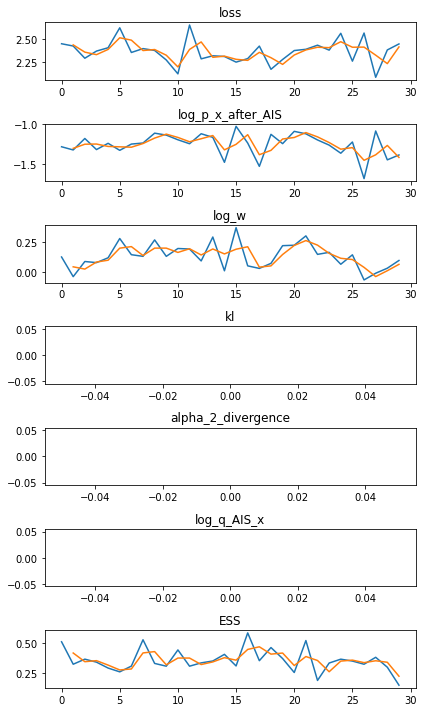

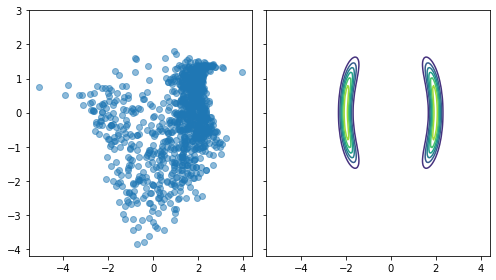

In [35]:
plot_history(history)
plotter(tester, n_samples=1000)